# KAN UNET encoder

In [267]:
from kan import KAN

In [268]:
from kan_convolutional.KANConv import KAN_Convolutional_Layer

In [269]:
import torch
from torch import nn
import torch.nn.functional as F

In [271]:
import numpy as np

In [272]:
class UNET_KAN_encoder(nn.Module):
    def __init__(self, num_filters):
        super().__init__()
        
        self.KANconv_1 = KAN_Convolutional_Layer(
            n_convs = num_filters, #changed from in channels to this
            kernel_size = (3,3),
            padding = (1,1),
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=2,
            stride = 2,
        )

    def forward(self, x):
        x = self.KANconv_1(x)
        
        x = self.pool1(x)

        return x

In [273]:
class UNET_KAN_decoder(nn.Module):
    def __init__(self, num_filters, in_channels, out_channels, skip_features):
        super().__init__()
        self.DKANconv_1 = KAN_Convolutional_Layer(
            n_convs = num_filters,
            kernel_size = (3,3),
            padding = (1,1),
        )

        self.ReduceChannels = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=1)
        
        self.DKANconv_2 = KAN_Convolutional_Layer(
             n_convs = num_filters,
             kernel_size = (3,3),
             padding = (1,1),
        )
    def forward(self, x, skip_features):
        #Increase image size
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        #Make skip features match dimensions of upscaled input
        if skip_features != None:
            skip_features = nn.functional.interpolate(skip_features, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=True) #changed from bilinear to nearest and removed 'align_corners=True'
            
            x = torch.cat((x, skip_features), dim=1)

        
        x = self.DKANconv_1(x)
        x = self.DKANconv_2(x)
        x = self.ReduceChannels(x)

        return x

In [275]:
class KAN_UNET(nn.Module):
    def __init__(self, input_shape=(3,256,256), num_classes=1, in_channels=1, out_channels=3):
        super().__init__()

        self.encoder1 = UNET_KAN_encoder(num_filters = 1)
        self.encoder2 = UNET_KAN_encoder(num_filters = 1) 
        # self.encoder3 = UNET_KAN_encoder(num_filters = 2)
        
        self.decoder1 = UNET_KAN_decoder(num_filters = 1, in_channels = 6, out_channels = 4, skip_features=None)
        self.decoder2 = UNET_KAN_decoder(num_filters = 2, in_channels = 28, out_channels = 3, skip_features=None)

        self.output_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)


        # self.skip_emb1 = nn.Parameter(torch.randn(1, 12, 32, 32))
        # self.skip_emb2 = nn.Parameter(torch.randn(1, 6, 64, 64))
        # self.skip_emb3 = nn.Parameter(torch.randn(1, 3, 128, 128)) #Tried learnable skip embeddings to help decoder with images generated in latent space but didnt work

    def forward(self, x):
        print(f"Input Shape: {x.shape}")
        s1 = self.encoder1(x)
        print(f"Shape s1: {s1.shape}")
        s2 = self.encoder2(s1)
        print(f"Shape s2: {s2.shape}")
        # s3 = self.encoder3(s2)
        # print(f"Shape s3: {s3.shape}")
        
        d1 = self.decoder1(s2, s1)
        print(f"Shape d1: {d1.shape}")
        d2 = self.decoder2(d1, s2)
        print(f"Shape d2: {d2.shape}")
        # d3 = self.decoder3(d2, s3)
        # print(f"Shape d3: {d3.shape}")
        
        outputs = self.output_conv(d2)
        print(f"Output Shape: {outputs.shape}")
        return outputs, s2

    def encoding_block(self, x):
        with torch.no_grad():
            s1 = self.encoder1(x)
            s2 = self.encoder2(s1)
            # s3 = self.encoder3(s2)
        return s2

    def decoding_block(self, x):
        with torch.no_grad():
            
            print(f'Input shape: {x.shape}')
            d1 = self.decoder1(x, skipemb[0])
            print(f'd1 shape: {d1.shape}')
            d2 = self.decoder2(d1, skipemb[1])
            print(f'd2 shape: {d2.shape}')
            # d3 = self.decoder3(d2, skipemb[2])
            # print(f'd1 shape: {d3.shape}')
            output = self.output_conv(d2)
        return output

## Testing before training

In [355]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def dispimage(img, title=" "):
    try:
        img_disp = (img.squeeze(0).detach()).numpy()
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.title(title)
        plt.imshow(img_disp[-1], cmap='gray')
        plt.axis("off")
        plt.show()
    except:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.title(title)
        plt.imshow(img, cmap='gray')
        plt.axis("off")
        plt.show()

def load_image(image_path, input_shape):
    image = Image.open(image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize(input_shape[1:]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    image_tensor = transform(image).unsqueeze(0)
    return image_tensor

modelnotrain = KAN_UNET(input_shape=(3, 128, 128),num_classes=1, in_channels=3,out_channels=3)  #latent_dim=16)
modelnotrain.eval()


image_path = '/Users/haziq/Desktop/Projects/DIFFUSION_FROM_SCRATCH/Dataset/00004.png'
input_tensor = load_image(image_path, input_shape=(3, 128, 128))

In [291]:
with torch.no_grad():
    outputnotrain, s4_1 = modelnotrain(input_tensor)

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


In [292]:
output_imagenotrain = (outputnotrain.squeeze(0).detach()).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


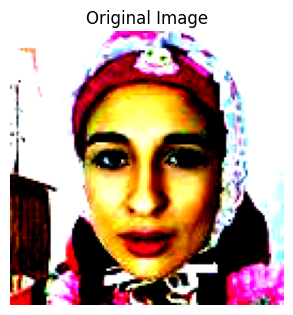

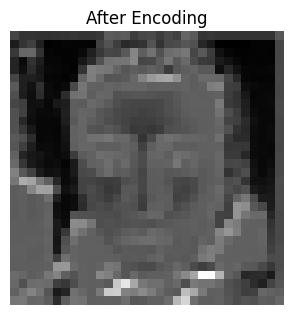

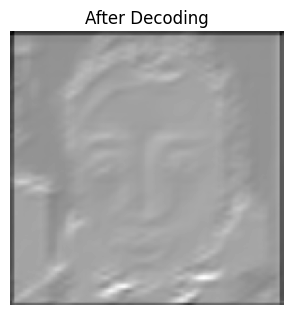

In [293]:
input_image = input_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)

dispimage(input_image, "Original Image")

dispimage(s4_1[0].squeeze(0).detach().numpy()[2], "After Encoding")

dispimage(output_imagenotrain[0], "After Decoding")

## Training

In [294]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import torchvision.transforms as transforms

In [295]:
class ImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_files = [f for i, f in enumerate(os.listdir(directory)) if f.endswith(('jpg', 'png', 'jpeg')) and i < 101]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [296]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [297]:
dataset_path = "/Users/haziq/Desktop/Projects/DIFFUSION_FROM_SCRATCH/Dataset"

dataset = ImageDataset(directory=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [298]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {device}")
model = KAN_UNET(input_shape=(3, 128, 128),num_classes=1, out_channels=3, in_channels=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Training on cpu


In [299]:
model.load_state_dict(torch.load("/Users/haziq/Desktop/Projects/DIFFUSION_FROM_SCRATCH/Encoder_Decoder_model_weights.pth"), strict=True)

<All keys matched successfully>

In [38]:
epochs = 10

In [39]:
losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for i, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}")):
        inputs = batch  # No labels, only images
        inputs = inputs.to(device)

        
        outputs, _ = model(inputs, imgnum=i, totimg=101)

        
        loss = criterion(outputs, inputs)

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f"IMAGE LOSS: {loss.item()}")


    
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(dataloader):.4f}")
    losses.append(running_loss)
    torch.save(model.state_dict(), 'Encoder_Decoder_model_weights.pth') #In case kernel dies


Epoch 1/10:   0%|                                       | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:   1%|▎                              | 1/101 [00:04<06:58,  4.18s/it]

IMAGE LOSS: 0.368615984916687
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:   2%|▌                              | 2/101 [00:07<06:23,  3.88s/it]

IMAGE LOSS: 0.4768901765346527
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:   3%|▉                              | 3/101 [00:11<06:03,  3.71s/it]

IMAGE LOSS: 0.35408973693847656
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:   4%|█▏                             | 4/101 [00:15<05:58,  3.69s/it]

IMAGE LOSS: 0.3272469937801361
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:   5%|█▌                             | 5/101 [00:18<05:52,  3.67s/it]

IMAGE LOSS: 0.3045295476913452
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:   6%|█▊                             | 6/101 [00:22<05:42,  3.60s/it]

IMAGE LOSS: 0.2404487580060959
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:   7%|██▏                            | 7/101 [00:25<05:30,  3.51s/it]

IMAGE LOSS: 0.41602492332458496
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:   8%|██▍                            | 8/101 [00:28<05:26,  3.51s/it]

IMAGE LOSS: 0.2207867056131363
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:   9%|██▊                            | 9/101 [00:32<05:20,  3.49s/it]

IMAGE LOSS: 0.3945033848285675
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  10%|██▉                           | 10/101 [00:35<05:15,  3.47s/it]

IMAGE LOSS: 0.33807024359703064
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  11%|███▎                          | 11/101 [00:39<05:12,  3.47s/it]

IMAGE LOSS: 0.3149421513080597
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  12%|███▌                          | 12/101 [00:42<05:06,  3.45s/it]

IMAGE LOSS: 0.3268788158893585
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  13%|███▊                          | 13/101 [00:46<05:03,  3.45s/it]

IMAGE LOSS: 0.35617682337760925
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  14%|████▏                         | 14/101 [00:49<04:59,  3.44s/it]

IMAGE LOSS: 0.18071939051151276
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  15%|████▍                         | 15/101 [00:53<04:56,  3.45s/it]

IMAGE LOSS: 0.33487987518310547
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  16%|████▊                         | 16/101 [00:56<05:02,  3.56s/it]

IMAGE LOSS: 0.2693493664264679
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  17%|█████                         | 17/101 [01:00<04:54,  3.51s/it]

IMAGE LOSS: 0.08836141228675842
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  18%|█████▎                        | 18/101 [01:03<04:52,  3.52s/it]

IMAGE LOSS: 0.23055781424045563
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  19%|█████▋                        | 19/101 [01:07<04:51,  3.56s/it]

IMAGE LOSS: 0.1732448786497116
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  20%|█████▉                        | 20/101 [01:11<04:51,  3.60s/it]

IMAGE LOSS: 0.28194159269332886
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  21%|██████▏                       | 21/101 [01:14<04:46,  3.59s/it]

IMAGE LOSS: 0.2282034158706665
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  22%|██████▌                       | 22/101 [01:18<04:43,  3.59s/it]

IMAGE LOSS: 0.15916438400745392
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  23%|██████▊                       | 23/101 [01:21<04:40,  3.60s/it]

IMAGE LOSS: 0.31090936064720154
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  24%|███████▏                      | 24/101 [01:25<04:37,  3.60s/it]

IMAGE LOSS: 0.13914354145526886
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  25%|███████▍                      | 25/101 [01:29<04:32,  3.59s/it]

IMAGE LOSS: 0.168806254863739
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  26%|███████▋                      | 26/101 [01:32<04:28,  3.59s/it]

IMAGE LOSS: 0.11763360351324081
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  27%|████████                      | 27/101 [01:36<04:26,  3.61s/it]

IMAGE LOSS: 0.14107413589954376
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  28%|████████▎                     | 28/101 [01:39<04:21,  3.58s/it]

IMAGE LOSS: 0.08543935418128967
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  29%|████████▌                     | 29/101 [01:43<04:18,  3.59s/it]

IMAGE LOSS: 0.11801443248987198
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  30%|████████▉                     | 30/101 [01:47<04:27,  3.77s/it]

IMAGE LOSS: 0.08301547169685364
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  31%|█████████▏                    | 31/101 [01:51<04:30,  3.86s/it]

IMAGE LOSS: 0.07858811318874359
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  32%|█████████▌                    | 32/101 [01:56<04:40,  4.06s/it]

IMAGE LOSS: 0.09904193878173828
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  33%|█████████▊                    | 33/101 [02:00<04:43,  4.16s/it]

IMAGE LOSS: 0.09832274168729782
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  34%|██████████                    | 34/101 [02:04<04:34,  4.10s/it]

IMAGE LOSS: 0.09108862280845642
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  35%|██████████▍                   | 35/101 [02:08<04:32,  4.14s/it]

IMAGE LOSS: 0.07001173496246338
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  36%|██████████▋                   | 36/101 [02:12<04:16,  3.94s/it]

IMAGE LOSS: 0.11362415552139282
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  37%|██████████▉                   | 37/101 [02:15<04:05,  3.84s/it]

IMAGE LOSS: 0.07595241814851761
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  38%|███████████▎                  | 38/101 [02:19<03:57,  3.78s/it]

IMAGE LOSS: 0.06143401935696602
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  39%|███████████▌                  | 39/101 [02:23<03:51,  3.73s/it]

IMAGE LOSS: 0.062098126858472824
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  40%|███████████▉                  | 40/101 [02:26<03:45,  3.70s/it]

IMAGE LOSS: 0.04396386072039604
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  41%|████████████▏                 | 41/101 [02:30<03:39,  3.65s/it]

IMAGE LOSS: 0.09502566605806351
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  42%|████████████▍                 | 42/101 [02:33<03:34,  3.64s/it]

IMAGE LOSS: 0.029312118887901306
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  43%|████████████▊                 | 43/101 [02:37<03:30,  3.64s/it]

IMAGE LOSS: 0.05365676060318947
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  44%|█████████████                 | 44/101 [02:41<03:26,  3.61s/it]

IMAGE LOSS: 0.04797063395380974
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  45%|█████████████▎                | 45/101 [02:44<03:22,  3.61s/it]

IMAGE LOSS: 0.046632468700408936
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  46%|█████████████▋                | 46/101 [02:48<03:18,  3.61s/it]

IMAGE LOSS: 0.06559425592422485
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  47%|█████████████▉                | 47/101 [02:52<03:16,  3.64s/it]

IMAGE LOSS: 0.046284694224596024
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  48%|██████████████▎               | 48/101 [02:55<03:13,  3.65s/it]

IMAGE LOSS: 0.04006059095263481
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  49%|██████████████▌               | 49/101 [03:00<03:22,  3.89s/it]

IMAGE LOSS: 0.039980363100767136
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  50%|██████████████▊               | 50/101 [03:03<03:14,  3.82s/it]

IMAGE LOSS: 0.08639124035835266
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  50%|███████████████▏              | 51/101 [03:07<03:08,  3.78s/it]

IMAGE LOSS: 0.06475632637739182
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  51%|███████████████▍              | 52/101 [03:11<03:03,  3.74s/it]

IMAGE LOSS: 0.054842036217451096
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  52%|███████████████▋              | 53/101 [03:14<02:59,  3.74s/it]

IMAGE LOSS: 0.027335837483406067
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  53%|████████████████              | 54/101 [03:18<02:55,  3.73s/it]

IMAGE LOSS: 0.07725393772125244
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  54%|████████████████▎             | 55/101 [03:22<02:50,  3.70s/it]

IMAGE LOSS: 0.02666284702718258
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  55%|████████████████▋             | 56/101 [03:26<02:47,  3.73s/it]

IMAGE LOSS: 0.06024272367358208
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  56%|████████████████▉             | 57/101 [03:29<02:43,  3.71s/it]

IMAGE LOSS: 0.041140321642160416
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  57%|█████████████████▏            | 58/101 [03:33<02:39,  3.70s/it]

IMAGE LOSS: 0.05261433124542236
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  58%|█████████████████▌            | 59/101 [03:37<02:35,  3.70s/it]

IMAGE LOSS: 0.05005260184407234
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  59%|█████████████████▊            | 60/101 [03:40<02:31,  3.69s/it]

IMAGE LOSS: 0.038832154124975204
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  60%|██████████████████            | 61/101 [03:44<02:26,  3.67s/it]

IMAGE LOSS: 0.026778794825077057
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  61%|██████████████████▍           | 62/101 [03:48<02:26,  3.75s/it]

IMAGE LOSS: 0.05800579860806465
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  62%|██████████████████▋           | 63/101 [03:52<02:26,  3.85s/it]

IMAGE LOSS: 0.057965319603681564
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  63%|███████████████████           | 64/101 [03:56<02:23,  3.87s/it]

IMAGE LOSS: 0.0664357990026474
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  64%|███████████████████▎          | 65/101 [04:00<02:18,  3.85s/it]

IMAGE LOSS: 0.059152498841285706
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  65%|███████████████████▌          | 66/101 [04:04<02:16,  3.90s/it]

IMAGE LOSS: 0.04280784726142883
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  66%|███████████████████▉          | 67/101 [04:07<02:11,  3.87s/it]

IMAGE LOSS: 0.06621178984642029
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  67%|████████████████████▏         | 68/101 [04:11<02:06,  3.84s/it]

IMAGE LOSS: 0.028333881869912148
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  68%|████████████████████▍         | 69/101 [04:15<02:03,  3.86s/it]

IMAGE LOSS: 0.03198635205626488
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  69%|████████████████████▊         | 70/101 [04:19<02:01,  3.93s/it]

IMAGE LOSS: 0.044184695929288864
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  70%|█████████████████████         | 71/101 [04:23<01:56,  3.89s/it]

IMAGE LOSS: 0.04820142686367035
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  71%|█████████████████████▍        | 72/101 [04:27<01:51,  3.84s/it]

IMAGE LOSS: 0.07327236235141754
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  72%|█████████████████████▋        | 73/101 [04:30<01:46,  3.80s/it]

IMAGE LOSS: 0.022697845473885536
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  73%|█████████████████████▉        | 74/101 [04:34<01:41,  3.77s/it]

IMAGE LOSS: 0.04482584074139595
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  74%|██████████████████████▎       | 75/101 [04:38<01:37,  3.74s/it]

IMAGE LOSS: 0.027005910873413086
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  75%|██████████████████████▌       | 76/101 [04:41<01:33,  3.73s/it]

IMAGE LOSS: 0.05800582095980644
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  76%|██████████████████████▊       | 77/101 [04:45<01:30,  3.77s/it]

IMAGE LOSS: 0.025426572188735008
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  77%|███████████████████████▏      | 78/101 [04:49<01:25,  3.73s/it]

IMAGE LOSS: 0.04330970719456673
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  78%|███████████████████████▍      | 79/101 [04:53<01:21,  3.72s/it]

IMAGE LOSS: 0.03358600661158562
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  79%|███████████████████████▊      | 80/101 [04:56<01:18,  3.75s/it]

IMAGE LOSS: 0.052278805524110794
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  80%|████████████████████████      | 81/101 [05:00<01:16,  3.80s/it]

IMAGE LOSS: 0.0411359928548336
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  81%|████████████████████████▎     | 82/101 [05:05<01:15,  3.98s/it]

IMAGE LOSS: 0.03156369552016258
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  82%|████████████████████████▋     | 83/101 [05:09<01:10,  3.91s/it]

IMAGE LOSS: 0.04582606256008148
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  83%|████████████████████████▉     | 84/101 [05:13<01:06,  3.92s/it]

IMAGE LOSS: 0.02805296890437603
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  84%|█████████████████████████▏    | 85/101 [05:16<01:02,  3.89s/it]

IMAGE LOSS: 0.04517311975359917
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  85%|█████████████████████████▌    | 86/101 [05:20<00:57,  3.84s/it]

IMAGE LOSS: 0.05434742569923401
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  86%|█████████████████████████▊    | 87/101 [05:24<00:53,  3.81s/it]

IMAGE LOSS: 0.033191483467817307
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  87%|██████████████████████████▏   | 88/101 [05:27<00:49,  3.77s/it]

IMAGE LOSS: 0.04278547689318657
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  88%|██████████████████████████▍   | 89/101 [05:31<00:44,  3.72s/it]

IMAGE LOSS: 0.05365855619311333
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  89%|██████████████████████████▋   | 90/101 [05:35<00:40,  3.70s/it]

IMAGE LOSS: 0.03779925778508186
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  90%|███████████████████████████   | 91/101 [05:38<00:36,  3.70s/it]

IMAGE LOSS: 0.0651756003499031
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  91%|███████████████████████████▎  | 92/101 [05:42<00:33,  3.68s/it]

IMAGE LOSS: 0.01806187815964222
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  92%|███████████████████████████▌  | 93/101 [05:46<00:29,  3.67s/it]

IMAGE LOSS: 0.06085817143321037
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  93%|███████████████████████████▉  | 94/101 [05:49<00:25,  3.67s/it]

IMAGE LOSS: 0.06652010977268219
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  94%|████████████████████████████▏ | 95/101 [05:53<00:21,  3.66s/it]

IMAGE LOSS: 0.04774026945233345
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  95%|████████████████████████████▌ | 96/101 [05:57<00:18,  3.67s/it]

IMAGE LOSS: 0.036598026752471924
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  96%|████████████████████████████▊ | 97/101 [06:00<00:14,  3.69s/it]

IMAGE LOSS: 0.05124037340283394
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  97%|█████████████████████████████ | 98/101 [06:04<00:11,  3.69s/it]

IMAGE LOSS: 0.03336590155959129
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  98%|█████████████████████████████▍| 99/101 [06:08<00:07,  3.68s/it]

IMAGE LOSS: 0.0278534684330225
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10:  99%|████████████████████████████▋| 100/101 [06:11<00:03,  3.67s/it]

IMAGE LOSS: 0.04314442351460457
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 1/10: 100%|█████████████████████████████| 101/101 [06:15<00:00,  3.72s/it]


IMAGE LOSS: 0.03828069940209389
Epoch [1/10], Loss: 0.1109


Epoch 2/10:   0%|                                       | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:   1%|▎                              | 1/101 [00:03<06:16,  3.77s/it]

IMAGE LOSS: 0.03789876773953438
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:   2%|▌                              | 2/101 [00:07<06:07,  3.71s/it]

IMAGE LOSS: 0.03664274886250496
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:   3%|▉                              | 3/101 [00:11<05:59,  3.67s/it]

IMAGE LOSS: 0.05535935238003731
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:   4%|█▏                             | 4/101 [00:14<05:56,  3.67s/it]

IMAGE LOSS: 0.049145448952913284
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:   5%|█▌                             | 5/101 [00:18<05:50,  3.65s/it]

IMAGE LOSS: 0.06298259645700455
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:   6%|█▊                             | 6/101 [00:22<05:48,  3.66s/it]

IMAGE LOSS: 0.04640890657901764
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:   7%|██▏                            | 7/101 [00:25<05:44,  3.66s/it]

IMAGE LOSS: 0.050421446561813354
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:   8%|██▍                            | 8/101 [00:29<05:41,  3.68s/it]

IMAGE LOSS: 0.04018479958176613
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:   9%|██▊                            | 9/101 [00:33<05:40,  3.70s/it]

IMAGE LOSS: 0.030990950763225555
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  10%|██▉                           | 10/101 [00:36<05:36,  3.69s/it]

IMAGE LOSS: 0.04981996491551399
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  11%|███▎                          | 11/101 [00:40<05:32,  3.70s/it]

IMAGE LOSS: 0.04130866751074791
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  12%|███▌                          | 12/101 [00:44<05:29,  3.70s/it]

IMAGE LOSS: 0.04179087281227112
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  13%|███▊                          | 13/101 [00:48<05:30,  3.76s/it]

IMAGE LOSS: 0.01882188767194748
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  14%|████▏                         | 14/101 [00:52<05:41,  3.92s/it]

IMAGE LOSS: 0.04214182496070862
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  15%|████▍                         | 15/101 [00:56<05:31,  3.85s/it]

IMAGE LOSS: 0.02093956433236599
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  16%|████▊                         | 16/101 [00:59<05:20,  3.77s/it]

IMAGE LOSS: 0.03223597630858421
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  17%|█████                         | 17/101 [01:03<05:15,  3.75s/it]

IMAGE LOSS: 0.031224733218550682
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  18%|█████▎                        | 18/101 [01:07<05:22,  3.88s/it]

IMAGE LOSS: 0.02632639743387699
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  19%|█████▋                        | 19/101 [01:11<05:06,  3.74s/it]

IMAGE LOSS: 0.03376711532473564
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  20%|█████▉                        | 20/101 [01:14<05:00,  3.71s/it]

IMAGE LOSS: 0.024682005867362022
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  21%|██████▏                       | 21/101 [01:18<05:06,  3.83s/it]

IMAGE LOSS: 0.04429903253912926
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  22%|██████▌                       | 22/101 [01:23<05:14,  3.98s/it]

IMAGE LOSS: 0.015488720498979092
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  23%|██████▊                       | 23/101 [01:26<05:07,  3.94s/it]

IMAGE LOSS: 0.02989383600652218
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  24%|███████▏                      | 24/101 [01:31<05:16,  4.12s/it]

IMAGE LOSS: 0.02006550133228302
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  25%|███████▍                      | 25/101 [01:35<05:19,  4.21s/it]

IMAGE LOSS: 0.03397298604249954
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  26%|███████▋                      | 26/101 [01:40<05:14,  4.19s/it]

IMAGE LOSS: 0.10898375511169434
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  27%|████████                      | 27/101 [01:43<04:59,  4.05s/it]

IMAGE LOSS: 0.031156474724411964
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  28%|████████▎                     | 28/101 [01:47<04:56,  4.07s/it]

IMAGE LOSS: 0.029756896197795868
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  29%|████████▌                     | 29/101 [01:51<04:44,  3.95s/it]

IMAGE LOSS: 0.03164178505539894
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  30%|████████▉                     | 30/101 [01:54<04:23,  3.71s/it]

IMAGE LOSS: 0.021008089184761047
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  31%|█████████▏                    | 31/101 [01:58<04:19,  3.71s/it]

IMAGE LOSS: 0.03773804381489754
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  32%|█████████▌                    | 32/101 [02:02<04:17,  3.74s/it]

IMAGE LOSS: 0.014342479407787323
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  33%|█████████▊                    | 33/101 [02:06<04:17,  3.78s/it]

IMAGE LOSS: 0.021610721945762634
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  34%|██████████                    | 34/101 [02:09<04:13,  3.78s/it]

IMAGE LOSS: 0.020823905244469643
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  35%|██████████▍                   | 35/101 [02:13<04:07,  3.76s/it]

IMAGE LOSS: 0.03874659165740013
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  36%|██████████▋                   | 36/101 [02:17<04:05,  3.78s/it]

IMAGE LOSS: 0.026311764493584633
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  37%|██████████▉                   | 37/101 [02:21<04:01,  3.77s/it]

IMAGE LOSS: 0.0200941264629364
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  38%|███████████▎                  | 38/101 [02:24<03:57,  3.77s/it]

IMAGE LOSS: 0.018951207399368286
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  39%|███████████▌                  | 39/101 [02:28<03:53,  3.77s/it]

IMAGE LOSS: 0.059048812836408615
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  40%|███████████▉                  | 40/101 [02:32<03:55,  3.86s/it]

IMAGE LOSS: 0.016107231378555298
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  41%|████████████▏                 | 41/101 [02:36<03:49,  3.83s/it]

IMAGE LOSS: 0.02915690839290619
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  42%|████████████▍                 | 42/101 [02:40<03:44,  3.80s/it]

IMAGE LOSS: 0.028255974873900414
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  43%|████████████▊                 | 43/101 [02:44<03:40,  3.80s/it]

IMAGE LOSS: 0.04863341152667999
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  44%|█████████████                 | 44/101 [02:47<03:36,  3.80s/it]

IMAGE LOSS: 0.022125890478491783
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  45%|█████████████▎                | 45/101 [02:51<03:36,  3.87s/it]

IMAGE LOSS: 0.01387256383895874
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  46%|█████████████▋                | 46/101 [02:56<03:41,  4.03s/it]

IMAGE LOSS: 0.024741970002651215
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  47%|█████████████▉                | 47/101 [03:00<03:34,  3.96s/it]

IMAGE LOSS: 0.03031116910278797
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  48%|██████████████▎               | 48/101 [03:03<03:28,  3.94s/it]

IMAGE LOSS: 0.02638903819024563
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  49%|██████████████▌               | 49/101 [03:08<03:27,  3.99s/it]

IMAGE LOSS: 0.02352757751941681
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  50%|██████████████▊               | 50/101 [03:12<03:24,  4.01s/it]

IMAGE LOSS: 0.04432065412402153
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  50%|███████████████▏              | 51/101 [03:15<03:16,  3.94s/it]

IMAGE LOSS: 0.034455057233572006
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  51%|███████████████▍              | 52/101 [03:19<03:10,  3.88s/it]

IMAGE LOSS: 0.04556829109787941
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  52%|███████████████▋              | 53/101 [03:23<03:06,  3.88s/it]

IMAGE LOSS: 0.025261418893933296
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  53%|████████████████              | 54/101 [03:27<03:01,  3.87s/it]

IMAGE LOSS: 0.031398314982652664
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  54%|████████████████▎             | 55/101 [03:31<02:58,  3.88s/it]

IMAGE LOSS: 0.03018726222217083
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  55%|████████████████▋             | 56/101 [03:35<02:59,  3.99s/it]

IMAGE LOSS: 0.01857389137148857
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  56%|████████████████▉             | 57/101 [03:39<02:56,  4.01s/it]

IMAGE LOSS: 0.05884178355336189
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  57%|█████████████████▏            | 58/101 [03:43<02:49,  3.94s/it]

IMAGE LOSS: 0.05790812894701958
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  58%|█████████████████▌            | 59/101 [03:47<02:43,  3.90s/it]

IMAGE LOSS: 0.023096324875950813
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  59%|█████████████████▊            | 60/101 [03:50<02:39,  3.88s/it]

IMAGE LOSS: 0.026979858055710793
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  60%|██████████████████            | 61/101 [03:54<02:34,  3.86s/it]

IMAGE LOSS: 0.023270785808563232
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  61%|██████████████████▍           | 62/101 [03:58<02:30,  3.86s/it]

IMAGE LOSS: 0.03236902132630348
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  62%|██████████████████▋           | 63/101 [04:02<02:29,  3.93s/it]

IMAGE LOSS: 0.03876766934990883
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  63%|███████████████████           | 64/101 [04:06<02:28,  4.00s/it]

IMAGE LOSS: 0.021940870210528374
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  64%|███████████████████▎          | 65/101 [04:10<02:20,  3.90s/it]

IMAGE LOSS: 0.025619447231292725
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  65%|███████████████████▌          | 66/101 [04:14<02:15,  3.87s/it]

IMAGE LOSS: 0.05158999189734459
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  66%|███████████████████▉          | 67/101 [04:18<02:10,  3.83s/it]

IMAGE LOSS: 0.023701617494225502
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  67%|████████████████████▏         | 68/101 [04:21<02:05,  3.81s/it]

IMAGE LOSS: 0.026327379047870636
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  68%|████████████████████▍         | 69/101 [04:25<02:01,  3.80s/it]

IMAGE LOSS: 0.032029107213020325
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  69%|████████████████████▊         | 70/101 [04:29<01:57,  3.78s/it]

IMAGE LOSS: 0.017951585352420807
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  70%|█████████████████████         | 71/101 [04:33<01:54,  3.82s/it]

IMAGE LOSS: 0.028908884152770042
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  71%|█████████████████████▍        | 72/101 [04:37<01:50,  3.81s/it]

IMAGE LOSS: 0.018353378400206566
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  72%|█████████████████████▋        | 73/101 [04:40<01:46,  3.79s/it]

IMAGE LOSS: 0.02672511339187622
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  73%|█████████████████████▉        | 74/101 [04:44<01:41,  3.77s/it]

IMAGE LOSS: 0.030551357194781303
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  74%|██████████████████████▎       | 75/101 [04:48<01:38,  3.79s/it]

IMAGE LOSS: 0.02714679203927517
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  75%|██████████████████████▌       | 76/101 [04:52<01:34,  3.78s/it]

IMAGE LOSS: 0.03931836038827896
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  76%|██████████████████████▊       | 77/101 [04:56<01:32,  3.87s/it]

IMAGE LOSS: 0.025470023974776268
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  77%|███████████████████████▏      | 78/101 [05:00<01:32,  4.02s/it]

IMAGE LOSS: 0.02346237562596798
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  78%|███████████████████████▍      | 79/101 [05:04<01:26,  3.92s/it]

IMAGE LOSS: 0.0289238840341568
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  79%|███████████████████████▊      | 80/101 [05:08<01:21,  3.89s/it]

IMAGE LOSS: 0.035897720605134964
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  80%|████████████████████████      | 81/101 [05:11<01:17,  3.86s/it]

IMAGE LOSS: 0.03737481310963631
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  81%|████████████████████████▎     | 82/101 [05:15<01:11,  3.78s/it]

IMAGE LOSS: 0.02491004765033722
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  82%|████████████████████████▋     | 83/101 [05:19<01:07,  3.75s/it]

IMAGE LOSS: 0.024031013250350952
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  83%|████████████████████████▉     | 84/101 [05:22<01:03,  3.72s/it]

IMAGE LOSS: 0.03100072406232357
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  84%|█████████████████████████▏    | 85/101 [05:26<00:59,  3.70s/it]

IMAGE LOSS: 0.026057923212647438
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  85%|█████████████████████████▌    | 86/101 [05:30<00:55,  3.70s/it]

IMAGE LOSS: 0.036680325865745544
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  86%|█████████████████████████▊    | 87/101 [05:34<00:52,  3.74s/it]

IMAGE LOSS: 0.020395448431372643
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  87%|██████████████████████████▏   | 88/101 [05:37<00:48,  3.74s/it]

IMAGE LOSS: 0.023629536852240562
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  88%|██████████████████████████▍   | 89/101 [05:41<00:44,  3.74s/it]

IMAGE LOSS: 0.0475197397172451
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  89%|██████████████████████████▋   | 90/101 [05:47<00:48,  4.37s/it]

IMAGE LOSS: 0.036044348031282425
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  90%|███████████████████████████   | 91/101 [05:52<00:45,  4.52s/it]

IMAGE LOSS: 0.01737084984779358
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  91%|███████████████████████████▎  | 92/101 [05:56<00:40,  4.47s/it]

IMAGE LOSS: 0.029982922598719597
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  92%|███████████████████████████▌  | 93/101 [06:00<00:34,  4.33s/it]

IMAGE LOSS: 0.01633358560502529
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  93%|███████████████████████████▉  | 94/101 [06:06<00:33,  4.79s/it]

IMAGE LOSS: 0.038158126175403595
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  94%|████████████████████████████▏ | 95/101 [06:10<00:27,  4.62s/it]

IMAGE LOSS: 0.046145349740982056
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  95%|████████████████████████████▌ | 96/101 [06:15<00:23,  4.65s/it]

IMAGE LOSS: 0.024888193234801292
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  96%|████████████████████████████▊ | 97/101 [06:20<00:18,  4.74s/it]

IMAGE LOSS: 0.012396848760545254
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  97%|█████████████████████████████ | 98/101 [06:25<00:14,  4.89s/it]

IMAGE LOSS: 0.015470621176064014
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  98%|█████████████████████████████▍| 99/101 [06:30<00:09,  4.75s/it]

IMAGE LOSS: 0.019463902339339256
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10:  99%|████████████████████████████▋| 100/101 [06:34<00:04,  4.77s/it]

IMAGE LOSS: 0.01821693405508995
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 2/10: 100%|█████████████████████████████| 101/101 [06:39<00:00,  3.95s/it]


IMAGE LOSS: 0.02215144969522953
Epoch [2/10], Loss: 0.0317


Epoch 3/10:   0%|                                       | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:   1%|▎                              | 1/101 [00:04<07:23,  4.43s/it]

IMAGE LOSS: 0.014362181536853313
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:   2%|▌                              | 2/101 [00:08<07:17,  4.42s/it]

IMAGE LOSS: 0.0376533605158329
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:   3%|▉                              | 3/101 [00:13<07:35,  4.65s/it]

IMAGE LOSS: 0.02055366523563862
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:   4%|█▏                             | 4/101 [00:18<07:30,  4.64s/it]

IMAGE LOSS: 0.018441686406731606
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:   5%|█▌                             | 5/101 [00:23<07:38,  4.78s/it]

IMAGE LOSS: 0.020026259124279022
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:   6%|█▊                             | 6/101 [00:28<07:33,  4.78s/it]

IMAGE LOSS: 0.033887896686792374
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:   7%|██▏                            | 7/101 [00:32<07:24,  4.72s/it]

IMAGE LOSS: 0.03453334793448448
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:   8%|██▍                            | 8/101 [00:36<06:57,  4.48s/it]

IMAGE LOSS: 0.01707366667687893
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:   9%|██▊                            | 9/101 [00:41<06:47,  4.43s/it]

IMAGE LOSS: 0.02391038089990616
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  10%|██▉                           | 10/101 [00:45<06:34,  4.33s/it]

IMAGE LOSS: 0.054024726152420044
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  11%|███▎                          | 11/101 [00:49<06:18,  4.20s/it]

IMAGE LOSS: 0.026411211118102074
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  12%|███▌                          | 12/101 [00:52<06:00,  4.05s/it]

IMAGE LOSS: 0.020258450880646706
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  13%|███▊                          | 13/101 [00:56<05:34,  3.80s/it]

IMAGE LOSS: 0.01898784190416336
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  14%|████▏                         | 14/101 [00:58<05:04,  3.50s/it]

IMAGE LOSS: 0.022988468408584595
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  15%|████▍                         | 15/101 [01:01<04:46,  3.33s/it]

IMAGE LOSS: 0.027015993371605873
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  16%|████▊                         | 16/101 [01:04<04:27,  3.15s/it]

IMAGE LOSS: 0.03488034009933472
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  17%|█████                         | 17/101 [01:07<04:12,  3.00s/it]

IMAGE LOSS: 0.02194526232779026
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  18%|█████▎                        | 18/101 [01:10<04:11,  3.03s/it]

IMAGE LOSS: 0.027931785210967064
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  19%|█████▋                        | 19/101 [01:13<04:03,  2.97s/it]

IMAGE LOSS: 0.030069967731833458
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  20%|█████▉                        | 20/101 [01:15<03:54,  2.89s/it]

IMAGE LOSS: 0.025781473144888878
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  21%|██████▏                       | 21/101 [01:18<03:58,  2.98s/it]

IMAGE LOSS: 0.042527586221694946
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  22%|██████▌                       | 22/101 [01:22<03:57,  3.00s/it]

IMAGE LOSS: 0.023000037297606468
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  23%|██████▊                       | 23/101 [01:25<04:09,  3.20s/it]

IMAGE LOSS: 0.022228172048926353
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  24%|███████▏                      | 24/101 [01:29<04:18,  3.35s/it]

IMAGE LOSS: 0.01723853126168251
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  25%|███████▍                      | 25/101 [01:33<04:21,  3.44s/it]

IMAGE LOSS: 0.04192956164479256
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  26%|███████▋                      | 26/101 [01:36<04:21,  3.49s/it]

IMAGE LOSS: 0.03304559364914894
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  27%|████████                      | 27/101 [01:39<04:02,  3.28s/it]

IMAGE LOSS: 0.029346885159611702
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  28%|████████▎                     | 28/101 [01:42<03:54,  3.21s/it]

IMAGE LOSS: 0.013620060868561268
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  29%|████████▌                     | 29/101 [01:45<03:39,  3.05s/it]

IMAGE LOSS: 0.02563384175300598
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  30%|████████▉                     | 30/101 [01:47<03:24,  2.87s/it]

IMAGE LOSS: 0.02642855979502201
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  31%|█████████▏                    | 31/101 [01:50<03:20,  2.86s/it]

IMAGE LOSS: 0.018351605162024498
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  32%|█████████▌                    | 32/101 [01:53<03:13,  2.80s/it]

IMAGE LOSS: 0.02010316215455532
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  33%|█████████▊                    | 33/101 [01:55<03:10,  2.80s/it]

IMAGE LOSS: 0.02429848350584507
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  34%|██████████                    | 34/101 [01:58<03:04,  2.75s/it]

IMAGE LOSS: 0.017757900059223175
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  35%|██████████▍                   | 35/101 [02:01<03:04,  2.80s/it]

IMAGE LOSS: 0.03042808175086975
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  36%|██████████▋                   | 36/101 [02:04<02:59,  2.76s/it]

IMAGE LOSS: 0.017235349863767624
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  37%|██████████▉                   | 37/101 [02:06<02:56,  2.75s/it]

IMAGE LOSS: 0.016220828518271446
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  38%|███████████▎                  | 38/101 [02:09<02:55,  2.79s/it]

IMAGE LOSS: 0.02780330739915371
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  39%|███████████▌                  | 39/101 [02:12<02:59,  2.89s/it]

IMAGE LOSS: 0.044310059398412704
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  40%|███████████▉                  | 40/101 [02:15<02:57,  2.91s/it]

IMAGE LOSS: 0.02699577808380127
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  41%|████████████▏                 | 41/101 [02:18<02:50,  2.84s/it]

IMAGE LOSS: 0.027522357180714607
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  42%|████████████▍                 | 42/101 [02:21<02:46,  2.82s/it]

IMAGE LOSS: 0.02915247343480587
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  43%|████████████▊                 | 43/101 [02:24<02:54,  3.01s/it]

IMAGE LOSS: 0.03419177606701851
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  44%|█████████████                 | 44/101 [02:29<03:19,  3.50s/it]

IMAGE LOSS: 0.018521852791309357
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  45%|█████████████▎                | 45/101 [02:33<03:26,  3.69s/it]

IMAGE LOSS: 0.03519434109330177
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  46%|█████████████▋                | 46/101 [02:37<03:21,  3.67s/it]

IMAGE LOSS: 0.018023626878857613
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  47%|█████████████▉                | 47/101 [02:40<03:12,  3.57s/it]

IMAGE LOSS: 0.024040380492806435
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  48%|██████████████▎               | 48/101 [02:43<03:07,  3.53s/it]

IMAGE LOSS: 0.054599910974502563
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  49%|██████████████▌               | 49/101 [02:47<02:59,  3.45s/it]

IMAGE LOSS: 0.027614938095211983
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  50%|██████████████▊               | 50/101 [02:50<02:47,  3.29s/it]

IMAGE LOSS: 0.05260954424738884
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  50%|███████████████▏              | 51/101 [02:52<02:35,  3.12s/it]

IMAGE LOSS: 0.013770301826298237
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  51%|███████████████▍              | 52/101 [02:55<02:30,  3.08s/it]

IMAGE LOSS: 0.023211510851979256
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  52%|███████████████▋              | 53/101 [02:59<02:33,  3.20s/it]

IMAGE LOSS: 0.021669410169124603
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  53%|████████████████              | 54/101 [03:03<02:38,  3.37s/it]

IMAGE LOSS: 0.014266670681536198
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  54%|████████████████▎             | 55/101 [03:06<02:38,  3.45s/it]

IMAGE LOSS: 0.03317403793334961
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  55%|████████████████▋             | 56/101 [03:10<02:40,  3.57s/it]

IMAGE LOSS: 0.01989910565316677
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  56%|████████████████▉             | 57/101 [03:14<02:41,  3.67s/it]

IMAGE LOSS: 0.01871785707771778
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  57%|█████████████████▏            | 58/101 [03:18<02:45,  3.86s/it]

IMAGE LOSS: 0.014290142804384232
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  58%|█████████████████▌            | 59/101 [03:22<02:42,  3.88s/it]

IMAGE LOSS: 0.01090578455477953
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  59%|█████████████████▊            | 60/101 [03:26<02:37,  3.85s/it]

IMAGE LOSS: 0.04555698111653328
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  60%|██████████████████            | 61/101 [03:30<02:33,  3.85s/it]

IMAGE LOSS: 0.034492895007133484
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  61%|██████████████████▍           | 62/101 [03:34<02:31,  3.87s/it]

IMAGE LOSS: 0.02573487162590027
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  62%|██████████████████▋           | 63/101 [03:38<02:27,  3.88s/it]

IMAGE LOSS: 0.02243427373468876
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  63%|███████████████████           | 64/101 [03:41<02:22,  3.85s/it]

IMAGE LOSS: 0.06147930026054382
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  64%|███████████████████▎          | 65/101 [03:45<02:18,  3.85s/it]

IMAGE LOSS: 0.01821787655353546
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  65%|███████████████████▌          | 66/101 [03:49<02:15,  3.86s/it]

IMAGE LOSS: 0.03168719634413719
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  66%|███████████████████▉          | 67/101 [03:53<02:11,  3.88s/it]

IMAGE LOSS: 0.030255557969212532
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  67%|████████████████████▏         | 68/101 [03:57<02:08,  3.90s/it]

IMAGE LOSS: 0.03697151690721512
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  68%|████████████████████▍         | 69/101 [04:01<02:07,  3.97s/it]

IMAGE LOSS: 0.02100684680044651
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  69%|████████████████████▊         | 70/101 [04:05<02:01,  3.92s/it]

IMAGE LOSS: 0.019130656495690346
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  70%|█████████████████████         | 71/101 [04:09<01:57,  3.92s/it]

IMAGE LOSS: 0.03623536229133606
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  71%|█████████████████████▍        | 72/101 [04:13<01:55,  4.00s/it]

IMAGE LOSS: 0.030806859955191612
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  72%|█████████████████████▋        | 73/101 [04:17<01:52,  4.03s/it]

IMAGE LOSS: 0.021790998056530952
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  73%|█████████████████████▉        | 74/101 [04:21<01:48,  4.01s/it]

IMAGE LOSS: 0.028578663244843483
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  74%|██████████████████████▎       | 75/101 [04:25<01:42,  3.95s/it]

IMAGE LOSS: 0.018508339300751686
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  75%|██████████████████████▌       | 76/101 [04:29<01:42,  4.08s/it]

IMAGE LOSS: 0.019172189757227898
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  76%|██████████████████████▊       | 77/101 [04:34<01:42,  4.25s/it]

IMAGE LOSS: 0.013899718411266804
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  77%|███████████████████████▏      | 78/101 [04:38<01:34,  4.13s/it]

IMAGE LOSS: 0.025564618408679962
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  78%|███████████████████████▍      | 79/101 [04:42<01:29,  4.08s/it]

IMAGE LOSS: 0.03503311797976494
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  79%|███████████████████████▊      | 80/101 [04:46<01:24,  4.02s/it]

IMAGE LOSS: 0.025980735197663307
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  80%|████████████████████████      | 81/101 [04:49<01:19,  3.97s/it]

IMAGE LOSS: 0.02562602609395981
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  81%|████████████████████████▎     | 82/101 [04:53<01:15,  3.97s/it]

IMAGE LOSS: 0.011004648171365261
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  82%|████████████████████████▋     | 83/101 [04:57<01:11,  3.96s/it]

IMAGE LOSS: 0.014726362191140652
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  83%|████████████████████████▉     | 84/101 [05:01<01:06,  3.91s/it]

IMAGE LOSS: 0.020599378272891045
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  84%|█████████████████████████▏    | 85/101 [05:05<01:02,  3.88s/it]

IMAGE LOSS: 0.015194241888821125
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  85%|█████████████████████████▌    | 86/101 [05:09<00:58,  3.89s/it]

IMAGE LOSS: 0.014870506711304188
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  86%|█████████████████████████▊    | 87/101 [05:13<00:53,  3.83s/it]

IMAGE LOSS: 0.020707005634903908
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  87%|██████████████████████████▏   | 88/101 [05:16<00:49,  3.84s/it]

IMAGE LOSS: 0.020642302930355072
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  88%|██████████████████████████▍   | 89/101 [05:21<00:46,  3.91s/it]

IMAGE LOSS: 0.027194807305932045
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  89%|██████████████████████████▋   | 90/101 [05:24<00:42,  3.89s/it]

IMAGE LOSS: 0.009213323704898357
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  90%|███████████████████████████   | 91/101 [05:28<00:38,  3.90s/it]

IMAGE LOSS: 0.015233047306537628
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  91%|███████████████████████████▎  | 92/101 [05:32<00:34,  3.88s/it]

IMAGE LOSS: 0.012442751787602901
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  92%|███████████████████████████▌  | 93/101 [05:36<00:30,  3.86s/it]

IMAGE LOSS: 0.013361863791942596
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  93%|███████████████████████████▉  | 94/101 [05:40<00:26,  3.84s/it]

IMAGE LOSS: 0.017176304012537003
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  94%|████████████████████████████▏ | 95/101 [05:44<00:23,  3.85s/it]

IMAGE LOSS: 0.019431570544838905
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  95%|████████████████████████████▌ | 96/101 [05:47<00:19,  3.83s/it]

IMAGE LOSS: 0.016044503077864647
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  96%|████████████████████████████▊ | 97/101 [05:51<00:15,  3.82s/it]

IMAGE LOSS: 0.01329206395894289
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  97%|█████████████████████████████ | 98/101 [05:55<00:11,  3.82s/it]

IMAGE LOSS: 0.013451519422233105
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  98%|█████████████████████████████▍| 99/101 [05:59<00:07,  3.82s/it]

IMAGE LOSS: 0.043816667050123215
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10:  99%|████████████████████████████▋| 100/101 [06:03<00:03,  3.82s/it]

IMAGE LOSS: 0.029122909530997276
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/10: 100%|█████████████████████████████| 101/101 [06:06<00:00,  3.63s/it]


IMAGE LOSS: 0.025238579139113426
Epoch [3/10], Loss: 0.0252


Epoch 4/10:   0%|                                       | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:   1%|▎                              | 1/101 [00:03<06:25,  3.86s/it]

IMAGE LOSS: 0.01251570787280798
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:   2%|▌                              | 2/101 [00:07<06:18,  3.82s/it]

IMAGE LOSS: 0.018420860171318054
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:   3%|▉                              | 3/101 [00:11<06:13,  3.81s/it]

IMAGE LOSS: 0.024349497631192207
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:   4%|█▏                             | 4/101 [00:15<06:12,  3.84s/it]

IMAGE LOSS: 0.013313129544258118
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:   5%|█▌                             | 5/101 [00:19<06:25,  4.02s/it]

IMAGE LOSS: 0.0200764499604702
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:   6%|█▊                             | 6/101 [00:24<06:32,  4.13s/it]

IMAGE LOSS: 0.016651609912514687
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:   7%|██▏                            | 7/101 [00:29<06:55,  4.42s/it]

IMAGE LOSS: 0.01485547423362732
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:   8%|██▍                            | 8/101 [00:33<06:44,  4.35s/it]

IMAGE LOSS: 0.019757235422730446
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:   9%|██▊                            | 9/101 [00:37<06:29,  4.24s/it]

IMAGE LOSS: 0.022460296750068665
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  10%|██▉                           | 10/101 [00:41<06:24,  4.23s/it]

IMAGE LOSS: 0.01639811135828495
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  11%|███▎                          | 11/101 [00:45<06:19,  4.22s/it]

IMAGE LOSS: 0.012191376648843288
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  12%|███▌                          | 12/101 [00:49<06:10,  4.17s/it]

IMAGE LOSS: 0.013675999827682972
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  13%|███▊                          | 13/101 [00:53<06:05,  4.15s/it]

IMAGE LOSS: 0.021174153313040733
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  14%|████▏                         | 14/101 [00:57<05:51,  4.04s/it]

IMAGE LOSS: 0.03933492675423622
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  15%|████▍                         | 15/101 [01:01<05:39,  3.95s/it]

IMAGE LOSS: 0.012048895470798016
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  16%|████▊                         | 16/101 [01:05<05:31,  3.90s/it]

IMAGE LOSS: 0.016202138736844063
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  17%|█████                         | 17/101 [01:08<05:20,  3.82s/it]

IMAGE LOSS: 0.011080981232225895
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  18%|█████▎                        | 18/101 [01:12<05:18,  3.83s/it]

IMAGE LOSS: 0.02046031318604946
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  19%|█████▋                        | 19/101 [01:16<05:24,  3.96s/it]

IMAGE LOSS: 0.016872532665729523
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  20%|█████▉                        | 20/101 [01:20<05:14,  3.88s/it]

IMAGE LOSS: 0.022459259256720543
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  21%|██████▏                       | 21/101 [01:24<05:04,  3.80s/it]

IMAGE LOSS: 0.022932305932044983
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  22%|██████▌                       | 22/101 [01:28<05:02,  3.83s/it]

IMAGE LOSS: 0.025166092440485954
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  23%|██████▊                       | 23/101 [01:31<04:55,  3.79s/it]

IMAGE LOSS: 0.021807989105582237
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  24%|███████▏                      | 24/101 [01:35<04:50,  3.77s/it]

IMAGE LOSS: 0.025377772748470306
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  25%|███████▍                      | 25/101 [01:39<04:47,  3.79s/it]

IMAGE LOSS: 0.020517906174063683
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  26%|███████▋                      | 26/101 [01:42<04:40,  3.73s/it]

IMAGE LOSS: 0.030624477192759514
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  27%|████████                      | 27/101 [01:46<04:36,  3.74s/it]

IMAGE LOSS: 0.02185453288257122
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  28%|████████▎                     | 28/101 [01:50<04:31,  3.72s/it]

IMAGE LOSS: 0.025990890339016914
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  29%|████████▌                     | 29/101 [01:54<04:27,  3.72s/it]

IMAGE LOSS: 0.026577508077025414
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  30%|████████▉                     | 30/101 [01:57<04:15,  3.59s/it]

IMAGE LOSS: 0.02165849320590496
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  31%|█████████▏                    | 31/101 [02:01<04:16,  3.67s/it]

IMAGE LOSS: 0.013303195126354694
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  32%|█████████▌                    | 32/101 [02:05<04:25,  3.85s/it]

IMAGE LOSS: 0.016355322673916817
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  33%|█████████▊                    | 33/101 [02:10<04:48,  4.24s/it]

IMAGE LOSS: 0.015926441177725792
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  34%|██████████                    | 34/101 [02:16<05:07,  4.58s/it]

IMAGE LOSS: 0.013126951642334461
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  35%|██████████▍                   | 35/101 [02:21<05:24,  4.92s/it]

IMAGE LOSS: 0.020441340282559395
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  36%|██████████▋                   | 36/101 [02:25<05:01,  4.64s/it]

IMAGE LOSS: 0.01630554161965847
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  37%|██████████▉                   | 37/101 [02:29<04:47,  4.49s/it]

IMAGE LOSS: 0.014527383260428905
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  38%|███████████▎                  | 38/101 [02:34<04:46,  4.56s/it]

IMAGE LOSS: 0.02939384989440441
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  39%|███████████▌                  | 39/101 [02:38<04:30,  4.36s/it]

IMAGE LOSS: 0.008508963510394096
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  40%|███████████▉                  | 40/101 [02:42<04:13,  4.15s/it]

IMAGE LOSS: 0.021931195631623268
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  41%|████████████▏                 | 41/101 [02:45<04:01,  4.03s/it]

IMAGE LOSS: 0.012483309023082256
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  42%|████████████▍                 | 42/101 [02:49<03:49,  3.89s/it]

IMAGE LOSS: 0.021098250523209572
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  43%|████████████▊                 | 43/101 [02:52<03:38,  3.77s/it]

IMAGE LOSS: 0.01779244840145111
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  44%|█████████████                 | 44/101 [02:56<03:30,  3.69s/it]

IMAGE LOSS: 0.024330077692866325
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  45%|█████████████▎                | 45/101 [03:00<03:25,  3.66s/it]

IMAGE LOSS: 0.01358145009726286
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  46%|█████████████▋                | 46/101 [03:03<03:20,  3.64s/it]

IMAGE LOSS: 0.036009300500154495
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  47%|█████████████▉                | 47/101 [03:07<03:17,  3.65s/it]

IMAGE LOSS: 0.028090262785553932
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  48%|██████████████▎               | 48/101 [03:10<03:14,  3.66s/it]

IMAGE LOSS: 0.023294558748602867
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  49%|██████████████▌               | 49/101 [03:14<03:10,  3.66s/it]

IMAGE LOSS: 0.007276773452758789
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  50%|██████████████▊               | 50/101 [03:18<03:10,  3.73s/it]

IMAGE LOSS: 0.007306559011340141
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  50%|███████████████▏              | 51/101 [03:22<03:06,  3.72s/it]

IMAGE LOSS: 0.021077260375022888
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  51%|███████████████▍              | 52/101 [03:25<03:00,  3.69s/it]

IMAGE LOSS: 0.022508695721626282
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  52%|███████████████▋              | 53/101 [03:29<03:00,  3.77s/it]

IMAGE LOSS: 0.011325284838676453
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  53%|████████████████              | 54/101 [03:33<02:59,  3.82s/it]

IMAGE LOSS: 0.01990228146314621
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  54%|████████████████▎             | 55/101 [03:37<02:57,  3.85s/it]

IMAGE LOSS: 0.02020270563662052
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  55%|████████████████▋             | 56/101 [03:41<02:52,  3.84s/it]

IMAGE LOSS: 0.013816689141094685
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  56%|████████████████▉             | 57/101 [03:45<02:49,  3.85s/it]

IMAGE LOSS: 0.012790553271770477
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  57%|█████████████████▏            | 58/101 [03:49<02:44,  3.83s/it]

IMAGE LOSS: 0.014975093305110931
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  58%|█████████████████▌            | 59/101 [03:52<02:39,  3.80s/it]

IMAGE LOSS: 0.03814179450273514
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  59%|█████████████████▊            | 60/101 [03:56<02:35,  3.80s/it]

IMAGE LOSS: 0.024126620963215828
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  60%|██████████████████            | 61/101 [04:00<02:31,  3.78s/it]

IMAGE LOSS: 0.037845540791749954
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  61%|██████████████████▍           | 62/101 [04:04<02:28,  3.80s/it]

IMAGE LOSS: 0.010871119797229767
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  62%|██████████████████▋           | 63/101 [04:08<02:25,  3.84s/it]

IMAGE LOSS: 0.023984594270586967
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  63%|███████████████████           | 64/101 [04:11<02:21,  3.82s/it]

IMAGE LOSS: 0.026840830221772194
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  64%|███████████████████▎          | 65/101 [04:15<02:18,  3.84s/it]

IMAGE LOSS: 0.030963243916630745
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  65%|███████████████████▌          | 66/101 [04:19<02:14,  3.84s/it]

IMAGE LOSS: 0.017014354467391968
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  66%|███████████████████▉          | 67/101 [04:23<02:11,  3.88s/it]

IMAGE LOSS: 0.0415070541203022
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  67%|████████████████████▏         | 68/101 [04:27<02:07,  3.86s/it]

IMAGE LOSS: 0.015130829066038132
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  68%|████████████████████▍         | 69/101 [04:31<02:04,  3.88s/it]

IMAGE LOSS: 0.01950114034116268
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  69%|████████████████████▊         | 70/101 [04:35<02:03,  3.98s/it]

IMAGE LOSS: 0.012336264364421368
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  70%|█████████████████████         | 71/101 [04:40<02:03,  4.13s/it]

IMAGE LOSS: 0.025693058967590332
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  71%|█████████████████████▍        | 72/101 [04:43<01:56,  4.02s/it]

IMAGE LOSS: 0.021332668140530586
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  72%|█████████████████████▋        | 73/101 [04:47<01:50,  3.96s/it]

IMAGE LOSS: 0.01572074554860592
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  73%|█████████████████████▉        | 74/101 [04:51<01:46,  3.93s/it]

IMAGE LOSS: 0.019546503201127052
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  74%|██████████████████████▎       | 75/101 [04:55<01:41,  3.91s/it]

IMAGE LOSS: 0.020186617970466614
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  75%|██████████████████████▌       | 76/101 [04:59<01:35,  3.84s/it]

IMAGE LOSS: 0.023486824706196785
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  76%|██████████████████████▊       | 77/101 [05:02<01:31,  3.80s/it]

IMAGE LOSS: 0.025144314393401146
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  77%|███████████████████████▏      | 78/101 [05:06<01:27,  3.80s/it]

IMAGE LOSS: 0.017601322382688522
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  78%|███████████████████████▍      | 79/101 [05:10<01:24,  3.86s/it]

IMAGE LOSS: 0.035075996071100235
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  79%|███████████████████████▊      | 80/101 [05:14<01:20,  3.82s/it]

IMAGE LOSS: 0.02278752066195011
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  80%|████████████████████████      | 81/101 [05:18<01:17,  3.88s/it]

IMAGE LOSS: 0.012888148427009583
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  81%|████████████████████████▎     | 82/101 [05:22<01:13,  3.85s/it]

IMAGE LOSS: 0.031238285824656487
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  82%|████████████████████████▋     | 83/101 [05:25<01:09,  3.85s/it]

IMAGE LOSS: 0.026499666273593903
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  83%|████████████████████████▉     | 84/101 [05:29<01:05,  3.86s/it]

IMAGE LOSS: 0.0274384543299675
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  84%|█████████████████████████▏    | 85/101 [05:33<01:01,  3.83s/it]

IMAGE LOSS: 0.025861546397209167
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  85%|█████████████████████████▌    | 86/101 [05:37<00:57,  3.83s/it]

IMAGE LOSS: 0.015581369400024414
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  86%|█████████████████████████▊    | 87/101 [05:41<00:53,  3.83s/it]

IMAGE LOSS: 0.015759771689772606
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  87%|██████████████████████████▏   | 88/101 [05:45<00:49,  3.82s/it]

IMAGE LOSS: 0.030029037967324257
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  88%|██████████████████████████▍   | 89/101 [05:48<00:45,  3.82s/it]

IMAGE LOSS: 0.020937031134963036
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  89%|██████████████████████████▋   | 90/101 [05:52<00:41,  3.80s/it]

IMAGE LOSS: 0.019104937091469765
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  90%|███████████████████████████   | 91/101 [05:56<00:37,  3.76s/it]

IMAGE LOSS: 0.011681139469146729
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  91%|███████████████████████████▎  | 92/101 [05:59<00:33,  3.75s/it]

IMAGE LOSS: 0.02767869271337986
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  92%|███████████████████████████▌  | 93/101 [06:03<00:29,  3.75s/it]

IMAGE LOSS: 0.016828550025820732
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  93%|███████████████████████████▉  | 94/101 [06:07<00:26,  3.72s/it]

IMAGE LOSS: 0.018672332167625427
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  94%|████████████████████████████▏ | 95/101 [06:11<00:22,  3.76s/it]

IMAGE LOSS: 0.022970406338572502
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  95%|████████████████████████████▌ | 96/101 [06:14<00:18,  3.76s/it]

IMAGE LOSS: 0.022993532940745354
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  96%|████████████████████████████▊ | 97/101 [06:18<00:15,  3.80s/it]

IMAGE LOSS: 0.026806095615029335
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  97%|█████████████████████████████ | 98/101 [06:22<00:11,  3.88s/it]

IMAGE LOSS: 0.03173276409506798
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  98%|█████████████████████████████▍| 99/101 [06:26<00:07,  3.85s/it]

IMAGE LOSS: 0.02243349514901638
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10:  99%|████████████████████████████▋| 100/101 [06:30<00:03,  3.86s/it]

IMAGE LOSS: 0.008397555910050869
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 4/10: 100%|█████████████████████████████| 101/101 [06:34<00:00,  3.91s/it]


IMAGE LOSS: 0.020903512835502625
Epoch [4/10], Loss: 0.0207


Epoch 5/10:   0%|                                       | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:   1%|▎                              | 1/101 [00:04<07:42,  4.62s/it]

IMAGE LOSS: 0.010886083357036114
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:   2%|▌                              | 2/101 [00:09<08:02,  4.87s/it]

IMAGE LOSS: 0.014982800930738449
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:   3%|▉                              | 3/101 [00:14<07:37,  4.67s/it]

IMAGE LOSS: 0.019602753221988678
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:   4%|█▏                             | 4/101 [00:19<08:00,  4.96s/it]

IMAGE LOSS: 0.010120469145476818
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:   5%|█▌                             | 5/101 [00:23<07:26,  4.65s/it]

IMAGE LOSS: 0.027361290529370308
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:   6%|█▊                             | 6/101 [00:27<07:03,  4.46s/it]

IMAGE LOSS: 0.03444325923919678
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:   7%|██▏                            | 7/101 [00:31<06:46,  4.32s/it]

IMAGE LOSS: 0.02055487222969532
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:   8%|██▍                            | 8/101 [00:35<06:24,  4.13s/it]

IMAGE LOSS: 0.009535087272524834
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:   9%|██▊                            | 9/101 [00:39<06:11,  4.03s/it]

IMAGE LOSS: 0.0228537917137146
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  10%|██▉                           | 10/101 [00:43<06:03,  3.99s/it]

IMAGE LOSS: 0.02424820326268673
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  11%|███▎                          | 11/101 [00:46<05:51,  3.91s/it]

IMAGE LOSS: 0.01963886059820652
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  12%|███▌                          | 12/101 [00:50<05:44,  3.88s/it]

IMAGE LOSS: 0.011398907750844955
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  13%|███▊                          | 13/101 [00:55<05:52,  4.01s/it]

IMAGE LOSS: 0.009595843032002449
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  14%|████▏                         | 14/101 [00:58<05:44,  3.96s/it]

IMAGE LOSS: 0.011399157345294952
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  15%|████▍                         | 15/101 [01:02<05:36,  3.91s/it]

IMAGE LOSS: 0.01821722276508808
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  16%|████▊                         | 16/101 [01:06<05:28,  3.87s/it]

IMAGE LOSS: 0.01546428818255663
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  17%|█████                         | 17/101 [01:10<05:21,  3.83s/it]

IMAGE LOSS: 0.008642896078526974
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  18%|█████▎                        | 18/101 [01:13<05:12,  3.76s/it]

IMAGE LOSS: 0.013492702506482601
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  19%|█████▋                        | 19/101 [01:17<05:10,  3.78s/it]

IMAGE LOSS: 0.012547007761895657
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  20%|█████▉                        | 20/101 [01:21<05:06,  3.78s/it]

IMAGE LOSS: 0.015793072059750557
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  21%|██████▏                       | 21/101 [01:25<04:59,  3.75s/it]

IMAGE LOSS: 0.009270976297557354
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  22%|██████▌                       | 22/101 [01:28<04:52,  3.71s/it]

IMAGE LOSS: 0.009797721169888973
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  23%|██████▊                       | 23/101 [01:32<04:47,  3.69s/it]

IMAGE LOSS: 0.014853487722575665
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  24%|███████▏                      | 24/101 [01:35<04:40,  3.64s/it]

IMAGE LOSS: 0.028252199292182922
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  25%|███████▍                      | 25/101 [01:39<04:38,  3.67s/it]

IMAGE LOSS: 0.0157098900526762
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  26%|███████▋                      | 26/101 [01:43<04:41,  3.75s/it]

IMAGE LOSS: 0.01117958128452301
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  27%|████████                      | 27/101 [01:47<04:36,  3.74s/it]

IMAGE LOSS: 0.012976393103599548
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  28%|████████▎                     | 28/101 [01:51<04:37,  3.80s/it]

IMAGE LOSS: 0.012461011298000813
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  29%|████████▌                     | 29/101 [01:54<04:31,  3.78s/it]

IMAGE LOSS: 0.007138703018426895
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  30%|████████▉                     | 30/101 [01:58<04:21,  3.68s/it]

IMAGE LOSS: 0.01617075502872467
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  31%|█████████▏                    | 31/101 [02:01<04:15,  3.65s/it]

IMAGE LOSS: 0.01498567033559084
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  32%|█████████▌                    | 32/101 [02:05<04:11,  3.64s/it]

IMAGE LOSS: 0.020098866894841194
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  33%|█████████▊                    | 33/101 [02:09<04:09,  3.66s/it]

IMAGE LOSS: 0.015639817342162132
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  34%|██████████                    | 34/101 [02:13<04:09,  3.72s/it]

IMAGE LOSS: 0.009329015389084816
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  35%|██████████▍                   | 35/101 [02:17<04:26,  4.04s/it]

IMAGE LOSS: 0.008948872797191143
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  36%|██████████▋                   | 36/101 [02:21<04:15,  3.93s/it]

IMAGE LOSS: 0.015779590234160423
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  37%|██████████▉                   | 37/101 [02:25<04:10,  3.91s/it]

IMAGE LOSS: 0.02910580299794674
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  38%|███████████▎                  | 38/101 [02:28<03:56,  3.76s/it]

IMAGE LOSS: 0.008613744750618935
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  39%|███████████▌                  | 39/101 [02:31<03:31,  3.41s/it]

IMAGE LOSS: 0.00911534484475851
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  40%|███████████▉                  | 40/101 [02:34<03:21,  3.30s/it]

IMAGE LOSS: 0.012619287706911564
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  41%|████████████▏                 | 41/101 [02:37<03:12,  3.21s/it]

IMAGE LOSS: 0.021213725209236145
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  42%|████████████▍                 | 42/101 [02:40<03:05,  3.14s/it]

IMAGE LOSS: 0.0133711202070117
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  43%|████████████▊                 | 43/101 [02:44<03:09,  3.26s/it]

IMAGE LOSS: 0.016706565394997597
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  44%|█████████████                 | 44/101 [02:47<03:05,  3.26s/it]

IMAGE LOSS: 0.007058312650769949
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  45%|█████████████▎                | 45/101 [02:50<03:04,  3.30s/it]

IMAGE LOSS: 0.01890053041279316
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  46%|█████████████▋                | 46/101 [02:54<03:02,  3.32s/it]

IMAGE LOSS: 0.021648475900292397
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  47%|█████████████▉                | 47/101 [02:56<02:50,  3.16s/it]

IMAGE LOSS: 0.006070849020034075
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  48%|██████████████▎               | 48/101 [02:59<02:44,  3.10s/it]

IMAGE LOSS: 0.012440714053809643
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  49%|██████████████▌               | 49/101 [03:02<02:39,  3.06s/it]

IMAGE LOSS: 0.01045873761177063
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  50%|██████████████▊               | 50/101 [03:05<02:29,  2.93s/it]

IMAGE LOSS: 0.012685303576290607
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  50%|███████████████▏              | 51/101 [03:08<02:27,  2.94s/it]

IMAGE LOSS: 0.010242581367492676
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  51%|███████████████▍              | 52/101 [03:11<02:20,  2.88s/it]

IMAGE LOSS: 0.01576908491551876
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  52%|███████████████▋              | 53/101 [03:14<02:21,  2.95s/it]

IMAGE LOSS: 0.010803149081766605
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  53%|████████████████              | 54/101 [03:17<02:19,  2.97s/it]

IMAGE LOSS: 0.015923872590065002
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  54%|████████████████▎             | 55/101 [03:20<02:14,  2.92s/it]

IMAGE LOSS: 0.013558884151279926
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  55%|████████████████▋             | 56/101 [03:22<02:10,  2.90s/it]

IMAGE LOSS: 0.016839483752846718
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  56%|████████████████▉             | 57/101 [03:25<02:08,  2.91s/it]

IMAGE LOSS: 0.012447338551282883
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  57%|█████████████████▏            | 58/101 [03:28<02:05,  2.92s/it]

IMAGE LOSS: 0.00840343814343214
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  58%|█████████████████▌            | 59/101 [03:31<02:02,  2.92s/it]

IMAGE LOSS: 0.010249377228319645
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  59%|█████████████████▊            | 60/101 [03:34<02:04,  3.04s/it]

IMAGE LOSS: 0.01724325865507126
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  60%|██████████████████            | 61/101 [03:38<02:08,  3.20s/it]

IMAGE LOSS: 0.006451440509408712
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  61%|██████████████████▍           | 62/101 [03:42<02:08,  3.30s/it]

IMAGE LOSS: 0.015796050429344177
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  62%|██████████████████▋           | 63/101 [03:45<02:05,  3.29s/it]

IMAGE LOSS: 0.01736370287835598
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  63%|███████████████████           | 64/101 [03:48<01:58,  3.21s/it]

IMAGE LOSS: 0.009923097677528858
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  64%|███████████████████▎          | 65/101 [03:51<01:59,  3.31s/it]

IMAGE LOSS: 0.013980123214423656
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  65%|███████████████████▌          | 66/101 [03:55<01:58,  3.38s/it]

IMAGE LOSS: 0.016176583245396614
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  66%|███████████████████▉          | 67/101 [03:59<01:59,  3.52s/it]

IMAGE LOSS: 0.011935792863368988
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  67%|████████████████████▏         | 68/101 [04:02<01:55,  3.50s/it]

IMAGE LOSS: 0.008408733643591404
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  68%|████████████████████▍         | 69/101 [04:06<01:56,  3.64s/it]

IMAGE LOSS: 0.007237934973090887
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  69%|████████████████████▊         | 70/101 [04:10<01:54,  3.69s/it]

IMAGE LOSS: 0.019748102873563766
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  70%|█████████████████████         | 71/101 [04:14<01:52,  3.74s/it]

IMAGE LOSS: 0.016390347853302956
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  71%|█████████████████████▍        | 72/101 [04:18<01:50,  3.80s/it]

IMAGE LOSS: 0.01234141644090414
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  72%|█████████████████████▋        | 73/101 [04:22<01:52,  4.02s/it]

IMAGE LOSS: 0.013353775255382061
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  73%|█████████████████████▉        | 74/101 [04:26<01:47,  3.98s/it]

IMAGE LOSS: 0.010962034575641155
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  74%|██████████████████████▎       | 75/101 [04:29<01:36,  3.71s/it]

IMAGE LOSS: 0.015708809718489647
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  75%|██████████████████████▌       | 76/101 [04:32<01:26,  3.47s/it]

IMAGE LOSS: 0.008749746717512608
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  76%|██████████████████████▊       | 77/101 [04:35<01:19,  3.32s/it]

IMAGE LOSS: 0.010149658657610416
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  77%|███████████████████████▏      | 78/101 [04:38<01:13,  3.18s/it]

IMAGE LOSS: 0.018228808417916298
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  78%|███████████████████████▍      | 79/101 [04:41<01:11,  3.24s/it]

IMAGE LOSS: 0.011041772551834583
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  79%|███████████████████████▊      | 80/101 [04:45<01:09,  3.32s/it]

IMAGE LOSS: 0.02752751111984253
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  80%|████████████████████████      | 81/101 [04:49<01:08,  3.43s/it]

IMAGE LOSS: 0.019478287547826767
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  81%|████████████████████████▎     | 82/101 [04:52<01:04,  3.41s/it]

IMAGE LOSS: 0.01501607894897461
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  82%|████████████████████████▋     | 83/101 [04:55<01:00,  3.33s/it]

IMAGE LOSS: 0.015689227730035782
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  83%|████████████████████████▉     | 84/101 [04:58<00:55,  3.29s/it]

IMAGE LOSS: 0.014462299644947052
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  84%|█████████████████████████▏    | 85/101 [05:02<00:53,  3.37s/it]

IMAGE LOSS: 0.016972186043858528
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  85%|█████████████████████████▌    | 86/101 [05:05<00:51,  3.42s/it]

IMAGE LOSS: 0.008116277866065502
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  86%|█████████████████████████▊    | 87/101 [05:09<00:48,  3.50s/it]

IMAGE LOSS: 0.01136691402643919
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  87%|██████████████████████████▏   | 88/101 [05:13<00:46,  3.57s/it]

IMAGE LOSS: 0.021523624658584595
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  88%|██████████████████████████▍   | 89/101 [05:17<00:43,  3.60s/it]

IMAGE LOSS: 0.00831026490777731
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  89%|██████████████████████████▋   | 90/101 [05:20<00:38,  3.53s/it]

IMAGE LOSS: 0.009219283238053322
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  90%|███████████████████████████   | 91/101 [05:23<00:33,  3.36s/it]

IMAGE LOSS: 0.011057197116315365
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  91%|███████████████████████████▎  | 92/101 [05:25<00:27,  3.08s/it]

IMAGE LOSS: 0.02167138271033764
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  92%|███████████████████████████▌  | 93/101 [05:28<00:23,  2.91s/it]

IMAGE LOSS: 0.008839552290737629
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  93%|███████████████████████████▉  | 94/101 [05:30<00:19,  2.77s/it]

IMAGE LOSS: 0.006662838626652956
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  94%|████████████████████████████▏ | 95/101 [05:34<00:17,  2.99s/it]

IMAGE LOSS: 0.020468438044190407
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  95%|████████████████████████████▌ | 96/101 [05:37<00:14,  3.00s/it]

IMAGE LOSS: 0.032080959528684616
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  96%|████████████████████████████▊ | 97/101 [05:41<00:12,  3.24s/it]

IMAGE LOSS: 0.01831359788775444
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  97%|█████████████████████████████ | 98/101 [05:44<00:09,  3.31s/it]

IMAGE LOSS: 0.010979549027979374
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  98%|█████████████████████████████▍| 99/101 [05:48<00:06,  3.42s/it]

IMAGE LOSS: 0.01432125736027956
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10:  99%|████████████████████████████▋| 100/101 [05:51<00:03,  3.30s/it]

IMAGE LOSS: 0.008210145868360996
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 5/10: 100%|█████████████████████████████| 101/101 [05:54<00:00,  3.51s/it]


IMAGE LOSS: 0.014271614141762257
Epoch [5/10], Loss: 0.0145


Epoch 6/10:   0%|                                       | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:   1%|▎                              | 1/101 [00:03<05:41,  3.42s/it]

IMAGE LOSS: 0.015509103424847126
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:   2%|▌                              | 2/101 [00:06<05:25,  3.29s/it]

IMAGE LOSS: 0.012836975045502186
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:   3%|▉                              | 3/101 [00:09<04:58,  3.05s/it]

IMAGE LOSS: 0.012150141410529613
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:   4%|█▏                             | 4/101 [00:12<05:05,  3.15s/it]

IMAGE LOSS: 0.009621662087738514
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:   5%|█▌                             | 5/101 [00:15<04:34,  2.86s/it]

IMAGE LOSS: 0.016200071200728416
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:   6%|█▊                             | 6/101 [00:17<04:15,  2.69s/it]

IMAGE LOSS: 0.016107065603137016
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:   7%|██▏                            | 7/101 [00:19<04:02,  2.58s/it]

IMAGE LOSS: 0.013208980672061443
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:   8%|██▍                            | 8/101 [00:22<03:54,  2.52s/it]

IMAGE LOSS: 0.015656808391213417
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:   9%|██▊                            | 9/101 [00:24<03:48,  2.49s/it]

IMAGE LOSS: 0.009056352078914642
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  10%|██▉                           | 10/101 [00:27<03:53,  2.56s/it]

IMAGE LOSS: 0.012174275703728199
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  11%|███▎                          | 11/101 [00:30<04:13,  2.82s/it]

IMAGE LOSS: 0.008907042443752289
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  12%|███▌                          | 12/101 [00:33<04:00,  2.70s/it]

IMAGE LOSS: 0.009546670131385326
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  13%|███▊                          | 13/101 [00:35<03:48,  2.60s/it]

IMAGE LOSS: 0.01141637284308672
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  14%|████▏                         | 14/101 [00:37<03:40,  2.54s/it]

IMAGE LOSS: 0.009367503225803375
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  15%|████▍                         | 15/101 [00:40<03:37,  2.52s/it]

IMAGE LOSS: 0.01922956295311451
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  16%|████▊                         | 16/101 [00:42<03:30,  2.48s/it]

IMAGE LOSS: 0.01322077214717865
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  17%|█████                         | 17/101 [00:45<03:30,  2.51s/it]

IMAGE LOSS: 0.007127635180950165
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  18%|█████▎                        | 18/101 [00:47<03:28,  2.51s/it]

IMAGE LOSS: 0.00966330524533987
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  19%|█████▋                        | 19/101 [00:50<03:23,  2.48s/it]

IMAGE LOSS: 0.019867055118083954
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  20%|█████▉                        | 20/101 [00:52<03:18,  2.45s/it]

IMAGE LOSS: 0.011980016715824604
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  21%|██████▏                       | 21/101 [00:55<03:14,  2.43s/it]

IMAGE LOSS: 0.01669257879257202
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  22%|██████▌                       | 22/101 [00:57<03:11,  2.42s/it]

IMAGE LOSS: 0.01438037771731615
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  23%|██████▊                       | 23/101 [00:59<03:07,  2.40s/it]

IMAGE LOSS: 0.007013538386672735
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  24%|███████▏                      | 24/101 [01:02<03:05,  2.41s/it]

IMAGE LOSS: 0.0136432945728302
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  25%|███████▍                      | 25/101 [01:04<03:02,  2.40s/it]

IMAGE LOSS: 0.007210295647382736
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  26%|███████▋                      | 26/101 [01:06<02:59,  2.39s/it]

IMAGE LOSS: 0.011107880622148514
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  27%|████████                      | 27/101 [01:09<02:58,  2.42s/it]

IMAGE LOSS: 0.008520110510289669
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  28%|████████▎                     | 28/101 [01:11<02:59,  2.46s/it]

IMAGE LOSS: 0.011425920762121677
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  29%|████████▌                     | 29/101 [01:14<02:55,  2.44s/it]

IMAGE LOSS: 0.007809142116457224
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  30%|████████▉                     | 30/101 [01:16<02:51,  2.42s/it]

IMAGE LOSS: 0.0177703108638525
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  31%|█████████▏                    | 31/101 [01:19<02:48,  2.40s/it]

IMAGE LOSS: 0.0077849701046943665
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  32%|█████████▌                    | 32/101 [01:21<02:47,  2.43s/it]

IMAGE LOSS: 0.010425243526697159
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  33%|█████████▊                    | 33/101 [01:23<02:44,  2.41s/it]

IMAGE LOSS: 0.014788500964641571
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  34%|██████████                    | 34/101 [01:26<02:40,  2.40s/it]

IMAGE LOSS: 0.008730496279895306
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  35%|██████████▍                   | 35/101 [01:28<02:37,  2.39s/it]

IMAGE LOSS: 0.005492366850376129
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  36%|██████████▋                   | 36/101 [01:31<02:35,  2.39s/it]

IMAGE LOSS: 0.008633446879684925
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  37%|██████████▉                   | 37/101 [01:33<02:32,  2.38s/it]

IMAGE LOSS: 0.008377723395824432
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  38%|███████████▎                  | 38/101 [01:35<02:31,  2.41s/it]

IMAGE LOSS: 0.013052123598754406
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  39%|███████████▌                  | 39/101 [01:38<02:29,  2.41s/it]

IMAGE LOSS: 0.011254840530455112
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  40%|███████████▉                  | 40/101 [01:40<02:26,  2.40s/it]

IMAGE LOSS: 0.009458186104893684
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  41%|████████████▏                 | 41/101 [01:43<02:24,  2.40s/it]

IMAGE LOSS: 0.004948588088154793
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  42%|████████████▍                 | 42/101 [01:45<02:20,  2.39s/it]

IMAGE LOSS: 0.012895740568637848
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  43%|████████████▊                 | 43/101 [01:47<02:18,  2.39s/it]

IMAGE LOSS: 0.013371330685913563
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  44%|█████████████                 | 44/101 [01:50<02:17,  2.40s/it]

IMAGE LOSS: 0.023314381018280983
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  45%|█████████████▎                | 45/101 [01:52<02:15,  2.41s/it]

IMAGE LOSS: 0.005157804116606712
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  46%|█████████████▋                | 46/101 [01:55<02:12,  2.41s/it]

IMAGE LOSS: 0.010749357752501965
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  47%|█████████████▉                | 47/101 [01:57<02:10,  2.42s/it]

IMAGE LOSS: 0.028035247698426247
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  48%|██████████████▎               | 48/101 [02:00<02:08,  2.42s/it]

IMAGE LOSS: 0.014976290054619312
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  49%|██████████████▌               | 49/101 [02:02<02:13,  2.56s/it]

IMAGE LOSS: 0.01227403711527586
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  50%|██████████████▊               | 50/101 [02:05<02:09,  2.55s/it]

IMAGE LOSS: 0.01682787574827671
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  50%|███████████████▏              | 51/101 [02:08<02:09,  2.59s/it]

IMAGE LOSS: 0.007816329598426819
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  51%|███████████████▍              | 52/101 [02:10<02:05,  2.55s/it]

IMAGE LOSS: 0.01265075895935297
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  52%|███████████████▋              | 53/101 [02:12<02:00,  2.51s/it]

IMAGE LOSS: 0.007849030196666718
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  53%|████████████████              | 54/101 [02:15<01:56,  2.47s/it]

IMAGE LOSS: 0.015217137522995472
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  54%|████████████████▎             | 55/101 [02:17<01:52,  2.45s/it]

IMAGE LOSS: 0.010018527507781982
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  55%|████████████████▋             | 56/101 [02:20<01:50,  2.45s/it]

IMAGE LOSS: 0.010409440845251083
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  56%|████████████████▉             | 57/101 [02:22<01:48,  2.47s/it]

IMAGE LOSS: 0.00955695565789938
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  57%|█████████████████▏            | 58/101 [02:25<01:48,  2.53s/it]

IMAGE LOSS: 0.01574763096868992
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  58%|█████████████████▌            | 59/101 [02:27<01:45,  2.52s/it]

IMAGE LOSS: 0.007861574180424213
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  59%|█████████████████▊            | 60/101 [02:30<01:44,  2.55s/it]

IMAGE LOSS: 0.010748833417892456
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  60%|██████████████████            | 61/101 [02:34<01:55,  2.89s/it]

IMAGE LOSS: 0.01008491963148117
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  61%|██████████████████▍           | 62/101 [02:36<01:49,  2.81s/it]

IMAGE LOSS: 0.006474158260971308
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  62%|██████████████████▋           | 63/101 [02:39<01:44,  2.74s/it]

IMAGE LOSS: 0.014890365302562714
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  63%|███████████████████           | 64/101 [02:41<01:38,  2.67s/it]

IMAGE LOSS: 0.011423314921557903
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  64%|███████████████████▎          | 65/101 [02:44<01:34,  2.61s/it]

IMAGE LOSS: 0.014254797250032425
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  65%|███████████████████▌          | 66/101 [02:46<01:31,  2.61s/it]

IMAGE LOSS: 0.007570728659629822
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  66%|███████████████████▉          | 67/101 [02:49<01:29,  2.62s/it]

IMAGE LOSS: 0.007798716425895691
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  67%|████████████████████▏         | 68/101 [02:52<01:24,  2.56s/it]

IMAGE LOSS: 0.008737056516110897
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  68%|████████████████████▍         | 69/101 [02:54<01:20,  2.53s/it]

IMAGE LOSS: 0.012830262072384357
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  69%|████████████████████▊         | 70/101 [02:56<01:17,  2.51s/it]

IMAGE LOSS: 0.009549379348754883
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  70%|█████████████████████         | 71/101 [02:59<01:14,  2.48s/it]

IMAGE LOSS: 0.015338718891143799
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  71%|█████████████████████▍        | 72/101 [03:02<01:14,  2.58s/it]

IMAGE LOSS: 0.020035110414028168
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  72%|█████████████████████▋        | 73/101 [03:04<01:12,  2.60s/it]

IMAGE LOSS: 0.011620525270700455
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  73%|█████████████████████▉        | 74/101 [03:07<01:08,  2.55s/it]

IMAGE LOSS: 0.01841413415968418
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  74%|██████████████████████▎       | 75/101 [03:09<01:04,  2.50s/it]

IMAGE LOSS: 0.005842374637722969
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  75%|██████████████████████▌       | 76/101 [03:12<01:02,  2.49s/it]

IMAGE LOSS: 0.009568738751113415
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  76%|██████████████████████▊       | 77/101 [03:14<00:59,  2.49s/it]

IMAGE LOSS: 0.017715318128466606
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  77%|███████████████████████▏      | 78/101 [03:17<00:56,  2.46s/it]

IMAGE LOSS: 0.02021809108555317
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  78%|███████████████████████▍      | 79/101 [03:19<00:53,  2.44s/it]

IMAGE LOSS: 0.006600359454751015
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  79%|███████████████████████▊      | 80/101 [03:21<00:51,  2.43s/it]

IMAGE LOSS: 0.016995662823319435
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  80%|████████████████████████      | 81/101 [03:24<00:48,  2.44s/it]

IMAGE LOSS: 0.01478609535843134
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  81%|████████████████████████▎     | 82/101 [03:26<00:46,  2.44s/it]

IMAGE LOSS: 0.0194303710013628
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  82%|████████████████████████▋     | 83/101 [03:29<00:43,  2.44s/it]

IMAGE LOSS: 0.01585216633975506
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  83%|████████████████████████▉     | 84/101 [03:31<00:41,  2.44s/it]

IMAGE LOSS: 0.013934171758592129
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  84%|█████████████████████████▏    | 85/101 [03:34<00:39,  2.47s/it]

IMAGE LOSS: 0.019799327477812767
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  85%|█████████████████████████▌    | 86/101 [03:36<00:36,  2.44s/it]

IMAGE LOSS: 0.014274783432483673
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  86%|█████████████████████████▊    | 87/101 [03:38<00:33,  2.42s/it]

IMAGE LOSS: 0.009004184044897556
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  87%|██████████████████████████▏   | 88/101 [03:41<00:31,  2.41s/it]

IMAGE LOSS: 0.019449761137366295
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  88%|██████████████████████████▍   | 89/101 [03:43<00:28,  2.40s/it]

IMAGE LOSS: 0.013098892755806446
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  89%|██████████████████████████▋   | 90/101 [03:46<00:26,  2.41s/it]

IMAGE LOSS: 0.02914133481681347
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  90%|███████████████████████████   | 91/101 [03:48<00:24,  2.40s/it]

IMAGE LOSS: 0.02170383930206299
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  91%|███████████████████████████▎  | 92/101 [03:50<00:21,  2.39s/it]

IMAGE LOSS: 0.018390724435448647
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  92%|███████████████████████████▌  | 93/101 [03:53<00:19,  2.45s/it]

IMAGE LOSS: 0.0078149838373065
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  93%|███████████████████████████▉  | 94/101 [03:55<00:17,  2.44s/it]

IMAGE LOSS: 0.013207189738750458
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  94%|████████████████████████████▏ | 95/101 [03:58<00:14,  2.43s/it]

IMAGE LOSS: 0.018288766965270042
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  95%|████████████████████████████▌ | 96/101 [04:00<00:12,  2.44s/it]

IMAGE LOSS: 0.0323864221572876
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  96%|████████████████████████████▊ | 97/101 [04:04<00:10,  2.73s/it]

IMAGE LOSS: 0.02858586609363556
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  97%|█████████████████████████████ | 98/101 [04:06<00:07,  2.64s/it]

IMAGE LOSS: 0.014515556395053864
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  98%|█████████████████████████████▍| 99/101 [04:08<00:05,  2.58s/it]

IMAGE LOSS: 0.01639208383858204
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10:  99%|████████████████████████████▋| 100/101 [04:11<00:02,  2.52s/it]

IMAGE LOSS: 0.01967875473201275
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 6/10: 100%|█████████████████████████████| 101/101 [04:13<00:00,  2.51s/it]


IMAGE LOSS: 0.03336494788527489
Epoch [6/10], Loss: 0.0134


Epoch 7/10:   0%|                                       | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:   1%|▎                              | 1/101 [00:02<04:27,  2.67s/it]

IMAGE LOSS: 0.014484614133834839
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:   2%|▌                              | 2/101 [00:05<04:13,  2.56s/it]

IMAGE LOSS: 0.010419216938316822
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:   3%|▉                              | 3/101 [00:07<04:10,  2.55s/it]

IMAGE LOSS: 0.025425316765904427
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:   4%|█▏                             | 4/101 [00:10<04:04,  2.52s/it]

IMAGE LOSS: 0.02410564012825489
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:   5%|█▌                             | 5/101 [00:12<03:58,  2.48s/it]

IMAGE LOSS: 0.007924973033368587
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:   6%|█▊                             | 6/101 [00:14<03:52,  2.44s/it]

IMAGE LOSS: 0.017007797956466675
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:   7%|██▏                            | 7/101 [00:17<03:47,  2.42s/it]

IMAGE LOSS: 0.02933415211737156
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:   8%|██▍                            | 8/101 [00:19<03:42,  2.40s/it]

IMAGE LOSS: 0.023221483454108238
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:   9%|██▊                            | 9/101 [00:23<04:23,  2.86s/it]

IMAGE LOSS: 0.00956694409251213
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  10%|██▉                           | 10/101 [00:26<04:26,  2.93s/it]

IMAGE LOSS: 0.029076384380459785
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  11%|███▎                          | 11/101 [00:29<04:11,  2.79s/it]

IMAGE LOSS: 0.01648251712322235
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  12%|███▌                          | 12/101 [00:31<04:07,  2.78s/it]

IMAGE LOSS: 0.027748048305511475
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  13%|███▊                          | 13/101 [00:34<04:03,  2.77s/it]

IMAGE LOSS: 0.010533872991800308
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  14%|████▏                         | 14/101 [00:37<03:51,  2.67s/it]

IMAGE LOSS: 0.013852718286216259
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  15%|████▍                         | 15/101 [00:39<03:43,  2.60s/it]

IMAGE LOSS: 0.007255083415657282
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  16%|████▊                         | 16/101 [00:41<03:36,  2.55s/it]

IMAGE LOSS: 0.026678308844566345
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  17%|█████                         | 17/101 [00:44<03:31,  2.51s/it]

IMAGE LOSS: 0.009332187473773956
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  18%|█████▎                        | 18/101 [00:47<03:37,  2.62s/it]

IMAGE LOSS: 0.010528311133384705
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  19%|█████▋                        | 19/101 [00:49<03:30,  2.56s/it]

IMAGE LOSS: 0.030086413025856018
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  20%|█████▉                        | 20/101 [00:52<03:24,  2.53s/it]

IMAGE LOSS: 0.020953230559825897
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  21%|██████▏                       | 21/101 [00:54<03:22,  2.53s/it]

IMAGE LOSS: 0.02247488498687744
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  22%|██████▌                       | 22/101 [00:57<03:18,  2.51s/it]

IMAGE LOSS: 0.02327617071568966
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  23%|██████▊                       | 23/101 [00:59<03:13,  2.48s/it]

IMAGE LOSS: 0.02849414385855198
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  24%|███████▏                      | 24/101 [01:02<03:11,  2.49s/it]

IMAGE LOSS: 0.00623061740770936
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  25%|███████▍                      | 25/101 [01:05<03:22,  2.67s/it]

IMAGE LOSS: 0.011447533965110779
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  26%|███████▋                      | 26/101 [01:08<03:35,  2.88s/it]

IMAGE LOSS: 0.014247831888496876
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  27%|████████                      | 27/101 [01:12<03:53,  3.15s/it]

IMAGE LOSS: 0.013715964742004871
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  28%|████████▎                     | 28/101 [01:16<04:12,  3.46s/it]

IMAGE LOSS: 0.011590439826250076
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  29%|████████▌                     | 29/101 [01:20<04:23,  3.65s/it]

IMAGE LOSS: 0.013803116045892239
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  30%|████████▉                     | 30/101 [01:24<04:33,  3.86s/it]

IMAGE LOSS: 0.0144812585785985
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  31%|█████████▏                    | 31/101 [01:29<04:39,  4.00s/it]

IMAGE LOSS: 0.009454774670302868
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  32%|█████████▌                    | 32/101 [01:33<04:43,  4.12s/it]

IMAGE LOSS: 0.010479944758117199
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  33%|█████████▊                    | 33/101 [01:37<04:40,  4.13s/it]

IMAGE LOSS: 0.01892244629561901
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  34%|██████████                    | 34/101 [01:41<04:29,  4.02s/it]

IMAGE LOSS: 0.009422634728252888
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  35%|██████████▍                   | 35/101 [01:44<04:13,  3.84s/it]

IMAGE LOSS: 0.010942677967250347
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  36%|██████████▋                   | 36/101 [01:47<03:45,  3.47s/it]

IMAGE LOSS: 0.0087257856503129
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  37%|██████████▉                   | 37/101 [01:50<03:39,  3.43s/it]

IMAGE LOSS: 0.016536854207515717
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  38%|███████████▎                  | 38/101 [01:54<03:43,  3.55s/it]

IMAGE LOSS: 0.02753760665655136
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  39%|███████████▌                  | 39/101 [01:58<03:40,  3.56s/it]

IMAGE LOSS: 0.008644393645226955
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  40%|███████████▉                  | 40/101 [02:00<03:20,  3.28s/it]

IMAGE LOSS: 0.014185135252773762
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  41%|████████████▏                 | 41/101 [02:04<03:13,  3.22s/it]

IMAGE LOSS: 0.00999037828296423
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  42%|████████████▍                 | 42/101 [02:06<03:01,  3.07s/it]

IMAGE LOSS: 0.019142037257552147
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  43%|████████████▊                 | 43/101 [02:09<02:50,  2.94s/it]

IMAGE LOSS: 0.009478236548602581
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  44%|█████████████                 | 44/101 [02:11<02:40,  2.82s/it]

IMAGE LOSS: 0.00848756730556488
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  45%|█████████████▎                | 45/101 [02:14<02:38,  2.82s/it]

IMAGE LOSS: 0.016430368646979332
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  46%|█████████████▋                | 46/101 [02:17<02:32,  2.78s/it]

IMAGE LOSS: 0.00967504270374775
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  47%|█████████████▉                | 47/101 [02:19<02:25,  2.69s/it]

IMAGE LOSS: 0.015413436107337475
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  48%|██████████████▎               | 48/101 [02:22<02:19,  2.63s/it]

IMAGE LOSS: 0.007502763997763395
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  49%|██████████████▌               | 49/101 [02:25<02:28,  2.86s/it]

IMAGE LOSS: 0.00966633576899767
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  50%|██████████████▊               | 50/101 [02:30<02:56,  3.46s/it]

IMAGE LOSS: 0.015311111696064472
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  50%|███████████████▏              | 51/101 [02:35<03:14,  3.89s/it]

IMAGE LOSS: 0.011378563940525055
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  51%|███████████████▍              | 52/101 [02:39<03:13,  3.96s/it]

IMAGE LOSS: 0.009860980324447155
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  52%|███████████████▋              | 53/101 [02:43<03:07,  3.90s/it]

IMAGE LOSS: 0.01061087567359209
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  53%|████████████████              | 54/101 [02:47<03:04,  3.92s/it]

IMAGE LOSS: 0.015072014182806015
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  54%|████████████████▎             | 55/101 [02:51<03:02,  3.97s/it]

IMAGE LOSS: 0.012924845330417156
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  55%|████████████████▋             | 56/101 [02:55<02:59,  3.99s/it]

IMAGE LOSS: 0.011203818023204803
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  56%|████████████████▉             | 57/101 [02:59<02:54,  3.96s/it]

IMAGE LOSS: 0.00973981898277998
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  57%|█████████████████▏            | 58/101 [03:03<02:52,  4.02s/it]

IMAGE LOSS: 0.01939212530851364
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  58%|█████████████████▌            | 59/101 [03:07<02:48,  4.02s/it]

IMAGE LOSS: 0.006586460862308741
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  59%|█████████████████▊            | 60/101 [03:11<02:49,  4.13s/it]

IMAGE LOSS: 0.01718772202730179
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  60%|██████████████████            | 61/101 [03:16<02:47,  4.18s/it]

IMAGE LOSS: 0.015269537456333637
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  61%|██████████████████▍           | 62/101 [03:21<02:58,  4.57s/it]

IMAGE LOSS: 0.014757235534489155
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  62%|██████████████████▋           | 63/101 [03:26<02:50,  4.50s/it]

IMAGE LOSS: 0.007755333092063665
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  63%|███████████████████           | 64/101 [03:30<02:48,  4.56s/it]

IMAGE LOSS: 0.008539789356291294
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  64%|███████████████████▎          | 65/101 [03:36<02:54,  4.86s/it]

IMAGE LOSS: 0.005635879468172789
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  65%|███████████████████▌          | 66/101 [03:40<02:46,  4.76s/it]

IMAGE LOSS: 0.011354831047356129
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  66%|███████████████████▉          | 67/101 [03:44<02:34,  4.56s/it]

IMAGE LOSS: 0.006745047867298126
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  67%|████████████████████▏         | 68/101 [03:48<02:24,  4.37s/it]

IMAGE LOSS: 0.010971982963383198
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  68%|████████████████████▍         | 69/101 [03:53<02:21,  4.41s/it]

IMAGE LOSS: 0.01243380457162857
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  69%|████████████████████▊         | 70/101 [03:57<02:18,  4.45s/it]

IMAGE LOSS: 0.011746521107852459
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  70%|█████████████████████         | 71/101 [04:02<02:13,  4.45s/it]

IMAGE LOSS: 0.016623660922050476
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  71%|█████████████████████▍        | 72/101 [04:06<02:08,  4.44s/it]

IMAGE LOSS: 0.015238271094858646
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  72%|█████████████████████▋        | 73/101 [04:11<02:03,  4.40s/it]

IMAGE LOSS: 0.010766498744487762
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  73%|█████████████████████▉        | 74/101 [04:14<01:51,  4.14s/it]

IMAGE LOSS: 0.010941579937934875
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  74%|██████████████████████▎       | 75/101 [04:17<01:40,  3.87s/it]

IMAGE LOSS: 0.009467637166380882
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  75%|██████████████████████▌       | 76/101 [04:21<01:31,  3.65s/it]

IMAGE LOSS: 0.011643927544355392
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  76%|██████████████████████▊       | 77/101 [04:24<01:26,  3.59s/it]

IMAGE LOSS: 0.009776563383638859
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  77%|███████████████████████▏      | 78/101 [04:27<01:20,  3.52s/it]

IMAGE LOSS: 0.00980729516595602
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  78%|███████████████████████▍      | 79/101 [04:31<01:18,  3.56s/it]

IMAGE LOSS: 0.010149712674319744
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  79%|███████████████████████▊      | 80/101 [04:35<01:15,  3.58s/it]

IMAGE LOSS: 0.012854526750743389
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  80%|████████████████████████      | 81/101 [04:38<01:09,  3.47s/it]

IMAGE LOSS: 0.009371396154165268
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  81%|████████████████████████▎     | 82/101 [04:41<01:04,  3.38s/it]

IMAGE LOSS: 0.00755747826769948
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  82%|████████████████████████▋     | 83/101 [04:44<01:00,  3.34s/it]

IMAGE LOSS: 0.0069961510598659515
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  83%|████████████████████████▉     | 84/101 [04:47<00:55,  3.29s/it]

IMAGE LOSS: 0.009262771345674992
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  84%|█████████████████████████▏    | 85/101 [04:51<00:53,  3.35s/it]

IMAGE LOSS: 0.006152838468551636
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  85%|█████████████████████████▌    | 86/101 [04:55<00:52,  3.47s/it]

IMAGE LOSS: 0.011364161968231201
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  86%|█████████████████████████▊    | 87/101 [04:59<00:50,  3.60s/it]

IMAGE LOSS: 0.009268720634281635
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  87%|██████████████████████████▏   | 88/101 [05:02<00:45,  3.53s/it]

IMAGE LOSS: 0.011765602044761181
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  88%|██████████████████████████▍   | 89/101 [05:05<00:41,  3.43s/it]

IMAGE LOSS: 0.008078355342149734
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  89%|██████████████████████████▋   | 90/101 [05:09<00:38,  3.50s/it]

IMAGE LOSS: 0.008935160003602505
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  90%|███████████████████████████   | 91/101 [05:12<00:34,  3.48s/it]

IMAGE LOSS: 0.014405384659767151
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  91%|███████████████████████████▎  | 92/101 [05:17<00:34,  3.85s/it]

IMAGE LOSS: 0.020810263231396675
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  92%|███████████████████████████▌  | 93/101 [05:21<00:31,  3.96s/it]

IMAGE LOSS: 0.0104566914960742
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  93%|███████████████████████████▉  | 94/101 [05:25<00:26,  3.80s/it]

IMAGE LOSS: 0.007705585565418005
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  94%|████████████████████████████▏ | 95/101 [05:28<00:22,  3.79s/it]

IMAGE LOSS: 0.01812625490128994
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  95%|████████████████████████████▌ | 96/101 [05:32<00:19,  3.82s/it]

IMAGE LOSS: 0.007062715943902731
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  96%|████████████████████████████▊ | 97/101 [05:36<00:15,  3.94s/it]

IMAGE LOSS: 0.009531325660645962
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  97%|█████████████████████████████ | 98/101 [05:39<00:10,  3.65s/it]

IMAGE LOSS: 0.014026351273059845
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  98%|█████████████████████████████▍| 99/101 [05:42<00:06,  3.31s/it]

IMAGE LOSS: 0.007679542060941458
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10:  99%|████████████████████████████▋| 100/101 [05:45<00:03,  3.09s/it]

IMAGE LOSS: 0.02000102587044239
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 7/10: 100%|█████████████████████████████| 101/101 [05:47<00:00,  3.44s/it]


IMAGE LOSS: 0.014197297394275665
Epoch [7/10], Loss: 0.0135


Epoch 8/10:   0%|                                       | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:   1%|▎                              | 1/101 [00:02<04:11,  2.52s/it]

IMAGE LOSS: 0.0069308229722082615
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:   2%|▌                              | 2/101 [00:05<04:15,  2.58s/it]

IMAGE LOSS: 0.02596060372889042
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:   3%|▉                              | 3/101 [00:08<04:29,  2.75s/it]

IMAGE LOSS: 0.010668414644896984
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:   4%|█▏                             | 4/101 [00:11<04:47,  2.97s/it]

IMAGE LOSS: 0.012184754014015198
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:   5%|█▌                             | 5/101 [00:14<04:55,  3.08s/it]

IMAGE LOSS: 0.009043964557349682
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:   6%|█▊                             | 6/101 [00:18<05:01,  3.18s/it]

IMAGE LOSS: 0.008639243431389332
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:   7%|██▏                            | 7/101 [00:21<05:19,  3.40s/it]

IMAGE LOSS: 0.007269481662660837
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:   8%|██▍                            | 8/101 [00:25<05:11,  3.35s/it]

IMAGE LOSS: 0.009575419127941132
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:   9%|██▊                            | 9/101 [00:28<05:01,  3.27s/it]

IMAGE LOSS: 0.012232810258865356
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  10%|██▉                           | 10/101 [00:31<04:56,  3.26s/it]

IMAGE LOSS: 0.01055318396538496
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  11%|███▎                          | 11/101 [00:34<04:57,  3.30s/it]

IMAGE LOSS: 0.010226248763501644
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  12%|███▌                          | 12/101 [00:38<05:04,  3.42s/it]

IMAGE LOSS: 0.012250005267560482
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  13%|███▊                          | 13/101 [00:42<05:11,  3.54s/it]

IMAGE LOSS: 0.01625513657927513
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  14%|████▏                         | 14/101 [00:45<05:01,  3.46s/it]

IMAGE LOSS: 0.012227433733642101
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  15%|████▍                         | 15/101 [00:50<05:45,  4.02s/it]

IMAGE LOSS: 0.009484118781983852
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  16%|████▊                         | 16/101 [00:55<05:47,  4.09s/it]

IMAGE LOSS: 0.00877710897475481
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  17%|█████                         | 17/101 [00:59<05:43,  4.09s/it]

IMAGE LOSS: 0.01638083904981613
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  18%|█████▎                        | 18/101 [01:02<05:06,  3.70s/it]

IMAGE LOSS: 0.008944929577410221
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  19%|█████▋                        | 19/101 [01:05<04:57,  3.63s/it]

IMAGE LOSS: 0.011707828380167484
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  20%|█████▉                        | 20/101 [01:08<04:46,  3.54s/it]

IMAGE LOSS: 0.02000224031507969
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  21%|██████▏                       | 21/101 [01:14<05:40,  4.25s/it]

IMAGE LOSS: 0.007560501340776682
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  22%|██████▌                       | 22/101 [01:20<06:13,  4.73s/it]

IMAGE LOSS: 0.007011409383267164
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  23%|██████▊                       | 23/101 [01:25<06:16,  4.82s/it]

IMAGE LOSS: 0.014023087918758392
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  24%|███████▏                      | 24/101 [01:32<06:56,  5.40s/it]

IMAGE LOSS: 0.016878824681043625
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  25%|███████▍                      | 25/101 [01:38<07:00,  5.53s/it]

IMAGE LOSS: 0.007993397302925587
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  26%|███████▋                      | 26/101 [01:44<07:08,  5.71s/it]

IMAGE LOSS: 0.004423823207616806
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  27%|████████                      | 27/101 [01:49<06:42,  5.43s/it]

IMAGE LOSS: 0.0073711685836315155
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  28%|████████▎                     | 28/101 [01:54<06:28,  5.32s/it]

IMAGE LOSS: 0.013521970249712467
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  29%|████████▌                     | 29/101 [01:59<06:15,  5.22s/it]

IMAGE LOSS: 0.016224144026637077
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  30%|████████▉                     | 30/101 [02:03<06:00,  5.08s/it]

IMAGE LOSS: 0.007484909147024155
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  31%|█████████▏                    | 31/101 [02:08<05:47,  4.97s/it]

IMAGE LOSS: 0.03287719562649727
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  32%|█████████▌                    | 32/101 [02:13<05:41,  4.95s/it]

IMAGE LOSS: 0.010869844816625118
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  33%|█████████▊                    | 33/101 [02:18<05:40,  5.00s/it]

IMAGE LOSS: 0.01472540944814682
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  34%|██████████                    | 34/101 [02:24<05:42,  5.11s/it]

IMAGE LOSS: 0.02630314975976944
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  35%|██████████▍                   | 35/101 [02:29<05:37,  5.11s/it]

IMAGE LOSS: 0.014042429625988007
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  36%|██████████▋                   | 36/101 [02:34<05:44,  5.29s/it]

IMAGE LOSS: 0.011817223392426968
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  37%|██████████▉                   | 37/101 [02:40<05:38,  5.29s/it]

IMAGE LOSS: 0.0051329308189451694
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  38%|███████████▎                  | 38/101 [02:45<05:29,  5.23s/it]

IMAGE LOSS: 0.02506434917449951
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  39%|███████████▌                  | 39/101 [02:50<05:30,  5.33s/it]

IMAGE LOSS: 0.018101822584867477
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  40%|███████████▉                  | 40/101 [02:56<05:38,  5.54s/it]

IMAGE LOSS: 0.0160247590392828
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  41%|████████████▏                 | 41/101 [03:01<05:13,  5.23s/it]

IMAGE LOSS: 0.00919492170214653
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  42%|████████████▍                 | 42/101 [03:06<04:58,  5.06s/it]

IMAGE LOSS: 0.029264414682984352
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  43%|████████████▊                 | 43/101 [03:09<04:29,  4.65s/it]

IMAGE LOSS: 0.011208484880626202
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  44%|█████████████                 | 44/101 [03:13<04:10,  4.40s/it]

IMAGE LOSS: 0.014628167264163494
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  45%|█████████████▎                | 45/101 [03:17<03:56,  4.21s/it]

IMAGE LOSS: 0.01509931217879057
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  46%|█████████████▋                | 46/101 [03:21<03:58,  4.33s/it]

IMAGE LOSS: 0.00945796724408865
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  47%|█████████████▉                | 47/101 [03:25<03:43,  4.14s/it]

IMAGE LOSS: 0.013665529899299145
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  48%|██████████████▎               | 48/101 [03:29<03:35,  4.06s/it]

IMAGE LOSS: 0.009204293601214886
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  49%|██████████████▌               | 49/101 [03:33<03:27,  3.98s/it]

IMAGE LOSS: 0.012716781347990036
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  50%|██████████████▊               | 50/101 [03:37<03:20,  3.93s/it]

IMAGE LOSS: 0.011551134288311005
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  50%|███████████████▏              | 51/101 [03:40<03:13,  3.87s/it]

IMAGE LOSS: 0.022367233410477638
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  51%|███████████████▍              | 52/101 [03:44<03:09,  3.87s/it]

IMAGE LOSS: 0.023317163810133934
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  52%|███████████████▋              | 53/101 [03:48<03:04,  3.84s/it]

IMAGE LOSS: 0.01630411669611931
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  53%|████████████████              | 54/101 [03:52<03:00,  3.84s/it]

IMAGE LOSS: 0.014420324005186558
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  54%|████████████████▎             | 55/101 [03:56<02:56,  3.84s/it]

IMAGE LOSS: 0.01713232509791851
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  55%|████████████████▋             | 56/101 [03:59<02:52,  3.83s/it]

IMAGE LOSS: 0.013450585305690765
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  56%|████████████████▉             | 57/101 [04:03<02:48,  3.84s/it]

IMAGE LOSS: 0.00790428277105093
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  57%|█████████████████▏            | 58/101 [04:10<03:26,  4.81s/it]

IMAGE LOSS: 0.009621444158256054
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  58%|█████████████████▌            | 59/101 [04:15<03:14,  4.63s/it]

IMAGE LOSS: 0.02953905053436756
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  59%|█████████████████▊            | 60/101 [04:19<03:06,  4.54s/it]

IMAGE LOSS: 0.006967341061681509
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  60%|██████████████████            | 61/101 [04:23<02:54,  4.35s/it]

IMAGE LOSS: 0.010811150074005127
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  61%|██████████████████▍           | 62/101 [04:26<02:35,  3.98s/it]

IMAGE LOSS: 0.014045852236449718
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  62%|██████████████████▋           | 63/101 [04:29<02:20,  3.70s/it]

IMAGE LOSS: 0.01679109036922455
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  63%|███████████████████           | 64/101 [04:32<02:04,  3.35s/it]

IMAGE LOSS: 0.010831761173903942
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  64%|███████████████████▎          | 65/101 [04:35<01:57,  3.27s/it]

IMAGE LOSS: 0.01171061024069786
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  65%|███████████████████▌          | 66/101 [04:38<01:50,  3.17s/it]

IMAGE LOSS: 0.013173825107514858
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  66%|███████████████████▉          | 67/101 [04:40<01:41,  2.99s/it]

IMAGE LOSS: 0.005893008317798376
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  67%|████████████████████▏         | 68/101 [04:43<01:38,  2.99s/it]

IMAGE LOSS: 0.012365133501589298
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  68%|████████████████████▍         | 69/101 [04:47<01:41,  3.18s/it]

IMAGE LOSS: 0.01596844755113125
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  69%|████████████████████▊         | 70/101 [04:50<01:34,  3.06s/it]

IMAGE LOSS: 0.011587563902139664
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  70%|█████████████████████         | 71/101 [04:53<01:30,  3.03s/it]

IMAGE LOSS: 0.005965948570519686
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  71%|█████████████████████▍        | 72/101 [04:56<01:34,  3.27s/it]

IMAGE LOSS: 0.014172752387821674
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  72%|█████████████████████▋        | 73/101 [05:01<01:43,  3.70s/it]

IMAGE LOSS: 0.007106054108589888
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  73%|█████████████████████▉        | 74/101 [05:06<01:46,  3.95s/it]

IMAGE LOSS: 0.010289688594639301
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  74%|██████████████████████▎       | 75/101 [05:10<01:45,  4.06s/it]

IMAGE LOSS: 0.018671760335564613
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  75%|██████████████████████▌       | 76/101 [05:14<01:41,  4.07s/it]

IMAGE LOSS: 0.007364885415881872
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  76%|██████████████████████▊       | 77/101 [05:19<01:42,  4.26s/it]

IMAGE LOSS: 0.009448993019759655
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  77%|███████████████████████▏      | 78/101 [05:23<01:38,  4.29s/it]

IMAGE LOSS: 0.019497031345963478
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  78%|███████████████████████▍      | 79/101 [05:27<01:35,  4.33s/it]

IMAGE LOSS: 0.011298462748527527
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  79%|███████████████████████▊      | 80/101 [05:32<01:29,  4.29s/it]

IMAGE LOSS: 0.007138247136026621
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  80%|████████████████████████      | 81/101 [05:37<01:29,  4.50s/it]

IMAGE LOSS: 0.01698276773095131
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  81%|████████████████████████▎     | 82/101 [05:43<01:36,  5.10s/it]

IMAGE LOSS: 0.013513940386474133
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  82%|████████████████████████▋     | 83/101 [05:49<01:35,  5.29s/it]

IMAGE LOSS: 0.00865489523857832
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  83%|████████████████████████▉     | 84/101 [05:54<01:29,  5.25s/it]

IMAGE LOSS: 0.016503596678376198
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  84%|█████████████████████████▏    | 85/101 [05:59<01:23,  5.25s/it]

IMAGE LOSS: 0.008479838259518147
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  85%|█████████████████████████▌    | 86/101 [06:04<01:16,  5.08s/it]

IMAGE LOSS: 0.00906954426318407
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  86%|█████████████████████████▊    | 87/101 [06:09<01:11,  5.10s/it]

IMAGE LOSS: 0.014422121457755566
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  87%|██████████████████████████▏   | 88/101 [06:14<01:05,  5.07s/it]

IMAGE LOSS: 0.016554614529013634
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  88%|██████████████████████████▍   | 89/101 [06:18<00:57,  4.83s/it]

IMAGE LOSS: 0.012423801235854626
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  89%|██████████████████████████▋   | 90/101 [06:23<00:53,  4.86s/it]

IMAGE LOSS: 0.009854957461357117
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  90%|███████████████████████████   | 91/101 [06:28<00:47,  4.74s/it]

IMAGE LOSS: 0.008648884482681751
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  91%|███████████████████████████▎  | 92/101 [06:33<00:42,  4.76s/it]

IMAGE LOSS: 0.008833193220198154
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  92%|███████████████████████████▌  | 93/101 [06:37<00:37,  4.65s/it]

IMAGE LOSS: 0.014237269759178162
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  93%|███████████████████████████▉  | 94/101 [06:41<00:31,  4.49s/it]

IMAGE LOSS: 0.006784095894545317
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  94%|████████████████████████████▏ | 95/101 [06:45<00:26,  4.37s/it]

IMAGE LOSS: 0.005254235118627548
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  95%|████████████████████████████▌ | 96/101 [06:50<00:22,  4.42s/it]

IMAGE LOSS: 0.009572475217282772
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  96%|████████████████████████████▊ | 97/101 [06:54<00:16,  4.24s/it]

IMAGE LOSS: 0.006626179441809654
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  97%|█████████████████████████████ | 98/101 [06:57<00:12,  4.08s/it]

IMAGE LOSS: 0.013525590300559998
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  98%|█████████████████████████████▍| 99/101 [07:02<00:08,  4.21s/it]

IMAGE LOSS: 0.007158461958169937
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10:  99%|████████████████████████████▋| 100/101 [07:06<00:04,  4.15s/it]

IMAGE LOSS: 0.0061493380926549435
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 8/10: 100%|█████████████████████████████| 101/101 [07:10<00:00,  4.26s/it]


IMAGE LOSS: 0.012055705301463604
Epoch [8/10], Loss: 0.0126


Epoch 9/10:   0%|                                       | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:   1%|▎                              | 1/101 [00:04<07:52,  4.73s/it]

IMAGE LOSS: 0.011482391506433487
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:   2%|▌                              | 2/101 [00:09<07:28,  4.53s/it]

IMAGE LOSS: 0.025328820571303368
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:   3%|▉                              | 3/101 [00:12<06:50,  4.19s/it]

IMAGE LOSS: 0.00993708148598671
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:   4%|█▏                             | 4/101 [00:17<06:53,  4.26s/it]

IMAGE LOSS: 0.0071007064543664455
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:   5%|█▌                             | 5/101 [00:21<06:53,  4.31s/it]

IMAGE LOSS: 0.01131989061832428
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:   6%|█▊                             | 6/101 [00:27<07:35,  4.80s/it]

IMAGE LOSS: 0.006216768175363541
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:   7%|██▏                            | 7/101 [00:31<07:14,  4.62s/it]

IMAGE LOSS: 0.0065138377249240875
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:   8%|██▍                            | 8/101 [00:36<07:02,  4.54s/it]

IMAGE LOSS: 0.007523250300437212
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:   9%|██▊                            | 9/101 [00:40<07:09,  4.67s/it]

IMAGE LOSS: 0.009834186173975468
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  10%|██▉                           | 10/101 [00:45<07:13,  4.76s/it]

IMAGE LOSS: 0.01236382033675909
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  11%|███▎                          | 11/101 [00:50<07:06,  4.74s/it]

IMAGE LOSS: 0.011989722959697247
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  12%|███▌                          | 12/101 [00:55<06:53,  4.64s/it]

IMAGE LOSS: 0.00967494398355484
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  13%|███▊                          | 13/101 [01:00<06:58,  4.76s/it]

IMAGE LOSS: 0.009273144416511059
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  14%|████▏                         | 14/101 [01:04<06:37,  4.57s/it]

IMAGE LOSS: 0.009187704883515835
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  15%|████▍                         | 15/101 [01:08<06:15,  4.36s/it]

IMAGE LOSS: 0.007670789957046509
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  16%|████▊                         | 16/101 [01:12<06:15,  4.42s/it]

IMAGE LOSS: 0.007053113076835871
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  17%|█████                         | 17/101 [01:16<05:56,  4.24s/it]

IMAGE LOSS: 0.00942241307348013
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  18%|█████▎                        | 18/101 [01:21<06:00,  4.34s/it]

IMAGE LOSS: 0.006831945851445198
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  19%|█████▋                        | 19/101 [01:24<05:44,  4.20s/it]

IMAGE LOSS: 0.007916650734841824
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  20%|█████▉                        | 20/101 [01:29<05:50,  4.33s/it]

IMAGE LOSS: 0.010211634449660778
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  21%|██████▏                       | 21/101 [01:33<05:41,  4.27s/it]

IMAGE LOSS: 0.005712504964321852
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  22%|██████▌                       | 22/101 [01:37<05:35,  4.25s/it]

IMAGE LOSS: 0.009780161082744598
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  23%|██████▊                       | 23/101 [01:41<05:21,  4.13s/it]

IMAGE LOSS: 0.006607098039239645
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  24%|███████▏                      | 24/101 [01:45<05:14,  4.09s/it]

IMAGE LOSS: 0.007410974707454443
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  25%|███████▍                      | 25/101 [01:50<05:19,  4.20s/it]

IMAGE LOSS: 0.009186428971588612
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  26%|███████▋                      | 26/101 [01:54<05:27,  4.37s/it]

IMAGE LOSS: 0.007510082330554724
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  27%|████████                      | 27/101 [01:59<05:24,  4.39s/it]

IMAGE LOSS: 0.011731776408851147
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  28%|████████▎                     | 28/101 [02:03<05:14,  4.31s/it]

IMAGE LOSS: 0.008540082722902298
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  29%|████████▌                     | 29/101 [02:07<05:03,  4.21s/it]

IMAGE LOSS: 0.015711555257439613
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  30%|████████▉                     | 30/101 [02:11<04:58,  4.20s/it]

IMAGE LOSS: 0.014815461821854115
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  31%|█████████▏                    | 31/101 [02:15<04:50,  4.15s/it]

IMAGE LOSS: 0.01403797697275877
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  32%|█████████▌                    | 32/101 [02:19<04:38,  4.03s/it]

IMAGE LOSS: 0.006380890030413866
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  33%|█████████▊                    | 33/101 [02:23<04:41,  4.14s/it]

IMAGE LOSS: 0.008608716540038586
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  34%|██████████                    | 34/101 [02:27<04:31,  4.05s/it]

IMAGE LOSS: 0.013421490788459778
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  35%|██████████▍                   | 35/101 [02:31<04:21,  3.96s/it]

IMAGE LOSS: 0.009652719832956791
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  36%|██████████▋                   | 36/101 [02:35<04:16,  3.95s/it]

IMAGE LOSS: 0.012582570314407349
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  37%|██████████▉                   | 37/101 [02:38<04:02,  3.79s/it]

IMAGE LOSS: 0.005768591538071632
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  38%|███████████▎                  | 38/101 [02:42<03:48,  3.63s/it]

IMAGE LOSS: 0.01218100544065237
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  39%|███████████▌                  | 39/101 [02:44<03:27,  3.35s/it]

IMAGE LOSS: 0.007607509847730398
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  40%|███████████▉                  | 40/101 [02:47<03:16,  3.22s/it]

IMAGE LOSS: 0.00731978053227067
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  41%|████████████▏                 | 41/101 [02:50<03:13,  3.23s/it]

IMAGE LOSS: 0.012136903591454029
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  42%|████████████▍                 | 42/101 [02:55<03:28,  3.53s/it]

IMAGE LOSS: 0.020546624436974525
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  43%|████████████▊                 | 43/101 [02:59<03:37,  3.75s/it]

IMAGE LOSS: 0.006266801152378321
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  44%|█████████████                 | 44/101 [03:03<03:36,  3.80s/it]

IMAGE LOSS: 0.007706534117460251
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  45%|█████████████▎                | 45/101 [03:07<03:34,  3.83s/it]

IMAGE LOSS: 0.009180662222206593
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  46%|█████████████▋                | 46/101 [03:10<03:22,  3.68s/it]

IMAGE LOSS: 0.008970224298536777
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  47%|█████████████▉                | 47/101 [03:14<03:22,  3.75s/it]

IMAGE LOSS: 0.023539995774626732
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  48%|██████████████▎               | 48/101 [03:19<03:37,  4.11s/it]

IMAGE LOSS: 0.00842797290533781
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  49%|██████████████▌               | 49/101 [03:24<03:43,  4.30s/it]

IMAGE LOSS: 0.007371293846517801
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  50%|██████████████▊               | 50/101 [03:31<04:17,  5.05s/it]

IMAGE LOSS: 0.008954943157732487
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  50%|███████████████▏              | 51/101 [03:36<04:12,  5.05s/it]

IMAGE LOSS: 0.007878717966377735
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  51%|███████████████▍              | 52/101 [03:40<03:52,  4.75s/it]

IMAGE LOSS: 0.0077862851321697235
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  52%|███████████████▋              | 53/101 [03:44<03:38,  4.55s/it]

IMAGE LOSS: 0.013713288120925426
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  53%|████████████████              | 54/101 [03:48<03:25,  4.37s/it]

IMAGE LOSS: 0.01095498725771904
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  54%|████████████████▎             | 55/101 [03:52<03:14,  4.23s/it]

IMAGE LOSS: 0.008929264731705189
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  55%|████████████████▋             | 56/101 [03:54<02:52,  3.83s/it]

IMAGE LOSS: 0.008248372934758663
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  56%|████████████████▉             | 57/101 [03:59<02:57,  4.04s/it]

IMAGE LOSS: 0.006299586966633797
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  57%|█████████████████▏            | 58/101 [04:04<03:03,  4.27s/it]

IMAGE LOSS: 0.016071347519755363
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  58%|█████████████████▌            | 59/101 [04:08<03:03,  4.37s/it]

IMAGE LOSS: 0.008019362576305866
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  59%|█████████████████▊            | 60/101 [04:13<02:57,  4.34s/it]

IMAGE LOSS: 0.017918013036251068
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  60%|██████████████████            | 61/101 [04:17<02:50,  4.27s/it]

IMAGE LOSS: 0.0054907165467739105
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  61%|██████████████████▍           | 62/101 [04:21<02:44,  4.21s/it]

IMAGE LOSS: 0.00910869985818863
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  62%|██████████████████▋           | 63/101 [04:25<02:42,  4.28s/it]

IMAGE LOSS: 0.013082957826554775
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  63%|███████████████████           | 64/101 [04:30<02:38,  4.29s/it]

IMAGE LOSS: 0.016289712861180305
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  64%|███████████████████▎          | 65/101 [04:34<02:38,  4.39s/it]

IMAGE LOSS: 0.004414194729179144
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  65%|███████████████████▌          | 66/101 [04:39<02:33,  4.40s/it]

IMAGE LOSS: 0.015933632850646973
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  66%|███████████████████▉          | 67/101 [04:43<02:24,  4.26s/it]

IMAGE LOSS: 0.006519575137645006
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  67%|████████████████████▏         | 68/101 [04:47<02:18,  4.20s/it]

IMAGE LOSS: 0.00903353188186884
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  68%|████████████████████▍         | 69/101 [04:51<02:13,  4.17s/it]

IMAGE LOSS: 0.01187682431191206
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  69%|████████████████████▊         | 70/101 [04:55<02:08,  4.15s/it]

IMAGE LOSS: 0.012699343264102936
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  70%|█████████████████████         | 71/101 [04:59<02:03,  4.12s/it]

IMAGE LOSS: 0.007650494575500488
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  71%|█████████████████████▍        | 72/101 [05:03<02:00,  4.16s/it]

IMAGE LOSS: 0.015997037291526794
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  72%|█████████████████████▋        | 73/101 [05:07<01:54,  4.09s/it]

IMAGE LOSS: 0.012446853332221508
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  73%|█████████████████████▉        | 74/101 [05:11<01:50,  4.08s/it]

IMAGE LOSS: 0.005952764302492142
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  74%|██████████████████████▎       | 75/101 [05:15<01:45,  4.07s/it]

IMAGE LOSS: 0.006275265011936426
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  75%|██████████████████████▌       | 76/101 [05:19<01:43,  4.14s/it]

IMAGE LOSS: 0.008746047504246235
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  76%|██████████████████████▊       | 77/101 [05:24<01:43,  4.32s/it]

IMAGE LOSS: 0.010842178016901016
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  77%|███████████████████████▏      | 78/101 [05:29<01:40,  4.37s/it]

IMAGE LOSS: 0.012323331087827682
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  78%|███████████████████████▍      | 79/101 [05:32<01:32,  4.19s/it]

IMAGE LOSS: 0.006891902536153793
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  79%|███████████████████████▊      | 80/101 [05:37<01:30,  4.31s/it]

IMAGE LOSS: 0.005588784348219633
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  80%|████████████████████████      | 81/101 [05:41<01:26,  4.32s/it]

IMAGE LOSS: 0.007127460557967424
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  81%|████████████████████████▎     | 82/101 [05:45<01:20,  4.25s/it]

IMAGE LOSS: 0.01156487688422203
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  82%|████████████████████████▋     | 83/101 [05:50<01:15,  4.21s/it]

IMAGE LOSS: 0.011232752352952957
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  83%|████████████████████████▉     | 84/101 [05:54<01:14,  4.39s/it]

IMAGE LOSS: 0.01858655922114849
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  84%|█████████████████████████▏    | 85/101 [05:59<01:10,  4.44s/it]

IMAGE LOSS: 0.01616031490266323
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  85%|█████████████████████████▌    | 86/101 [06:03<01:03,  4.22s/it]

IMAGE LOSS: 0.005496900528669357
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  86%|█████████████████████████▊    | 87/101 [06:08<01:05,  4.66s/it]

IMAGE LOSS: 0.013730823062360287
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  87%|██████████████████████████▏   | 88/101 [06:13<00:58,  4.53s/it]

IMAGE LOSS: 0.009071276523172855
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  88%|██████████████████████████▍   | 89/101 [06:17<00:53,  4.46s/it]

IMAGE LOSS: 0.011758101172745228
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  89%|██████████████████████████▋   | 90/101 [06:21<00:48,  4.42s/it]

IMAGE LOSS: 0.008583646267652512
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  90%|███████████████████████████   | 91/101 [06:26<00:45,  4.51s/it]

IMAGE LOSS: 0.0059295217506587505
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  91%|███████████████████████████▎  | 92/101 [06:30<00:40,  4.53s/it]

IMAGE LOSS: 0.007900205440819263
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  92%|███████████████████████████▌  | 93/101 [06:35<00:36,  4.54s/it]

IMAGE LOSS: 0.015751099213957787
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  93%|███████████████████████████▉  | 94/101 [06:41<00:34,  4.88s/it]

IMAGE LOSS: 0.011203184723854065
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  94%|████████████████████████████▏ | 95/101 [06:45<00:29,  4.84s/it]

IMAGE LOSS: 0.008569800294935703
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  95%|████████████████████████████▌ | 96/101 [06:50<00:23,  4.68s/it]

IMAGE LOSS: 0.014664257876574993
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  96%|████████████████████████████▊ | 97/101 [06:54<00:18,  4.63s/it]

IMAGE LOSS: 0.0060153561644256115
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  97%|█████████████████████████████ | 98/101 [06:59<00:14,  4.73s/it]

IMAGE LOSS: 0.020156757906079292
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  98%|█████████████████████████████▍| 99/101 [07:03<00:09,  4.57s/it]

IMAGE LOSS: 0.011282511986792088
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10:  99%|████████████████████████████▋| 100/101 [07:08<00:04,  4.50s/it]

IMAGE LOSS: 0.009606181643903255
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/10: 100%|█████████████████████████████| 101/101 [07:12<00:00,  4.28s/it]


IMAGE LOSS: 0.012503129430115223
Epoch [9/10], Loss: 0.0103


Epoch 10/10:   0%|                                      | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:   1%|▎                             | 1/101 [00:04<07:11,  4.32s/it]

IMAGE LOSS: 0.005924721714109182
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:   2%|▌                             | 2/101 [00:08<06:58,  4.23s/it]

IMAGE LOSS: 0.0061091347597539425
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:   3%|▉                             | 3/101 [00:12<06:48,  4.17s/it]

IMAGE LOSS: 0.005509092006832361
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:   4%|█▏                            | 4/101 [00:16<06:19,  3.92s/it]

IMAGE LOSS: 0.008083095774054527
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:   5%|█▍                            | 5/101 [00:18<05:29,  3.43s/it]

IMAGE LOSS: 0.006070164497941732
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:   6%|█▊                            | 6/101 [00:21<05:16,  3.33s/it]

IMAGE LOSS: 0.007488714996725321
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:   7%|██                            | 7/101 [00:25<05:31,  3.53s/it]

IMAGE LOSS: 0.010970354080200195
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:   8%|██▍                           | 8/101 [00:30<05:55,  3.82s/it]

IMAGE LOSS: 0.010569197125732899
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:   9%|██▋                           | 9/101 [00:34<05:59,  3.91s/it]

IMAGE LOSS: 0.012985379435122013
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  10%|██▊                          | 10/101 [00:38<06:00,  3.97s/it]

IMAGE LOSS: 0.005042106378823519
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  11%|███▏                         | 11/101 [00:42<05:52,  3.92s/it]

IMAGE LOSS: 0.006034823600202799
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  12%|███▍                         | 12/101 [00:46<05:58,  4.03s/it]

IMAGE LOSS: 0.007019640412181616
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  13%|███▋                         | 13/101 [00:50<05:56,  4.05s/it]

IMAGE LOSS: 0.009046685881912708
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  14%|████                         | 14/101 [00:55<06:09,  4.25s/it]

IMAGE LOSS: 0.00908826757222414
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  15%|████▎                        | 15/101 [01:00<06:32,  4.56s/it]

IMAGE LOSS: 0.020226597785949707
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  16%|████▌                        | 16/101 [01:05<06:34,  4.64s/it]

IMAGE LOSS: 0.005313947796821594
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  17%|████▉                        | 17/101 [01:09<06:21,  4.54s/it]

IMAGE LOSS: 0.005836214870214462
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  18%|█████▏                       | 18/101 [01:14<06:12,  4.48s/it]

IMAGE LOSS: 0.004443251993507147
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  19%|█████▍                       | 19/101 [01:18<05:58,  4.37s/it]

IMAGE LOSS: 0.015196395106613636
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  20%|█████▋                       | 20/101 [01:22<05:45,  4.27s/it]

IMAGE LOSS: 0.015971900895237923
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  21%|██████                       | 21/101 [01:26<05:40,  4.25s/it]

IMAGE LOSS: 0.011223319917917252
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  22%|██████▎                      | 22/101 [01:30<05:26,  4.13s/it]

IMAGE LOSS: 0.011044353246688843
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  23%|██████▌                      | 23/101 [01:34<05:32,  4.26s/it]

IMAGE LOSS: 0.00656750937923789
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  24%|██████▉                      | 24/101 [01:38<05:10,  4.04s/it]

IMAGE LOSS: 0.009182565845549107
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  25%|███████▏                     | 25/101 [01:42<05:09,  4.07s/it]

IMAGE LOSS: 0.004372915253043175
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  26%|███████▍                     | 26/101 [01:46<05:06,  4.09s/it]

IMAGE LOSS: 0.010081472806632519
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  27%|███████▊                     | 27/101 [01:50<05:05,  4.13s/it]

IMAGE LOSS: 0.012980333529412746
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  28%|████████                     | 28/101 [01:54<05:01,  4.14s/it]

IMAGE LOSS: 0.018203644081950188
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  29%|████████▎                    | 29/101 [01:58<04:51,  4.05s/it]

IMAGE LOSS: 0.010124602355062962
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  30%|████████▌                    | 30/101 [02:03<04:50,  4.09s/it]

IMAGE LOSS: 0.009256484918296337
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  31%|████████▉                    | 31/101 [02:07<04:46,  4.10s/it]

IMAGE LOSS: 0.014350921846926212
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  32%|█████████▏                   | 32/101 [02:11<04:41,  4.09s/it]

IMAGE LOSS: 0.015627862885594368
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  33%|█████████▍                   | 33/101 [02:14<04:25,  3.91s/it]

IMAGE LOSS: 0.0129146883264184
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  34%|█████████▊                   | 34/101 [02:18<04:15,  3.81s/it]

IMAGE LOSS: 0.024167707189917564
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  35%|██████████                   | 35/101 [02:21<04:09,  3.78s/it]

IMAGE LOSS: 0.009497108869254589
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  36%|██████████▎                  | 36/101 [02:25<04:02,  3.74s/it]

IMAGE LOSS: 0.014265552163124084
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  37%|██████████▌                  | 37/101 [02:28<03:47,  3.55s/it]

IMAGE LOSS: 0.007349768653512001
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  38%|██████████▉                  | 38/101 [02:32<03:49,  3.64s/it]

IMAGE LOSS: 0.007056607399135828
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  39%|███████████▏                 | 39/101 [02:37<04:11,  4.05s/it]

IMAGE LOSS: 0.0066159009002149105
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  40%|███████████▍                 | 40/101 [02:42<04:15,  4.18s/it]

IMAGE LOSS: 0.005308076739311218
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  41%|███████████▊                 | 41/101 [02:46<04:23,  4.39s/it]

IMAGE LOSS: 0.0062383022159338
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  42%|████████████                 | 42/101 [02:51<04:15,  4.33s/it]

IMAGE LOSS: 0.009084989316761494
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  43%|████████████▎                | 43/101 [02:55<04:10,  4.32s/it]

IMAGE LOSS: 0.006333054509013891
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  44%|████████████▋                | 44/101 [03:01<04:33,  4.80s/it]

IMAGE LOSS: 0.0060134269297122955
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  45%|████████████▉                | 45/101 [03:06<04:27,  4.77s/it]

IMAGE LOSS: 0.009981210343539715
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  46%|█████████████▏               | 46/101 [03:10<04:16,  4.66s/it]

IMAGE LOSS: 0.010974626056849957
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  47%|█████████████▍               | 47/101 [03:14<04:01,  4.47s/it]

IMAGE LOSS: 0.015746334567666054
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  48%|█████████████▊               | 48/101 [03:18<03:48,  4.31s/it]

IMAGE LOSS: 0.00783354789018631
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  49%|██████████████               | 49/101 [03:21<03:21,  3.87s/it]

IMAGE LOSS: 0.01987573504447937
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  50%|██████████████▎              | 50/101 [03:24<03:00,  3.53s/it]

IMAGE LOSS: 0.006389646325260401
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  50%|██████████████▋              | 51/101 [03:27<02:48,  3.38s/it]

IMAGE LOSS: 0.009412344545125961
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  51%|██████████████▉              | 52/101 [03:30<02:43,  3.33s/it]

IMAGE LOSS: 0.01726289838552475
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  52%|███████████████▏             | 53/101 [03:33<02:33,  3.21s/it]

IMAGE LOSS: 0.006592903286218643
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  53%|███████████████▌             | 54/101 [03:36<02:32,  3.24s/it]

IMAGE LOSS: 0.009367595426738262
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  54%|███████████████▊             | 55/101 [03:39<02:32,  3.30s/it]

IMAGE LOSS: 0.010686368681490421
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  55%|████████████████             | 56/101 [03:43<02:28,  3.30s/it]

IMAGE LOSS: 0.007631728425621986
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  56%|████████████████▎            | 57/101 [03:46<02:20,  3.20s/it]

IMAGE LOSS: 0.009294670075178146
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  57%|████████████████▋            | 58/101 [03:48<02:10,  3.04s/it]

IMAGE LOSS: 0.0036600325256586075
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  58%|████████████████▉            | 59/101 [03:51<02:04,  2.97s/it]

IMAGE LOSS: 0.011361208744347095
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  59%|█████████████████▏           | 60/101 [03:54<01:59,  2.91s/it]

IMAGE LOSS: 0.008169958367943764
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  60%|█████████████████▌           | 61/101 [03:57<01:55,  2.89s/it]

IMAGE LOSS: 0.013060125522315502
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  61%|█████████████████▊           | 62/101 [03:59<01:50,  2.82s/it]

IMAGE LOSS: 0.012144297361373901
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  62%|██████████████████           | 63/101 [04:02<01:44,  2.75s/it]

IMAGE LOSS: 0.005790868308395147
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  63%|██████████████████▍          | 64/101 [04:05<01:42,  2.77s/it]

IMAGE LOSS: 0.013403157703578472
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  64%|██████████████████▋          | 65/101 [04:08<01:45,  2.92s/it]

IMAGE LOSS: 0.014011873863637447
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  65%|██████████████████▉          | 66/101 [04:11<01:40,  2.88s/it]

IMAGE LOSS: 0.006925114896148443
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  66%|███████████████████▏         | 67/101 [04:14<01:43,  3.06s/it]

IMAGE LOSS: 0.013027223758399487
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  67%|███████████████████▌         | 68/101 [04:17<01:36,  2.93s/it]

IMAGE LOSS: 0.013269501738250256
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  68%|███████████████████▊         | 69/101 [04:20<01:38,  3.07s/it]

IMAGE LOSS: 0.012865770608186722
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  69%|████████████████████         | 70/101 [04:23<01:32,  2.99s/it]

IMAGE LOSS: 0.011927525512874126
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  70%|████████████████████▍        | 71/101 [04:26<01:26,  2.89s/it]

IMAGE LOSS: 0.015401084907352924
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  71%|████████████████████▋        | 72/101 [04:29<01:22,  2.83s/it]

IMAGE LOSS: 0.009373673237860203
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  72%|████████████████████▉        | 73/101 [04:32<01:26,  3.10s/it]

IMAGE LOSS: 0.016642605885863304
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  73%|█████████████████████▏       | 74/101 [04:35<01:22,  3.04s/it]

IMAGE LOSS: 0.018584415316581726
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  74%|█████████████████████▌       | 75/101 [04:38<01:20,  3.09s/it]

IMAGE LOSS: 0.011258505284786224
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  75%|█████████████████████▊       | 76/101 [04:42<01:20,  3.22s/it]

IMAGE LOSS: 0.012616145424544811
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  76%|██████████████████████       | 77/101 [04:45<01:19,  3.32s/it]

IMAGE LOSS: 0.007024981081485748
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  77%|██████████████████████▍      | 78/101 [04:48<01:12,  3.14s/it]

IMAGE LOSS: 0.008255594410002232
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  78%|██████████████████████▋      | 79/101 [04:51<01:04,  2.95s/it]

IMAGE LOSS: 0.016350343823432922
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  79%|██████████████████████▉      | 80/101 [04:53<00:59,  2.85s/it]

IMAGE LOSS: 0.005862284917384386
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  80%|███████████████████████▎     | 81/101 [04:56<00:55,  2.78s/it]

IMAGE LOSS: 0.01767493225634098
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  81%|███████████████████████▌     | 82/101 [04:59<00:52,  2.79s/it]

IMAGE LOSS: 0.009445923380553722
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  82%|███████████████████████▊     | 83/101 [05:02<00:50,  2.83s/it]

IMAGE LOSS: 0.008156354539096355
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  83%|████████████████████████     | 84/101 [05:06<00:53,  3.16s/it]

IMAGE LOSS: 0.014798719435930252
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  84%|████████████████████████▍    | 85/101 [05:11<01:01,  3.83s/it]

IMAGE LOSS: 0.023299211636185646
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  85%|████████████████████████▋    | 86/101 [05:15<00:57,  3.82s/it]

IMAGE LOSS: 0.016882194206118584
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  86%|████████████████████████▉    | 87/101 [05:19<00:55,  3.98s/it]

IMAGE LOSS: 0.012930541299283504
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  87%|█████████████████████████▎   | 88/101 [05:23<00:50,  3.90s/it]

IMAGE LOSS: 0.021462703123688698
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  88%|█████████████████████████▌   | 89/101 [05:26<00:45,  3.75s/it]

IMAGE LOSS: 0.0132756307721138
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  89%|█████████████████████████▊   | 90/101 [05:29<00:37,  3.45s/it]

IMAGE LOSS: 0.012383390218019485
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  90%|██████████████████████████▏  | 91/101 [05:32<00:32,  3.21s/it]

IMAGE LOSS: 0.00916582066565752
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  91%|██████████████████████████▍  | 92/101 [05:34<00:27,  3.02s/it]

IMAGE LOSS: 0.01869679056107998
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  92%|██████████████████████████▋  | 93/101 [05:37<00:22,  2.85s/it]

IMAGE LOSS: 0.010481190867722034
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  93%|██████████████████████████▉  | 94/101 [05:39<00:19,  2.79s/it]

IMAGE LOSS: 0.019554471597075462
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  94%|███████████████████████████▎ | 95/101 [05:42<00:16,  2.78s/it]

IMAGE LOSS: 0.014413201250135899
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  95%|███████████████████████████▌ | 96/101 [05:45<00:13,  2.78s/it]

IMAGE LOSS: 0.018865836784243584
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  96%|███████████████████████████▊ | 97/101 [05:48<00:11,  2.75s/it]

IMAGE LOSS: 0.013667319901287556
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  97%|████████████████████████████▏| 98/101 [05:51<00:08,  2.81s/it]

IMAGE LOSS: 0.015701889991760254
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  98%|████████████████████████████▍| 99/101 [05:54<00:06,  3.10s/it]

IMAGE LOSS: 0.0248192697763443
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10:  99%|███████████████████████████▋| 100/101 [05:58<00:03,  3.29s/it]

IMAGE LOSS: 0.010029729455709457
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 10/10: 100%|████████████████████████████| 101/101 [06:01<00:00,  3.58s/it]

IMAGE LOSS: 0.008142002858221531
Epoch [10/10], Loss: 0.0113


In [41]:
for i, loss in enumerate(losses):
    print(f"Epoch {i} Loss: {loss / len(dataloader)}")

0.11090372486205974
0.03171573808914659
0.025163825066520436
0.020651128133851112
0.014488777463868409
0.013424837099627988
0.013454659823512677
0.012606134495264527
0.010340593483225248
0.011293800819738962


## Test after training

In [301]:
with torch.no_grad():
    output_aftertrain, s3_aftertrain = model(input_tensor)

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


In [302]:
output_image_aftertrain = (output_aftertrain.squeeze(0).detach()).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


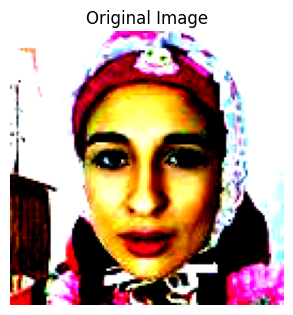

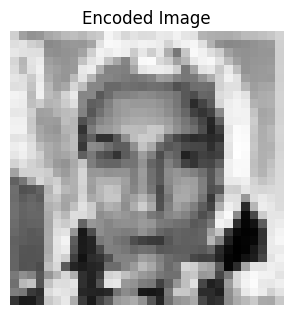

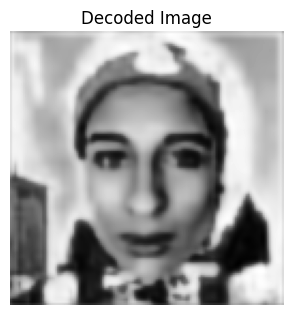

In [303]:
dispimage(input_image, "Original Image")
dispimage(s3_aftertrain.squeeze(0).detach().numpy()[2], "Encoded Image")
dispimage(output_image_aftertrain[2], "Decoded Image")

## Analyzing Model

In [304]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

847

# Comparing with traditional Variational Auto Encoder

## Encoder

In [305]:
class UNET_encoder(nn.Module):
    def __init__(self,in_channels, out_channels):
        super().__init__()
        
        self.conv_1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size = (3,3),
            padding = 1,
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=2,
            stride = 2,
        )

    def forward(self, x):
        x = self.conv_1(x)
        
        x = self.pool1(x)

        return x

In [306]:
class UNET_decoder(nn.Module):
    def __init__(self, skip_features):
        super().__init__()
        self.Dconv_1 = nn.Conv2d(
            8,
            3,
            kernel_size = (3,3),
            padding = 1,
        )

        self.ReduceChannels = nn.Conv2d(
            3,
            4,
            kernel_size=1) #Dont need this anymore but keep it just for sake of experimentation
        
        self.Dconv_2 = nn.Conv2d(
            3,
            3,
            kernel_size = (3,3),
            padding = (1,1),
        )
        
    def forward(self, x, skip_features):
        #Increase image size
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        #Make skip features match dimensions of upscaled input
        if skip_features != None:
            skip_features = nn.functional.interpolate(skip_features, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=True) #changed from bilinear to nearest and removed 'align_corners=True'
            
            x = torch.cat((x, skip_features), dim=1)

        
        x = self.Dconv_1(x)
        x = self.Dconv_2(x)
        x = self.ReduceChannels(x)

        return x

In [331]:
class UNET(nn.Module):
    def __init__(self, input_shape=(3,128,128), num_classes=1, in_channels=3, out_channels=3):
        super().__init__()

        self.encoder1 = UNET_encoder(in_channels=in_channels,out_channels=out_channels)
        self.encoder2 = UNET_encoder(in_channels=4,out_channels=out_channels) 
        # self.encoder3 = UNET_KAN_encoder(num_filters = 2)
        
        self.decoder1 = UNET_decoder(skip_features=None)
        self.decoder2 = UNET_decoder(skip_features=None)
        
        self.output_conv = nn.Conv2d(in_channels=4, out_channels=3, kernel_size=1) #Dont need again but for sake of experimentation


        # self.skip_emb1 = nn.Parameter(torch.randn(1, 12, 32, 32))
        # self.skip_emb2 = nn.Parameter(torch.randn(1, 6, 64, 64))
        # self.skip_emb3 = nn.Parameter(torch.randn(1, 3, 128, 128)) #Tried learnable skip embeddings to help decoder with images generated in latent space but didnt work

    def forward(self, x):
        print(f"Input Shape: {x.shape}")
        s1 = self.encoder1(x)
        print(f"Shape s1: {s1.shape}")
        s2 = self.encoder2(s1)
        print(f"Shape s2: {s2.shape}")
        # s3 = self.encoder3(s2)
        # print(f"Shape s3: {s3.shape}")
        
        d1 = self.decoder1(s2, s1)
        print(f"Shape d1: {d1.shape}")
        d2 = self.decoder2(d1, s2)
        print(f"Shape d2: {d2.shape}")
        # d3 = self.decoder3(d2, s3)
        # print(f"Shape d3: {d3.shape}")
        
        outputs = self.output_conv(d2)
        print(f"Output Shape: {outputs.shape}")
        return outputs, s2

    def encoding_block(self, x):
        with torch.no_grad():
            s1 = self.encoder1(x)
            s2 = self.encoder2(s1)
            # s3 = self.encoder3(s2)
        return s2

    def decoding_block(self, x):
        with torch.no_grad():
            print(f'Input shape: {x.shape}')
            d1 = self.decoder1(x, skipemb[0])
            print(f'd1 shape: {d1.shape}')
            d2 = self.decoder2(d1, skipemb[1])
            print(f'd2 shape: {d2.shape}')
            # d3 = self.decoder3(d2, skipemb[2])
            # print(f'd1 shape: {d3.shape}')
            output = self.output_conv(d2)
        return output

In [332]:
baseline_model = UNET(input_shape=(3, 128, 128), out_channels=4)

In [333]:
params = sum(p.numel() for p in baseline_model.parameters() if p.requires_grad == True)
params

913

In [334]:
test, s2 = baseline_model(input_tensor)

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


In [335]:
test.shape

torch.Size([1, 3, 128, 128])

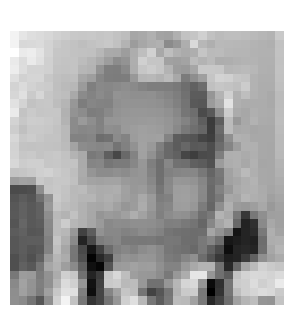

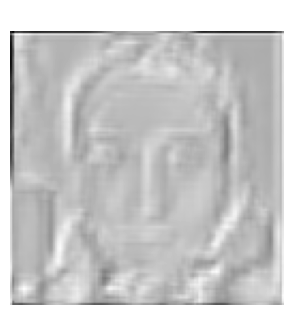

In [336]:
dispimage(s2)
dispimage(test)

In [357]:
epochs=100

In [358]:
print(f"Training on {device}")
criterion = nn.MSELoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.01)

Training on cpu


In [359]:
losses = []
for epoch in range(epochs):
    baseline_model.train()
    running_loss = 0.0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}"):
        inputs = batch  # No labels, only images
        inputs = inputs.to(device)

        
        outputs, _ = baseline_model(inputs)

        
        loss = criterion(outputs, inputs)

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f"IMAGE LOSS: {loss.item()}")


    
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(dataloader):.4f}")
    losses.append(running_loss/len(dataloader))
    torch.save(model.state_dict(), 'BASELINE_Encoder_Decoder_model_weights.pth') #In case kernel dies

Epoch 1/100:  10%|██▊                          | 10/101 [00:00<00:01, 49.28it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005820289254188538
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.16672389209270477
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.030517689883708954
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 1/100:  18%|█████▏                       | 18/101 [00:00<00:01, 59.31it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03029470331966877
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03710777685046196
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.05803560093045235
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output 

Epoch 1/100:  33%|█████████▍                   | 33/101 [00:00<00:01, 67.70it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015678875148296356
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023772262036800385
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028719298541545868
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.111920066177845
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape

Epoch 1/100:  47%|█████████████▍               | 47/101 [00:00<00:00, 67.71it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03360886871814728
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.047880008816719055
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.05206708237528801
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 1/100:  62%|██████████████████           | 63/101 [00:00<00:00, 72.08it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03883912041783333
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015628235414624214
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008778560906648636
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01869458705186844
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 1/100:  78%|██████████████████████▋      | 79/101 [00:01<00:00, 71.26it/s]

IMAGE LOSS: 0.019296938553452492
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016160542145371437
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019256507977843285
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018225213512778282
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 1/100:  94%|███████████████████████████▎ | 95/101 [00:01<00:00, 72.16it/s]

IMAGE LOSS: 0.011891144327819347
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02218942530453205
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010873069055378437
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020685961470007896
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 1/100: 100%|████████████████████████████| 101/101 [00:01<00:00, 67.76it/s]


IMAGE LOSS: 0.012070422060787678
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0133195286616683
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00790965836495161
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028978267684578896
Epoch [1/100], Loss: 0.0271


Epoch 2/100:   8%|██▍                           | 8/101 [00:00<00:01, 70.15it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013679317198693752
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02689063549041748
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01727941446006298
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 2/100:  23%|██████▌                      | 23/101 [00:00<00:01, 68.42it/s]

IMAGE LOSS: 0.01072639599442482
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010019148699939251
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013701513409614563
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008123974315822124
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 2/100:  37%|██████████▌                  | 37/101 [00:00<00:00, 68.45it/s]

IMAGE LOSS: 0.028400829061865807
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009847667999565601
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014593780040740967
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017823120579123497
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 2/100:  51%|██████████████▉              | 52/101 [00:00<00:00, 69.57it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014617964625358582
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01457491610199213
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.041647057980298996
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006671597715467215
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 2/100:  66%|███████████████████▏         | 67/101 [00:00<00:00, 70.13it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015285192988812923
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021102124825119972
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010640658438205719
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019540036097168922
Input S

Epoch 2/100:  74%|█████████████████████▌       | 75/101 [00:01<00:00, 70.45it/s]

IMAGE LOSS: 0.01429144386202097
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01994253881275654
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017269859090447426
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012448552064597607
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 2/100:  82%|███████████████████████▊     | 83/101 [00:01<00:00, 69.63it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019795486703515053
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009573735296726227
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011160832829773426
Input Shape: torch.Size([1, 3, 128, 128])


Epoch 2/100:  90%|██████████████████████████▏  | 91/101 [00:01<00:00, 70.32it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010167804546654224
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012778232805430889
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011204992420971394
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 2/100: 100%|████████████████████████████| 101/101 [00:01<00:00, 69.14it/s]


IMAGE LOSS: 0.009364214725792408
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01276473794132471
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021425485610961914
Epoch [2/100], Loss: 0.0149


Epoch 3/100:   8%|██▍                           | 8/101 [00:00<00:01, 73.04it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005672372877597809
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013084459118545055
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006748795509338379
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 3/100:  16%|████▌                        | 16/101 [00:00<00:01, 66.82it/s]

IMAGE LOSS: 0.009389039129018784
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011271881870925426
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00862133875489235
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008708921261131763
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 3/100:  23%|██████▌                      | 23/101 [00:00<00:01, 67.88it/s]

IMAGE LOSS: 0.0140842841938138
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008850802667438984
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006020752247422934
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003772510914131999
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 3/100:  31%|████████▉                    | 31/101 [00:00<00:00, 70.00it/s]

IMAGE LOSS: 0.00750738987699151
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007772557437419891
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004959908779710531
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013784465380012989
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 3/100:  39%|███████████▏                 | 39/101 [00:00<00:00, 71.11it/s]

IMAGE LOSS: 0.013495448976755142
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00343380868434906
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008446735329926014
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028673283755779266
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 3/100:  47%|█████████████▍               | 47/101 [00:00<00:00, 71.76it/s]

IMAGE LOSS: 0.011168665252625942
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008565097115933895
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00856142956763506
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04041166976094246
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 3/100:  54%|███████████████▊             | 55/101 [00:00<00:00, 71.12it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010471668094396591
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02012418769299984
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009169246070086956
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01054768729954958
Input Shape: torch.Size([1, 3, 128, 128])
Shap

Epoch 3/100:  62%|██████████████████           | 63/101 [00:00<00:00, 71.81it/s]

IMAGE LOSS: 0.010695397853851318
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014398865401744843
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005197289399802685
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006686518434435129
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 3/100:  70%|████████████████████▍        | 71/101 [00:01<00:00, 71.14it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008078981190919876
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016978252679109573
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 3/100:  78%|██████████████████████▋      | 79/101 [00:01<00:00, 70.06it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006538316607475281
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009626668877899647
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009015798568725586
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012132257223129272
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 3/100:  86%|████████████████████████▉    | 87/101 [00:01<00:00, 63.58it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0059087867848575115
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008448547683656216
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.024953065440058708
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017649224027991295
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 3/100:  93%|██████████████████████████▉  | 94/101 [00:01<00:00, 59.85it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00844165775924921
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 3/100: 100%|████████████████████████████| 101/101 [00:01<00:00, 65.66it/s]


IMAGE LOSS: 0.009592065587639809
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007781520951539278
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0025743418373167515
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005230566952377558
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 4/100:   0%|                                      | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005075562745332718
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006523075047880411
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004307199269533157
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 4/100:   8%|██▍                           | 8/101 [00:00<00:01, 74.14it/s]

IMAGE LOSS: 0.014479328878223896
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012259427458047867
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004033116158097982
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005463177803903818
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 4/100:  17%|████▉                        | 17/101 [00:00<00:01, 76.36it/s]

IMAGE LOSS: 0.004992856178432703
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0037087630480527878
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005956078413873911
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007855329662561417
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 4/100:  25%|███████▏                     | 25/101 [00:00<00:01, 74.77it/s]

IMAGE LOSS: 0.00897339079529047
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010361690074205399
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005143654067069292
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008584791794419289
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 4/100:  33%|█████████▍                   | 33/101 [00:00<00:00, 72.59it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007033441681414843
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014105689711868763
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008570545352995396
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016864242032170296
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 4/100:  41%|███████████▊                 | 41/101 [00:00<00:00, 72.44it/s]

IMAGE LOSS: 0.0163284819573164
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006141036748886108
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012808459810912609
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010203964076936245
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 4/100:  49%|██████████████               | 49/101 [00:00<00:00, 65.82it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00834131520241499
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0027850980404764414
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 4/100:  55%|████████████████             | 56/101 [00:00<00:00, 62.65it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007500059902667999
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005018285010010004
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00741053931415081
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00947678741067648
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 4/100:  62%|██████████████████           | 63/101 [00:00<00:00, 63.60it/s]

IMAGE LOSS: 0.015174525789916515
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007699351292103529
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.033323850482702255
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013440406881272793
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 4/100:  69%|████████████████████         | 70/101 [00:01<00:00, 64.24it/s]

IMAGE LOSS: 0.012449427507817745
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008814840577542782
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009838040918111801
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01675308495759964
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 4/100:  76%|██████████████████████       | 77/101 [00:01<00:00, 63.85it/s]

IMAGE LOSS: 0.0072203450836241245
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007404344156384468
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016232101246714592
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.025479121133685112
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 4/100:  84%|████████████████████████▍    | 85/101 [00:01<00:00, 66.33it/s]

IMAGE LOSS: 0.016274670138955116
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012511022388935089
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02367290109395981
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014971520751714706
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 4/100:  92%|██████████████████████████▋  | 93/101 [00:01<00:00, 68.16it/s]

IMAGE LOSS: 0.015909522771835327
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008753997273743153
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016709377989172935
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013698386959731579
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 4/100: 100%|████████████████████████████| 101/101 [00:01<00:00, 70.48it/s]

IMAGE LOSS: 0.013378366827964783
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007573435083031654
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013953442685306072


Epoch 4/100: 100%|████████████████████████████| 101/101 [00:01<00:00, 68.31it/s]


Epoch [4/100], Loss: 0.0119


Epoch 5/100:   0%|                                      | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008898611180484295
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006117037031799555
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010181550867855549
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 5/100:   7%|██                            | 7/101 [00:00<00:01, 69.99it/s]

IMAGE LOSS: 0.008757504634559155
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013594619929790497
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013640493154525757
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014713850803673267
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 5/100:  15%|████▎                        | 15/101 [00:00<00:01, 69.80it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008616912178695202
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008812716230750084
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012757990509271622
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006879068911075592
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 5/100:  23%|██████▌                      | 23/101 [00:00<00:01, 71.30it/s]

Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008904322050511837
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011994305066764355
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012451358139514923
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0089780418202281
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape 

Epoch 5/100:  31%|████████▉                    | 31/101 [00:00<00:00, 70.40it/s]

IMAGE LOSS: 0.00893988087773323
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017965571954846382
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0037712671328336
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00827785860747099
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torc

Epoch 5/100:  39%|███████████▏                 | 39/101 [00:00<00:00, 72.43it/s]

IMAGE LOSS: 0.014533765614032745
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011032859794795513
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008559003472328186
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009346723556518555
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 5/100:  47%|█████████████▍               | 47/101 [00:00<00:00, 70.71it/s]

IMAGE LOSS: 0.025836244225502014
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013848933391273022
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00486769387498498
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009148292243480682
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 5/100:  54%|███████████████▊             | 55/101 [00:00<00:00, 71.45it/s]

IMAGE LOSS: 0.004856436047703028
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009877228178083897
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005783043336123228
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.033377837389707565
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 5/100:  62%|██████████████████           | 63/101 [00:00<00:00, 69.32it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013324007391929626
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015754831954836845
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014497578144073486
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009209965355694294
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 5/100:  70%|████████████████████▍        | 71/101 [00:00<00:00, 71.50it/s]

IMAGE LOSS: 0.004119673278182745
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005592727568000555
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0054477364756166935
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005922310054302216
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 5/100:  78%|██████████████████████▋      | 79/101 [00:01<00:00, 70.17it/s]

IMAGE LOSS: 0.009669170714914799
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011772398836910725
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006500372663140297
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0034817729610949755
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 5/100:  86%|████████████████████████▉    | 87/101 [00:01<00:00, 71.98it/s]

IMAGE LOSS: 0.012994718737900257
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009684608317911625
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010159961879253387
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020984800532460213
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 5/100:  94%|███████████████████████████▎ | 95/101 [00:01<00:00, 72.17it/s]

IMAGE LOSS: 0.041072290390729904
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021952064707875252
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006167928222566843
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005393570754677057
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 5/100: 100%|████████████████████████████| 101/101 [00:01<00:00, 71.14it/s]


IMAGE LOSS: 0.011571141891181469
Epoch [5/100], Loss: 0.0110


Epoch 6/100:   0%|                                      | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016900725662708282
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007976141758263111
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006757020950317383
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 6/100:   8%|██▍                           | 8/101 [00:00<00:01, 74.09it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02888479270040989
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004433144815266132
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006541010458022356
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003959877882152796
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 6/100:  16%|████▌                        | 16/101 [00:00<00:01, 73.02it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00581987202167511
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011607673950493336
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010814815759658813
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 6/100:  24%|██████▉                      | 24/101 [00:00<00:01, 73.08it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010882847011089325
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006264142692089081
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.024138176813721657
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010399180464446545
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 6/100:  32%|█████████▏                   | 32/101 [00:00<00:00, 72.09it/s]

IMAGE LOSS: 0.007823594845831394
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010793465189635754
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004266812931746244
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006962690502405167
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 6/100:  40%|███████████▍                 | 40/101 [00:00<00:00, 71.50it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010015391744673252
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004818261135369539
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00287272478453815
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004485683981329203
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 6/100:  48%|█████████████▊               | 48/101 [00:00<00:00, 72.28it/s]

IMAGE LOSS: 0.014868439175188541
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005173413548618555
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006686458829790354
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013180489651858807


Epoch 6/100:  55%|████████████████             | 56/101 [00:00<00:00, 73.89it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006465910468250513
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011868540197610855
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.030737504363059998
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 6/100:  71%|████████████████████▋        | 72/101 [00:00<00:00, 72.98it/s]

IMAGE LOSS: 0.0140199800953269
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002645440399646759
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005740575958043337
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0059107826091349125
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 6/100:  87%|█████████████████████████▎   | 88/101 [00:01<00:00, 73.14it/s]

IMAGE LOSS: 0.0047736638225615025
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004128552507609129
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014536513946950436
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011175823397934437
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 6/100: 100%|████████████████████████████| 101/101 [00:01<00:00, 72.83it/s]


IMAGE LOSS: 0.005756290629506111
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00479935621842742
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010510238818824291
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008644476532936096
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 7/100:   0%|                                      | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006558852270245552
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003922094125300646
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007206905633211136
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 7/100:   8%|██▍                           | 8/101 [00:00<00:01, 69.25it/s]

IMAGE LOSS: 0.008611387573182583
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00855125393718481
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0078068748116493225
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006633149925619364
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 7/100:  16%|████▌                        | 16/101 [00:00<00:01, 72.56it/s]

IMAGE LOSS: 0.006887896452099085
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004593398422002792
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011662017554044724
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01266797911375761
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 7/100:  24%|██████▉                      | 24/101 [00:00<00:01, 70.88it/s]

IMAGE LOSS: 0.011992928571999073
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006145162973552942
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005128204822540283
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006228963378816843
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 7/100:  32%|█████████▏                   | 32/101 [00:00<00:00, 71.92it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008127246052026749
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006825478281825781
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007513219956308603
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010658115148544312
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 7/100:  40%|███████████▍                 | 40/101 [00:00<00:00, 71.28it/s]

Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006904378533363342
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008894004859030247
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00785159319639206
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029206229373812675
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape

Epoch 7/100:  48%|█████████████▊               | 48/101 [00:00<00:00, 70.79it/s]

IMAGE LOSS: 0.006948992609977722
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0034765079617500305
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01591593213379383
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013506089337170124
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 7/100:  55%|████████████████             | 56/101 [00:00<00:00, 71.11it/s]

IMAGE LOSS: 0.005956368520855904
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010552884079515934
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014318850822746754
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0144583061337471
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 7/100:  63%|██████████████████▍          | 64/101 [00:00<00:00, 70.06it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007775469217449427
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010620101355016232
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013302244246006012
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00832605641335249
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 7/100:  71%|████████████████████▋        | 72/101 [00:01<00:00, 71.94it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011868235655128956
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.043346237391233444
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006494481582194567
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00520340958610177
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 7/100:  79%|██████████████████████▉      | 80/101 [00:01<00:00, 71.51it/s]

IMAGE LOSS: 0.004680080804973841
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006785607431083918
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004372777417302132
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00599679397419095
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 7/100:  87%|█████████████████████████▎   | 88/101 [00:01<00:00, 72.00it/s]

IMAGE LOSS: 0.010743324644863605
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009578241966664791
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01033269613981247
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00772830517962575
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 7/100: 100%|████████████████████████████| 101/101 [00:01<00:00, 71.58it/s]


IMAGE LOSS: 0.01602097414433956
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0058857761323452
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005574672017246485
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011155535466969013
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 8/100:   0%|                                      | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011716770939528942
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009122162126004696
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005333287641406059
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 8/100:   7%|██                            | 7/101 [00:00<00:01, 69.58it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016214439645409584
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0059811812825500965
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02085619606077671
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013501708395779133
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 8/100:  15%|████▎                        | 15/101 [00:00<00:01, 73.08it/s]

IMAGE LOSS: 0.003926076460629702
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009283270686864853
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013292734511196613
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010548395104706287
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 8/100:  23%|██████▌                      | 23/101 [00:00<00:01, 72.30it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008699937723577023
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009803478606045246
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020245708525180817
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0348513089120388
Input Shape: torch.Size([1, 3, 128, 128])
Shap

Epoch 8/100:  31%|████████▉                    | 31/101 [00:00<00:01, 67.40it/s]

IMAGE LOSS: 0.020298900082707405
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03113165684044361
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013551414012908936
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012279268354177475
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 8/100:  38%|██████████▉                  | 38/101 [00:00<00:00, 66.58it/s]

IMAGE LOSS: 0.009057323448359966
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01197514683008194
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010081992484629154
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008391805924475193
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 8/100:  46%|█████████████▏               | 46/101 [00:00<00:00, 69.09it/s]

IMAGE LOSS: 0.010154351592063904
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012316768057644367
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01764500141143799
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014568534679710865
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 8/100:  53%|███████████████▌             | 54/101 [00:00<00:00, 70.15it/s]

IMAGE LOSS: 0.0772528350353241
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02524934522807598
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017608577385544777
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02435884065926075
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torc

Epoch 8/100:  61%|█████████████████▊           | 62/101 [00:00<00:00, 68.45it/s]

IMAGE LOSS: 0.028427748009562492
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013929185457527637
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028754333034157753
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01648678071796894
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 8/100:  68%|███████████████████▊         | 69/101 [00:01<00:00, 68.50it/s]

IMAGE LOSS: 0.010476048104465008
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0322892926633358
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014895417727530003
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03761095926165581
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 8/100:  75%|█████████████████████▊       | 76/101 [00:01<00:00, 68.83it/s]

IMAGE LOSS: 0.05547484755516052
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04848054051399231
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04124020040035248
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03762757405638695
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torc

Epoch 8/100:  83%|████████████████████████     | 84/101 [00:01<00:00, 70.24it/s]

IMAGE LOSS: 0.03012523241341114
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03845991566777229
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03887421265244484
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.037506237626075745
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 8/100:  91%|██████████████████████████▍  | 92/101 [00:01<00:00, 69.18it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028456201776862144
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.022183196619153023
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04740693047642708
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016223689541220665
Input Sh

Epoch 8/100: 100%|████████████████████████████| 101/101 [00:01<00:00, 69.12it/s]


Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018938450142741203
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01671990193426609
Epoch [8/100], Loss: 0.0219


Epoch 9/100:   0%|                                      | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007899332791566849
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01076809223741293
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])


Epoch 9/100:   7%|██                            | 7/101 [00:00<00:01, 68.37it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018184570595622063
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.046036940068006516
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.030819274485111237
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02365717850625515
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 9/100:  15%|████▎                        | 15/101 [00:00<00:01, 68.89it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023955680429935455
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014260582625865936
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018956229090690613
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014458863995969296
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 9/100:  22%|██████▎                      | 22/101 [00:00<00:01, 69.20it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011521220207214355
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014468546025454998
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012489822693169117
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017638223245739937
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 9/100:  29%|████████▎                    | 29/101 [00:00<00:01, 68.86it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014915983192622662
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007181457709521055
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009414986707270145
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013509373180568218
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 9/100:  36%|██████████▎                  | 36/101 [00:00<00:00, 68.01it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008272620849311352
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0076173157431185246
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019487665966153145
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Out

Epoch 9/100:  44%|████████████▋                | 44/101 [00:00<00:00, 68.92it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01198171079158783
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014312230050563812
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.035616565495729446
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011387492530047894
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 9/100:  51%|██████████████▉              | 52/101 [00:00<00:00, 69.77it/s]

IMAGE LOSS: 0.012057636864483356
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010335407219827175
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007279614452272654
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004665907938033342
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 9/100:  58%|████████████████▉            | 59/101 [00:00<00:00, 68.38it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010039341636002064
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006223537027835846
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0066864765249192715
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004245281685143709
Input 

Epoch 9/100:  66%|███████████████████▏         | 67/101 [00:00<00:00, 70.69it/s]

IMAGE LOSS: 0.02950318716466427
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008747355081140995
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01566067896783352
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007220964878797531
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 9/100:  74%|█████████████████████▌       | 75/101 [00:01<00:00, 71.67it/s]

IMAGE LOSS: 0.03827672824263573
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006793323904275894
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01139018777757883
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004999346565455198
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 9/100:  82%|███████████████████████▊     | 83/101 [00:01<00:00, 70.91it/s]

IMAGE LOSS: 0.005517211277037859
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014954842627048492
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00606565410271287
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011986997909843922
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 9/100:  90%|██████████████████████████▏  | 91/101 [00:01<00:00, 71.43it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006909587886184454
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016401415690779686
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006891269236803055
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0029815651942044497
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 9/100:  98%|████████████████████████████▍| 99/101 [00:01<00:00, 71.04it/s]

IMAGE LOSS: 0.010717554949223995
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008889916352927685
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006481091026216745
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 9/100: 100%|████████████████████████████| 101/101 [00:01<00:00, 70.07it/s]


IMAGE LOSS: 0.007729755248874426
Epoch [9/100], Loss: 0.0129


Epoch 10/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007472362834960222
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0037292977795004845
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005604573991149664
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Out

Epoch 10/100:   8%|██▎                          | 8/101 [00:00<00:01, 71.57it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006312680896371603
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014881416223943233
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010541953146457672
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010146592743694782
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 10/100:  16%|████▍                       | 16/101 [00:00<00:01, 70.62it/s]

IMAGE LOSS: 0.017430344596505165
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004458263050764799
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002480033552274108
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004014431033283472
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 10/100:  24%|██████▋                     | 24/101 [00:00<00:01, 72.87it/s]

IMAGE LOSS: 0.005998493637889624
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010454460978507996
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005756712052971125
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006528722587972879
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 10/100:  32%|████████▊                   | 32/101 [00:00<00:00, 72.12it/s]

IMAGE LOSS: 0.007340427488088608
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005690412595868111
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004000904504209757
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004414727445691824
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 10/100:  40%|███████████                 | 40/101 [00:00<00:00, 73.23it/s]

IMAGE LOSS: 0.010538027621805668
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008684844709932804
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009874670766294003
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005444342736154795
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 10/100:  48%|█████████████▎              | 48/101 [00:00<00:00, 72.99it/s]

IMAGE LOSS: 0.010803434997797012
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01071329414844513
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0034548621624708176
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005337756127119064
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 10/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 73.88it/s]

IMAGE LOSS: 0.028620116412639618
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010352379642426968
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008284945972263813
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010266521014273167
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 10/100:  63%|█████████████████▋          | 64/101 [00:00<00:00, 62.73it/s]

IMAGE LOSS: 0.01894150860607624
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005361287388950586
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017139680683612823
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002431511878967285
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 10/100:  71%|███████████████████▉        | 72/101 [00:01<00:00, 66.57it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005207024049013853
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009281843900680542
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0033607184886932373
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00789676234126091
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 10/100:  79%|██████████████████████▏     | 80/101 [00:01<00:00, 68.90it/s]

IMAGE LOSS: 0.006181997712701559
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003627340542152524
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0065513476729393005
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014889084734022617
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 10/100:  87%|████████████████████████▍   | 88/101 [00:01<00:00, 68.05it/s]

IMAGE LOSS: 0.00909388903528452
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006593757774680853
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008149172179400921
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007182642351835966
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 10/100:  95%|██████████████████████████▌ | 96/101 [00:01<00:00, 70.12it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007865337654948235
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003906468395143747
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013629538007080555
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 10/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 69.94it/s]


Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029323793947696686
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0033125076442956924
Epoch [10/100], Loss: 0.0091


Epoch 11/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011437666602432728
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017228322103619576
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007311034481972456
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 11/100:   7%|██                           | 7/101 [00:00<00:01, 66.83it/s]

IMAGE LOSS: 0.005658307578414679
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006110277026891708
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009716887958347797
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006970734801143408
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 11/100:  14%|███▉                        | 14/101 [00:00<00:01, 67.83it/s]

IMAGE LOSS: 0.010998907499015331
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015766749158501625
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008554031141102314
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01339364517480135
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 11/100:  21%|█████▊                      | 21/101 [00:00<00:01, 68.40it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005524404812604189
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004691411275416613
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006282782182097435
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 11/100:  29%|████████                    | 29/101 [00:00<00:01, 68.25it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007939889095723629
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005168504547327757
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006684063468128443
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010049242526292801
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 11/100:  36%|█████████▉                  | 36/101 [00:00<00:00, 68.75it/s]

IMAGE LOSS: 0.02814842201769352
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006187901366502047
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0104264160618186
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013438701629638672
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 11/100:  43%|███████████▉                | 43/101 [00:00<00:00, 69.13it/s]

IMAGE LOSS: 0.004861806984990835
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009142772294580936
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010443073697388172
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0027874421793967485
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 11/100:  50%|██████████████▏             | 51/101 [00:00<00:00, 71.63it/s]

IMAGE LOSS: 0.006609043572098017
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01058331411331892
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004849085118621588
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004566021263599396
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 11/100:  58%|████████████████▎           | 59/101 [00:00<00:00, 70.07it/s]

IMAGE LOSS: 0.007902588695287704
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009787793271243572
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019889185205101967
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013693037442862988
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 11/100:  66%|██████████████████▌         | 67/101 [00:00<00:00, 71.31it/s]

IMAGE LOSS: 0.005753539502620697
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005123175214976072
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011138894595205784
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014363579452037811
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 11/100:  74%|████████████████████▊       | 75/101 [00:01<00:00, 71.83it/s]

IMAGE LOSS: 0.017881307750940323
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03950091823935509
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006637847516685724
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009958873502910137
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 11/100:  82%|███████████████████████     | 83/101 [00:01<00:00, 71.14it/s]

IMAGE LOSS: 0.004353322088718414
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007525051012635231
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0039157080464065075
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.026432553306221962
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 11/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 70.53it/s]

IMAGE LOSS: 0.015498094260692596
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00552297243848443
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007962026633322239
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005532382521778345
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 11/100:  98%|███████████████████████████▍| 99/101 [00:01<00:00, 69.26it/s]

IMAGE LOSS: 0.006433295551687479
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01581534743309021
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 11/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 69.72it/s]


IMAGE LOSS: 0.02179539203643799
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007979667745530605
Epoch [11/100], Loss: 0.0102


Epoch 12/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00968314427882433
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013954785652458668
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012075703591108322
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 12/100:   7%|██                           | 7/101 [00:00<00:01, 63.14it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006141388788819313
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013353460468351841
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008932413533329964
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006425186526030302
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 12/100:  14%|███▉                        | 14/101 [00:00<00:01, 58.93it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016983557492494583
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006412882823497057
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019152766093611717
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005737559404224157
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 12/100:  20%|█████▌                      | 20/101 [00:00<00:01, 59.23it/s]

IMAGE LOSS: 0.006932285148650408
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007606204599142075
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007571461144834757
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0042694867588579655
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 12/100:  27%|███████▍                    | 27/101 [00:00<00:01, 60.01it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006588550750166178
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01076152827590704
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011583603918552399
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 12/100:  34%|█████████▍                  | 34/101 [00:00<00:01, 62.57it/s]

IMAGE LOSS: 0.008015125058591366
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010691065341234207
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015487159602344036
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013243530876934528
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 12/100:  41%|███████████▎                | 41/101 [00:00<00:00, 63.57it/s]

IMAGE LOSS: 0.023857513442635536
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0032362460624426603
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006723001133650541
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009110434912145138
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 12/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 66.24it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0062783160246908665
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016551611945033073
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.026041941717267036
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IM

Epoch 12/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 67.20it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006091306451708078
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0122285857796669
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011342347599565983
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010000117123126984
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 12/100:  63%|█████████████████▋          | 64/101 [00:00<00:00, 68.49it/s]

IMAGE LOSS: 0.010595590807497501
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007695585023611784
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007139979396015406
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006178648676723242
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 12/100:  70%|███████████████████▋        | 71/101 [00:01<00:00, 68.66it/s]

IMAGE LOSS: 0.015394151210784912
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00439793523401022
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008479604497551918
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018387777730822563
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 12/100:  78%|█████████████████████▉      | 79/101 [00:01<00:00, 68.62it/s]

IMAGE LOSS: 0.01096958015114069
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005690909456461668
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015446544624865055
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011249168775975704
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 12/100:  85%|███████████████████████▊    | 86/101 [00:01<00:00, 55.53it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0059143248945474625
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009064849466085434
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014951537363231182
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 12/100:  92%|█████████████████████████▊  | 93/101 [00:01<00:00, 57.78it/s]

IMAGE LOSS: 0.00873324554413557
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004221603274345398
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007146041840314865
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0086204893887043
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 12/100:  99%|██████████████████████████▋| 100/101 [00:01<00:00, 59.59it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019216066226363182
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016587549820542336


Epoch 12/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 62.23it/s]


Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007486370857805014
Epoch [12/100], Loss: 0.0107


Epoch 13/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019228829070925713
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010447368957102299
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007998844608664513
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 13/100:   7%|██                           | 7/101 [00:00<00:01, 62.28it/s]

IMAGE LOSS: 0.003637309418991208
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008436662144958973
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006888791918754578
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01077769324183464
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 13/100:  14%|███▉                        | 14/101 [00:00<00:01, 63.74it/s]

IMAGE LOSS: 0.004843323957175016
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008904836140573025
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007381779607385397
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009911946021020412
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 13/100:  21%|█████▊                      | 21/101 [00:00<00:01, 65.03it/s]

IMAGE LOSS: 0.006433818489313126
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0035427429247647524
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010417096316814423
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0057411496527493
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 13/100:  28%|███████▊                    | 28/101 [00:00<00:01, 64.78it/s]

Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0075125680305063725
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008162365294992924
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009331467561423779
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012906680814921856
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Sha

Epoch 13/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 61.35it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004188969265669584
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005716485902667046
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004606954753398895
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015400185249745846
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 13/100:  42%|███████████▋                | 42/101 [00:00<00:00, 62.75it/s]

IMAGE LOSS: 0.028034374117851257
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006670178379863501
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010258080437779427
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01410858053714037
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 13/100:  50%|█████████████▊              | 50/101 [00:00<00:00, 65.41it/s]

IMAGE LOSS: 0.023345137014985085
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010656717233359814
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004857581574469805
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 13/100:  56%|███████████████▊            | 57/101 [00:00<00:00, 66.30it/s]

IMAGE LOSS: 0.009700865484774113
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004336899612098932
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01269368827342987
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009939593262970448
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 13/100:  63%|█████████████████▋          | 64/101 [00:00<00:00, 67.25it/s]

IMAGE LOSS: 0.007464064750820398
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010892665944993496
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0032084286212921143
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 13/100:  71%|███████████████████▉        | 72/101 [00:01<00:00, 68.54it/s]

IMAGE LOSS: 0.007635409478098154
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009069682098925114
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011411708779633045
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0075873420573771
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 13/100:  78%|█████████████████████▉      | 79/101 [00:01<00:00, 67.32it/s]

IMAGE LOSS: 0.015181840397417545
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00935301836580038
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 13/100:  86%|████████████████████████    | 87/101 [00:01<00:00, 68.64it/s]

IMAGE LOSS: 0.004370072390884161
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005999349057674408
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03433765843510628
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01248267199844122
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 13/100:  93%|██████████████████████████  | 94/101 [00:01<00:00, 67.05it/s]

IMAGE LOSS: 0.005592143628746271
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 13/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 66.41it/s]


IMAGE LOSS: 0.008034579455852509
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017104560509324074
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006448925938457251
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012346199713647366
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 14/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0058111571706831455
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015218481421470642
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004378661513328552
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Out

Epoch 14/100:   7%|██                           | 7/101 [00:00<00:01, 66.04it/s]

IMAGE LOSS: 0.005221468862146139
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009903577156364918
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010097458027303219
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008679091930389404
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 14/100:  15%|████▏                       | 15/101 [00:00<00:01, 70.53it/s]

IMAGE LOSS: 0.003936873748898506
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006431142333894968
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005626320373266935
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02167607843875885
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 14/100:  23%|██████▍                     | 23/101 [00:00<00:01, 68.44it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01217625755816698
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015172631479799747
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003982927184551954
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004933367948979139
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 14/100:  31%|████████▌                   | 31/101 [00:00<00:01, 69.02it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013496537692844868
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004528966266661882
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008372409269213676
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 14/100:  38%|██████████▌                 | 38/101 [00:00<00:00, 68.22it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009087447077035904
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007209431380033493
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006119520869106054
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 14/100:  45%|████████████▍               | 45/101 [00:00<00:00, 68.48it/s]

IMAGE LOSS: 0.005215059965848923
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0023712601978331804
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005047225393354893
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006815779954195023
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 14/100:  51%|██████████████▍             | 52/101 [00:00<00:00, 67.54it/s]

IMAGE LOSS: 0.006990662310272455
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011389301158487797
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006834115833044052
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009387155994772911
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 14/100:  58%|████████████████▎           | 59/101 [00:00<00:00, 67.21it/s]

IMAGE LOSS: 0.002687587169930339
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015412869863212109
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009339596144855022
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029037320986390114
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 14/100:  65%|██████████████████▎         | 66/101 [00:00<00:00, 66.75it/s]

IMAGE LOSS: 0.0050562103278934956
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009186085313558578
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0036320758517831564
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005860885139554739
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2

Epoch 14/100:  72%|████████████████████▏       | 73/101 [00:01<00:00, 67.16it/s]

IMAGE LOSS: 0.01041814312338829
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010792168788611889
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008999763987958431
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004888406489044428
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 14/100:  79%|██████████████████████▏     | 80/101 [00:01<00:00, 67.44it/s]

IMAGE LOSS: 0.00552957272157073
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004087375942617655
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006780450697988272
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004572064150124788
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 14/100:  86%|████████████████████████    | 87/101 [00:01<00:00, 67.75it/s]

IMAGE LOSS: 0.00939203705638647
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010174541734158993
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011835009790956974
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005666340235620737
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 14/100:  93%|██████████████████████████  | 94/101 [00:01<00:00, 66.72it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009465009905397892
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007073523011058569
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006325276102870703
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007774983998388052
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 14/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 67.52it/s]


Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0031868971418589354
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017760353162884712
Epoch [14/100], Loss: 0.0086


Epoch 15/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005435242783278227
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0073088095523417
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01342189684510231
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 15/100:   7%|██                           | 7/101 [00:00<00:01, 65.59it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013743136078119278
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010379912331700325
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00856140349060297
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003073733998462558
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 15/100:  14%|███▉                        | 14/101 [00:00<00:01, 66.33it/s]

IMAGE LOSS: 0.005227383226156235
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0033233121503144503
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0025563037488609552
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005537279415875673


Epoch 15/100:  21%|█████▊                      | 21/101 [00:00<00:01, 67.66it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004529526922851801
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006787481252104044
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004326919559389353
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 15/100:  28%|███████▊                    | 28/101 [00:00<00:01, 67.02it/s]

IMAGE LOSS: 0.01672932878136635
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008938339538872242
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010250859893858433
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006497904658317566
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 15/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 61.47it/s]

IMAGE LOSS: 0.005107388366013765
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00790137704461813
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00941024161875248
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013935745693743229
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 15/100:  42%|███████████▋                | 42/101 [00:00<00:01, 58.24it/s]


Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004375324584543705
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010808407329022884
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006177552044391632
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Out

Epoch 15/100:  48%|█████████████▎              | 48/101 [00:00<00:00, 57.50it/s]

IMAGE LOSS: 0.010865961201488972
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004755777306854725
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006560948211699724
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0034863862674683332
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 15/100:  54%|███████████████▏            | 55/101 [00:00<00:00, 59.14it/s]

IMAGE LOSS: 0.009894024580717087
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01986582763493061
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006506805773824453
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010850254446268082
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 15/100:  61%|█████████████████▏          | 62/101 [00:01<00:00, 60.64it/s]

IMAGE LOSS: 0.013703934848308563
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007629310246556997
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006580079440027475
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008018544875085354
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 15/100:  68%|███████████████████▏        | 69/101 [00:01<00:00, 61.32it/s]

IMAGE LOSS: 0.0236795824021101
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0024427666794508696
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004719231277704239
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01527161244302988
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 15/100:  75%|█████████████████████       | 76/101 [00:01<00:00, 63.59it/s]

IMAGE LOSS: 0.0168127603828907
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0159242432564497
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010375842452049255
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010086615569889545
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torc

Epoch 15/100:  82%|███████████████████████     | 83/101 [00:01<00:00, 64.63it/s]

IMAGE LOSS: 0.014628556556999683
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005020471289753914
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01066499575972557
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005312586203217506
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 15/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 66.37it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011497325263917446
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008647316135466099
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0029239559080451727
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0057451240718364716
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])


Epoch 15/100:  98%|███████████████████████████▍| 99/101 [00:01<00:00, 68.09it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004889557138085365
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009925128892064095
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005362683441489935
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003950813785195351
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 15/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 63.76it/s]


Epoch [15/100], Loss: 0.0088


Epoch 16/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01206002663820982
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006883601192384958
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009958922863006592
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 16/100:   7%|██                           | 7/101 [00:00<00:01, 66.61it/s]

IMAGE LOSS: 0.005222788546234369
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007268458604812622
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00823934655636549
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007170757278800011
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 16/100:  15%|████▏                       | 15/101 [00:00<00:01, 69.56it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005962945520877838
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012609909288585186
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008714902214705944
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 16/100:  22%|██████                      | 22/101 [00:00<00:01, 68.83it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005656638648360968
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009884362109005451
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0031042618211358786
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IM

Epoch 16/100:  29%|████████                    | 29/101 [00:00<00:01, 68.95it/s]

IMAGE LOSS: 0.0047248853370547295
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0032102474942803383
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005126680713146925
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0072197155095636845
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d

Epoch 16/100:  36%|█████████▉                  | 36/101 [00:00<00:00, 68.88it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004316031467169523
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009071805514395237
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004026809241622686
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 16/100:  44%|████████████▏               | 44/101 [00:00<00:00, 69.63it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005307888146489859
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008995209820568562
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008353344164788723
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 16/100:  50%|██████████████▏             | 51/101 [00:00<00:00, 68.89it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029955781996250153
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.033940743654966354
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003481681225821376
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 16/100:  57%|████████████████            | 58/101 [00:00<00:00, 68.47it/s]

IMAGE LOSS: 0.00634011859074235
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0038888920098543167
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0038502903189510107
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009990129619836807
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 16/100:  64%|██████████████████          | 65/101 [00:00<00:00, 68.45it/s]

IMAGE LOSS: 0.010982882231473923
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004387483466416597
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004395043011754751
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014522240497171879
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 16/100:  71%|███████████████████▉        | 72/101 [00:01<00:00, 68.14it/s]

IMAGE LOSS: 0.012762906961143017
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0060739717446267605
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008007369935512543
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005375417415052652
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 16/100:  78%|█████████████████████▉      | 79/101 [00:01<00:00, 67.67it/s]

IMAGE LOSS: 0.010963566601276398
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02492525987327099
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00507335877045989
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0054024383425712585
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 16/100:  86%|████████████████████████    | 87/101 [00:01<00:00, 69.43it/s]

IMAGE LOSS: 0.02402368374168873
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006306263152509928
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014210696332156658
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0121888043358922
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 16/100:  93%|██████████████████████████  | 94/101 [00:01<00:00, 68.37it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00557510694488883
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005074032582342625
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008916127495467663
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 16/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 68.52it/s]


IMAGE LOSS: 0.007851412519812584
Epoch [16/100], Loss: 0.0090


Epoch 17/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003389130113646388
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0027449375484138727
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009678004309535027
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])


Epoch 17/100:   8%|██▎                          | 8/101 [00:00<00:01, 70.99it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0058943722397089005
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004260799381881952
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016016071662306786
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002971170237287879
Input Shape: torch.Size([1, 3, 128, 128])
S

Epoch 17/100:  16%|████▍                       | 16/101 [00:00<00:01, 67.84it/s]

IMAGE LOSS: 0.004558460786938667
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006343381945043802
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0031252943444997072
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006599755957722664
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])


Epoch 17/100:  24%|██████▋                     | 24/101 [00:00<00:01, 72.55it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0053215851075947285
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009925438091158867
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011303093284368515
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012417302466928959
Input Shape: torch.Size([1, 3, 128, 128])
S

Epoch 17/100:  32%|████████▊                   | 32/101 [00:00<00:01, 68.03it/s]

IMAGE LOSS: 0.016750602051615715
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0058313594199717045
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009281625039875507
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005336059723049402
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 17/100:  40%|███████████                 | 40/101 [00:00<00:00, 69.89it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011108634062111378
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01625462807714939
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023071831092238426
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 17/100:  48%|█████████████▎              | 48/101 [00:00<00:00, 69.82it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005026970524340868
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0149812838062644
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005000104662030935
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007767787668853998
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 17/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 69.62it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01266421377658844
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009197487495839596
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003096870146691799
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011416714638471603
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 17/100:  62%|█████████████████▍          | 63/101 [00:00<00:00, 69.26it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.032418880611658096
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0045621260069310665
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010438946075737476
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008043378591537476
Input 

Epoch 17/100:  70%|███████████████████▋        | 71/101 [00:01<00:00, 70.06it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0312679149210453
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0062209442257881165
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005733311641961336
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02982749044895172
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 17/100:  78%|█████████████████████▉      | 79/101 [00:01<00:00, 69.80it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01037676353007555
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004507127217948437
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005490937735885382
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018516799435019493
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 17/100:  85%|███████████████████████▊    | 86/101 [00:01<00:00, 69.23it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007663471158593893
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00836099497973919
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011656955815851688
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])


Epoch 17/100:  92%|█████████████████████████▊  | 93/101 [00:01<00:00, 67.57it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009743173606693745
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0066605620086193085
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01036845613270998
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008323956280946732
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 17/100:  99%|██████████████████████████▋| 100/101 [00:01<00:00, 66.87it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004419249948114157
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011346538551151752
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 17/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 68.68it/s]


Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008207016624510288
Epoch [17/100], Loss: 0.0092


Epoch 18/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006023526657372713
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01587630994617939
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014558550901710987
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 18/100:   7%|██                           | 7/101 [00:00<00:01, 69.72it/s]

IMAGE LOSS: 0.0038611330091953278
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.025678390637040138
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011603757739067078
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005651058629155159
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 18/100:  14%|███▉                        | 14/101 [00:00<00:01, 67.38it/s]

IMAGE LOSS: 0.004501625429838896
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018826423212885857
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004525292199105024
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005421116948127747
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 18/100:  22%|██████                      | 22/101 [00:00<00:01, 68.27it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004245029762387276
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013922031037509441
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011397610418498516
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005513701122254133
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 18/100:  29%|████████                    | 29/101 [00:00<00:01, 68.22it/s]

IMAGE LOSS: 0.006947824731469154
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01769755221903324
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008193913847208023
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011412526480853558
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 18/100:  37%|██████████▎                 | 37/101 [00:00<00:00, 68.74it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007307641673833132
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006542306859046221
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013916301541030407
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 18/100:  45%|████████████▍               | 45/101 [00:00<00:00, 69.99it/s]

IMAGE LOSS: 0.0057089864276349545
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006200892385095358
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007802779320627451
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023327061906456947
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 18/100:  51%|██████████████▍             | 52/101 [00:00<00:00, 68.12it/s]

IMAGE LOSS: 0.009271378628909588
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004515706095844507
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005711094941943884
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007084073033183813
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 18/100:  58%|████████████████▎           | 59/101 [00:00<00:00, 68.18it/s]

IMAGE LOSS: 0.0046170256100595
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011288811452686787
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005935030058026314
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0029193025548011065
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 18/100:  66%|██████████████████▌         | 67/101 [00:00<00:00, 69.46it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011796670965850353
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006511619780212641
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014688755385577679
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005239196587353945
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 18/100:  73%|████████████████████▌       | 74/101 [00:01<00:00, 69.26it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0075467415153980255
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006306672468781471
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007166916038841009
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004455231595784426
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 18/100:  80%|██████████████████████▍     | 81/101 [00:01<00:00, 69.19it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006534765008836985
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014399535953998566
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004074583295732737
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008460039272904396
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 18/100:  88%|████████████████████████▋   | 89/101 [00:01<00:00, 70.07it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005706358700990677
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004810135345906019
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002807316603139043
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006278119515627623
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 18/100:  96%|██████████████████████████▉ | 97/101 [00:01<00:00, 69.22it/s]

IMAGE LOSS: 0.010379467159509659
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015168488025665283
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009533955715596676
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 18/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 68.83it/s]


Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006441912148147821
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007668779697269201
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011334921233355999
Epoch [18/100], Loss: 0.0095


Epoch 19/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010202399455010891
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00760616734623909
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00721376808360219
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 19/100:   8%|██▎                          | 8/101 [00:00<00:01, 72.74it/s]

IMAGE LOSS: 0.012045718729496002
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013350297696888447
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021785074844956398
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012106341309845448
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 19/100:  16%|████▍                       | 16/101 [00:00<00:01, 68.68it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009777222760021687
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009325459599494934
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005551524460315704
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015734197571873665
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 19/100:  23%|██████▍                     | 23/101 [00:00<00:01, 69.07it/s]

IMAGE LOSS: 0.0074390931986272335
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01870349980890751
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005239330232143402
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00730910012498498
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 19/100:  30%|████████▎                   | 30/101 [00:00<00:01, 68.83it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007509011309593916
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005500651430338621
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006575076375156641
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 19/100:  37%|██████████▎                 | 37/101 [00:00<00:00, 68.20it/s]

IMAGE LOSS: 0.010158107616007328
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014988970942795277
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011444383300840855
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03427198529243469
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 19/100:  44%|████████████▏               | 44/101 [00:00<00:00, 67.83it/s]

IMAGE LOSS: 0.00495508499443531
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012258264236152172
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004194480832666159
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004725943319499493
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 19/100:  51%|██████████████▍             | 52/101 [00:00<00:00, 69.52it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00930876936763525
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0031709421891719103
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004051014315336943
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004386689513921738
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 19/100:  58%|████████████████▎           | 59/101 [00:00<00:00, 68.86it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008641993626952171
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009747692383825779
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010132022202014923
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008342531509697437
Input S

Epoch 19/100:  65%|██████████████████▎         | 66/101 [00:00<00:00, 68.96it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016117485240101814
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0048157465644180775
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03765714541077614
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009596290998160839
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 19/100:  73%|████████████████████▌       | 74/101 [00:01<00:00, 69.41it/s]

IMAGE LOSS: 0.006021525710821152
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00634239474311471
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015619054436683655
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028433119878172874
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 19/100:  80%|██████████████████████▍     | 81/101 [00:01<00:00, 68.75it/s]

IMAGE LOSS: 0.006309085991233587
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009539196267724037
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0037479314487427473
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006252069026231766
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 19/100:  87%|████████████████████████▍   | 88/101 [00:01<00:00, 68.29it/s]

IMAGE LOSS: 0.009959197603166103
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007169241085648537
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009217401035130024
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011697032488882542
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 19/100:  95%|██████████████████████████▌ | 96/101 [00:01<00:00, 69.44it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006834637839347124
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003771834773942828
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002756251022219658
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029658010229468346
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 19/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 68.88it/s]


Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02095690928399563
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00997150782495737
Epoch [19/100], Loss: 0.0094


Epoch 20/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029404332861304283
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00977424718439579
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011178773827850819
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 20/100:   7%|██                           | 7/101 [00:00<00:01, 65.02it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015061554498970509
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0075843557715415955
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028435995802283287
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006839077919721603
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 20/100:  15%|████▏                       | 15/101 [00:00<00:01, 67.47it/s]

IMAGE LOSS: 0.005111523438245058
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012827468104660511
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012793458066880703
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004056894686073065
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 20/100:  22%|██████                      | 22/101 [00:00<00:01, 67.67it/s]

IMAGE LOSS: 0.017293056473135948
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009954732842743397
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00529304938390851
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008586167357861996
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 20/100:  29%|████████                    | 29/101 [00:00<00:01, 67.09it/s]

IMAGE LOSS: 0.006027732044458389
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0365387462079525
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0055610425770282745
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003015764756128192
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 20/100:  36%|█████████▉                  | 36/101 [00:00<00:00, 66.14it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006190981715917587
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007526468951255083
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02030942402780056
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAG

Epoch 20/100:  43%|███████████▉                | 43/101 [00:00<00:00, 65.89it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01426029670983553
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005205225199460983
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004640333820134401
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007197210099548101
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 20/100:  50%|█████████████▊              | 50/101 [00:00<00:00, 66.81it/s]

IMAGE LOSS: 0.008374540135264397
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008969745598733425
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004471573978662491
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004429006949067116
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 20/100:  56%|███████████████▊            | 57/101 [00:00<00:00, 66.38it/s]

IMAGE LOSS: 0.014708374626934528
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007622142788022757
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005512458737939596
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005717503372579813
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 20/100:  63%|█████████████████▋          | 64/101 [00:00<00:00, 66.31it/s]

Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009047853760421276
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004721174016594887
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0032331887632608414
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012363101355731487
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Sha

Epoch 20/100:  70%|███████████████████▋        | 71/101 [00:01<00:00, 65.60it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004558855202049017
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005019366275519133
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005509781185537577
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 20/100:  78%|█████████████████████▉      | 79/101 [00:01<00:00, 67.70it/s]

IMAGE LOSS: 0.013673407025635242
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0065999943763017654
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008961869403719902
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007009744644165039
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 20/100:  85%|███████████████████████▊    | 86/101 [00:01<00:00, 66.12it/s]

IMAGE LOSS: 0.0057319290935993195
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007436210289597511
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007151917088776827
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006670694798231125
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 20/100:  93%|██████████████████████████  | 94/101 [00:01<00:00, 67.85it/s]

IMAGE LOSS: 0.004742856603115797
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002736240392550826
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012001982890069485
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008174575865268707
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 20/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 67.02it/s]


IMAGE LOSS: 0.01031303871423006
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009671065956354141
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009935199283063412
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010206869803369045
Epoch [20/100], Loss: 0.0083


Epoch 21/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006831647828221321
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005211879964917898
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008193343877792358
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 21/100:   8%|██▎                          | 8/101 [00:00<00:01, 72.12it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005480966996401548
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009363986551761627
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02866438962519169
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 21/100:  16%|████▍                       | 16/101 [00:00<00:01, 69.46it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0064634582959115505
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0050631240010261536
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005089833401143551
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007280607242137194
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])


Epoch 21/100:  23%|██████▍                     | 23/101 [00:00<00:01, 69.68it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0037258167285472155
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004891627002507448
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002628192538395524
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0023759515024721622
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])


Epoch 21/100:  30%|████████▎                   | 30/101 [00:00<00:01, 68.28it/s]

IMAGE LOSS: 0.003530837595462799
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0037979602348059416
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020892849192023277
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004115855786949396
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 21/100:  37%|██████████▎                 | 37/101 [00:00<00:00, 67.01it/s]

IMAGE LOSS: 0.009031455032527447
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0025843670591712
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.001995005877688527
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007720945868641138
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 21/100:  44%|████████████▏               | 44/101 [00:00<00:00, 66.25it/s]

IMAGE LOSS: 0.013737961649894714
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0043714516796171665
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009927399456501007
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005112665239721537
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 21/100:  51%|██████████████▍             | 52/101 [00:00<00:00, 68.93it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005142325069755316
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006117789540439844
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02026515267789364
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009980328381061554
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 21/100:  58%|████████████████▎           | 59/101 [00:00<00:00, 69.09it/s]

IMAGE LOSS: 0.007031889166682959
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010725933127105236
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014154519885778427
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00938678253442049
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 21/100:  65%|██████████████████▎         | 66/101 [00:00<00:00, 68.96it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005585193168371916
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015029027126729488
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009320174343883991
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 21/100:  72%|████████████████████▏       | 73/101 [00:01<00:00, 68.72it/s]

IMAGE LOSS: 0.004320123698562384
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014152269810438156
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005951955448836088
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0043797604739665985
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 21/100:  79%|██████████████████████▏     | 80/101 [00:01<00:00, 68.63it/s]

IMAGE LOSS: 0.02088526450097561
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008707896806299686
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006258376408368349
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015061971731483936
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 21/100:  86%|████████████████████████    | 87/101 [00:01<00:00, 68.96it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011035551317036152
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008452694863080978
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007322337012737989
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 21/100:  93%|██████████████████████████  | 94/101 [00:01<00:00, 69.12it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008337666280567646
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006798658519983292
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012542779557406902
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006145346909761429
Input S

Epoch 21/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 68.60it/s]


IMAGE LOSS: 0.005407738033682108
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0066679432056844234
Epoch [21/100], Loss: 0.0085


Epoch 22/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007009273394942284
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004802876617759466
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008200940676033497
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 22/100:   7%|██                           | 7/101 [00:00<00:01, 64.96it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008194015361368656
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005754911806434393
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013951343484222889
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006585198920220137
Input S

Epoch 22/100:  14%|███▉                        | 14/101 [00:00<00:01, 67.17it/s]

IMAGE LOSS: 0.014787687920033932
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0054106502793729305
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010001182556152344
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007911753840744495
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 22/100:  21%|█████▊                      | 21/101 [00:00<00:01, 67.26it/s]

IMAGE LOSS: 0.005823539104312658
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.022802462801337242
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004138390999287367
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010510604828596115
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 22/100:  29%|████████                    | 29/101 [00:00<00:01, 68.74it/s]

IMAGE LOSS: 0.004209279548376799
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014635510742664337
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003610211191698909
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010401220992207527
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 22/100:  36%|█████████▉                  | 36/101 [00:00<00:00, 68.07it/s]

IMAGE LOSS: 0.006855379324406385
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0032213192898780107
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01396614033728838
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00581100070849061
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 22/100:  43%|███████████▉                | 43/101 [00:00<00:00, 68.27it/s]

IMAGE LOSS: 0.007180511951446533
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0027212565764784813
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013633880764245987
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005041478667408228
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 22/100:  50%|█████████████▊              | 50/101 [00:00<00:00, 67.98it/s]

IMAGE LOSS: 0.011136840097606182
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008178791962563992
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007437034044414759
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005144826602190733
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 22/100:  56%|███████████████▊            | 57/101 [00:00<00:00, 67.99it/s]

IMAGE LOSS: 0.008684859611093998
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02311079017817974
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004138581920415163
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0062208049930632114
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 22/100:  63%|█████████████████▋          | 64/101 [00:00<00:00, 64.50it/s]

IMAGE LOSS: 0.00535741588100791
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01540942769497633
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0117708845064044
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004242393653839827
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torc

Epoch 22/100:  70%|███████████████████▋        | 71/101 [00:01<00:00, 65.46it/s]

IMAGE LOSS: 0.011472460813820362
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0064715188927948475
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010517324320971966
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0027242216747254133
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2

Epoch 22/100:  77%|█████████████████████▌      | 78/101 [00:01<00:00, 65.47it/s]

IMAGE LOSS: 0.007231815252453089
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005194271448999643
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004727314226329327
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005933521781116724
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 22/100:  84%|███████████████████████▌    | 85/101 [00:01<00:00, 65.12it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005179494619369507
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008988301269710064
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003481711959466338
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 22/100:  91%|█████████████████████████▌  | 92/101 [00:01<00:00, 66.49it/s]

IMAGE LOSS: 0.009701428934931755
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007478984538465738
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005330624058842659
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00806363020092249
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 22/100:  98%|███████████████████████████▍| 99/101 [00:01<00:00, 66.01it/s]

IMAGE LOSS: 0.005754309240728617
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 22/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 66.44it/s]


IMAGE LOSS: 0.010982309468090534
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002616381971165538
Epoch [22/100], Loss: 0.0087


Epoch 23/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008190358988940716
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01827159710228443
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003693472594022751
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 23/100:   7%|██                           | 7/101 [00:00<00:01, 61.68it/s]

IMAGE LOSS: 0.006179800257086754
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0082777738571167
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010239788331091404
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006812783423811197
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 23/100:  14%|███▉                        | 14/101 [00:00<00:01, 63.80it/s]

IMAGE LOSS: 0.004113201517611742
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011630743741989136
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002659156918525696
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007046072278171778
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 23/100:  21%|█████▊                      | 21/101 [00:00<00:01, 65.14it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02762071043252945
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009281874634325504
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005151596385985613
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005167294759303331
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 23/100:  28%|███████▊                    | 28/101 [00:00<00:01, 62.33it/s]

IMAGE LOSS: 0.01727631501853466
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0070258998312056065
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006618630141019821
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012499682605266571
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 23/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 63.27it/s]

IMAGE LOSS: 0.01114541757851839
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007822453044354916
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00866722408682108
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013306467793881893
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 23/100:  42%|███████████▋                | 42/101 [00:00<00:00, 63.51it/s]

IMAGE LOSS: 0.013409263454377651
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0327872596681118
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009435498155653477
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008196591399610043
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 23/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 62.66it/s]

IMAGE LOSS: 0.014667744748294353
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014714591205120087
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012300614267587662
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 23/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 63.94it/s]

IMAGE LOSS: 0.012796535156667233
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01494637131690979
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009536702185869217
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005352549720555544
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 23/100:  63%|█████████████████▋          | 64/101 [00:00<00:00, 66.04it/s]

IMAGE LOSS: 0.01143305841833353
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011009640991687775
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009560422040522099
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006043416913598776
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 23/100:  70%|███████████████████▋        | 71/101 [00:01<00:00, 65.91it/s]

IMAGE LOSS: 0.00791215430945158
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012492834590375423
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007451237645000219
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011928386986255646
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 23/100:  77%|█████████████████████▌      | 78/101 [00:01<00:00, 63.41it/s]

IMAGE LOSS: 0.006081311497837305
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0071253664791584015
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007570332381874323
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01213413942605257
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 23/100:  84%|███████████████████████▌    | 85/101 [00:01<00:00, 61.90it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008376584388315678
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006154907401651144
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021530672907829285
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 23/100:  91%|█████████████████████████▌  | 92/101 [00:01<00:00, 63.01it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.048506397753953934
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023647993803024292
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014430287294089794
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016253942623734474
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 23/100:  98%|███████████████████████████▍| 99/101 [00:01<00:00, 64.88it/s]

IMAGE LOSS: 0.10594865679740906
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029997482895851135
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.09425834566354752
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 23/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 63.94it/s]


IMAGE LOSS: 0.07035844027996063
Epoch [23/100], Loss: 0.0131


Epoch 24/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.041649363934993744
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.06831841915845871
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.11869993060827255
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])


Epoch 24/100:   7%|██                           | 7/101 [00:00<00:01, 65.57it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03379759564995766
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04166501387953758
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.09456095844507217
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.10817082971334457
Input Shape: torch.Size([1, 3, 128, 128])
Shape 

Epoch 24/100:  14%|███▉                        | 14/101 [00:00<00:01, 65.29it/s]

IMAGE LOSS: 1.1255836486816406
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.20146195590496063
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.4146820306777954
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.3007766306400299
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.S

Epoch 24/100:  21%|█████▊                      | 21/101 [00:00<00:01, 58.20it/s]

IMAGE LOSS: 0.13274188339710236
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.16248251497745514
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.09030791372060776
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028941350057721138
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 24/100:  28%|███████▊                    | 28/101 [00:00<00:01, 61.69it/s]

IMAGE LOSS: 0.07240543514490128
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.1774003505706787
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04477103427052498
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.1449420303106308
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.

Epoch 24/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 63.25it/s]

IMAGE LOSS: 0.3028610944747925
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.23054343461990356
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.32811108231544495
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.09598585963249207
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch

Epoch 24/100:  43%|███████████▉                | 43/101 [00:00<00:00, 65.97it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.33654356002807617
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.17717210948467255
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.26144421100616455
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE 

Epoch 24/100:  50%|█████████████▊              | 50/101 [00:00<00:00, 65.40it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.33172133564949036
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.15945665538311005
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.07363534718751907
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.08505468815565109
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape 

Epoch 24/100:  56%|███████████████▊            | 57/101 [00:00<00:00, 61.56it/s]

IMAGE LOSS: 0.1852291077375412
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.05847126245498657
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.07034758478403091
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.05463358759880066
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch

Epoch 24/100:  63%|█████████████████▋          | 64/101 [00:01<00:00, 63.61it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.09371686726808548
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.05379167199134827
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.052875299006700516
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE

Epoch 24/100:  70%|███████████████████▋        | 71/101 [00:01<00:00, 64.56it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.060487423092126846
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.048220109194517136
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.05093029513955116
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 24/100:  78%|█████████████████████▉      | 79/101 [00:01<00:00, 66.62it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.08509483933448792
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.054942164570093155
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03665531054139137
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 24/100:  85%|███████████████████████▊    | 86/101 [00:01<00:00, 67.04it/s]

IMAGE LOSS: 0.05115155875682831
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.08025587350130081
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04449259117245674
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.12171614915132523
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torc

Epoch 24/100:  93%|██████████████████████████  | 94/101 [00:01<00:00, 69.09it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.09854483604431152
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03053569793701172
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.08858725428581238
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE 

Epoch 24/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 65.76it/s]


IMAGE LOSS: 0.033010244369506836
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.07818266749382019
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04714575409889221
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.039729610085487366
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 25/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.05203424021601677
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03381321579217911
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.036271847784519196
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 25/100:   8%|██▎                          | 8/101 [00:00<00:01, 68.41it/s]

IMAGE LOSS: 0.07310272008180618
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04715690016746521
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.06298395246267319
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.05597556754946709
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torc

Epoch 25/100:  15%|████▏                       | 15/101 [00:00<00:01, 63.90it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.06642960757017136
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.05366550758481026
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.061514586210250854
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021636828780174255
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 25/100:  23%|██████▍                     | 23/101 [00:00<00:01, 66.60it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03074808418750763
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03860153630375862
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017620379105210304
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015271144919097424
Input Shape: torch.Size([1, 3, 128, 128])
Shap

Epoch 25/100:  30%|████████▎                   | 30/101 [00:00<00:01, 67.35it/s]

IMAGE LOSS: 0.025620603933930397
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02168182097375393
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03997266665101051
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02007218264043331
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 25/100:  37%|██████████▎                 | 37/101 [00:00<00:00, 66.88it/s]

IMAGE LOSS: 0.03273312374949455
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027965247631072998
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03367694467306137
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02224387787282467
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 25/100:  44%|████████████▏               | 44/101 [00:00<00:00, 66.80it/s]

IMAGE LOSS: 0.034976132214069366
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.05756722763180733
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028686657547950745
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01948322169482708
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 25/100:  50%|██████████████▏             | 51/101 [00:00<00:00, 63.89it/s]

IMAGE LOSS: 0.025451263412833214
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01953175663948059
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027843942865729332
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03577714413404465
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 25/100:  57%|████████████████            | 58/101 [00:00<00:00, 65.25it/s]

IMAGE LOSS: 0.016990317031741142
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028937041759490967
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01631295122206211
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019429368898272514
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 25/100:  64%|██████████████████          | 65/101 [00:00<00:00, 65.72it/s]

IMAGE LOSS: 0.02372332662343979
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021870004013180733
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023814721032977104
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018191028386354446
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 25/100:  71%|███████████████████▉        | 72/101 [00:01<00:00, 64.39it/s]

IMAGE LOSS: 0.012341269291937351
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03990558162331581
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0391530767083168
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02920643426477909
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torc

Epoch 25/100:  78%|█████████████████████▉      | 79/101 [00:01<00:00, 65.38it/s]

IMAGE LOSS: 0.027921700850129128
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.05993248149752617
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02987518347799778
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015406295657157898
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 25/100:  85%|███████████████████████▊    | 86/101 [00:01<00:00, 64.26it/s]

IMAGE LOSS: 0.02097059227526188
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023908570408821106
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0232564564794302
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04261809587478638
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torc

Epoch 25/100:  92%|█████████████████████████▊  | 93/101 [00:01<00:00, 60.56it/s]

IMAGE LOSS: 0.023767834529280663
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019406629726290703
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04242211580276489
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03054070472717285
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 25/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 64.07it/s]

IMAGE LOSS: 0.0456664152443409
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029736801981925964
Epoch [25/100], Loss: 0.0338



Epoch 26/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020880399271845818
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.022940434515476227
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016702068969607353
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 26/100:   6%|█▋                           | 6/101 [00:00<00:01, 59.66it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.035742487758398056
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03707989677786827
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029948139563202858
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04621108993887901
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 26/100:  13%|███▌                        | 13/101 [00:00<00:01, 60.99it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016367971897125244
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016642415896058083
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.049929697066545486
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01867634989321232
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 26/100:  20%|█████▌                      | 20/101 [00:00<00:01, 60.86it/s]

IMAGE LOSS: 0.013550092466175556
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.022985031828284264
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.035482294857501984
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028008898720145226
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 26/100:  27%|███████▍                    | 27/101 [00:00<00:01, 60.82it/s]

IMAGE LOSS: 0.036356646567583084
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020000575110316277
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027811536565423012
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03190994635224342
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 26/100:  34%|█████████▍                  | 34/101 [00:00<00:01, 61.11it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.05334164574742317
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.05799127742648125
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014787986874580383
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 26/100:  41%|███████████▎                | 41/101 [00:00<00:00, 61.74it/s]

IMAGE LOSS: 0.021044664084911346
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020388277247548103
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02535766363143921
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 26/100:  48%|█████████████▎              | 48/101 [00:00<00:00, 62.01it/s]

IMAGE LOSS: 0.02007332257926464
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0134913744404912
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01891678385436535
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.030820481479167938
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torc

Epoch 26/100:  54%|███████████████▏            | 55/101 [00:00<00:00, 62.54it/s]

IMAGE LOSS: 0.016031529754400253
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017131110653281212
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02686571143567562
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027184203267097473
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 26/100:  61%|█████████████████▏          | 62/101 [00:01<00:00, 62.58it/s]

IMAGE LOSS: 0.049692895263433456
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01978985220193863
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.047861259430646896
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013141356408596039
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 26/100:  68%|███████████████████▏        | 69/101 [00:01<00:00, 64.32it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027379631996154785
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027493029832839966
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020540792495012283
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 26/100:  75%|█████████████████████       | 76/101 [00:01<00:00, 65.70it/s]

IMAGE LOSS: 0.037994902580976486
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008967668749392033
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.043648239225149155
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012757043354213238
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 26/100:  82%|███████████████████████     | 83/101 [00:01<00:00, 63.93it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01332287210971117
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027014685794711113
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01648947037756443
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01573892869055271
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape

Epoch 26/100:  89%|████████████████████████▉   | 90/101 [00:01<00:00, 62.50it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02040315419435501
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04239732399582863
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.024379277601838112
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023695016279816628
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 26/100:  96%|██████████████████████████▉ | 97/101 [00:01<00:00, 59.80it/s]

IMAGE LOSS: 0.01835475116968155
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021448099985718727
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013790656812489033
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010972912423312664
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 26/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 61.97it/s]

IMAGE LOSS: 0.014258434064686298
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02899016998708248
Epoch [26/100], Loss: 0.0250



Epoch 27/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014473900198936462
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015390519984066486
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013111318461596966
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 27/100:   7%|██                           | 7/101 [00:00<00:01, 68.63it/s]

IMAGE LOSS: 0.02040654793381691
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04631597921252251
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023542335256934166
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01044222991913557
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 27/100:  14%|███▉                        | 14/101 [00:00<00:01, 68.22it/s]

IMAGE LOSS: 0.027307765558362007
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020214946940541267
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.024356015026569366
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008357821963727474
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 27/100:  21%|█████▊                      | 21/101 [00:00<00:01, 67.12it/s]

IMAGE LOSS: 0.020820997655391693
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021525340154767036
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01625935174524784
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020694168284535408
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 27/100:  28%|███████▊                    | 28/101 [00:00<00:01, 66.44it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03784996643662453
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.024272313341498375
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009069420397281647
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017212308943271637
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 27/100:  36%|█████████▉                  | 36/101 [00:00<00:00, 67.30it/s]

IMAGE LOSS: 0.016985999420285225
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01751692220568657
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.034974996000528336
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020915895700454712
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 27/100:  43%|███████████▉                | 43/101 [00:00<00:00, 66.78it/s]

IMAGE LOSS: 0.010468453168869019
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.042727481573820114
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02568584680557251
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.07688173651695251
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 27/100:  50%|█████████████▊              | 50/101 [00:00<00:00, 66.35it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03348091244697571
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028362443670630455
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.026965009048581123
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03652235493063927
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 27/100:  56%|███████████████▊            | 57/101 [00:00<00:00, 66.31it/s]

Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03420418128371239
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0240409504622221
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.025507360696792603
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01741042733192444
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1

Epoch 27/100:  63%|█████████████████▋          | 64/101 [00:00<00:00, 66.46it/s]

IMAGE LOSS: 0.038471657782793045
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01065363734960556
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02620113454759121
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02425435185432434
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 27/100:  70%|███████████████████▋        | 71/101 [00:01<00:00, 66.25it/s]

IMAGE LOSS: 0.026015736162662506
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013812663964927197
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016692692413926125
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.030887966975569725
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 27/100:  77%|█████████████████████▌      | 78/101 [00:01<00:00, 51.49it/s]

IMAGE LOSS: 0.029293635860085487
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.05419425666332245
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014884094707667828
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014394405297935009
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 27/100:  84%|███████████████████████▌    | 85/101 [00:01<00:00, 55.71it/s]

IMAGE LOSS: 0.013569573871791363
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013093031942844391
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0116224130615592
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013553391210734844
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 27/100:  91%|█████████████████████████▌  | 92/101 [00:01<00:00, 58.95it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027365878224372864
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03868279233574867
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02223237045109272
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01950995624065399
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape

Epoch 27/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 62.80it/s]

IMAGE LOSS: 0.014463129453361034
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015836236998438835
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016038253903388977
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.022351929917931557
Epoch [27/100], Loss: 0.0224



Epoch 28/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 28/100:   7%|██                           | 7/101 [00:00<00:01, 61.34it/s]

IMAGE LOSS: 0.039166610687971115
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010514709167182446
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013979882001876831
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013687610626220703
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 28/100:  14%|███▉                        | 14/101 [00:00<00:01, 65.01it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0077124908566474915
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])


Epoch 28/100:  22%|██████                      | 22/101 [00:00<00:01, 67.60it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03457731008529663
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.022871414199471474
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006879802793264389
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01733609475195408
Input Shape: torch.Size([1, 3, 128, 128])
Shap

Epoch 28/100:  37%|██████████▎                 | 37/101 [00:00<00:00, 68.19it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014974474906921387
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009350434876978397
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008798030205070972
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007758954539895058
Input S

Epoch 28/100:  51%|██████████████▍             | 52/101 [00:00<00:00, 68.85it/s]

IMAGE LOSS: 0.009526773355901241
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03506101667881012
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013939392752945423
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010923150926828384
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 28/100:  58%|████████████████▎           | 59/101 [00:00<00:00, 67.29it/s]

IMAGE LOSS: 0.018411893397569656
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012669168412685394
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014677097089588642
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04229896143078804
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 28/100:  66%|██████████████████▌         | 67/101 [00:00<00:00, 68.22it/s]

IMAGE LOSS: 0.010547989048063755
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016960425302386284
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02327832020819187
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011504503898322582
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 28/100:  74%|████████████████████▊       | 75/101 [00:01<00:00, 69.44it/s]

IMAGE LOSS: 0.008514516986906528
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03561906889081001
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020211679860949516
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014585086144506931
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 28/100:  81%|██████████████████████▋     | 82/101 [00:01<00:00, 69.37it/s]

IMAGE LOSS: 0.011021620593965054
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01879042200744152
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012333594262599945
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015600225888192654


Epoch 28/100:  88%|████████████████████████▋   | 89/101 [00:01<00:00, 68.39it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016001040115952492
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007216081488877535
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012373223900794983
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 28/100:  95%|██████████████████████████▌ | 96/101 [00:01<00:00, 67.02it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027150040492415428
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.026648303493857384
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007641389966011047
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])


Epoch 28/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 67.54it/s]


Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006559830624610186
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019195618107914925
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01047391165047884
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008338306099176407
Epoch [28/100], Loss: 0.0155


Epoch 29/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014655869454145432
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010394874028861523
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012735679745674133
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 29/100:   7%|██                           | 7/101 [00:00<00:01, 69.93it/s]

IMAGE LOSS: 0.014038875699043274
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02100837416946888
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01443072035908699
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016862621530890465
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 29/100:  15%|████▏                       | 15/101 [00:00<00:01, 69.62it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010185285471379757
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013641220517456532
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010669914074242115
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.038271114230155945
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 29/100:  23%|██████▍                     | 23/101 [00:00<00:01, 71.29it/s]

IMAGE LOSS: 0.018040699884295464
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017451850697398186
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015997549518942833
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0060498397797346115
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 29/100:  31%|████████▌                   | 31/101 [00:00<00:00, 70.46it/s]

IMAGE LOSS: 0.014311130158603191
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01010057982057333
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007064750883728266
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017980551347136497
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 29/100:  39%|██████████▊                 | 39/101 [00:00<00:00, 69.15it/s]

IMAGE LOSS: 0.0076287114061415195
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010045859031379223
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013032148592174053
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020934080705046654
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 29/100:  46%|████████████▊               | 46/101 [00:00<00:00, 67.01it/s]

IMAGE LOSS: 0.013914864510297775
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011480174958705902
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01600547879934311
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009348242543637753
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 29/100:  52%|██████████████▋             | 53/101 [00:00<00:00, 67.35it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006752369459718466
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020934561267495155
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00502808578312397
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAG

Epoch 29/100:  60%|████████████████▉           | 61/101 [00:00<00:00, 69.13it/s]

IMAGE LOSS: 0.04448385164141655
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01898995228111744
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008959784172475338
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01333694439381361
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 29/100:  67%|██████████████████▊         | 68/101 [00:00<00:00, 68.50it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.026792285963892937
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010072451084852219
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008852078579366207
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009854897856712341
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 29/100:  75%|█████████████████████       | 76/101 [00:01<00:00, 69.95it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014074786566197872
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023687561973929405
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012016273103654385
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009984955191612244
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 29/100:  82%|███████████████████████     | 83/101 [00:01<00:00, 67.74it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014803309924900532
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011335138231515884
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013414558954536915
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009277497418224812
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 29/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 68.62it/s]

IMAGE LOSS: 0.009362940676510334
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01891915686428547
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013932846486568451
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013235737569630146
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 29/100:  97%|███████████████████████████▏| 98/101 [00:01<00:00, 67.60it/s]

IMAGE LOSS: 0.011898216791450977
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012898634187877178
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009122859686613083
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017433352768421173
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 29/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 68.49it/s]


IMAGE LOSS: 0.018307486549019814
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016969837248325348
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007850493304431438
Epoch [29/100], Loss: 0.0140


Epoch 30/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00880107656121254
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012253708206117153
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013159051537513733
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 30/100:   7%|██                           | 7/101 [00:00<00:01, 62.64it/s]

IMAGE LOSS: 0.015437153168022633
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007575041148811579
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006698246579617262
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012237281538546085
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 30/100:  14%|███▉                        | 14/101 [00:00<00:01, 63.71it/s]

IMAGE LOSS: 0.00935556273907423
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010323519818484783
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008012707345187664
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02164553292095661
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 30/100:  21%|█████▊                      | 21/101 [00:00<00:01, 63.33it/s]

IMAGE LOSS: 0.013757620006799698
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008748358115553856
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01649724505841732
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010018691420555115
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 30/100:  28%|███████▊                    | 28/101 [00:00<00:01, 63.63it/s]

IMAGE LOSS: 0.01499504316598177
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01794441044330597
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011457403190433979
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007693255320191383
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 30/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 61.87it/s]

IMAGE LOSS: 0.011332807131111622
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013321110047399998
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00869174487888813
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008252146653831005
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 30/100:  42%|███████████▋                | 42/101 [00:00<00:00, 63.04it/s]

IMAGE LOSS: 0.005895518232136965
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00514240562915802
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014854122884571552
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011131917126476765
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 30/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 63.53it/s]

IMAGE LOSS: 0.0111093046143651
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009473966434597969
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012397989630699158
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010746597312390804
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 30/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 62.55it/s]

IMAGE LOSS: 0.007167657371610403
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013482116162776947
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020918866619467735
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017785469070076942
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 30/100:  62%|█████████████████▍          | 63/101 [00:01<00:00, 62.96it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008851832710206509
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005580609198659658
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0073208375833928585
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Out

Epoch 30/100:  69%|███████████████████▍        | 70/101 [00:01<00:00, 64.49it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007712908089160919
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016211220994591713
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016479019075632095
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004565051756799221
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 30/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 65.80it/s]

IMAGE LOSS: 0.030103331431746483
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01430960837751627
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013518341816961765
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014659848995506763
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 30/100:  83%|███████████████████████▎    | 84/101 [00:01<00:00, 65.86it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006731905043125153
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0064385514706373215
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00972189474850893
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009067258797585964
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 30/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 65.81it/s]

IMAGE LOSS: 0.014202413149178028
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009719000197947025
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017549270763993263
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007716758642345667
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 30/100:  97%|███████████████████████████▏| 98/101 [00:01<00:00, 66.23it/s]

IMAGE LOSS: 0.011953656561672688
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009199036285281181
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013022174127399921
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 30/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 64.43it/s]


IMAGE LOSS: 0.018997693434357643
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009339253418147564
Epoch [30/100], Loss: 0.0129


Epoch 31/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.024584731087088585
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019952211529016495
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0063303434289991856
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 31/100:   7%|██                           | 7/101 [00:00<00:01, 62.78it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006909884512424469
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01113066729158163
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021940698847174644
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010420725680887699
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 31/100:  14%|███▉                        | 14/101 [00:00<00:01, 62.04it/s]

IMAGE LOSS: 0.006437050644308329
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004223374184221029
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007824914529919624
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 31/100:  21%|█████▊                      | 21/101 [00:00<00:01, 64.69it/s]

IMAGE LOSS: 0.01711759716272354
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010755608789622784
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007698869798332453
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016461586579680443
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 31/100:  28%|███████▊                    | 28/101 [00:00<00:01, 64.38it/s]

IMAGE LOSS: 0.016376202926039696
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01450356375426054
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009781580418348312
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007869463413953781
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 31/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 63.80it/s]

IMAGE LOSS: 0.011409041471779346
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013123340904712677
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014785847626626492
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011414027772843838
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 31/100:  42%|███████████▋                | 42/101 [00:00<00:00, 64.45it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008871148340404034
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013557997532188892
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013122781179845333
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 31/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 63.62it/s]

IMAGE LOSS: 0.007519031409174204
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006231160834431648
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006832377519458532
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006107056047767401
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 31/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 64.36it/s]

IMAGE LOSS: 0.004053342621773481
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008718322031199932
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012756045907735825
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008852362632751465
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 31/100:  62%|█████████████████▍          | 63/101 [00:00<00:00, 64.22it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005833016242831945
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012559938244521618
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016785427927970886
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 31/100:  69%|███████████████████▍        | 70/101 [00:01<00:00, 63.33it/s]

IMAGE LOSS: 0.005200990941375494
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012335789389908314
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004795424174517393
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007779214531183243
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 31/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 63.15it/s]

IMAGE LOSS: 0.010263282805681229
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04159471020102501
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013242715038359165
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012553480453789234
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 31/100:  83%|███████████████████████▎    | 84/101 [00:01<00:00, 63.54it/s]

IMAGE LOSS: 0.008160688914358616
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00782596692442894
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010807670652866364
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0048243082128465176
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 31/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 64.34it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008489716798067093
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008012373931705952
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004548567347228527
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014465519227087498
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 31/100:  97%|███████████████████████████▏| 98/101 [00:01<00:00, 64.55it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0072722360491752625
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005181744694709778
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01354574877768755
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 31/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 63.97it/s]


Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010851721279323101
Epoch [31/100], Loss: 0.0120


Epoch 32/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0112832710146904
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013161756098270416
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012607219628989697
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 32/100:   7%|██                           | 7/101 [00:00<00:01, 64.00it/s]

IMAGE LOSS: 0.009802552871406078
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009676801040768623
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015084915794432163
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004636251367628574
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 32/100:  14%|███▉                        | 14/101 [00:00<00:01, 65.34it/s]

IMAGE LOSS: 0.014511729590594769
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01013294979929924
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004461563657969236
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006350452546030283
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 32/100:  21%|█████▊                      | 21/101 [00:00<00:01, 63.79it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02046435885131359
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02141694724559784
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011539421044290066
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 32/100:  28%|███████▊                    | 28/101 [00:00<00:01, 64.26it/s]

IMAGE LOSS: 0.012137837707996368
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0077602616511285305
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009704154916107655
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009712453000247478
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 32/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 64.81it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01196096371859312
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012447829358279705
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004930960480123758
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007884888909757137
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 32/100:  42%|███████████▋                | 42/101 [00:00<00:00, 64.69it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016109278425574303
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015217279084026814
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006620720028877258
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00766623392701149
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 32/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 63.61it/s]

IMAGE LOSS: 0.011776874773204327
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014412331394851208
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01366861630231142
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012643893249332905
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 32/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 63.88it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005722832400351763
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006002265959978104
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006757409777492285
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 32/100:  62%|█████████████████▍          | 63/101 [00:00<00:00, 62.01it/s]

IMAGE LOSS: 0.005948124919086695
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015156221576035023
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0077104829251766205
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009704436175525188
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 32/100:  69%|███████████████████▍        | 70/101 [00:01<00:00, 54.90it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023408154025673866
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020125843584537506
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01907530426979065
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03394918143749237
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 32/100:  75%|█████████████████████       | 76/101 [00:01<00:00, 47.94it/s]

IMAGE LOSS: 0.04844043776392937
Input Shape: torch.Size([1, 3, 128, 128])


Epoch 32/100:  81%|██████████████████████▋     | 82/101 [00:01<00:00, 48.63it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010676930658519268
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014200826175510883
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013241547159850597
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 32/100:  87%|████████████████████████▍   | 88/101 [00:01<00:00, 49.37it/s]

IMAGE LOSS: 0.010840062983334064
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011400931514799595
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005899524781852961
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007350213825702667
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 32/100:  93%|██████████████████████████  | 94/101 [00:01<00:00, 47.66it/s]

IMAGE LOSS: 0.009464415721595287
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03635331615805626
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006590309087187052
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008000784553587437
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])


Epoch 32/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 55.87it/s]


Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005389274563640356
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01956470124423504
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008195564150810242
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006632696837186813
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 33/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01275555044412613
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03437626361846924
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00444756168872118
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output 

Epoch 33/100:   6%|█▋                           | 6/101 [00:00<00:01, 55.32it/s]

IMAGE LOSS: 0.0062326532788574696
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006200246978551149
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009958812035620213
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00972909014672041
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 33/100:  12%|███▎                        | 12/101 [00:00<00:01, 52.48it/s]

IMAGE LOSS: 0.00921759195625782
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019257402047514915
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01369015034288168
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008989695459604263
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 33/100:  18%|████▉                       | 18/101 [00:00<00:01, 50.74it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01846507005393505
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010995715856552124
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007767616305500269
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006815066561102867
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 33/100:  24%|██████▋                     | 24/101 [00:00<00:01, 52.62it/s]

IMAGE LOSS: 0.01889125630259514
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01402569841593504
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014935742132365704
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012573882937431335
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 33/100:  31%|████████▌                   | 31/101 [00:00<00:01, 55.82it/s]

IMAGE LOSS: 0.014868508093059063
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00854216143488884
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010088948532938957
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.025681734085083008
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 33/100:  38%|██████████▌                 | 38/101 [00:00<00:01, 58.48it/s]

IMAGE LOSS: 0.0068139382638037205
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007166230585426092
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006885558366775513
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011519414372742176
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 33/100:  45%|████████████▍               | 45/101 [00:00<00:00, 61.25it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017079075798392296
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012076753191649914
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00608009984716773
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 33/100:  51%|██████████████▍             | 52/101 [00:00<00:00, 60.57it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00402466394007206
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006339465733617544
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010970257222652435
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 33/100:  58%|████████████████▎           | 59/101 [00:01<00:00, 57.09it/s]

IMAGE LOSS: 0.011390159837901592
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.032693665474653244
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010883468203246593
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014962360262870789
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 33/100:  64%|██████████████████          | 65/101 [00:01<00:00, 57.77it/s]

IMAGE LOSS: 0.007224711123853922
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00845366157591343
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00810463260859251
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01188785582780838
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 33/100:  70%|███████████████████▋        | 71/101 [00:01<00:00, 57.78it/s]

IMAGE LOSS: 0.0091773122549057
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0072506205178797245
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010424241423606873
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009521419182419777
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 33/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 56.89it/s]

IMAGE LOSS: 0.006299413740634918
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011078725568950176
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016682768240571022
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017047030851244926
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 33/100:  82%|███████████████████████     | 83/101 [00:01<00:00, 52.61it/s]

IMAGE LOSS: 0.017230847850441933
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00491206394508481
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012284986674785614
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0075075384229421616
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 33/100:  88%|████████████████████████▋   | 89/101 [00:01<00:00, 52.02it/s]

IMAGE LOSS: 0.01211855560541153
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012406925670802593
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006771846208721399
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018617374822497368
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 33/100:  94%|██████████████████████████▎ | 95/101 [00:01<00:00, 51.56it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006940897088497877
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008110512979328632
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0073227002285420895
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IM

Epoch 33/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 55.62it/s]


IMAGE LOSS: 0.007139984052628279
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004911484662443399
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004253982566297054
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012578035704791546
Epoch [33/100], Loss: 0.0114


Epoch 34/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01174280047416687
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012426205910742283
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007533051539212465
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 34/100:   7%|██                           | 7/101 [00:00<00:01, 65.57it/s]

IMAGE LOSS: 0.015356830321252346
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013717584311962128
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004196200054138899
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008900146931409836
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 34/100:  14%|███▉                        | 14/101 [00:00<00:01, 62.60it/s]

IMAGE LOSS: 0.009264729917049408
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.026122204959392548
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01196436956524849
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007993742823600769
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 34/100:  21%|█████▊                      | 21/101 [00:00<00:01, 64.73it/s]

IMAGE LOSS: 0.00905888807028532
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005729033146053553
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009485871531069279
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006592556834220886
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 34/100:  28%|███████▊                    | 28/101 [00:00<00:01, 62.14it/s]

IMAGE LOSS: 0.014981098473072052
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018966952338814735
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00844224076718092
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010049314238131046
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 34/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 58.25it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00529393320903182
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008702856488525867
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020449241623282433
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00890802126377821
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 34/100:  41%|███████████▎                | 41/101 [00:00<00:01, 53.79it/s]

IMAGE LOSS: 0.01659364067018032
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0035259027499705553
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011572417803108692
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012115173041820526
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 34/100:  48%|█████████████▎              | 48/101 [00:00<00:00, 55.90it/s]

IMAGE LOSS: 0.005937839392572641
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00508866598829627
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006017929408699274
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00916463602334261
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 34/100:  54%|███████████████▏            | 55/101 [00:00<00:00, 58.22it/s]

IMAGE LOSS: 0.0045869662426412106
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005975003819912672
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006271390710026026
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008393884636461735
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 34/100:  61%|█████████████████▏          | 62/101 [00:01<00:00, 59.57it/s]

IMAGE LOSS: 0.006589067634195089
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010344539768993855
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019917914643883705
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012686134316027164
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 34/100:  68%|███████████████████▏        | 69/101 [00:01<00:00, 60.00it/s]

IMAGE LOSS: 0.008685861714184284
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00570271909236908
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018272776156663895
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01020729634910822
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 34/100:  75%|█████████████████████       | 76/101 [00:01<00:00, 59.83it/s]

IMAGE LOSS: 0.028130443766713142
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03239196166396141
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005287723150104284
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00788834597915411
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 34/100:  82%|███████████████████████     | 83/101 [00:01<00:00, 57.22it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009054233320057392
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00810651108622551
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006141626741737127
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 34/100:  88%|████████████████████████▋   | 89/101 [00:01<00:00, 55.19it/s]

IMAGE LOSS: 0.00968253519386053
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013858596794307232
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029628703370690346
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011382660828530788
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 34/100:  94%|██████████████████████████▎ | 95/101 [00:01<00:00, 54.50it/s]

IMAGE LOSS: 0.004666667431592941
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007658887188881636
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012634086422622204
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0065657296217978
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 34/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 57.57it/s]

IMAGE LOSS: 0.004827884957194328
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009739767760038376
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03596324101090431
Epoch [34/100], Loss: 0.0110



Epoch 35/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006176553200930357
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010219286195933819
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004769572988152504
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 35/100:   6%|█▋                           | 6/101 [00:00<00:01, 57.14it/s]

IMAGE LOSS: 0.012559966184198856
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006221804302185774
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00540899345651269
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010322916321456432
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 35/100:  12%|███▎                        | 12/101 [00:00<00:01, 55.53it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015866875648498535
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011066620238125324
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00903385505080223
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0057055833749473095
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 35/100:  18%|████▉                       | 18/101 [00:00<00:01, 56.27it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01813497021794319
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006944825407117605
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011329445987939835
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010333120822906494
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 35/100:  25%|██████▉                     | 25/101 [00:00<00:01, 59.35it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005770822521299124
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007230845745652914
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011652526445686817
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0033417486120015383
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 35/100:  32%|████████▊                   | 32/101 [00:00<00:01, 61.49it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007341057062149048
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008817129768431187
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006029892712831497
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012483797036111355
Input S

Epoch 35/100:  40%|███████████                 | 40/101 [00:00<00:00, 64.79it/s]

IMAGE LOSS: 0.006865368690341711
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013294506818056107
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007708203047513962
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006041049957275391
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 35/100:  47%|█████████████               | 47/101 [00:00<00:00, 65.33it/s]

IMAGE LOSS: 0.00968975480645895
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010539623908698559
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003209606511518359
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006242020521312952
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 35/100:  53%|██████████████▉             | 54/101 [00:00<00:00, 65.81it/s]

IMAGE LOSS: 0.011458237655460835
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013792064972221851
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007330710534006357
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0056218369863927364
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 35/100:  60%|████████████████▉           | 61/101 [00:00<00:00, 64.59it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01181531697511673
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.025465646758675575
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005137743428349495
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 35/100:  67%|██████████████████▊         | 68/101 [00:01<00:00, 63.48it/s]

IMAGE LOSS: 0.03602660819888115
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008949581533670425
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009383845143020153
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02335168421268463
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 35/100:  74%|████████████████████▊       | 75/101 [00:01<00:00, 63.19it/s]

IMAGE LOSS: 0.03621279448270798
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0030986585188657045
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012254148721694946
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005501364823430777
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 35/100:  81%|██████████████████████▋     | 82/101 [00:01<00:00, 63.01it/s]

IMAGE LOSS: 0.0090009905397892
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007568859960883856
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010145054198801517
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014188997447490692
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 35/100:  88%|████████████████████████▋   | 89/101 [00:01<00:00, 63.83it/s]

IMAGE LOSS: 0.02557702548801899
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016228878870606422
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01137731596827507
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009218953549861908
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 35/100:  95%|██████████████████████████▌ | 96/101 [00:01<00:00, 64.28it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007556151133030653
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009195041842758656
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012761276215314865
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 35/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 62.86it/s]


IMAGE LOSS: 0.012093731202185154
Epoch [35/100], Loss: 0.0107


Epoch 36/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007845387794077396
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018038392066955566
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008298384957015514
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 36/100:   7%|██                           | 7/101 [00:00<00:01, 62.18it/s]

IMAGE LOSS: 0.011387385427951813
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016091346740722656
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01219222228974104
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012869355268776417
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 36/100:  14%|███▉                        | 14/101 [00:00<00:01, 61.45it/s]

IMAGE LOSS: 0.006418600678443909
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006017221603542566
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018317759037017822
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011726410128176212
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 36/100:  21%|█████▊                      | 21/101 [00:00<00:01, 62.04it/s]

IMAGE LOSS: 0.0141451982781291
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010727529413998127
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015346883796155453
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010264449752867222
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 36/100:  28%|███████▊                    | 28/101 [00:00<00:01, 60.46it/s]

IMAGE LOSS: 0.011892045848071575
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011750135570764542
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01812310330569744
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007030902896076441
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 36/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 62.29it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006965673062950373
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011539742350578308
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02804863266646862
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011196717619895935
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 36/100:  42%|███████████▋                | 42/101 [00:00<00:00, 61.82it/s]

IMAGE LOSS: 0.007695732172578573
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008785785175859928
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006691986694931984
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012989482842385769
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 36/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 63.31it/s]

IMAGE LOSS: 0.014135668985545635
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006595823913812637
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0038842696230858564
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03818323835730553
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 36/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 63.02it/s]

IMAGE LOSS: 0.0053374976851046085
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01356267649680376
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008784012869000435
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003651866689324379
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 36/100:  62%|█████████████████▍          | 63/101 [00:01<00:00, 62.29it/s]

IMAGE LOSS: 0.00362774427048862
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007269753608852625
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005378991365432739
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 36/100:  69%|███████████████████▍        | 70/101 [00:01<00:00, 64.05it/s]

IMAGE LOSS: 0.010653206147253513
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007624161895364523
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010103919543325901
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.030855610966682434
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 36/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 64.98it/s]

IMAGE LOSS: 0.005021647084504366
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018099509179592133
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010640621185302734
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 36/100:  83%|███████████████████████▎    | 84/101 [00:01<00:00, 65.94it/s]

IMAGE LOSS: 0.0056654163636267185
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013983368873596191
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00881067756563425
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011236744932830334
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 36/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 66.34it/s]

IMAGE LOSS: 0.006590260658413172
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003524183062836528
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011210132390260696
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006337178871035576
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 36/100:  97%|███████████████████████████▏| 98/101 [00:01<00:00, 66.07it/s]

IMAGE LOSS: 0.005842019338160753
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008984808810055256
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 36/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 63.95it/s]


IMAGE LOSS: 0.006046809256076813
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010578811168670654
Epoch [36/100], Loss: 0.0113


Epoch 37/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005827023182064295
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02491658367216587
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009195609949529171
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 37/100:   7%|██                           | 7/101 [00:00<00:01, 66.66it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0056939092464745045
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01138220727443695
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028438063338398933
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 37/100:  14%|███▉                        | 14/101 [00:00<00:01, 67.27it/s]

IMAGE LOSS: 0.013411435298621655
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008901753462851048
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004871638957411051
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007166853174567223
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 37/100:  21%|█████▊                      | 21/101 [00:00<00:01, 66.99it/s]

IMAGE LOSS: 0.032383304089307785
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013299670070409775
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004901810083538294
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012562860734760761
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 37/100:  28%|███████▊                    | 28/101 [00:00<00:01, 65.98it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010439288802444935
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0035505834966897964
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01688358746469021
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005106165539473295
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 37/100:  35%|█████████▋                  | 35/101 [00:00<00:00, 66.65it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005148031283169985
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003742896718904376
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008237302303314209
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005767537746578455
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 37/100:  42%|███████████▋                | 42/101 [00:00<00:00, 67.08it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006859990302473307
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009873283095657825
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00670664245262742
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 37/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 66.74it/s]

IMAGE LOSS: 0.008639797568321228
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00339732994325459
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01141118723899126
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0033280730713158846
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 37/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 67.61it/s]

IMAGE LOSS: 0.007354430854320526
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006993022281676531
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0067809694446623325
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008807644248008728
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 37/100:  62%|█████████████████▍          | 63/101 [00:00<00:00, 67.02it/s]

IMAGE LOSS: 0.012119931168854237
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0028569474816322327
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009561345912516117
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012851533479988575
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 37/100:  69%|███████████████████▍        | 70/101 [00:01<00:00, 66.41it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004429481457918882
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007873292081058025
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014025840908288956
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011683898977935314
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 37/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 66.02it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003050185041502118
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012334433384239674
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006115097552537918
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00675543025135994
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 37/100:  83%|███████████████████████▎    | 84/101 [00:01<00:00, 65.87it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007830624468624592
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010164358653128147
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0061563774943351746
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00484221987426281
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 37/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 65.82it/s]

IMAGE LOSS: 0.015505440533161163
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0058560906909406185
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012071876786649227
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010626773349940777
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 37/100:  97%|███████████████████████████▏| 98/101 [00:01<00:00, 65.26it/s]

IMAGE LOSS: 0.012322294525802135
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03228507563471794
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013738028705120087
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])


Epoch 37/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 66.33it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008132719434797764
Epoch [37/100], Loss: 0.0102



Epoch 38/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005688399076461792
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01703634299337864
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011228621006011963
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 38/100:   7%|██                           | 7/101 [00:00<00:01, 66.74it/s]

IMAGE LOSS: 0.011121321469545364
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004785224795341492
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0032046365085989237
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008250716142356396
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 38/100:  14%|███▉                        | 14/101 [00:00<00:01, 60.84it/s]

IMAGE LOSS: 0.008192631416022778
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008531096391379833
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016497842967510223
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007816411554813385
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 38/100:  21%|█████▊                      | 21/101 [00:00<00:01, 58.94it/s]

IMAGE LOSS: 0.01134017575532198
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01123772095888853
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00958568137139082
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007292871829122305
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 38/100:  28%|███████▊                    | 28/101 [00:00<00:01, 61.08it/s]

IMAGE LOSS: 0.005833800882101059
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008195850998163223
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005165343638509512
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00465756468474865
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 38/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 62.43it/s]

IMAGE LOSS: 0.019113870337605476
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0039232829585671425
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008101854473352432
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017811106517910957
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 38/100:  42%|███████████▋                | 42/101 [00:00<00:01, 57.94it/s]

IMAGE LOSS: 0.038980625569820404
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006177263800054789
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003342644078657031
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007990445010364056
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 38/100:  48%|█████████████▎              | 48/101 [00:00<00:00, 55.82it/s]

IMAGE LOSS: 0.006245866417884827
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0157539751380682
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012461262755095959
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011166214011609554
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 38/100:  54%|███████████████▏            | 55/101 [00:00<00:00, 58.74it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02525598555803299
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011861138045787811
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00384975946508348
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003565731691196561
Input Shape: torch.Size([1, 3, 128, 128])
Shap

Epoch 38/100:  61%|█████████████████▏          | 62/101 [00:01<00:00, 60.35it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00792683381587267
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008152726106345654
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009800736792385578
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007264793384820223
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 38/100:  68%|███████████████████▏        | 69/101 [00:01<00:00, 62.51it/s]

IMAGE LOSS: 0.011481009423732758
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011014004237949848
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006780046503990889
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00561176473274827
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 38/100:  75%|█████████████████████       | 76/101 [00:01<00:00, 57.91it/s]

IMAGE LOSS: 0.009915980510413647
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007389415521174669
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013194379396736622
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008249693550169468
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 38/100:  81%|██████████████████████▋     | 82/101 [00:01<00:00, 53.64it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006036968901753426
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00548335537314415
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010490440763533115
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 38/100:  87%|████████████████████████▍   | 88/101 [00:01<00:00, 51.84it/s]

IMAGE LOSS: 0.005199240520596504
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0035242587327957153
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0064592971466481686
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011394207365810871
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2

Epoch 38/100:  93%|██████████████████████████  | 94/101 [00:01<00:00, 52.32it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029000580310821533
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006452898029237986
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007717293221503496
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014872211031615734
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 38/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 57.40it/s]

IMAGE LOSS: 0.004348951857537031
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018146628513932228
Epoch [38/100], Loss: 0.0101



Epoch 39/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01217535138130188
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005824904423207045
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02376190759241581
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 39/100:   7%|██                           | 7/101 [00:00<00:01, 62.98it/s]

IMAGE LOSS: 0.01159676630049944
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008277978748083115
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010549835860729218
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014888845384120941
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 39/100:  14%|███▉                        | 14/101 [00:00<00:01, 62.48it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03566401079297066
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004815907683223486
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006445750594139099
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 39/100:  21%|█████▊                      | 21/101 [00:00<00:01, 60.27it/s]

IMAGE LOSS: 0.004236109089106321
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005949811544269323
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03329630568623543
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018014108762145042
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 39/100:  28%|███████▊                    | 28/101 [00:00<00:01, 61.13it/s]

IMAGE LOSS: 0.005295593291521072
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0046277171932160854
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 39/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 62.35it/s]

IMAGE LOSS: 0.011701245792210102
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005569993052631617
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00838707946240902
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00782029703259468
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 39/100:  42%|███████████▋                | 42/101 [00:00<00:00, 63.50it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006350473966449499
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007864466868340969
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 39/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 64.41it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011798863299190998
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011539620347321033
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007855132222175598
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00486480537801981
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 39/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 64.42it/s]

IMAGE LOSS: 0.008870843797922134
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02430606447160244
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015861570835113525
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013284179382026196
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 39/100:  62%|█████████████████▍          | 63/101 [00:00<00:00, 65.28it/s]

IMAGE LOSS: 0.0031081426423043013
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005547280889004469
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009472259320318699
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006595296319574118
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 39/100:  69%|███████████████████▍        | 70/101 [00:01<00:00, 60.68it/s]

IMAGE LOSS: 0.011471414007246494
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0034731507766991854
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011720987968146801
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010094082914292812
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 39/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 61.60it/s]

IMAGE LOSS: 0.005421820562332869
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0084984814748168
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006181360688060522
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005630947649478912
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 39/100:  83%|███████████████████████▎    | 84/101 [00:01<00:00, 62.47it/s]

IMAGE LOSS: 0.008520000614225864
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01491626352071762
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011548456735908985
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008556735701858997
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 39/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 62.29it/s]

IMAGE LOSS: 0.004072872456163168
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007359286304563284
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00645761052146554
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009999181143939495
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 39/100:  97%|███████████████████████████▏| 98/101 [00:01<00:00, 62.28it/s]

IMAGE LOSS: 0.009794950485229492
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00809344369918108
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0049567450769245625
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007252141833305359
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 39/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 62.43it/s]


Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008160922676324844
Epoch [39/100], Loss: 0.0102


Epoch 40/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012079625390470028
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01297258585691452
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011030714027583599
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 40/100:   6%|█▋                           | 6/101 [00:00<00:01, 52.10it/s]

IMAGE LOSS: 0.005664834287017584
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005019055213779211
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01630101352930069
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005402973387390375
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 40/100:  12%|███▎                        | 12/101 [00:00<00:01, 54.29it/s]

IMAGE LOSS: 0.0031620499212294817
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007050325628370047
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004540036898106337
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0052267685532569885
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2

Epoch 40/100:  18%|████▉                       | 18/101 [00:00<00:01, 54.07it/s]

IMAGE LOSS: 0.01177717000246048
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0057844012044370174
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011100445874035358
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006409177090972662
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 40/100:  24%|██████▋                     | 24/101 [00:00<00:01, 54.36it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00811449158936739
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02119322679936886
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.026194414123892784
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 40/100:  30%|████████▎                   | 30/101 [00:00<00:01, 52.95it/s]

IMAGE LOSS: 0.009527764283120632
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00657990574836731
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011598995886743069
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007033979054540396
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 40/100:  36%|█████████▉                  | 36/101 [00:00<00:01, 50.71it/s]

IMAGE LOSS: 0.013772633858025074
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011205210350453854
Input Shape: torch.Size([1, 3, 128, 128])


Epoch 40/100:  43%|███████████▉                | 43/101 [00:00<00:01, 54.43it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006604010239243507
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01345480140298605
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0032800703775137663
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 40/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 55.40it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009048360399901867
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.032721519470214844
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016735905781388283
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005664437543600798
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 40/100:  55%|███████████████▌            | 56/101 [00:01<00:00, 57.77it/s]

IMAGE LOSS: 0.011338581331074238
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0036684107035398483
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00558830751106143
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00412167189642787
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 40/100:  62%|█████████████████▍          | 63/101 [00:01<00:00, 59.07it/s]

IMAGE LOSS: 0.011006206274032593
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008721070364117622
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004775240086019039
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008909913711249828
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 40/100:  69%|███████████████████▍        | 70/101 [00:01<00:00, 60.88it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0034449428785592318
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005258975550532341
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0037067539524286985
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016780933365225792
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])


Epoch 40/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 62.12it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008146819658577442
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016202354803681374
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00488809822127223
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009307402186095715
Input Sh

Epoch 40/100:  83%|███████████████████████▎    | 84/101 [00:01<00:00, 63.44it/s]

IMAGE LOSS: 0.0032429948914796114
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006373381707817316
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009234567172825336
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006780264433473349
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 40/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 64.73it/s]

IMAGE LOSS: 0.004727184306830168
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014345552772283554
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009646055288612843
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0028291090857237577
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 40/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 59.20it/s]


IMAGE LOSS: 0.007027252111583948
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007357151713222265
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010182774625718594
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008772115223109722
Epoch [40/100], Loss: 0.0094


Epoch 41/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 41/100:   7%|██                           | 7/101 [00:00<00:01, 65.26it/s]

IMAGE LOSS: 0.022089650854468346
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003408940741792321
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005060916766524315
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011946887709200382
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 41/100:  14%|███▉                        | 14/101 [00:00<00:01, 66.12it/s]

IMAGE LOSS: 0.0050955661572515965
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 41/100:  22%|██████                      | 22/101 [00:00<00:01, 68.34it/s]

IMAGE LOSS: 0.005623469594866037
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009596657007932663
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012219215743243694
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010462385602295399
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 41/100:  29%|████████                    | 29/101 [00:00<00:01, 68.92it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013297773897647858
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006379277911037207
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015240018256008625
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010718811303377151
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 41/100:  36%|█████████▉                  | 36/101 [00:00<00:00, 68.71it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012613954953849316
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009849165566265583
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004023036453872919
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 41/100:  43%|███████████▉                | 43/101 [00:00<00:00, 67.60it/s]

IMAGE LOSS: 0.010418151505291462
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006023444700986147
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005993595812469721
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010288896970450878
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 41/100:  50%|██████████████▏             | 51/101 [00:00<00:00, 68.40it/s]

IMAGE LOSS: 0.0070930602960288525
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011374194175004959
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01672070473432541
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007991625927388668
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 41/100:  57%|████████████████            | 58/101 [00:00<00:00, 68.78it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014972765929996967
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006115971133112907
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005150986835360527
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 41/100:  65%|██████████████████▎         | 66/101 [00:00<00:00, 69.21it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012339147739112377
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005034962203353643
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006588525604456663
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005166569259017706
Input S

Epoch 41/100:  73%|████████████████████▌       | 74/101 [00:01<00:00, 69.75it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009629209525883198
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01597241871058941
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007804650813341141
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010714222677052021
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 41/100:  80%|██████████████████████▍     | 81/101 [00:01<00:00, 69.48it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011323112063109875
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.033889684826135635
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006773553788661957
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008398215286433697
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 41/100:  88%|████████████████████████▋   | 89/101 [00:01<00:00, 69.90it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005275245755910873
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003341400995850563
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004784280899912119
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009936007671058178
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 41/100:  95%|██████████████████████████▌ | 96/101 [00:01<00:00, 69.47it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009862166829407215
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00873965211212635
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02594994194805622
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.041717056185007095
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 41/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 68.83it/s]


Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021318471059203148
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.022856542840600014
Epoch [41/100], Loss: 0.0102


Epoch 42/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017943786457180977
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02977842651307583
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018145477399230003
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 42/100:   7%|██                           | 7/101 [00:00<00:01, 67.35it/s]

IMAGE LOSS: 0.012703541666269302
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009363804943859577
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010464183986186981
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02247549034655094
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 42/100:  14%|███▉                        | 14/101 [00:00<00:01, 62.58it/s]

IMAGE LOSS: 0.020082157105207443
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009515820071101189
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.037424731999635696
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008174317888915539
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 42/100:  21%|█████▊                      | 21/101 [00:00<00:01, 61.49it/s]

IMAGE LOSS: 0.012812403030693531
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02048249915242195
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01398942619562149
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02420070208609104
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 42/100:  28%|███████▊                    | 28/101 [00:00<00:01, 63.39it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012381824664771557
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011510547250509262
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00865000020712614
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018892383202910423
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 42/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 64.67it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006029147654771805
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0077808634378015995
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020251691341400146
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011846917681396008
Input Shape: torch.Size([1, 3, 128, 128])
S

Epoch 42/100:  42%|███████████▋                | 42/101 [00:00<00:00, 64.61it/s]

IMAGE LOSS: 0.013832449913024902
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00859741773456335
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009855840355157852
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02065168507397175
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 42/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 63.44it/s]

IMAGE LOSS: 0.021831462159752846
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013454720377922058
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015851344913244247
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])


Epoch 42/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 63.28it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012060113251209259
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012030092068016529
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03532077744603157
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008803929202258587
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 42/100:  62%|█████████████████▍          | 63/101 [00:00<00:00, 63.96it/s]

IMAGE LOSS: 0.014718552120029926
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012013948522508144
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004292584490031004
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01985965110361576
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 42/100:  69%|███████████████████▍        | 70/101 [00:01<00:00, 65.01it/s]

IMAGE LOSS: 0.009621667675673962
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007549535017460585
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010144817642867565
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016072453930974007
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 42/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 64.62it/s]

IMAGE LOSS: 0.01721143163740635
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010084136389195919
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008717761375010014
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00760284811258316
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 42/100:  83%|███████████████████████▎    | 84/101 [00:01<00:00, 65.08it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012299117632210255
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006793080363422632
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010607614181935787
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02369208075106144
Input Sh

Epoch 42/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 64.52it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011174245737493038
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006360428873449564
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009882543236017227
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 42/100:  97%|███████████████████████████▏| 98/101 [00:01<00:00, 64.57it/s]

IMAGE LOSS: 0.004732200875878334
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 42/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 64.13it/s]


IMAGE LOSS: 0.007844190113246441
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005696527659893036
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03070542961359024
Epoch [42/100], Loss: 0.0137


Epoch 43/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007482925895601511
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004127576481550932
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 43/100:   7%|██                           | 7/101 [00:00<00:01, 63.12it/s]

IMAGE LOSS: 0.005409142468124628
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010312498547136784
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01151081919670105
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00860952865332365
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 43/100:  14%|███▉                        | 14/101 [00:00<00:01, 63.32it/s]

IMAGE LOSS: 0.012898433022201061
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006192302796989679
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004199647810310125
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018322447314858437
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 43/100:  21%|█████▊                      | 21/101 [00:00<00:01, 63.30it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003212313400581479
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008115839213132858
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00377090647816658
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011565275490283966
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 43/100:  28%|███████▊                    | 28/101 [00:00<00:01, 64.18it/s]

IMAGE LOSS: 0.016395775601267815
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012010435573756695
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008332032710313797
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009839366190135479
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 43/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 64.70it/s]

IMAGE LOSS: 0.010835766792297363
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03226830065250397
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006042585242539644
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005816647317260504
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 43/100:  42%|███████████▋                | 42/101 [00:00<00:00, 66.06it/s]

IMAGE LOSS: 0.008284728974103928
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004673172254115343
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0038894678000360727
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007574522867798805
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 43/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 66.67it/s]

IMAGE LOSS: 0.005321439355611801
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02504182793200016
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0036913424264639616
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007154162973165512
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 43/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 65.67it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012369614094495773
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00705072283744812
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005562387872487307
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011388282291591167
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 43/100:  62%|█████████████████▍          | 63/101 [00:00<00:00, 65.93it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006088184658437967
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0059975446201860905
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011854101903736591
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007069664541631937
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 43/100:  69%|███████████████████▍        | 70/101 [00:01<00:00, 66.05it/s]

IMAGE LOSS: 0.008731246925890446
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010366410948336124
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008805908262729645
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009998698718845844
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 43/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 66.38it/s]

IMAGE LOSS: 0.007601598743349314
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005640559364110231
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015037166886031628
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003552135080099106
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 43/100:  83%|███████████████████████▎    | 84/101 [00:01<00:00, 66.04it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004703141283243895
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005196905229240656
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.024091437458992004
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006432681810110807
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 43/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 67.09it/s]

IMAGE LOSS: 0.004025737289339304
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0074020386673510075
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004767328966408968
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008876116015017033
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 43/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 65.97it/s]


Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005479821469634771
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005060795694589615
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009812898002564907
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 44/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006167543586343527
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.024775030091404915
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007673360873013735
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 44/100:   7%|██                           | 7/101 [00:00<00:01, 67.23it/s]

IMAGE LOSS: 0.004127213265746832
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006870718207210302
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010855324566364288
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01223092619329691
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 44/100:  14%|███▉                        | 14/101 [00:00<00:01, 67.39it/s]

IMAGE LOSS: 0.012522055767476559
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013488407246768475
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010997389443218708
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004421606194227934
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 44/100:  21%|█████▊                      | 21/101 [00:00<00:01, 67.37it/s]

IMAGE LOSS: 0.0039074961096048355
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008024096488952637
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005598226562142372
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008936532773077488
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 44/100:  28%|███████▊                    | 28/101 [00:00<00:01, 67.49it/s]

IMAGE LOSS: 0.008523358963429928
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007646072655916214
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0034101714845746756
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015445220284163952
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 44/100:  35%|█████████▋                  | 35/101 [00:00<00:00, 67.60it/s]

IMAGE LOSS: 0.01158063393086195
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010125874541699886
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0037694473285228014
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0042727976106107235
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 44/100:  42%|███████████▋                | 42/101 [00:00<00:00, 67.11it/s]

IMAGE LOSS: 0.023511230945587158
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010802824050188065
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010979197919368744
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007542993873357773
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 44/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 66.95it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006857917178422213
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006547929253429174
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014840763993561268
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010125205852091312
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 44/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 67.32it/s]

IMAGE LOSS: 0.006590461824089289
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009486665017902851
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0027503434102982283
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008139275945723057
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 44/100:  62%|█████████████████▍          | 63/101 [00:00<00:00, 68.12it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008150488138198853
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00654119998216629
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012568414211273193
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005738974083214998
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 44/100:  70%|███████████████████▋        | 71/101 [00:01<00:00, 68.81it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0117179648950696
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010470251552760601
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008769278414547443
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE

Epoch 44/100:  77%|█████████████████████▌      | 78/101 [00:01<00:00, 69.05it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006395162548869848
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010066579096019268
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00952353235334158
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007142212707549334
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 44/100:  84%|███████████████████████▌    | 85/101 [00:01<00:00, 68.71it/s]

IMAGE LOSS: 0.012795244343578815
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016300169751048088
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008844955824315548
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.032756149768829346
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 44/100:  91%|█████████████████████████▌  | 92/101 [00:01<00:00, 68.27it/s]

IMAGE LOSS: 0.0060819960199296474
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029653241857886314
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004029944073408842
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018639251589775085
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 44/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 67.52it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01672092080116272
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009242045693099499
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005274253431707621
Epoch [44/100], Loss: 0.0097



Epoch 45/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004843038972467184
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009412038139998913
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005500255152583122
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 45/100:   7%|██                           | 7/101 [00:00<00:01, 63.82it/s]

Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014715501107275486
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010684896260499954
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008763957768678665
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005717296153306961
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shap

Epoch 45/100:  14%|███▉                        | 14/101 [00:00<00:01, 64.14it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00558948889374733
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008274058811366558
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006476835813373327
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 45/100:  21%|█████▊                      | 21/101 [00:00<00:01, 62.78it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015285920351743698
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009195552207529545
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010182579047977924
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004953846335411072
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 45/100:  28%|███████▊                    | 28/101 [00:00<00:01, 62.47it/s]

IMAGE LOSS: 0.010957672260701656
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007997742854058743
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00549766281619668
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004553527105599642
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 45/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 63.13it/s]

IMAGE LOSS: 0.010461829602718353
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01128891110420227
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008847766555845737
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005600800272077322
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 45/100:  42%|███████████▋                | 42/101 [00:00<00:00, 62.97it/s]

IMAGE LOSS: 0.005892547313123941
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002953968709334731
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002834765240550041
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005317968782037497
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 45/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 63.24it/s]

IMAGE LOSS: 0.00559597322717309
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011426576413214207
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.025640331208705902
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014053680002689362
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 45/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 60.91it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008676762692630291
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005317310336977243
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009767742827534676
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006974781397730112
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 45/100:  62%|█████████████████▍          | 63/101 [00:01<00:00, 57.91it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012986090034246445
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01448146253824234
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010935135185718536
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 45/100:  68%|███████████████████▏        | 69/101 [00:01<00:00, 56.66it/s]

IMAGE LOSS: 0.0052832202054560184
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03366115316748619
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0029596600215882063
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008093535900115967
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 45/100:  74%|████████████████████▊       | 75/101 [00:01<00:00, 54.82it/s]

IMAGE LOSS: 0.011211469769477844
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008629889227449894
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009926753118634224
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006752555724233389
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 45/100:  81%|██████████████████████▋     | 82/101 [00:01<00:00, 56.57it/s]

IMAGE LOSS: 0.010799928568303585
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004448925610631704
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.024690838530659676
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01076036598533392
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 45/100:  87%|████████████████████████▍   | 88/101 [00:01<00:00, 57.10it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008796287700533867
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0029943762347102165
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.031117500737309456
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IM

Epoch 45/100:  94%|██████████████████████████▎ | 95/101 [00:01<00:00, 59.03it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016261862590909004
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010508607141673565
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006882505025714636
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005519264843314886
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 45/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 59.82it/s]


IMAGE LOSS: 0.00731997424736619
Epoch [45/100], Loss: 0.0092


Epoch 46/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01253132801502943
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006199095398187637
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006283617112785578
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 46/100:   7%|██                           | 7/101 [00:00<00:01, 61.04it/s]

IMAGE LOSS: 0.01684926263988018
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010604451410472393
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01042605098336935
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007342284079641104
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 46/100:  14%|███▉                        | 14/101 [00:00<00:01, 60.57it/s]

IMAGE LOSS: 0.010075278580188751
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005257276818156242
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010796763002872467
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006627451162785292
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 46/100:  21%|█████▊                      | 21/101 [00:00<00:01, 59.59it/s]

IMAGE LOSS: 0.008083412423729897
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0085458317771554
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023818543180823326
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004161991644650698
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 46/100:  27%|███████▍                    | 27/101 [00:00<00:01, 58.89it/s]

IMAGE LOSS: 0.008285999298095703
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00863436609506607
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0036089022178202868
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006521580740809441
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 46/100:  34%|█████████▍                  | 34/101 [00:00<00:01, 59.34it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009793500415980816
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003286593360826373
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009779098443686962
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 46/100:  40%|███████████                 | 40/101 [00:00<00:01, 58.81it/s]

IMAGE LOSS: 0.006379649043083191
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.033601149916648865
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0050505087710917
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0073094177059829235
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 46/100:  47%|█████████████               | 47/101 [00:00<00:00, 59.25it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006191931199282408
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00501718046143651
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0070510501973330975
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 46/100:  52%|██████████████▋             | 53/101 [00:00<00:00, 58.46it/s]

IMAGE LOSS: 0.009367433376610279
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021270720288157463
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014432684518396854
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006910890340805054
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 46/100:  59%|████████████████▋           | 60/101 [00:01<00:00, 59.42it/s]

IMAGE LOSS: 0.01046439353376627
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007854708470404148
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005995916202664375
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004420658573508263
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 46/100:  66%|██████████████████▌         | 67/101 [00:01<00:00, 61.50it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0035790447145700455
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006846265867352486
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01329259853810072
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0058593605645000935
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 46/100:  73%|████████████████████▌       | 74/101 [00:01<00:00, 61.77it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004874666221439838
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005259982775896788
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01236854586750269
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 46/100:  80%|██████████████████████▍     | 81/101 [00:01<00:00, 62.02it/s]

IMAGE LOSS: 0.005592113360762596
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0045958575792610645
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00796649232506752
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009761483408510685
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 46/100:  87%|████████████████████████▍   | 88/101 [00:01<00:00, 62.50it/s]

IMAGE LOSS: 0.00996671337634325
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006892930716276169
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006472704466432333
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01716969907283783
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 46/100:  94%|██████████████████████████▎ | 95/101 [00:01<00:00, 64.34it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0026874567847698927
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006809548009186983
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011859792284667492
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0035002976655960083
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])


Epoch 46/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 61.36it/s]


IMAGE LOSS: 0.01253924984484911
Epoch [46/100], Loss: 0.0091


Epoch 47/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007842332124710083
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005865336861461401
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011268083937466145
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 47/100:   7%|██                           | 7/101 [00:00<00:01, 66.86it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009906969033181667
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0362277589738369
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007307072635740042
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 47/100:  14%|███▉                        | 14/101 [00:00<00:01, 63.32it/s]

IMAGE LOSS: 0.003387517062947154
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009749428369104862
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007108411286026239
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005400536116212606
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 47/100:  21%|█████▊                      | 21/101 [00:00<00:01, 63.43it/s]

IMAGE LOSS: 0.003701724810525775
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002458467148244381
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007063629105687141
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0034560570493340492
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 47/100:  28%|███████▊                    | 28/101 [00:00<00:01, 63.19it/s]

IMAGE LOSS: 0.0026790190022438765
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005337213631719351
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011101450771093369
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010386195033788681
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 47/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 63.04it/s]

IMAGE LOSS: 0.004492172505706549
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02333781123161316
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00453840009868145
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0051262215711176395
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 47/100:  42%|███████████▋                | 42/101 [00:00<00:00, 63.74it/s]

IMAGE LOSS: 0.004765311721712351
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004379435908049345
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01441541314125061
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01381470263004303
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 47/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 64.66it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004524297546595335
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008304954506456852
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007308898027986288
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007623007986694574
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 47/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 64.19it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00690615177154541
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013411770574748516
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013379004783928394
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008562664501369
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape 

Epoch 47/100:  62%|█████████████████▍          | 63/101 [00:00<00:00, 64.36it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008510871790349483
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010721638798713684
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014518584124743938
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01689964346587658
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 47/100:  69%|███████████████████▍        | 70/101 [00:01<00:00, 64.37it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004191701766103506
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006322566419839859
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007031425833702087
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007881727069616318
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 47/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 64.79it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014080400578677654
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010698840953409672
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0044641816057264805
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IM

Epoch 47/100:  83%|███████████████████████▎    | 84/101 [00:01<00:00, 64.81it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006299021188169718
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012631098739802837
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0101594477891922
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004036432132124901
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 47/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 65.09it/s]

IMAGE LOSS: 0.009988326579332352
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011386379599571228
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018447330221533775
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005732884164899588
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 47/100:  97%|███████████████████████████▏| 98/101 [00:01<00:00, 65.07it/s]

IMAGE LOSS: 0.0064764791168272495
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01452641561627388
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 47/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 64.42it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0033397420775145292
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005184902809560299
Epoch [47/100], Loss: 0.0094



Epoch 48/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005666221026331186
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011050949804484844
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011590339243412018
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 48/100:   7%|██                           | 7/101 [00:00<00:01, 66.40it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004665529355406761
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013196754269301891
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008484412916004658
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 48/100:  14%|███▉                        | 14/101 [00:00<00:01, 44.87it/s]

IMAGE LOSS: 0.008380508981645107
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007101364433765411
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0029216650873422623
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009377513080835342
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 48/100:  19%|█████▎                      | 19/101 [00:00<00:02, 40.71it/s]

IMAGE LOSS: 0.010409257374703884
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.038715776056051254
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015384767204523087
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006765797734260559
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 48/100:  26%|███████▏                    | 26/101 [00:00<00:01, 48.61it/s]

IMAGE LOSS: 0.016099944710731506
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017168378457427025
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012782774865627289
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005717923399060965
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 48/100:  33%|█████████▏                  | 33/101 [00:00<00:01, 53.51it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010753742419183254
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012245681136846542
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005817938596010208
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 48/100:  39%|██████████▊                 | 39/101 [00:00<00:01, 53.94it/s]

IMAGE LOSS: 0.015131686814129353
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019185272976756096
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01618899218738079
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01734626106917858
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 48/100:  46%|████████████▊               | 46/101 [00:00<00:00, 56.70it/s]

IMAGE LOSS: 0.005836024880409241
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.035936299711465836
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02773907780647278
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01798970438539982
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 48/100:  51%|██████████████▍             | 52/101 [00:00<00:00, 56.06it/s]

IMAGE LOSS: 0.020860671997070312
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02395944856107235
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019581541419029236
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005437616258859634
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 48/100:  58%|████████████████▎           | 59/101 [00:01<00:00, 55.09it/s]

IMAGE LOSS: 0.013560866005718708
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00929113570600748
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009407790377736092
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007201048079878092
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 48/100:  64%|██████████████████          | 65/101 [00:01<00:00, 50.19it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00666949013248086
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01221940666437149
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017299121245741844
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 48/100:  71%|███████████████████▉        | 72/101 [00:01<00:00, 53.50it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004799427930265665
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.030322423204779625
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008570268750190735
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006604222115129232
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 48/100:  78%|█████████████████████▉      | 79/101 [00:01<00:00, 54.86it/s]

IMAGE LOSS: 0.010958515107631683
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00503508560359478
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03443722054362297
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0056896209716796875
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 48/100:  84%|███████████████████████▌    | 85/101 [00:01<00:00, 52.19it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007219225633889437
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002754946006461978
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003907567355781794
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013980572111904621
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 48/100:  91%|█████████████████████████▌  | 92/101 [00:01<00:00, 54.84it/s]

IMAGE LOSS: 0.00842448603361845
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0167755875736475
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003699498251080513
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010683861561119556
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 48/100:  97%|███████████████████████████▏| 98/101 [00:01<00:00, 53.62it/s]

IMAGE LOSS: 0.009518948383629322
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 48/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 52.60it/s]


IMAGE LOSS: 0.004938036669045687
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005623020231723785
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016623541712760925
Epoch [48/100], Loss: 0.0130


Epoch 49/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004263808485120535
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013101647607982159
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0027839187532663345
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Out

Epoch 49/100:   7%|██                           | 7/101 [00:00<00:01, 64.55it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006052082870155573
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006469419691711664
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01371602714061737
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01709032990038395
Input Shape: torch.Size([1, 3, 128, 128])
Shap

Epoch 49/100:  14%|███▉                        | 14/101 [00:00<00:01, 56.99it/s]

IMAGE LOSS: 0.008231948129832745
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006606388371437788
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007133407052606344
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0114579563960433
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 49/100:  21%|█████▊                      | 21/101 [00:00<00:01, 60.93it/s]

IMAGE LOSS: 0.013149815611541271
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007199984043836594
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0036890481133013964
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008444314822554588
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 49/100:  28%|███████▊                    | 28/101 [00:00<00:01, 60.51it/s]

IMAGE LOSS: 0.006070360075682402
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007647936698049307
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009809263981878757
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005824620369821787
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 49/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 59.82it/s]

IMAGE LOSS: 0.0076221502386033535
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00493069551885128
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011228886432945728
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0171857550740242
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 49/100:  42%|███████████▋                | 42/101 [00:00<00:00, 59.64it/s]

IMAGE LOSS: 0.013858088292181492
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005100995302200317
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006464871112257242
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009462905116379261
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 49/100:  50%|█████████████▊              | 50/101 [00:00<00:00, 62.90it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0046226526610553265
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.022487588226795197
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011005702428519726
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IM

Epoch 49/100:  56%|███████████████▊            | 57/101 [00:00<00:00, 61.48it/s]

IMAGE LOSS: 0.009323231875896454
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002407788997516036
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011567098088562489
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004746872466057539
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 49/100:  63%|█████████████████▋          | 64/101 [00:01<00:00, 61.78it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0055309259332716465
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0060300142504274845
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013987231068313122
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004974298644810915
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])


Epoch 49/100:  70%|███████████████████▋        | 71/101 [00:01<00:00, 60.18it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006101986858993769
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0029302798211574554
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007633803877979517
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0032061245292425156
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])


Epoch 49/100:  77%|█████████████████████▌      | 78/101 [00:01<00:00, 60.70it/s]

IMAGE LOSS: 0.004470188170671463
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010744168423116207
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01010963600128889
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010615029372274876
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 49/100:  84%|███████████████████████▌    | 85/101 [00:01<00:00, 62.11it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01597021520137787
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015260820277035236
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00843671802431345
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 49/100:  91%|█████████████████████████▌  | 92/101 [00:01<00:00, 63.53it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007066395133733749
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0042115855030715466
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011520366184413433
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01042275968939066
Input S

Epoch 49/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 61.32it/s]


IMAGE LOSS: 0.005761010106652975
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007710995618253946
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010565894655883312
Epoch [49/100], Loss: 0.0096


Epoch 50/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009214401245117188
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005414067301899195
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004897443111985922
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 50/100:   6%|█▋                           | 6/101 [00:00<00:01, 58.57it/s]

IMAGE LOSS: 0.005124920979142189
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006544517818838358
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0037995974998921156
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009065370075404644
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 50/100:  12%|███▎                        | 12/101 [00:00<00:01, 53.19it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00835882406681776
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0030221708584576845
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010546411387622356
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021030420437455177
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 50/100:  19%|█████▎                      | 19/101 [00:00<00:01, 56.99it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008343198336660862
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007795935496687889
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006004964467138052
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011393402703106403
Input S

Epoch 50/100:  26%|███████▏                    | 26/101 [00:00<00:01, 60.86it/s]

IMAGE LOSS: 0.00486858282238245
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007692970335483551
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010860162787139416
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003544814884662628
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 50/100:  33%|█████████▏                  | 33/101 [00:00<00:01, 60.28it/s]

IMAGE LOSS: 0.007960637100040913
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015003957785665989
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011732291430234909
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005544446874409914
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 50/100:  40%|███████████                 | 40/101 [00:00<00:01, 49.94it/s]

IMAGE LOSS: 0.022681420668959618
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004202384501695633
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004534464795142412
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004640528466552496
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 50/100:  47%|█████████████               | 47/101 [00:00<00:00, 54.42it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00549318129196763
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003848544554784894
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006641145795583725
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAG

Epoch 50/100:  52%|██████████████▋             | 53/101 [00:00<00:00, 54.94it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005978395696729422
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015811504796147346
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010346177034080029
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.033193979412317276
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 50/100:  59%|████████████████▋           | 60/101 [00:01<00:00, 58.48it/s]

IMAGE LOSS: 0.012216542847454548
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004303207155317068
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008255939930677414
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016562549397349358
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 50/100:  66%|██████████████████▌         | 67/101 [00:01<00:00, 61.65it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009881784208118916
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006115342024713755
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010315637104213238
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005154143553227186
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 50/100:  73%|████████████████████▌       | 74/101 [00:01<00:00, 63.65it/s]

IMAGE LOSS: 0.00991169735789299
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014540116302669048
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011683222837746143
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011418943293392658
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 50/100:  80%|██████████████████████▍     | 81/101 [00:01<00:00, 64.24it/s]

IMAGE LOSS: 0.004475207068026066
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006344302091747522
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007743466179817915
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014864611439406872
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 50/100:  87%|████████████████████████▍   | 88/101 [00:01<00:00, 65.79it/s]

IMAGE LOSS: 0.010852497071027756
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00656374404206872
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00867835059762001
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011066049337387085
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 50/100:  94%|██████████████████████████▎ | 95/101 [00:01<00:00, 64.31it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02360416390001774
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011080809868872166
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008204336278140545
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006286595016717911
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 50/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 60.32it/s]


Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005751623306423426
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003357376204803586
Epoch [50/100], Loss: 0.0091


Epoch 51/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004143732134252787
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011664062738418579
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009039756841957569
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 51/100:   6%|█▋                           | 6/101 [00:00<00:01, 51.82it/s]

IMAGE LOSS: 0.00876451376825571
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003943482879549265
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007531610783189535
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007289098110049963
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 51/100:  12%|███▎                        | 12/101 [00:00<00:01, 51.25it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0043164207600057125
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006582165602594614
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008692283183336258
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 51/100:  18%|████▉                       | 18/101 [00:00<00:01, 48.85it/s]

IMAGE LOSS: 0.02683466486632824
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0047419327311217785
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016299782320857048
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011971321888267994
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 51/100:  24%|██████▋                     | 24/101 [00:00<00:01, 51.52it/s]

IMAGE LOSS: 0.010584063827991486
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 51/100:  31%|████████▌                   | 31/101 [00:00<00:01, 56.93it/s]

IMAGE LOSS: 0.011609596200287342
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010270530357956886
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010126602835953236
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01039952877908945
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 51/100:  39%|██████████▊                 | 39/101 [00:00<00:01, 61.68it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004391094669699669
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01274165790528059
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0056435889564454556
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 51/100:  46%|████████████▊               | 46/101 [00:00<00:00, 62.23it/s]

IMAGE LOSS: 0.011334908194839954
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008936450816690922
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015779046341776848
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005684796720743179
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 51/100:  52%|██████████████▋             | 53/101 [00:00<00:00, 63.05it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006282465066760778
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005083503667265177
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011129140853881836
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014859125018119812
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 51/100:  59%|████████████████▋           | 60/101 [00:01<00:00, 64.67it/s]

IMAGE LOSS: 0.005168952979147434
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006546640302985907
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009370747953653336
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008271656930446625
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 51/100:  66%|██████████████████▌         | 67/101 [00:01<00:00, 64.23it/s]

IMAGE LOSS: 0.011122656054794788
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00514166010543704
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00908626802265644
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02401840128004551
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 51/100:  74%|████████████████████▊       | 75/101 [00:01<00:00, 66.83it/s]

IMAGE LOSS: 0.010031784884631634
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007593489717692137
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008927028626203537
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007036108523607254
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 51/100:  81%|██████████████████████▋     | 82/101 [00:01<00:00, 66.76it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004710287321358919
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02875727415084839
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01595073938369751
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 51/100:  89%|████████████████████████▉   | 90/101 [00:01<00:00, 68.00it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005250560585409403
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03445475921034813
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007893077097833157
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 51/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 63.02it/s]


Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01112960372120142
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005279798526316881
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00532563729211688
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE

Epoch 52/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.022691821679472923
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006684217602014542
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010383406654000282
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 52/100:   6%|█▋                           | 6/101 [00:00<00:01, 53.00it/s]

IMAGE LOSS: 0.0029462154489010572
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006592260207980871
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008443278260529041
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011277581565082073
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 52/100:  13%|███▌                        | 13/101 [00:00<00:01, 57.85it/s]

IMAGE LOSS: 0.004370830021798611
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005725605878978968
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004630750045180321
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0059418142773211
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 52/100:  21%|█████▊                      | 21/101 [00:00<00:01, 63.46it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008151496760547161
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008794503286480904
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019787004217505455
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011236031539738178
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 52/100:  28%|███████▊                    | 28/101 [00:00<00:01, 64.94it/s]

IMAGE LOSS: 0.010126647539436817
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0033448419999331236
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004328358452767134
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005469071213155985
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 52/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 65.24it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0056306892074644566
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010122866369783878
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005704223643988371
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Out

Epoch 52/100:  42%|███████████▋                | 42/101 [00:00<00:01, 51.41it/s]

IMAGE LOSS: 0.009153362363576889
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013326555490493774
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009908114559948444
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012583699077367783
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 52/100:  48%|█████████████▎              | 48/101 [00:00<00:00, 53.43it/s]

IMAGE LOSS: 0.011793282814323902
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0056515042670071125
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006830921862274408
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00387857505120337
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 52/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 59.13it/s]

IMAGE LOSS: 0.0025433010887354612
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01511006336659193
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007429990917444229
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012809962034225464
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 52/100:  63%|█████████████████▋          | 64/101 [00:01<00:00, 63.16it/s]

IMAGE LOSS: 0.033122312277555466
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011689121834933758
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010262160561978817
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006115688476711512
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 52/100:  70%|███████████████████▋        | 71/101 [00:01<00:00, 63.99it/s]

IMAGE LOSS: 0.005613757763057947
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00619691563770175
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006842559669166803
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007638311013579369
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 52/100:  77%|█████████████████████▌      | 78/101 [00:01<00:00, 63.49it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020149709656834602
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016415374353528023
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006611183751374483
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010249876417219639
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 52/100:  84%|███████████████████████▌    | 85/101 [00:01<00:00, 63.56it/s]

IMAGE LOSS: 0.03152209892868996
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010116142220795155
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009229207411408424
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01208939403295517
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 52/100:  91%|█████████████████████████▌  | 92/101 [00:01<00:00, 63.80it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007309137377887964
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01186961680650711
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009453986771404743
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 52/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 61.71it/s]


Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011428254656493664
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005881597753614187
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012054177932441235
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006619562860578299
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 53/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009376243688166142


Epoch 53/100:   7%|██                           | 7/101 [00:00<00:01, 68.43it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011755604296922684
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007966838777065277
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021640190854668617
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 53/100:  14%|███▉                        | 14/101 [00:00<00:01, 63.64it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013629850000143051
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01562613993883133
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010808407329022884
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004403830040246248
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 53/100:  21%|█████▊                      | 21/101 [00:00<00:01, 62.78it/s]

IMAGE LOSS: 0.022353822365403175
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009881947189569473
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012006056495010853
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011076345108449459
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 53/100:  28%|███████▊                    | 28/101 [00:00<00:01, 63.94it/s]

IMAGE LOSS: 0.011674302630126476
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004795752465724945
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012030285783112049
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005255041178315878
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 53/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 63.48it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019119292497634888
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014955855906009674
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005673067644238472
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 53/100:  42%|███████████▋                | 42/101 [00:00<00:00, 63.87it/s]

IMAGE LOSS: 0.00541170546784997
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007587958127260208
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006646348163485527
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006597023457288742
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 53/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 65.20it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009289644658565521
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006245473865419626
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006012947764247656
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0029982428532093763
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 53/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 66.02it/s]

IMAGE LOSS: 0.005755621939897537
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011106766760349274
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006029692944139242
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003809768706560135
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 53/100:  62%|█████████████████▍          | 63/101 [00:00<00:00, 67.16it/s]

IMAGE LOSS: 0.007594461087137461
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004643100779503584
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014250002801418304
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010696043260395527
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 53/100:  69%|███████████████████▍        | 70/101 [00:01<00:00, 66.05it/s]

IMAGE LOSS: 0.007340017706155777
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.022924572229385376
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010867399163544178
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005827313754707575
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 53/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 66.03it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0049016945995390415
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02350720763206482
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03320711478590965
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00811208225786686
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 53/100:  83%|███████████████████████▎    | 84/101 [00:01<00:00, 65.87it/s]

IMAGE LOSS: 0.007401903625577688
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009692278690636158
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01575409062206745
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0051325648091733456
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 53/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 66.07it/s]

IMAGE LOSS: 0.03157179430127144
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00923230405896902
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010924694128334522
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009345753118395805
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 53/100:  97%|███████████████████████████▏| 98/101 [00:01<00:00, 65.65it/s]

IMAGE LOSS: 0.009333266876637936
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011553066782653332
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007922309450805187
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004364049062132835
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 53/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 65.23it/s]


IMAGE LOSS: 0.007149008568376303
Epoch [53/100], Loss: 0.0104


Epoch 54/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005663573741912842
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007593546062707901
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00456851115450263
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 54/100:   6%|█▋                           | 6/101 [00:00<00:01, 59.86it/s]

IMAGE LOSS: 0.010650943033397198
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008993116207420826
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005218589212745428
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00971349235624075
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 54/100:  12%|███▎                        | 12/101 [00:00<00:01, 57.83it/s]

IMAGE LOSS: 0.004751564469188452
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011047697626054287
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010956953279674053
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01334061473608017
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 54/100:  20%|█████▌                      | 20/101 [00:00<00:01, 64.23it/s]

IMAGE LOSS: 0.00810400303453207
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0031004014890640974
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009028988890349865
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0070589384995400906
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 54/100:  28%|███████▊                    | 28/101 [00:00<00:01, 67.37it/s]

IMAGE LOSS: 0.015917129814624786
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007267174776643515
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0054605877958238125
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005017647985368967
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 54/100:  35%|█████████▋                  | 35/101 [00:00<00:00, 66.51it/s]

IMAGE LOSS: 0.003239798592403531
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00468066381290555
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007950330153107643
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008514367043972015
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 54/100:  42%|███████████▋                | 42/101 [00:00<00:00, 65.92it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0040322598069906235
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007912745699286461
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008081448264420033
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02470744587481022
Input S

Epoch 54/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 65.62it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005892507266253233
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.030434517189860344
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004043718799948692
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0062856595031917095
Input Shape: torch.Size([1, 3, 128, 128])
S

Epoch 54/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 64.59it/s]

IMAGE LOSS: 0.008398415520787239
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009195228107273579
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016843484714627266
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013869824819266796
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 54/100:  62%|█████████████████▍          | 63/101 [00:00<00:00, 65.23it/s]

IMAGE LOSS: 0.01132399681955576
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011259329505264759
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023889189586043358
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0040460978634655476
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 54/100:  69%|███████████████████▍        | 70/101 [00:01<00:00, 66.42it/s]

IMAGE LOSS: 0.020347749814391136
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010606150142848492
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004636658821254969
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008562189526855946
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 54/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 66.21it/s]

IMAGE LOSS: 0.003033223794773221
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002766896039247513
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010376992635428905
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005959091708064079
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 54/100:  83%|███████████████████████▎    | 84/101 [00:01<00:00, 66.24it/s]

IMAGE LOSS: 0.009538172744214535
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010322576388716698
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0065889558754861355
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0032951266039162874
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2

Epoch 54/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 65.51it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0058129895478487015
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01140375155955553
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00791903492063284
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007709982339292765
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 54/100:  97%|███████████████████████████▏| 98/101 [00:01<00:00, 65.95it/s]

IMAGE LOSS: 0.007756142411381006
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006072207819670439
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005535743664950132
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0054972246289253235
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 54/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 65.36it/s]


IMAGE LOSS: 0.007825572974979877
Epoch [54/100], Loss: 0.0091


Epoch 55/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0051613301038742065
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008723846636712551
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003800405189394951
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Out

Epoch 55/100:   7%|██                           | 7/101 [00:00<00:01, 61.53it/s]

IMAGE LOSS: 0.0033169537782669067
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00545845041051507
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007193032652139664
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005378105212002993
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 55/100:  14%|███▉                        | 14/101 [00:00<00:01, 61.18it/s]

IMAGE LOSS: 0.01568361558020115
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010636996477842331
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006253998726606369
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0038383386563509703
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 55/100:  21%|█████▊                      | 21/101 [00:00<00:01, 57.06it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007558876182883978
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010777938179671764
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005525514483451843
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 55/100:  27%|███████▍                    | 27/101 [00:00<00:01, 55.73it/s]

IMAGE LOSS: 0.004630544688552618
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0060445466078817844
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002342618303373456
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01148263830691576
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 55/100:  33%|█████████▏                  | 33/101 [00:00<00:01, 53.09it/s]

IMAGE LOSS: 0.004146453458815813
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007210476789623499
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 55/100:  39%|██████████▊                 | 39/101 [00:00<00:01, 54.55it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004144435282796621
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013050932437181473
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009847346693277359
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016360990703105927
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 55/100:  46%|████████████▊               | 46/101 [00:00<00:00, 56.44it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007357602473348379
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03714478388428688
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005300294607877731
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAG

Epoch 55/100:  51%|██████████████▍             | 52/101 [00:00<00:00, 49.87it/s]

IMAGE LOSS: 0.009935365058481693
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010089579969644547
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004682023543864489
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007417032960802317
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 55/100:  57%|████████████████            | 58/101 [00:01<00:00, 51.26it/s]

IMAGE LOSS: 0.005691968370229006
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029463475570082664
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009549587033689022
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009979072026908398
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 55/100:  63%|█████████████████▋          | 64/101 [00:01<00:00, 53.38it/s]

IMAGE LOSS: 0.013112355023622513
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005514791235327721
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004594416823238134
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005684278439730406
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 55/100:  69%|███████████████████▍        | 70/101 [00:01<00:00, 55.02it/s]

IMAGE LOSS: 0.009132991544902325
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011172592639923096
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004437042400240898
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006744940299540758
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 55/100:  75%|█████████████████████       | 76/101 [00:01<00:00, 55.63it/s]

IMAGE LOSS: 0.004636482801288366
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006037289742380381
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0065397098660469055
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01113355066627264
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 55/100:  81%|██████████████████████▋     | 82/101 [00:01<00:00, 56.66it/s]

IMAGE LOSS: 0.007513588760048151
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004006694536656141
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00702303322032094
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0052727218717336655
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 55/100:  88%|████████████████████████▋   | 89/101 [00:01<00:00, 59.27it/s]

IMAGE LOSS: 0.024087555706501007
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004450059030205011
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005585730541497469
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004388369619846344
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 55/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 56.72it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006893626879900694
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013520737178623676
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00871740747243166
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03225952759385109
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch [55/100], Loss: 0.0091


Epoch 56/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028541751205921173
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00570813799276948
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004418761935085058
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 56/100:   7%|██                           | 7/101 [00:00<00:01, 62.79it/s]

IMAGE LOSS: 0.017815643921494484
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005127898883074522
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01029171422123909
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009507455863058567
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 56/100:  14%|███▉                        | 14/101 [00:00<00:01, 64.66it/s]

IMAGE LOSS: 0.011811981908977032
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0037462066393345594
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01648664101958275
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004190199542790651
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 56/100:  22%|██████                      | 22/101 [00:00<00:01, 68.44it/s]

IMAGE LOSS: 0.0038483161479234695
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008732687681913376
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010363309644162655
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.030250543728470802
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 56/100:  29%|████████                    | 29/101 [00:00<00:01, 67.92it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015775272622704506
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009954598732292652
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01828646846115589
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012398925609886646
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 56/100:  37%|██████████▎                 | 37/101 [00:00<00:00, 68.86it/s]

IMAGE LOSS: 0.012917560525238514
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008410844020545483
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014831720851361752
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01472385972738266
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 56/100:  44%|████████████▏               | 44/101 [00:00<00:00, 68.21it/s]

IMAGE LOSS: 0.005186670925468206
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00962179247289896
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.024125106632709503
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014531582593917847
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 56/100:  50%|██████████████▏             | 51/101 [00:00<00:00, 64.87it/s]

IMAGE LOSS: 0.012772549875080585
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01087311189621687
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013221818022429943
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012218375690281391
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 56/100:  57%|████████████████            | 58/101 [00:00<00:00, 65.64it/s]

IMAGE LOSS: 0.03436219319701195
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01470494270324707
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019899887964129448
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.031497638672590256
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 56/100:  64%|██████████████████          | 65/101 [00:01<00:00, 55.77it/s]

IMAGE LOSS: 0.01816822774708271
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013723679818212986
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014774966984987259
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013039768673479557
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 56/100:  71%|███████████████████▉        | 72/101 [00:01<00:00, 58.78it/s]

IMAGE LOSS: 0.013837013393640518
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02114030160009861
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005841072183102369
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01612931676208973
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 56/100:  78%|█████████████████████▉      | 79/101 [00:01<00:00, 60.29it/s]

IMAGE LOSS: 0.007579396944493055
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007756988052278757
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01310774963349104
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012964407913386822
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 56/100:  85%|███████████████████████▊    | 86/101 [00:01<00:00, 59.67it/s]

IMAGE LOSS: 0.009627104736864567
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011624511331319809
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012887620367109776
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00891850795596838
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 56/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 60.41it/s]


Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007176114711910486
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02185990661382675
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01223472785204649
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017719753086566925
Input Shape: torch.Size([1, 3, 128, 128])
Shap

Epoch 57/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012831863015890121
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008008330129086971
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 57/100:   7%|██                           | 7/101 [00:00<00:01, 65.65it/s]

IMAGE LOSS: 0.006507213693112135
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005444857757538557
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010430064052343369
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015571054071187973
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 57/100:  14%|███▉                        | 14/101 [00:00<00:01, 66.06it/s]

IMAGE LOSS: 0.004200858063995838
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006492413580417633
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005164384376257658
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 57/100:  21%|█████▊                      | 21/101 [00:00<00:01, 65.40it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005450831726193428
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011516612954437733
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006119381636381149
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0122866565361619
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 57/100:  28%|███████▊                    | 28/101 [00:00<00:01, 61.56it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005458880215883255
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 57/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 60.77it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008974609896540642
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004523418843746185
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007315631955862045
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009644892998039722
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 57/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 64.83it/s]

Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010336828418076038
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011423791758716106
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00985020026564598
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009628119878470898
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape

Epoch 57/100:  62%|█████████████████▍          | 63/101 [00:00<00:00, 64.53it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0069060660898685455
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0034903287887573242
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005319701973348856
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005048222374171019
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])


Epoch 57/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 65.20it/s]

IMAGE LOSS: 0.004429468885064125
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009816811420023441
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007681336719542742
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007028318475931883
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 57/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 65.81it/s]

IMAGE LOSS: 0.021212361752986908
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01365448534488678
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003803115338087082
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004995186813175678
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 57/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 65.14it/s]


Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004497505258768797
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006467367056757212
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006212867330759764
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0037760951090604067
Input Shape: torch.Size([1, 3, 128, 128])
S

Epoch 58/100:   8%|██▎                          | 8/101 [00:00<00:01, 71.80it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014938990585505962
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00989000778645277
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011973942629992962
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 58/100:  16%|████▍                       | 16/101 [00:00<00:01, 70.59it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0057014948688447475
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0043275621719658375
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004604120273143053
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0052223107777535915
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])

Epoch 58/100:  24%|██████▋                     | 24/101 [00:00<00:01, 67.76it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015214350074529648
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009640092961490154
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03006622940301895
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAG

Epoch 58/100:  31%|████████▌                   | 31/101 [00:00<00:01, 67.68it/s]

IMAGE LOSS: 0.010332603938877583
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009549709968268871
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02282736264169216
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0031843583565205336
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 58/100:  38%|██████████▌                 | 38/101 [00:00<00:00, 66.71it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003402607748284936
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005678687710314989
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005968867335468531
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006898591294884682
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 58/100:  45%|████████████▍               | 45/101 [00:00<00:00, 67.72it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007612449582666159
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006632333155721426
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012702611275017262
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005480766296386719
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 58/100:  52%|██████████████▋             | 53/101 [00:00<00:00, 70.70it/s]

IMAGE LOSS: 0.0070347897708415985
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0030131435487419367
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0023997833486646414
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014322441071271896
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d

Epoch 58/100:  60%|████████████████▉           | 61/101 [00:00<00:00, 64.23it/s]

IMAGE LOSS: 0.014907728880643845
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008324999362230301
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007213416043668985
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006900013890117407
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 58/100:  67%|██████████████████▊         | 68/101 [00:01<00:00, 59.54it/s]

IMAGE LOSS: 0.005095887463539839
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0034398988354951143
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007711561396718025
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007574591785669327
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 58/100:  74%|████████████████████▊       | 75/101 [00:01<00:00, 51.85it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0055409688502550125
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00427307840436697
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004892752505838871
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006509767379611731
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 58/100:  80%|██████████████████████▍     | 81/101 [00:01<00:00, 48.05it/s]

IMAGE LOSS: 0.013487993739545345
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021823137998580933
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007037603762000799
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009227230213582516
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 58/100:  85%|███████████████████████▊    | 86/101 [00:01<00:00, 46.95it/s]

IMAGE LOSS: 0.004771279636770487
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007965121418237686
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0030122839380055666
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009487852454185486
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 58/100:  91%|█████████████████████████▌  | 92/101 [00:01<00:00, 49.20it/s]

IMAGE LOSS: 0.004363597836345434
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.030312910676002502
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011101997457444668
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02505818009376526
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 58/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 57.60it/s]


IMAGE LOSS: 0.010118124075233936
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007752896752208471
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028174685314297676
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006337334867566824
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 59/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005288491491228342
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010538098402321339
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004617886617779732
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 59/100:   7%|██                           | 7/101 [00:00<00:01, 62.37it/s]

IMAGE LOSS: 0.005923684220761061
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00560842826962471
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01320114079862833
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017420584335923195
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 59/100:  14%|███▉                        | 14/101 [00:00<00:01, 62.95it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004567462485283613
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012469124980270863
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009124631062150002
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 59/100:  21%|█████▊                      | 21/101 [00:00<00:01, 65.80it/s]

IMAGE LOSS: 0.009767621755599976
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005068769212812185
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003985907882452011
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00534233869984746
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 59/100:  28%|███████▊                    | 28/101 [00:00<00:01, 58.79it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010650756768882275
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006859229411929846
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01137105654925108
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAG

Epoch 59/100:  34%|█████████▍                  | 34/101 [00:00<00:01, 56.80it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005112404469400644
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009265939705073833
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00369168515317142
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAG

Epoch 59/100:  40%|███████████                 | 40/101 [00:00<00:01, 55.28it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013347347266972065
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003197473706677556
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0067641655914485455
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Out

Epoch 59/100:  46%|████████████▊               | 46/101 [00:00<00:00, 56.03it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02130820043385029
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010807941667735577
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007428987417370081
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006174454931169748
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 59/100:  52%|██████████████▋             | 53/101 [00:00<00:00, 59.23it/s]

IMAGE LOSS: 0.0037178117781877518
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015607640147209167
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009171140380203724
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011082339100539684
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 59/100:  60%|████████████████▉           | 61/101 [00:01<00:00, 63.48it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0070003666914999485
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012918997555971146
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008716223761439323
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IM

Epoch 59/100:  67%|██████████████████▊         | 68/101 [00:01<00:00, 65.32it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007588771637529135
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007160644978284836
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006065599620342255
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010624486021697521
Input S

Epoch 59/100:  82%|███████████████████████     | 83/101 [00:01<00:00, 67.04it/s]

IMAGE LOSS: 0.004282732959836721
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00449461629614234
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007617434021085501
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007896329276263714
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 59/100:  89%|████████████████████████▉   | 90/101 [00:01<00:00, 67.05it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011348642408847809
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005482124630361795
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010445020161569118
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 59/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 63.54it/s]


Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011751593090593815
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01293331477791071
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008847519755363464
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015042472630739212
Epoch [59/100], Loss: 0.0098


Epoch 60/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006721461191773415
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 60/100:   7%|██                           | 7/101 [00:00<00:01, 67.33it/s]

IMAGE LOSS: 0.007425376679748297
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00718917278572917
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011409733444452286
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01800994947552681
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 60/100:  15%|████▏                       | 15/101 [00:00<00:01, 68.96it/s]

IMAGE LOSS: 0.012651217170059681
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011859074234962463
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006113714072853327
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])


Epoch 60/100:  22%|██████                      | 22/101 [00:00<00:01, 68.31it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0036499903071671724
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005878268275409937
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010063818655908108
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005942497402429581
Input Shape: torch.Size([1, 3, 128, 128])
S

Epoch 60/100:  29%|████████                    | 29/101 [00:00<00:01, 68.68it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01764126680791378
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 60/100:  36%|█████████▉                  | 36/101 [00:00<00:00, 65.04it/s]

IMAGE LOSS: 0.00792175717651844
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010180648416280746
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007362739648669958
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0030718620400875807
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 60/100:  43%|███████████▉                | 43/101 [00:00<00:00, 65.43it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008194406516849995
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006425370927900076
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009042960591614246
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 60/100:  50%|█████████████▊              | 50/101 [00:00<00:00, 65.40it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011156570166349411
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0133432038128376
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007293492089956999
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.031140511855483055
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 60/100:  56%|███████████████▊            | 57/101 [00:00<00:00, 65.38it/s]

IMAGE LOSS: 0.014419225044548512
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011808198876678944
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019144726917147636
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006179064977914095
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 60/100:  64%|██████████████████          | 65/101 [00:00<00:00, 67.16it/s]

IMAGE LOSS: 0.005173913668841124
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0081365080550313
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00595136359333992
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007321601267904043
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 60/100:  71%|███████████████████▉        | 72/101 [00:01<00:00, 67.34it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01068155001848936
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010493376292288303
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005048281978815794
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004309470299631357
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 60/100:  79%|██████████████████████▏     | 80/101 [00:01<00:00, 70.14it/s]

IMAGE LOSS: 0.010606934316456318
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006841324269771576
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0038071628659963608
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007811089511960745
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 60/100:  87%|████████████████████████▍   | 88/101 [00:01<00:00, 70.02it/s]

IMAGE LOSS: 0.011170622892677784
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004526179749518633
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009699906222522259
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009452641010284424
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 60/100:  95%|██████████████████████████▌ | 96/101 [00:01<00:00, 69.27it/s]

IMAGE LOSS: 0.008546276949346066
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006779317278414965
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006257552653551102
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017526259645819664
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 60/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 67.73it/s]


IMAGE LOSS: 0.011601862497627735
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006793510168790817
Epoch [60/100], Loss: 0.0095


Epoch 61/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.032953180372714996
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010571707971394062
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012353855185210705
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 61/100:   4%|█▏                           | 4/101 [00:00<00:02, 38.32it/s]

IMAGE LOSS: 0.01092888880521059
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012539860792458057
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01702311262488365
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010954506695270538
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 61/100:  10%|██▊                         | 10/101 [00:00<00:01, 47.42it/s]

IMAGE LOSS: 0.012266568839550018
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008447233587503433
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011313050054013729
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005819788668304682
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 61/100:  16%|████▍                       | 16/101 [00:00<00:01, 49.98it/s]

IMAGE LOSS: 0.009189666248857975
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011954940855503082
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00856783241033554
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010084562934935093
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 61/100:  23%|██████▍                     | 23/101 [00:00<00:01, 56.82it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011540370993316174
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009126930497586727
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01212073490023613
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013545612804591656
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 61/100:  31%|████████▌                   | 31/101 [00:00<00:01, 62.04it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02058558352291584
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012875751592218876
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01668505184352398
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0068262554705142975
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 61/100:  38%|██████████▌                 | 38/101 [00:00<00:01, 62.63it/s]

IMAGE LOSS: 0.0353555828332901
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0050213695503771305
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010647840797901154
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004294986370950937
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 61/100:  45%|████████████▍               | 45/101 [00:00<00:00, 63.49it/s]

Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.025380954146385193
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010688886977732182
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015346714295446873
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006785510573536158
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shap

Epoch 61/100:  51%|██████████████▍             | 52/101 [00:00<00:00, 64.34it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009551369585096836
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01418948546051979
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020428987219929695
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004600828979164362
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 61/100:  58%|████████████████▎           | 59/101 [00:00<00:00, 64.97it/s]

IMAGE LOSS: 0.007074791472405195
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010613740421831608
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012500378303229809
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011301517486572266
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 61/100:  65%|██████████████████▎         | 66/101 [00:01<00:00, 64.75it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006203278433531523
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006826488301157951
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004520368296653032
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010845750570297241
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 61/100:  72%|████████████████████▏       | 73/101 [00:01<00:00, 64.88it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007873057387769222
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007316973060369492
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004514628555625677
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006686106324195862
Input S

Epoch 61/100:  79%|██████████████████████▏     | 80/101 [00:01<00:00, 65.20it/s]

IMAGE LOSS: 0.006346127483993769
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005817461758852005
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013355448842048645
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00715636694803834
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 61/100:  87%|████████████████████████▍   | 88/101 [00:01<00:00, 66.48it/s]

IMAGE LOSS: 0.008123178035020828
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010378279723227024
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 61/100:  94%|██████████████████████████▎ | 95/101 [00:01<00:00, 67.00it/s]

IMAGE LOSS: 0.009798211045563221
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010128815658390522
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006147962063550949
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02579846978187561
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 61/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 62.76it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004506084136664867
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02070523612201214
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005907751619815826
Epoch [61/100], Loss: 0.0105



Epoch 62/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007888183929026127
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 62/100:   8%|██▎                          | 8/101 [00:00<00:01, 69.63it/s]

IMAGE LOSS: 0.011599360965192318
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0056130788289010525
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004629057366400957
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005892605986446142
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 62/100:  15%|████▏                       | 15/101 [00:00<00:01, 66.01it/s]

IMAGE LOSS: 0.002376629039645195
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009172099642455578
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012206058017909527
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00849726889282465
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 62/100:  23%|██████▍                     | 23/101 [00:00<00:01, 68.07it/s]

IMAGE LOSS: 0.011631404049694538
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005966485943645239
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0102121876552701
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004488777369260788
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 62/100:  30%|████████▎                   | 30/101 [00:00<00:01, 67.97it/s]

IMAGE LOSS: 0.011758841574192047
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004823334980756044
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006319311913102865
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029473237693309784
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 62/100:  37%|██████████▎                 | 37/101 [00:00<00:00, 67.06it/s]

IMAGE LOSS: 0.00655354605987668
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005453867372125387
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006476587150245905
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015034805983304977
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 62/100:  44%|████████████▏               | 44/101 [00:00<00:00, 65.55it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010285010561347008
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004293389618396759
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009297403506934643
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 62/100:  50%|██████████████▏             | 51/101 [00:00<00:00, 65.12it/s]

IMAGE LOSS: 0.009265083819627762
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006601118948310614
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012249081395566463
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009846633300185204
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 62/100:  57%|████████████████            | 58/101 [00:00<00:00, 65.70it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010106704197824001
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011080482043325901
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03022877871990204
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023193685337901115
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 62/100:  64%|██████████████████          | 65/101 [00:00<00:00, 65.97it/s]

IMAGE LOSS: 0.009385588578879833
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007621146738529205
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009024173952639103
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023663677275180817
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 62/100:  71%|███████████████████▉        | 72/101 [00:01<00:00, 64.80it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03527623787522316
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009864519350230694
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009717247448861599
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010707291774451733
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 62/100:  78%|█████████████████████▉      | 79/101 [00:01<00:00, 65.12it/s]

IMAGE LOSS: 0.004574352875351906
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005078225862234831
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005492814350873232
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0055040582083165646
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 62/100:  85%|███████████████████████▊    | 86/101 [00:01<00:00, 65.14it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003080168506130576
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013282772153615952
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003910258878022432
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00580978998914361
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 62/100:  92%|█████████████████████████▊  | 93/101 [00:01<00:00, 64.77it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005366740748286247
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003319760784506798
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0037483202759176493
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])


Epoch 62/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 65.79it/s]


Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004736969713121653
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006163998041301966
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.031006351113319397
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007346566300839186
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shap

Epoch 63/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009486979804933071
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015116982161998749
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.022361358627676964
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 63/100:   6%|█▋                           | 6/101 [00:00<00:01, 57.31it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.031248075887560844
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007783344481140375
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0027458874974399805
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Out

Epoch 63/100:  13%|███▌                        | 13/101 [00:00<00:01, 64.04it/s]

IMAGE LOSS: 0.010102334432303905
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009779635816812515
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007556496653705835
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00721348961815238
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 63/100:  20%|█████▌                      | 20/101 [00:00<00:01, 62.92it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006601080298423767
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008936182595789433
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0040389481000602245
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Out

Epoch 63/100:  27%|███████▍                    | 27/101 [00:00<00:01, 62.74it/s]

IMAGE LOSS: 0.006747126579284668
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008168262429535389
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.026677213609218597
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028553731739521027
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 63/100:  34%|█████████▍                  | 34/101 [00:00<00:01, 61.83it/s]

IMAGE LOSS: 0.0050270576030015945
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013802061788737774
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009458533488214016
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014517893083393574
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 63/100:  41%|███████████▎                | 41/101 [00:00<00:00, 60.84it/s]

IMAGE LOSS: 0.011283072642982006
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006582555826753378
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014726635999977589
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015717074275016785
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 63/100:  48%|█████████████▎              | 48/101 [00:00<00:00, 61.25it/s]

IMAGE LOSS: 0.007909695617854595
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004283163230866194
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006322862580418587
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02623262070119381
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 63/100:  54%|███████████████▏            | 55/101 [00:00<00:00, 60.33it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012947488576173782
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009555070661008358
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004535078536719084
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 63/100:  61%|█████████████████▏          | 62/101 [00:01<00:00, 62.77it/s]

IMAGE LOSS: 0.006994329392910004
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011667747981846333
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0048267776146531105
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008997482247650623
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 63/100:  68%|███████████████████▏        | 69/101 [00:01<00:00, 63.82it/s]

IMAGE LOSS: 0.008192691020667553
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0033825465943664312
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004903085995465517
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0040144850499928
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 63/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 66.20it/s]

IMAGE LOSS: 0.004552207887172699
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008894798345863819
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00290021114051342
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005067912396043539
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 63/100:  83%|███████████████████████▎    | 84/101 [00:01<00:00, 66.27it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007458335254341364
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004113278817385435
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010958648286759853
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 63/100:  91%|█████████████████████████▌  | 92/101 [00:01<00:00, 68.64it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009629725478589535
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03233766183257103
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006462102755904198
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010007326491177082
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 63/100:  98%|███████████████████████████▍| 99/101 [00:01<00:00, 67.79it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00519361300393939
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01663106307387352
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006167868617922068
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 63/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 64.37it/s]


Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007234953343868256
Epoch [63/100], Loss: 0.0089


Epoch 64/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009864875115454197
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006361720617860556
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015140880830585957
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 64/100:   8%|██▎                          | 8/101 [00:00<00:01, 69.76it/s]

IMAGE LOSS: 0.011850479058921337
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011563616804778576
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004072243347764015
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01563902199268341
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 64/100:  15%|████▏                       | 15/101 [00:00<00:01, 67.10it/s]

IMAGE LOSS: 0.006186266895383596
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008508493192493916
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009597504511475563
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009704062715172768
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 64/100:  22%|██████                      | 22/101 [00:00<00:01, 65.25it/s]

IMAGE LOSS: 0.008228127844631672
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019714845344424248
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006186730694025755
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02120072953402996
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 64/100:  29%|████████                    | 29/101 [00:00<00:01, 64.09it/s]

Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029093580320477486
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014614147134125233
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00991590041667223
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008320906199514866
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape

Epoch 64/100:  36%|█████████▉                  | 36/101 [00:00<00:01, 64.34it/s]

IMAGE LOSS: 0.02056114934384823
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0031690567266196012
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013123379088938236
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004045478533953428
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 64/100:  43%|███████████▉                | 43/101 [00:00<00:00, 64.67it/s]

IMAGE LOSS: 0.005217060912400484
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008170261047780514
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007439046632498503
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00810504611581564
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 64/100:  50%|█████████████▊              | 50/101 [00:00<00:00, 63.36it/s]

IMAGE LOSS: 0.008619029074907303
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007544798776507378
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012885416857898235
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013831369578838348
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 64/100:  56%|███████████████▊            | 57/101 [00:00<00:00, 62.44it/s]

IMAGE LOSS: 0.013424389064311981
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005155662540346384
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01157901156693697
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00477992370724678
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 64/100:  63%|█████████████████▋          | 64/101 [00:00<00:00, 63.74it/s]

IMAGE LOSS: 0.00431044539436698
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010434597730636597
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006691351532936096
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009991118684411049
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 64/100:  70%|███████████████████▋        | 71/101 [00:01<00:00, 65.02it/s]

IMAGE LOSS: 0.008290745317935944
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01019908208400011
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015502925962209702
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007980162277817726
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 64/100:  77%|█████████████████████▌      | 78/101 [00:01<00:00, 66.14it/s]

IMAGE LOSS: 0.00768031133338809
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015922879800200462
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013095702975988388
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007085960358381271
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 64/100:  84%|███████████████████████▌    | 85/101 [00:01<00:00, 65.88it/s]

IMAGE LOSS: 0.01047592330724001
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0067808725871145725
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0065429131500422955
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019882360473275185
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 64/100:  91%|█████████████████████████▌  | 92/101 [00:01<00:00, 66.14it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011803984642028809
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009228534065186977
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004967992659658194
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 64/100:  98%|███████████████████████████▍| 99/101 [00:01<00:00, 62.89it/s]

IMAGE LOSS: 0.016686812043190002
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02055012248456478
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 64/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 63.82it/s]


IMAGE LOSS: 0.007984336465597153
Epoch [64/100], Loss: 0.0114


Epoch 65/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01398651022464037
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.022100970149040222
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 65/100:   6%|█▋                           | 6/101 [00:00<00:01, 52.44it/s]

IMAGE LOSS: 0.014738942496478558
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011892079375684261
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013988005928695202
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00434832600876689
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 65/100:  12%|███▎                        | 12/101 [00:00<00:01, 49.90it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012313743121922016
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012615787796676159
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009458006359636784
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.038599539548158646
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 65/100:  17%|████▋                       | 17/101 [00:00<00:01, 48.99it/s]

IMAGE LOSS: 0.016146475449204445
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006182012613862753
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01326944213360548
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020194748416543007
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 65/100:  22%|██████                      | 22/101 [00:00<00:01, 49.36it/s]

IMAGE LOSS: 0.006268030498176813
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005625877529382706
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01018304843455553
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01663205772638321
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 65/100:  27%|███████▍                    | 27/101 [00:00<00:01, 48.38it/s]

IMAGE LOSS: 0.006522923242300749
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006341859698295593
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011583678424358368
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005340535659343004
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 65/100:  33%|█████████▏                  | 33/101 [00:00<00:01, 49.99it/s]

IMAGE LOSS: 0.009704424068331718
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013839046470820904
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004716492723673582
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004244526382535696
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 65/100:  39%|██████████▊                 | 39/101 [00:00<00:01, 52.29it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009432513266801834
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012032362632453442
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013127694837749004
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 65/100:  45%|████████████▍               | 45/101 [00:00<00:01, 52.75it/s]

IMAGE LOSS: 0.007749967277050018
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020825481042265892
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006868965458124876
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009599658660590649
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 65/100:  50%|██████████████▏             | 51/101 [00:00<00:00, 53.90it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00588173558935523
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008515030145645142
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007527185138314962
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011780321598052979
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 65/100:  57%|████████████████            | 58/101 [00:01<00:00, 57.05it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00891999714076519
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009484753012657166
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007441603112965822
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 65/100:  64%|██████████████████          | 65/101 [00:01<00:00, 58.46it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00617300346493721
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008817163296043873
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006277317181229591
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012406781315803528
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 65/100:  71%|███████████████████▉        | 72/101 [00:01<00:00, 60.72it/s]

IMAGE LOSS: 0.012157950550317764
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015218454413115978
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01061954628676176
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012448045425117016
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 65/100:  78%|█████████████████████▉      | 79/101 [00:01<00:00, 62.01it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01618768461048603
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016141720116138458
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011142082512378693
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013754020445048809
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 65/100:  85%|███████████████████████▊    | 86/101 [00:01<00:00, 63.78it/s]

IMAGE LOSS: 0.036587849259376526
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018780561164021492
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005964895710349083
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010761012323200703
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 65/100:  92%|█████████████████████████▊  | 93/101 [00:01<00:00, 65.14it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011225474067032337
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009808613918721676
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004016168415546417
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 65/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 57.72it/s]


IMAGE LOSS: 0.012508171610534191
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01876075193285942
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03816414996981621
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007470402866601944
Epoch [65/100], Loss: 0.0124


Epoch 66/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01204716693609953
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01609124429523945
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012750431895256042
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 66/100:   7%|██                           | 7/101 [00:00<00:01, 64.86it/s]

IMAGE LOSS: 0.016373390331864357
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007804301101714373
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015339127741754055
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01143649686127901
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 66/100:  14%|███▉                        | 14/101 [00:00<00:01, 66.07it/s]

IMAGE LOSS: 0.008127880282700062
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013098749332129955
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019019396975636482
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007318268995732069
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 66/100:  21%|█████▊                      | 21/101 [00:00<00:01, 67.68it/s]

IMAGE LOSS: 0.013768325559794903
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011596242897212505
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010069784708321095
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008156562224030495
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 66/100:  28%|███████▊                    | 28/101 [00:00<00:01, 58.79it/s]

IMAGE LOSS: 0.01306001003831625
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005951157305389643
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007327530067414045
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03380472585558891
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 66/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 59.64it/s]

IMAGE LOSS: 0.018779253587126732
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004649674985557795
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005320833530277014
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018331706523895264
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 66/100:  42%|███████████▋                | 42/101 [00:00<00:00, 60.83it/s]

IMAGE LOSS: 0.007017564028501511
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012395456433296204
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00634427135810256
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006536573171615601
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 66/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 62.33it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013515830039978027
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005846729967743158
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01822817511856556
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005468857940286398
Input Sh

Epoch 66/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 63.44it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009842327795922756
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002981242025271058
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.037534043192863464
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014869526028633118
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 66/100:  63%|█████████████████▋          | 64/101 [00:01<00:00, 65.66it/s]

IMAGE LOSS: 0.006213584449142218
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009375049732625484
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008621974848210812
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00960828922688961
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 66/100:  70%|███████████████████▋        | 71/101 [00:01<00:00, 60.28it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01049391645938158
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006904420908540487
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010803021490573883
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011990024708211422
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 66/100:  77%|█████████████████████▌      | 78/101 [00:01<00:00, 60.08it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004992844071239233
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01606753282248974
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006855168845504522
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010129280388355255
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 66/100:  84%|███████████████████████▌    | 85/101 [00:01<00:00, 61.42it/s]

IMAGE LOSS: 0.02216496132314205
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008297068066895008
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00941341370344162
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007464627269655466
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 66/100:  91%|█████████████████████████▌  | 92/101 [00:01<00:00, 61.95it/s]

IMAGE LOSS: 0.008028260432183743
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009726527146995068
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00718563050031662
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005389932077378035
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 66/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 61.74it/s]


IMAGE LOSS: 0.007044216152280569
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008831534534692764
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01060937624424696
Epoch [66/100], Loss: 0.0105


Epoch 67/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00670052831992507
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013745400123298168
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004594711586833
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output S

Epoch 67/100:   6%|█▋                           | 6/101 [00:00<00:01, 58.43it/s]

IMAGE LOSS: 0.0050084893591701984
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007790008094161749
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004768409300595522
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008726745843887329
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 67/100:  13%|███▌                        | 13/101 [00:00<00:01, 60.53it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00623980350792408
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011031118221580982
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007659717928618193
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009882178157567978
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 67/100:  20%|█████▌                      | 20/101 [00:00<00:01, 62.64it/s]

IMAGE LOSS: 0.007686239201575518
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012310287915170193
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010562628507614136
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007200516760349274
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 67/100:  27%|███████▍                    | 27/101 [00:00<00:01, 62.71it/s]

Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011150370351970196
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005710534285753965
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009992486797273159
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006150970701128244
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shap

Epoch 67/100:  34%|█████████▍                  | 34/101 [00:00<00:01, 62.47it/s]

IMAGE LOSS: 0.011594615876674652
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00962724070996046
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002906241687014699
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03210427984595299
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 67/100:  41%|███████████▎                | 41/101 [00:00<00:00, 63.32it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014924687333405018
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0049811494536697865
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013766039162874222
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008077294565737247
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 67/100:  48%|█████████████▎              | 48/101 [00:00<00:00, 63.32it/s]

IMAGE LOSS: 0.009138691239058971
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01027888897806406
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013130303472280502
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00262322835624218
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 67/100:  54%|███████████████▏            | 55/101 [00:00<00:00, 61.71it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0048576765693724155
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009683049283921719
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01592349074780941
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02733912505209446
Input Sh

Epoch 67/100:  61%|█████████████████▏          | 62/101 [00:00<00:00, 62.43it/s]

IMAGE LOSS: 0.01076849177479744
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0053872778080403805
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008055520243942738
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02453380823135376
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 67/100:  68%|███████████████████▏        | 69/101 [00:01<00:00, 64.26it/s]

IMAGE LOSS: 0.005669114645570517
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006442790850996971
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004733922425657511
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00419200723990798
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 67/100:  75%|█████████████████████       | 76/101 [00:01<00:00, 65.65it/s]

IMAGE LOSS: 0.004545301664620638
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008275856263935566
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006010281387716532
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0065874382853507996
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 67/100:  82%|███████████████████████     | 83/101 [00:01<00:00, 66.19it/s]

IMAGE LOSS: 0.00926368311047554
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004098886623978615
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005442927125841379
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003791952505707741
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 67/100:  89%|████████████████████████▉   | 90/101 [00:01<00:00, 65.52it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003448842093348503
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006242339964956045
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0023791349958628416
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004764843266457319
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 67/100:  96%|██████████████████████████▉ | 97/101 [00:01<00:00, 65.02it/s]

IMAGE LOSS: 0.004437321797013283
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011338972486555576
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01582213304936886
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014039990492165089
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])


Epoch 67/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 63.86it/s]


Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020946932956576347
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009633623994886875
Epoch [67/100], Loss: 0.0089


Epoch 68/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.030508628115057945
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010332251898944378
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008564979769289494
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 68/100:   7%|██                           | 7/101 [00:00<00:01, 64.38it/s]

IMAGE LOSS: 0.00527682900428772
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00789599772542715
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013874869793653488
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009034470655024052
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 68/100:  14%|███▉                        | 14/101 [00:00<00:01, 62.34it/s]

IMAGE LOSS: 0.005885562393814325
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005483325105160475
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03146115317940712
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003939567133784294
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 68/100:  21%|█████▊                      | 21/101 [00:00<00:01, 61.74it/s]

IMAGE LOSS: 0.008210544474422932
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0076362923718988895
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012208759784698486
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016238359734416008
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 68/100:  28%|███████▊                    | 28/101 [00:00<00:01, 62.04it/s]

Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007958841510117054
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00366219156421721
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009841586463153362
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0074972412548959255
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shap

Epoch 68/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 63.07it/s]

IMAGE LOSS: 0.005543045233935118
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006502695381641388
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008026495575904846
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023481281474232674
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 68/100:  42%|███████████▋                | 42/101 [00:00<00:00, 61.93it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014980931766331196
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011967077851295471
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004582924302667379
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009349717758595943
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 68/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 62.39it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00708817271515727
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011857181787490845
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01874762959778309
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010384732857346535
Input Shape: torch.Size([1, 3, 128, 128])
Shap

Epoch 68/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 63.31it/s]

IMAGE LOSS: 0.0037194460164755583
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0067742145620286465
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01071970909833908
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015586699359118938
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 68/100:  63%|█████████████████▋          | 64/101 [00:01<00:00, 65.93it/s]

IMAGE LOSS: 0.0034118143375962973
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005412055645138025
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007406838703900576
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006145730149000883
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 68/100:  70%|███████████████████▋        | 71/101 [00:01<00:00, 65.18it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010608412325382233
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013259343802928925
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0055630262941122055
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Out

Epoch 68/100:  77%|█████████████████████▌      | 78/101 [00:01<00:00, 64.58it/s]

IMAGE LOSS: 0.008695329539477825
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008981606923043728
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01208052784204483
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012334615923464298
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 68/100:  84%|███████████████████████▌    | 85/101 [00:01<00:00, 65.17it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012382603250443935
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006250359117984772
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009099951945245266
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012059438042342663
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 68/100:  91%|█████████████████████████▌  | 92/101 [00:01<00:00, 65.15it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010458182543516159
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007973812520503998
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009317196905612946
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015354394912719727
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 68/100:  98%|███████████████████████████▍| 99/101 [00:01<00:00, 63.87it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009216805920004845
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014040741138160229


Epoch 68/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 63.66it/s]


Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.026015179231762886
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014570330269634724
Epoch [68/100], Loss: 0.0107


Epoch 69/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019992180168628693
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0369533933699131
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015148802660405636
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 69/100:   7%|██                           | 7/101 [00:00<00:01, 61.97it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023783506825566292
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008930991403758526
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.025384297594428062
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 69/100:  14%|███▉                        | 14/101 [00:00<00:01, 65.45it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010378850623965263
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020823590457439423
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020055370405316353
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008383248001337051
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 69/100:  21%|█████▊                      | 21/101 [00:00<00:01, 65.16it/s]

IMAGE LOSS: 0.020429806783795357
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04049244150519371
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004658963996917009
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029690509662032127
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 69/100:  28%|███████▊                    | 28/101 [00:00<00:01, 63.19it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008619740605354309
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014314415864646435
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014775070361793041
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03137693554162979
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 69/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 64.50it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007337998598814011
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017696965485811234
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02748613990843296
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 69/100:  42%|███████████▋                | 42/101 [00:00<00:00, 65.21it/s]

IMAGE LOSS: 0.012872784398496151
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01343534979969263
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03249374404549599
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013744798488914967
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 69/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 66.20it/s]

IMAGE LOSS: 0.00845006201416254
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004050336312502623
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008219377137720585
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012047658674418926
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 69/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 65.82it/s]

IMAGE LOSS: 0.028983933851122856
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01176703441888094
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008764773607254028
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0035634133964776993
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 69/100:  62%|█████████████████▍          | 63/101 [00:00<00:00, 63.81it/s]

IMAGE LOSS: 0.0181829072535038
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004410071298480034
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003001356730237603
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0048880609683692455
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 69/100:  69%|███████████████████▍        | 70/101 [00:01<00:00, 64.82it/s]

IMAGE LOSS: 0.007733184844255447
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01403618510812521
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01183162722736597
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004087505396455526
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 69/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 60.09it/s]

IMAGE LOSS: 0.007502253632992506
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011923854239284992
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005215035285800695
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011105378158390522
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 69/100:  83%|███████████████████████▎    | 84/101 [00:01<00:00, 56.63it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012562669813632965
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008768216706812382
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020331503823399544
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009679765440523624
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 69/100:  89%|████████████████████████▉   | 90/101 [00:01<00:00, 52.79it/s]

IMAGE LOSS: 0.0073075429536402225
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018270984292030334
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006302187219262123
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010164055973291397
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 69/100:  95%|██████████████████████████▌ | 96/101 [00:01<00:00, 53.97it/s]

Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007104767952114344
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023764625191688538
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0030201927293092012
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009949932806193829
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Sha

Epoch 69/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 60.62it/s]


IMAGE LOSS: 0.01175080519169569
Epoch [69/100], Loss: 0.0133


Epoch 70/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007114429492503405
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007861129939556122
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008192481473088264
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 70/100:   7%|██                           | 7/101 [00:00<00:01, 62.43it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006206383462995291
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008817620575428009
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0058620385825634
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008157688193023205
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 70/100:  14%|███▉                        | 14/101 [00:00<00:01, 55.99it/s]

IMAGE LOSS: 0.011888682842254639
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01020708866417408
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012592445127665997
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0026590705383569
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 70/100:  20%|█████▌                      | 20/101 [00:00<00:01, 53.13it/s]

IMAGE LOSS: 0.02315315045416355
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006311648990958929
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004866837058216333
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002801161492243409
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 70/100:  26%|███████▏                    | 26/101 [00:00<00:01, 51.86it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.030882282182574272
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005399079527705908
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0068587190471589565
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0042321039363741875
Input Shape: torch.Size([1, 3, 128, 128])


Epoch 70/100:  32%|████████▊                   | 32/101 [00:00<00:01, 51.75it/s]

IMAGE LOSS: 0.007471064105629921
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01543399691581726
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005788301583379507
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007966200821101665
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 70/100:  38%|██████████▌                 | 38/101 [00:00<00:01, 51.74it/s]

IMAGE LOSS: 0.012245994992554188
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028888164088129997
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03098917193710804
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009488365612924099
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 70/100:  45%|████████████▍               | 45/101 [00:00<00:00, 56.17it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01199348270893097
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00950780138373375
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012818299233913422
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014434278011322021
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 70/100:  51%|██████████████▍             | 52/101 [00:00<00:00, 58.74it/s]

IMAGE LOSS: 0.017003247514367104
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01551786344498396
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0065496559254825115
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014204454608261585
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 70/100:  58%|████████████████▎           | 59/101 [00:01<00:00, 61.36it/s]

IMAGE LOSS: 0.012756249867379665
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004607402253895998
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015280202031135559
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005292370915412903
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 70/100:  65%|██████████████████▎         | 66/101 [00:01<00:00, 63.69it/s]

IMAGE LOSS: 0.008517262525856495
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005655540619045496
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005570843815803528
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004166475962847471
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 70/100:  72%|████████████████████▏       | 73/101 [00:01<00:00, 64.05it/s]

IMAGE LOSS: 0.003867354243993759
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005527127534151077
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0026731695979833603
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008480757474899292
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 70/100:  79%|██████████████████████▏     | 80/101 [00:01<00:00, 64.38it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005497272592037916
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009817146696150303
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028259441256523132
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005439588334411383
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 70/100:  86%|████████████████████████    | 87/101 [00:01<00:00, 64.83it/s]

IMAGE LOSS: 0.011059083975851536
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006229911465197802
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006096608936786652
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009180563502013683
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 70/100:  93%|██████████████████████████  | 94/101 [00:01<00:00, 65.26it/s]

IMAGE LOSS: 0.008089606650173664
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007050642743706703
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010094149969518185
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009040972217917442
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 70/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 60.69it/s]

IMAGE LOSS: 0.028998762369155884
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005902860313653946
Epoch [70/100], Loss: 0.0099



Epoch 71/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013107456266880035
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0059794895350933075
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009967822581529617
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Out

Epoch 71/100:   7%|██                           | 7/101 [00:00<00:01, 63.86it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017790034413337708
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012568620033562183
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009834605269134045
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007490615826100111
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 71/100:  14%|███▉                        | 14/101 [00:00<00:01, 65.53it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011421476490795612
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01035037636756897
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01853671669960022
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006222295109182596
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 71/100:  21%|█████▊                      | 21/101 [00:00<00:01, 66.37it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012978043407201767
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0029862206429243088
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00582520104944706
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 71/100:  28%|███████▊                    | 28/101 [00:00<00:01, 66.00it/s]

IMAGE LOSS: 0.006461234297603369
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010550737380981445
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03026646375656128
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009746864438056946
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 71/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 59.31it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0059946272522211075
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013632439076900482
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01116687711328268
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 71/100:  42%|███████████▋                | 42/101 [00:00<00:01, 56.58it/s]

IMAGE LOSS: 0.005560263991355896
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009610810317099094
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014814081601798534
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010334795340895653
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 71/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 59.54it/s]

IMAGE LOSS: 0.0035994842182844877
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014423324726521969
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008551334030926228
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013592898845672607
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 71/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 61.95it/s]

IMAGE LOSS: 0.005096453242003918
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0055408482439816
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010005646385252476
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007642179727554321
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 71/100:  62%|█████████████████▍          | 63/101 [00:01<00:00, 59.62it/s]

IMAGE LOSS: 0.00725909136235714
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014090006239712238
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005160584580153227
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00677183223888278
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 71/100:  69%|███████████████████▍        | 70/101 [00:01<00:00, 61.79it/s]

IMAGE LOSS: 0.0063210115768015385
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027475282549858093
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003202764317393303
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004040939267724752
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 71/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 63.55it/s]

IMAGE LOSS: 0.003568024141713977
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009265073575079441
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00431302422657609
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008601111359894276
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 71/100:  83%|███████████████████████▎    | 84/101 [00:01<00:00, 64.94it/s]

IMAGE LOSS: 0.0026210658252239227
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006763465702533722
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003828270360827446
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003512539668008685
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 71/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 63.21it/s]

IMAGE LOSS: 0.01043205987662077
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004351377487182617
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003962237853556871
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010821233503520489
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 71/100:  97%|███████████████████████████▏| 98/101 [00:01<00:00, 63.83it/s]

IMAGE LOSS: 0.008618145249783993
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010240263305604458
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010467863641679287
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008437334559857845
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 71/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 62.27it/s]


Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010567768476903439
Epoch [71/100], Loss: 0.0094


Epoch 72/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0031626138370484114
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004577957093715668
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009676787070930004
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Out

Epoch 72/100:   7%|██                           | 7/101 [00:00<00:01, 64.78it/s]

IMAGE LOSS: 0.005130477249622345
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0025664169806987047
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005367749836295843
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01295922975987196
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 72/100:  14%|███▉                        | 14/101 [00:00<00:01, 64.99it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012921989895403385
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008507494814693928
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004994390066713095
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015258468687534332
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 72/100:  21%|█████▊                      | 21/101 [00:00<00:01, 64.71it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01632034219801426
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010866477154195309
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04247147962450981
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE

Epoch 72/100:  28%|███████▊                    | 28/101 [00:00<00:01, 62.97it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017039859667420387
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010424221865832806
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012086386792361736
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014296245761215687
Input S

Epoch 72/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 64.61it/s]

IMAGE LOSS: 0.008607998490333557
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009603545069694519
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011536926031112671
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010619490407407284
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 72/100:  42%|███████████▋                | 42/101 [00:00<00:00, 65.82it/s]

IMAGE LOSS: 0.016980327665805817
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03606885299086571
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009980425238609314
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009957301430404186
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 72/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 64.04it/s]

IMAGE LOSS: 0.010564730502665043
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009567198343575
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006392953917384148
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009977495297789574
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 72/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 64.05it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016775161027908325
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014515358954668045
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007980656810104847
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 72/100:  62%|█████████████████▍          | 63/101 [00:00<00:00, 64.42it/s]

IMAGE LOSS: 0.0044838073663413525
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006455985363572836
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006983144208788872
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00526625057682395
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 72/100:  69%|███████████████████▍        | 70/101 [00:01<00:00, 64.86it/s]

IMAGE LOSS: 0.014191128313541412
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003988029435276985
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00754878344014287
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0076858289539813995
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 72/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 61.00it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009107674472033978
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007252033334225416
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00414661131799221
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 72/100:  83%|███████████████████████▎    | 84/101 [00:01<00:00, 57.78it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010539762675762177
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005354249384254217
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013084647245705128
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007606799248605967
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 72/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 60.27it/s]

IMAGE LOSS: 0.006063918117433786
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015734178945422173
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00942275207489729
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014273173175752163
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 72/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 62.90it/s]


IMAGE LOSS: 0.016712233424186707
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00956468004733324
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003491100622341037
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009153630584478378
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 73/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015084274113178253
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008187607862055302
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 73/100:   7%|██                           | 7/101 [00:00<00:01, 61.07it/s]

IMAGE LOSS: 0.0050591412000358105
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0029875021427869797
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006285602692514658
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021473465487360954
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2

Epoch 73/100:  14%|███▉                        | 14/101 [00:00<00:01, 64.69it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006644682493060827
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007007421460002661
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004169701132923365
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 73/100:  21%|█████▊                      | 21/101 [00:00<00:01, 65.50it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006286303047090769
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00718555087223649
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003412917023524642
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00504285516217351
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 73/100:  28%|███████▊                    | 28/101 [00:00<00:01, 65.36it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008894664235413074
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009905771352350712
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009980003349483013
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 73/100:  35%|█████████▋                  | 35/101 [00:00<00:01, 64.41it/s]

IMAGE LOSS: 0.005092271137982607
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006121660117059946
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004978733602911234
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007543525192886591
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 73/100:  42%|███████████▋                | 42/101 [00:00<00:00, 62.34it/s]

IMAGE LOSS: 0.02732701040804386
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004679226782172918
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01780812256038189
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014882836490869522
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 73/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 63.80it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00732818990945816
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005397360771894455
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005971223581582308
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005427984986454248
Input Sh

Epoch 73/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 64.22it/s]

IMAGE LOSS: 0.02478943020105362
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01215085294097662
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0029783807694911957
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006081221159547567
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 73/100:  62%|█████████████████▍          | 63/101 [00:00<00:00, 64.17it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0061399550177156925
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0025600579101592302
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008965662680566311
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006346656009554863
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])


Epoch 73/100:  69%|███████████████████▍        | 70/101 [00:01<00:00, 63.69it/s]

IMAGE LOSS: 0.0040666391141712666
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004351347219198942
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008880647830665112
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010276302695274353
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 73/100:  77%|█████████████████████▌      | 78/101 [00:01<00:00, 66.36it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009394538588821888
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00440206378698349
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004607848357409239
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008065782487392426
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 73/100:  84%|███████████████████████▌    | 85/101 [00:01<00:00, 65.61it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013399727642536163
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014279215596616268
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011248241178691387
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029277868568897247
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 73/100:  92%|█████████████████████████▊  | 93/101 [00:01<00:00, 67.33it/s]

IMAGE LOSS: 0.006912877317517996
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005650269333273172
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0028009407687932253
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011720750480890274
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 73/100:  99%|██████████████████████████▋| 100/101 [00:01<00:00, 63.45it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002688168315216899
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005908017512410879
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010385650210082531
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 73/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 64.13it/s]


IMAGE LOSS: 0.00888859760016203
Epoch [73/100], Loss: 0.0084


Epoch 74/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00526971323415637
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009603493846952915
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011622153222560883
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 74/100:   7%|██                           | 7/101 [00:00<00:01, 60.50it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00939012411981821
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012543396092951298
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.022694872692227364
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011176061816513538
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 74/100:  14%|███▉                        | 14/101 [00:00<00:01, 59.11it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003197542391717434
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004227552562952042
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008870461024343967
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 74/100:  20%|█████▌                      | 20/101 [00:00<00:01, 57.55it/s]

IMAGE LOSS: 0.008732859045267105
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008923984132707119
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007582142949104309
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005321154836565256
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 74/100:  26%|███████▏                    | 26/101 [00:00<00:01, 56.61it/s]

IMAGE LOSS: 0.010166033171117306
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004336523357778788
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005747763905674219
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005243985448032618
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 74/100:  32%|████████▊                   | 32/101 [00:00<00:01, 57.43it/s]

IMAGE LOSS: 0.005315637681633234
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0026430210564285517
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0054933554492890835
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009488881565630436
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2

Epoch 74/100:  38%|██████████▌                 | 38/101 [00:00<00:01, 54.52it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0033546958584338427
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007394025567919016
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010477934964001179
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Out

Epoch 74/100:  44%|████████████▏               | 44/101 [00:00<00:01, 55.91it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008974705822765827
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010021981783211231
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017287936061620712
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0032217411790043116
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 74/100:  50%|█████████████▊              | 50/101 [00:00<00:00, 56.97it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010142311453819275
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0061934529803693295
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004649231676012278
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Out

Epoch 74/100:  56%|███████████████▊            | 57/101 [00:00<00:00, 57.43it/s]

IMAGE LOSS: 0.013060341589152813
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015234306454658508
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004749888088554144
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007935314439237118
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 74/100:  62%|█████████████████▍          | 63/101 [00:01<00:00, 56.02it/s]

IMAGE LOSS: 0.032035958021879196
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008859229274094105
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0056139216758310795
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006509166210889816
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 74/100:  69%|███████████████████▍        | 70/101 [00:01<00:00, 57.47it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005480098072439432
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02245521731674671
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004689206834882498
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 74/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 59.14it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011883758939802647
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007768864277750254
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009592240676283836
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007444264832884073
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 74/100:  83%|███████████████████████▎    | 84/101 [00:01<00:00, 61.61it/s]

IMAGE LOSS: 0.007427982520312071
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0035218286793679
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005787322763353586
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006330523174256086
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 74/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 60.52it/s]

IMAGE LOSS: 0.0033981557935476303
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007500160485506058
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010992315597832203
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00401299586519599
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 74/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 58.33it/s]


IMAGE LOSS: 0.00538849039003253
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012104884721338749
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007246282417327166
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014986076392233372
Epoch [74/100], Loss: 0.0090


Epoch 75/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009036238305270672
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005446398630738258
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0052790394984185696
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Out

Epoch 75/100:   6%|█▋                           | 6/101 [00:00<00:01, 52.49it/s]

IMAGE LOSS: 0.014408002607524395
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006786789745092392
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0056414734572172165
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003941989969462156
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 75/100:  12%|███▎                        | 12/101 [00:00<00:01, 53.17it/s]

IMAGE LOSS: 0.008012463338673115
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012906193733215332
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017797404900193214
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013092972338199615
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 75/100:  18%|████▉                       | 18/101 [00:00<00:01, 52.96it/s]

IMAGE LOSS: 0.006134573370218277
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020525984466075897
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005408612545579672
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007547974586486816
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 75/100:  24%|██████▋                     | 24/101 [00:00<00:01, 51.19it/s]

IMAGE LOSS: 0.013732057996094227
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00849656481295824
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0028225525747984648
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006014281418174505
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 75/100:  30%|████████▎                   | 30/101 [00:00<00:01, 52.39it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010038086213171482
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0077923741191625595
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014561984688043594
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004994919523596764
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 75/100:  36%|█████████▉                  | 36/101 [00:00<00:01, 51.75it/s]

IMAGE LOSS: 0.007911802269518375
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03150537237524986
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009197019971907139
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006691815797239542
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 75/100:  42%|███████████▋                | 42/101 [00:00<00:01, 53.45it/s]

IMAGE LOSS: 0.016663484275341034
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0104024363681674
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02065172977745533
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0320039801299572
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch

Epoch 75/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 55.72it/s]

IMAGE LOSS: 0.016125528141856194
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01232921052724123
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005213175434619188
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015667587518692017
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 75/100:  54%|███████████████▏            | 55/101 [00:01<00:00, 52.36it/s]

IMAGE LOSS: 0.014496199786663055
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019625946879386902
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007898631505668163
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.025605371221899986
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 75/100:  61%|█████████████████▏          | 62/101 [00:01<00:00, 54.87it/s]

IMAGE LOSS: 0.024941449984908104
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01590125262737274
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011411095969378948
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.022776907309889793
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 75/100:  68%|███████████████████▏        | 69/101 [00:01<00:00, 58.07it/s]

IMAGE LOSS: 0.02226233296096325
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007809557486325502
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017007838934659958
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014771074056625366
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 75/100:  75%|█████████████████████       | 76/101 [00:01<00:00, 59.58it/s]

IMAGE LOSS: 0.03915724530816078
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013246580958366394
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013406706042587757
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021619746461510658
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 75/100:  82%|███████████████████████     | 83/101 [00:01<00:00, 60.16it/s]

IMAGE LOSS: 0.021004177629947662
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016747811809182167
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014170065522193909
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016497673466801643
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 75/100:  89%|████████████████████████▉   | 90/101 [00:01<00:00, 62.08it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015188808552920818
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013550307601690292
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.025491008535027504
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.025954214856028557
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 75/100:  96%|██████████████████████████▉ | 97/101 [00:01<00:00, 62.69it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.025039827451109886
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03359422832727432
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03196970000863075
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE

Epoch 75/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 57.16it/s]


Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.024973861873149872
Epoch [75/100], Loss: 0.0152


Epoch 76/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015549033880233765
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017886081710457802
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029796823859214783
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 76/100:   7%|██                           | 7/101 [00:00<00:01, 59.43it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013390656560659409
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02373330295085907
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.024467071518301964
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04395280405879021
Input Shape: torch.Size([1, 3, 128, 128])
Shap

Epoch 76/100:  14%|███▉                        | 14/101 [00:00<00:01, 62.32it/s]

IMAGE LOSS: 0.00938712153583765
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009922027587890625
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00823149923235178
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.046247273683547974
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 76/100:  21%|█████▊                      | 21/101 [00:00<00:01, 59.51it/s]

IMAGE LOSS: 0.011115915141999722
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008419829420745373
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01604338549077511
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023359648883342743
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 76/100:  27%|███████▍                    | 27/101 [00:00<00:01, 54.98it/s]

IMAGE LOSS: 0.009504446759819984
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018370509147644043
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01263019721955061
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008655665442347527
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 76/100:  34%|█████████▍                  | 34/101 [00:00<00:01, 58.65it/s]

IMAGE LOSS: 0.011826910078525543
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004827522207051516
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011698446236550808
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017500774934887886
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 76/100:  41%|███████████▎                | 41/101 [00:00<00:01, 59.67it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02649276703596115
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007534965872764587
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018558643758296967
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 76/100:  48%|█████████████▎              | 48/101 [00:00<00:00, 60.78it/s]

IMAGE LOSS: 0.010291246697306633
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017939360812306404
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012199558317661285
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007872424088418484
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 76/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 63.40it/s]

IMAGE LOSS: 0.02230585366487503
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008482004515826702
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012524905614554882
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019758952781558037
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 76/100:  63%|█████████████████▋          | 64/101 [00:01<00:00, 65.97it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020280489698052406
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02127721719443798
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010498300194740295
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014001086354255676
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 76/100:  70%|███████████████████▋        | 71/101 [00:01<00:00, 65.95it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008405784144997597
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01717391610145569
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008780458010733128
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 76/100:  78%|█████████████████████▉      | 79/101 [00:01<00:00, 67.14it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020995477214455605
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01880563236773014
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01616564579308033
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021366948261857033
Input Shape: torch.Size([1, 3, 128, 128])
Shap

Epoch 76/100:  85%|███████████████████████▊    | 86/101 [00:01<00:00, 66.63it/s]

IMAGE LOSS: 0.009368626400828362
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009707710705697536
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016726860776543617
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01642412133514881
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 76/100:  92%|█████████████████████████▊  | 93/101 [00:01<00:00, 53.44it/s]

IMAGE LOSS: 0.019907906651496887
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015143721364438534
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019338926300406456
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027859007939696312
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 76/100:  98%|███████████████████████████▍| 99/101 [00:01<00:00, 41.98it/s]

IMAGE LOSS: 0.009153873659670353
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 76/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 53.88it/s]


IMAGE LOSS: 0.013518800027668476
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019689051434397697
Epoch [76/100], Loss: 0.0170


Epoch 77/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015680771321058273
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03298421576619148
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010115782730281353
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 77/100:   6%|█▋                           | 6/101 [00:00<00:01, 55.60it/s]

IMAGE LOSS: 0.020920127630233765
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00901484303176403
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0068926443345844746
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013961360789835453
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 77/100:  12%|███▎                        | 12/101 [00:00<00:01, 57.73it/s]

IMAGE LOSS: 0.024248046800494194
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01206874754279852
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009423848241567612
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008165000937879086
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 77/100:  19%|█████▎                      | 19/101 [00:00<00:01, 61.58it/s]

IMAGE LOSS: 0.013953212648630142
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008033721707761288
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019495846703648567
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012883498333394527
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 77/100:  26%|███████▏                    | 26/101 [00:00<00:01, 58.80it/s]

IMAGE LOSS: 0.03414229676127434
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003178991377353668
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009446508251130581
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.044395267963409424
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 77/100:  34%|█████████▍                  | 34/101 [00:00<00:01, 63.78it/s]

IMAGE LOSS: 0.01624985970556736
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013784314505755901
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009129484184086323
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01086486503481865
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 77/100:  41%|███████████▎                | 41/101 [00:00<00:00, 64.33it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016475019976496696
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028496205806732178
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01372603327035904
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 77/100:  48%|█████████████▎              | 48/101 [00:00<00:00, 65.94it/s]

IMAGE LOSS: 0.010734859853982925
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016814162954688072
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00548346946015954
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010344253852963448
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 77/100:  54%|███████████████▏            | 55/101 [00:00<00:00, 66.75it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008031648583710194
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015913410112261772
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009050026535987854
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014182105660438538
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 77/100:  61%|█████████████████▏          | 62/101 [00:00<00:00, 67.39it/s]

IMAGE LOSS: 0.004911478143185377
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0137885557487607
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004185469355434179
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005009399261325598
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 77/100:  68%|███████████████████▏        | 69/101 [00:01<00:00, 68.04it/s]

IMAGE LOSS: 0.00482689356431365
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00630558468401432
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010849875397980213
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007944262586534023
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 77/100:  75%|█████████████████████       | 76/101 [00:01<00:00, 68.44it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010246590711176395
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005624023731797934
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006511669605970383
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 77/100:  82%|███████████████████████     | 83/101 [00:01<00:00, 67.01it/s]

IMAGE LOSS: 0.005289127584546804
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0035002122167497873
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004876399878412485
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006293554324656725
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 77/100:  89%|████████████████████████▉   | 90/101 [00:01<00:00, 65.24it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008689919486641884
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009376791305840015
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 77/100:  96%|██████████████████████████▉ | 97/101 [00:01<00:00, 66.45it/s]

IMAGE LOSS: 0.03249957039952278
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011012569069862366
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0064414069056510925
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0049116467125713825
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 77/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 65.12it/s]


IMAGE LOSS: 0.011973205022513866
Epoch [77/100], Loss: 0.0111


Epoch 78/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009812802076339722
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010183297097682953
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012192141264677048
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 78/100:   7%|██                           | 7/101 [00:00<00:01, 63.56it/s]

IMAGE LOSS: 0.010621094144880772
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005602378863841295
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010070452466607094
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014641624875366688
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 78/100:  14%|███▉                        | 14/101 [00:00<00:01, 66.53it/s]

IMAGE LOSS: 0.0109221450984478
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010014303028583527
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0025935147423297167
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004742869641631842
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 78/100:  21%|█████▊                      | 21/101 [00:00<00:01, 66.36it/s]

IMAGE LOSS: 0.014895550906658173
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004866312723606825
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005238621030002832
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01097909826785326
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 78/100:  28%|███████▊                    | 28/101 [00:00<00:01, 66.18it/s]

IMAGE LOSS: 0.013495490886271
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004656892269849777
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0038684781175106764
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005326597485691309
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 78/100:  35%|█████████▋                  | 35/101 [00:00<00:00, 66.43it/s]

IMAGE LOSS: 0.010192811489105225
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010013333521783352
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014491640031337738
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007208650931715965
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 78/100:  42%|███████████▋                | 42/101 [00:00<00:00, 66.81it/s]

IMAGE LOSS: 0.03056369535624981
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0059557147324085236
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006521590054035187
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007505206391215324
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 78/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 65.95it/s]

IMAGE LOSS: 0.0061006187461316586
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0028147513512521982
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007758202496916056
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028906365856528282
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2

Epoch 78/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 65.99it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007529376540333033
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003861190751194954
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007517130579799414
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007574685383588076
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 78/100:  62%|█████████████████▍          | 63/101 [00:00<00:00, 66.93it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007775390520691872
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0029473912436515093
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00791206955909729
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 78/100:  69%|███████████████████▍        | 70/101 [00:01<00:00, 66.42it/s]

IMAGE LOSS: 0.0034543920774012804
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010752745904028416
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0062866234220564365
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0029923052061349154
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d

Epoch 78/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 66.80it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007203366607427597
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005567386280745268
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009121693670749664
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004411241039633751
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 78/100:  83%|███████████████████████▎    | 84/101 [00:01<00:00, 66.71it/s]

IMAGE LOSS: 0.0045541212894022465
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007461483124643564
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005786803085356951
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008633076213300228
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 78/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 67.24it/s]

IMAGE LOSS: 0.011911076493561268
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0041839927434921265
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010305232368409634
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004800459835678339
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 78/100:  97%|███████████████████████████▏| 98/101 [00:01<00:00, 67.29it/s]

IMAGE LOSS: 0.004873012192547321
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02244371362030506
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 78/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 66.72it/s]


IMAGE LOSS: 0.016494788229465485
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0035972092300653458
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0029905810952186584
Epoch [78/100], Loss: 0.0087


Epoch 79/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 79/100:   7%|██                           | 7/101 [00:00<00:01, 63.18it/s]

IMAGE LOSS: 0.007294637616723776
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008175111375749111
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002875496866181493
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0101888133212924
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 79/100:  14%|███▉                        | 14/101 [00:00<00:01, 54.73it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00962365698069334
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005582747515290976
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005587405059486628
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0035277772694826126
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 79/100:  20%|█████▌                      | 20/101 [00:00<00:01, 51.94it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011783569119870663
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005044829100370407
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005748310592025518
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004268900025635958
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 79/100:  27%|███████▍                    | 27/101 [00:00<00:01, 57.88it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0053664823062717915
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004317247774451971
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009958586655557156
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007274597883224487
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 79/100:  34%|█████████▍                  | 34/101 [00:00<00:01, 61.68it/s]

IMAGE LOSS: 0.005009829998016357
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010456022806465626
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009883004240691662
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009136796928942204
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 79/100:  41%|███████████▎                | 41/101 [00:00<00:00, 63.41it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009376656264066696
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02289394475519657
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006963553372770548
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009948089718818665
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 79/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 66.22it/s]

IMAGE LOSS: 0.009858974255621433
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004015583544969559
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009272837080061436
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00870450958609581
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 79/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 66.12it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0055913799442350864
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010857661254703999
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010941725224256516
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007605653256177902
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 79/100:  63%|█████████████████▋          | 64/101 [00:01<00:00, 67.10it/s]


Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008193152956664562
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 79/100:  70%|███████████████████▋        | 71/101 [00:01<00:00, 67.67it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002856137929484248
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010282735340297222
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006236163433641195
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0038967716973274946
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 79/100:  77%|█████████████████████▌      | 78/101 [00:01<00:00, 67.82it/s]

IMAGE LOSS: 0.013615034520626068
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01180433202534914


Epoch 79/100:  84%|███████████████████████▌    | 85/101 [00:01<00:00, 66.97it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008346609771251678
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01522158831357956
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005856072064489126
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 79/100:  91%|█████████████████████████▌  | 92/101 [00:01<00:00, 66.08it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014756880700588226
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 79/100:  99%|██████████████████████████▋| 100/101 [00:01<00:00, 67.63it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003316099988296628
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027771001681685448
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0034364163875579834
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009482757188379765
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 79/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 63.07it/s]


Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005569167900830507
Epoch [79/100], Loss: 0.0088


Epoch 80/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008203166536986828
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00948289129883051
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016113588586449623
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 80/100:  13%|███▌                        | 13/101 [00:08<00:49,  1.79it/s]

Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005587473511695862
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013793758116662502
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005720260087400675
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0071731568314135075
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Sha

Epoch 80/100:  28%|███████▊                    | 28/101 [00:08<00:12,  5.76it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01318686455488205
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006562656257301569
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013574446551501751
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005687468219548464
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 80/100:  43%|███████████▉                | 43/101 [00:09<00:04, 12.15it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004103806335479021
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005250460002571344
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.034797992557287216
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00907149538397789
Input Sh

Epoch 80/100:  49%|█████████████▌              | 49/101 [00:09<00:03, 15.68it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007261557504534721
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003021507291123271
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006692150142043829
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 80/100:  62%|█████████████████▍          | 63/101 [00:09<00:01, 25.51it/s]

IMAGE LOSS: 0.006339253392070532
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00432302663102746
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003253427566960454
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02523619495332241
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 80/100:  75%|█████████████████████       | 76/101 [00:09<00:00, 36.32it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004992441274225712
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004076290875673294
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008946663700044155
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004172541666775942
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 80/100:  90%|█████████████████████████▏  | 91/101 [00:09<00:00, 49.48it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005138791631907225
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0051647694781422615
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01020402554422617
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006068060174584389
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 80/100: 100%|███████████████████████████| 101/101 [00:10<00:00, 10.00it/s]


IMAGE LOSS: 0.004954539705067873
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004802233073860407
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005637399852275848
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00963906105607748
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 81/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00971490889787674
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011822144500911236
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005687261465936899
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 81/100:   6%|█▋                           | 6/101 [00:00<00:01, 57.93it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010468859225511551
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005834439303725958
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007531753275543451
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 81/100:  13%|███▌                        | 13/101 [00:00<00:01, 61.42it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.030613737180829048
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005352926906198263
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005072818603366613
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007272335235029459
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 81/100:  20%|█████▌                      | 20/101 [00:00<00:01, 63.00it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008725275285542011
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00895842257887125
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0069660902954638
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005162229295819998
Input Shap

Epoch 81/100:  27%|███████▍                    | 27/101 [00:00<00:01, 61.75it/s]

IMAGE LOSS: 0.006949789822101593
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010201248340308666
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01757189817726612
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008007321506738663
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 81/100:  34%|█████████▍                  | 34/101 [00:00<00:01, 63.25it/s]

IMAGE LOSS: 0.010540229268372059
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01017637550830841
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008946734480559826
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010954275727272034
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 81/100:  41%|███████████▎                | 41/101 [00:00<00:00, 64.30it/s]

IMAGE LOSS: 0.02334725856781006
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003981428686529398
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005439484491944313
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01104118674993515
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 81/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 67.86it/s]

IMAGE LOSS: 0.006966009270399809
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0077027264051139355
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011247314512729645
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01040501706302166
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 81/100:  56%|███████████████▊            | 57/101 [00:00<00:00, 70.02it/s]

Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009302091784775257
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.024689925834536552
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003127382369711995
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007941040210425854
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shap

Epoch 81/100:  64%|██████████████████          | 65/101 [00:00<00:00, 70.80it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009993966668844223
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0024433983489871025
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014467515051364899
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Out

Epoch 81/100:  72%|████████████████████▏       | 73/101 [00:01<00:00, 72.28it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005978292319923639
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005405854433774948
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004306186456233263
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005938019137829542
Input S

Epoch 81/100:  80%|██████████████████████▍     | 81/101 [00:01<00:00, 72.67it/s]

IMAGE LOSS: 0.016283439472317696
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0089631462469697
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004410155117511749
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011123315431177616
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 81/100:  88%|████████████████████████▋   | 89/101 [00:01<00:00, 71.88it/s]

IMAGE LOSS: 0.0038969710003584623
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004693090450018644
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005229124333709478
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004121543373912573
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 81/100:  96%|██████████████████████████▉ | 97/101 [00:01<00:00, 73.44it/s]

IMAGE LOSS: 0.007769545540213585
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004741901997476816
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0034181552473455667
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02284485101699829
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 81/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 68.98it/s]


IMAGE LOSS: 0.015312761068344116
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011016200296580791
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007997304201126099
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00772181386128068
Epoch [81/100], Loss: 0.0087


Epoch 82/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010924753732979298
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009248723275959492
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006342411041259766
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 82/100:   7%|██                           | 7/101 [00:00<00:01, 69.45it/s]

IMAGE LOSS: 0.005055565387010574
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009348287247121334
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004244673531502485
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010169204324483871
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 82/100:  14%|███▉                        | 14/101 [00:00<00:01, 68.36it/s]

IMAGE LOSS: 0.007664663251489401
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007676323410123587
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009958865121006966
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0036573808174580336
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 82/100:  22%|██████                      | 22/101 [00:00<00:01, 69.84it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007299700286239386
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007194438483566046
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004580321256071329
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003099147928878665
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 82/100:  29%|████████                    | 29/101 [00:00<00:01, 69.65it/s]

IMAGE LOSS: 0.0059492141008377075
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01862262934446335
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027823688462376595
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0059077064506709576
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 82/100:  37%|██████████▎                 | 37/101 [00:00<00:00, 71.61it/s]

IMAGE LOSS: 0.006049146875739098
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0031157212797552347
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010605121962726116
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009122380055487156
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 82/100:  45%|████████████▍               | 45/101 [00:00<00:00, 70.38it/s]

IMAGE LOSS: 0.004784652031958103
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00692383199930191
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0061940997838974
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011093567125499249
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 82/100:  52%|██████████████▋             | 53/101 [00:00<00:00, 71.22it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013449844904243946
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005104226991534233
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004712216090410948
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006289003416895866
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 82/100:  60%|████████████████▉           | 61/101 [00:00<00:00, 70.88it/s]

IMAGE LOSS: 0.007277872413396835
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0047080800868570805
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005236395169049501
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 82/100:  68%|███████████████████▏        | 69/101 [00:00<00:00, 72.06it/s]

IMAGE LOSS: 0.035963937640190125
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010468699038028717
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004657294601202011
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008144490420818329
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 82/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 71.17it/s]

IMAGE LOSS: 0.011910791508853436
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012110516428947449
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009294431656599045
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002489769598469138
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 82/100:  84%|███████████████████████▌    | 85/101 [00:01<00:00, 72.22it/s]

IMAGE LOSS: 0.0037174399476498365
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006783248391002417
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004975506570190191
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004258790519088507
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 82/100:  92%|█████████████████████████▊  | 93/101 [00:01<00:00, 72.10it/s]

IMAGE LOSS: 0.007272213697433472
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009793736971914768
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011572924442589283
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004749191924929619
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 82/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 71.13it/s]


IMAGE LOSS: 0.006239667069166899
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013280831277370453
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028655029833316803
Epoch [82/100], Loss: 0.0087


Epoch 83/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00957422237843275
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0038901499938219786
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009006009437143803
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 83/100:   7%|██                           | 7/101 [00:00<00:01, 66.45it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0026487428694963455
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01012426521629095
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0048535349778831005
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005578565876930952
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 83/100:  15%|████▏                       | 15/101 [00:00<00:01, 69.15it/s]

IMAGE LOSS: 0.014296114444732666
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003478989703580737
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00876309722661972
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008838236331939697
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 83/100:  22%|██████                      | 22/101 [00:00<00:01, 66.33it/s]

IMAGE LOSS: 0.0032168105244636536
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006625862326472998
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009582177735865116
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004026421811431646
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 83/100:  29%|████████                    | 29/101 [00:00<00:01, 67.25it/s]

IMAGE LOSS: 0.00969728920608759
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00961685087531805
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007223492953926325
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014949710108339787
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 83/100:  36%|█████████▉                  | 36/101 [00:00<00:00, 67.84it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012767727486789227
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004027185495942831
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005383999552577734
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 83/100:  43%|███████████▉                | 43/101 [00:00<00:00, 68.14it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00646674819290638
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009007491171360016
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005498992744833231
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 83/100:  50%|█████████████▊              | 50/101 [00:00<00:00, 65.10it/s]

IMAGE LOSS: 0.00957811251282692
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012851454317569733
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004508968908339739
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003308539977297187
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 83/100:  56%|███████████████▊            | 57/101 [00:00<00:00, 58.57it/s]

Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007429430726915598
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.032786086201667786
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 83/100:  66%|██████████████████▌         | 67/101 [20:54<26:07, 46.11s/it]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0027845706790685654
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004715303424745798
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005796672310680151
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015454783104360104
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 83/100:  74%|████████████████████▊       | 75/101 [20:54<12:29, 28.81s/it]

IMAGE LOSS: 0.0026259219739586115
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01316020917147398
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004146405030041933
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021880337968468666
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 83/100:  87%|████████████████████████▍   | 88/101 [20:54<03:03, 14.11s/it]

IMAGE LOSS: 0.006068972405046225
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009469541721045971
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002749399049207568
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00864394474774599
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 83/100: 100%|███████████████████████████| 101/101 [20:54<00:00, 12.42s/it]


Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004879154730588198
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00965870637446642
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006829511374235153
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005829650443047285
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 84/100:   9%|██▌                          | 9/101 [00:00<00:01, 85.51it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015441563911736012
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006129247602075338
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01427887100726366
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 84/100:  28%|███████▊                    | 28/101 [00:00<00:00, 87.13it/s]

IMAGE LOSS: 0.008166391402482986
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007339955773204565
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012538603506982327
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013300754129886627
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 84/100:  42%|███████████▏               | 42/101 [00:00<00:00, 105.53it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005609458312392235
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0065500312484800816
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005149642005562782
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009984216652810574
Input Shape: torch.Size([1, 3, 128, 128])
S

Epoch 84/100:  62%|█████████████████▍          | 63/101 [00:00<00:00, 94.83it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004144583363085985
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009401204064488411
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013673613779246807
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 84/100:  72%|████████████████████▏       | 73/101 [00:00<00:00, 86.67it/s]

IMAGE LOSS: 0.003214531345292926
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002489705802872777
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006910834461450577
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00969564076513052
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 84/100:  81%|██████████████████████▋     | 82/101 [00:00<00:00, 85.47it/s]

IMAGE LOSS: 0.0045756069011986256
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019755741581320763
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008789383806288242
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006900165230035782
Input Shape: torch.Size([1, 3, 128, 128])


Epoch 84/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 79.91it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009655429981648922
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006199596915394068
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00861134473234415
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAG

Epoch 84/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 84.30it/s]


IMAGE LOSS: 0.00883850734680891
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00928503181785345
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009030614979565144
Epoch [84/100], Loss: 0.0090


Epoch 85/100:   7%|██                           | 7/101 [00:00<00:01, 65.70it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01085642259567976
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005250830203294754
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005745504051446915
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 85/100:  14%|███▉                        | 14/101 [00:00<00:01, 56.96it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02248646318912506
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009115929715335369
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010956715792417526
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAG

Epoch 85/100:  20%|█████▌                      | 20/101 [00:00<00:01, 57.58it/s]

IMAGE LOSS: 0.007039431482553482
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008329561911523342
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008484856225550175
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0104972617700696
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 85/100:  26%|███████▏                    | 26/101 [00:00<00:01, 54.84it/s]

IMAGE LOSS: 0.008186322636902332
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010269724763929844
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005511754658073187
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004305902402848005
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 85/100:  32%|████████▊                   | 32/101 [00:01<00:05, 12.67it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027437826618552208
Input Shape: torch.Size([1, 3, 128, 128])


Epoch 85/100:  36%|█████████▉                  | 36/101 [00:01<00:05, 12.65it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006772244814783335
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006556277628988028
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01461861189454794
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAG

Epoch 85/100:  47%|█████████████               | 47/101 [00:02<00:02, 21.25it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005904868245124817
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004958700854331255
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013995468616485596
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 85/100:  57%|████████████████            | 58/101 [00:02<00:01, 31.03it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009817779064178467
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0063399747014045715
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010389669798314571
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IM

Epoch 85/100:  68%|███████████████████▏        | 69/101 [00:02<00:00, 39.65it/s]

IMAGE LOSS: 0.014182460494339466
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005008184351027012
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005631582345813513
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004216146655380726
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 85/100:  82%|███████████████████████     | 83/101 [00:02<00:00, 51.83it/s]

IMAGE LOSS: 0.005230632144957781
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01049142237752676
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006917224731296301
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005533651914447546
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 85/100:  97%|███████████████████████████▏| 98/101 [00:02<00:00, 62.14it/s]

IMAGE LOSS: 0.007796308025717735
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008002717979252338
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006945197936147451
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009435880929231644
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 85/100: 100%|███████████████████████████| 101/101 [00:03<00:00, 33.35it/s]


IMAGE LOSS: 0.0059575773775577545
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011436894536018372
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004844741430133581
Epoch [85/100], Loss: 0.0087


Epoch 86/100:   6%|█▋                           | 6/101 [00:00<00:01, 52.65it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006440460216253996
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010875612497329712
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012448515743017197
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 86/100:  13%|███▌                        | 13/101 [00:00<00:01, 59.24it/s]

IMAGE LOSS: 0.008379213511943817
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006854875013232231
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0038751622196286917
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00491895480081439
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 86/100:  26%|███████▏                    | 26/101 [00:00<00:01, 45.50it/s]

IMAGE LOSS: 0.024278193712234497
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002164436737075448
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011888970620930195
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007723973598331213
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 86/100:  32%|████████▊                   | 32/101 [00:00<00:02, 29.75it/s]

IMAGE LOSS: 0.007481818553060293
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011850024573504925
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010539454407989979
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013679131865501404
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 86/100:  45%|████████████▍               | 45/101 [00:01<00:01, 40.78it/s]

IMAGE LOSS: 0.014769953675568104
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01227766927331686
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007788710296154022
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0074121057987213135
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 86/100:  55%|███████████████▌            | 56/101 [00:01<00:01, 41.04it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006737439427524805
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.037299443036317825
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013475128449499607
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 86/100:  70%|███████████████████▋        | 71/101 [00:01<00:00, 54.64it/s]

IMAGE LOSS: 0.006834351923316717
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006180841475725174
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004864387679845095
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004351363983005285
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 86/100:  78%|█████████████████████▉      | 79/101 [00:01<00:00, 58.82it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005391405429691076
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027983272448182106
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0048709530383348465
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0034895434509962797
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])


Epoch 86/100: 100%|███████████████████████████| 101/101 [00:02<00:00, 49.81it/s]


IMAGE LOSS: 0.016779134050011635
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00834464281797409
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004399223253130913
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011031274683773518
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 87/100:   9%|██▌                          | 9/101 [00:00<00:01, 81.50it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009109687991440296
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009412277489900589
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007187773939222097
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 87/100:  28%|███████▊                    | 28/101 [00:00<00:00, 88.69it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009858065284788609
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015575897879898548
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006443388294428587
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 87/100:  46%|████████████▊               | 46/101 [00:00<00:00, 87.04it/s]

IMAGE LOSS: 0.014819561503827572
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0085166459903121
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010801629163324833
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008913630619645119
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 87/100:  54%|███████████████▏            | 55/101 [00:00<00:00, 75.75it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03500448539853096
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008843849413096905
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0041205994784832
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013644888997077942
Input Shape: torch.Size([1, 3, 128, 128])
Shape

Epoch 87/100:  62%|█████████████████▍          | 63/101 [00:00<00:00, 70.79it/s]

IMAGE LOSS: 0.006408765912055969
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0066949776373803616
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007605781313031912
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 87/100:  70%|███████████████████▋        | 71/101 [00:01<00:00, 45.07it/s]

IMAGE LOSS: 0.00887230783700943
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01715521700680256
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008629822172224522
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008150014095008373
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 87/100:  82%|███████████████████████     | 83/101 [00:01<00:00, 49.40it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005730506032705307
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005767775699496269
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003004264086484909
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 87/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 62.44it/s]


Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006405828986316919
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014193574897944927
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00432657590135932
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0033262132201343775
Input S

Epoch 88/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 88/100:   8%|██▎                          | 8/101 [00:00<00:01, 75.45it/s]

IMAGE LOSS: 0.03637726977467537
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027109524235129356
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010042577050626278
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02280087023973465
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 88/100:  16%|████▍                       | 16/101 [00:00<00:01, 71.32it/s]

IMAGE LOSS: 0.0070468708872795105
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027899855747818947
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013068567030131817
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02646828442811966
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 88/100:  24%|██████▋                     | 24/101 [00:00<00:01, 38.80it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009260681457817554
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019417380914092064
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0058311461471021175
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009495150297880173
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 88/100:  38%|██████████▌                 | 38/101 [00:00<00:01, 49.64it/s]

IMAGE LOSS: 0.012168508023023605
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010690297931432724
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012180532328784466
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011976461857557297
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 88/100:  50%|██████████████▏             | 51/101 [00:00<00:00, 54.29it/s]

IMAGE LOSS: 0.02956477366387844
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02020435966551304
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017595253884792328
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0102497274056077
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torc

Epoch 88/100:  66%|██████████████████▌         | 67/101 [00:01<00:00, 63.11it/s]

IMAGE LOSS: 0.03197836875915527
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008986301720142365
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013063847087323666
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027059921994805336
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 88/100:  73%|████████████████████▌       | 74/101 [00:01<00:00, 64.87it/s]

IMAGE LOSS: 0.018922630697488785
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01632981188595295
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009809273295104504
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008902713656425476
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 88/100:  80%|██████████████████████▍     | 81/101 [00:01<00:00, 59.80it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013659380376338959
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021204516291618347
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013465712778270245
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 88/100:  87%|████████████████████████▍   | 88/101 [00:01<00:00, 57.96it/s]

IMAGE LOSS: 0.012190885841846466
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015872741118073463
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013713839463889599
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017540210857987404
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 88/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 56.78it/s]


Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005155981983989477
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010790619067847729
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020237820222973824
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMA

Epoch 89/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014799912460148335
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014812561683356762
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021301360800862312
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 89/100:   8%|██▎                          | 8/101 [00:00<00:01, 69.95it/s]

IMAGE LOSS: 0.007656509522348642
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004027905408293009
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00947617832571268
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00944254919886589
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 89/100:  15%|████▏                       | 15/101 [00:00<00:01, 69.44it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01096442062407732
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011114783585071564
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005211282055824995
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.030326753854751587
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 89/100:  22%|██████                      | 22/101 [00:00<00:01, 68.88it/s]

IMAGE LOSS: 0.008412192575633526
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009812441654503345
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01590806059539318
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00823335349559784
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 89/100:  30%|████████▎                   | 30/101 [00:00<00:00, 72.03it/s]

IMAGE LOSS: 0.009239869192242622
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015002108179032803
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010245990008115768
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006163344252854586
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 89/100:  38%|██████████▌                 | 38/101 [00:00<00:00, 72.94it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013227763585746288
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004685379099100828
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03902967646718025
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013055781833827496
Input Shape: torch.Size([1, 3, 128, 128])
Sha

Epoch 89/100:  46%|████████████▊               | 46/101 [00:00<00:00, 74.09it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005970654543489218
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006666827481240034
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006215803790837526
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 89/100:  53%|██████████████▉             | 54/101 [00:00<00:00, 75.66it/s]

IMAGE LOSS: 0.013174447230994701
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014460102654993534
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007592125330120325
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012875686399638653
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 89/100:  61%|█████████████████▏          | 62/101 [00:00<00:00, 76.77it/s]

IMAGE LOSS: 0.019993292167782784
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011200877837836742
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0124650364741683
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02298714779317379
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 89/100:  69%|███████████████████▍        | 70/101 [00:00<00:00, 76.54it/s]

IMAGE LOSS: 0.021692322567105293
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01003642100840807
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00861364509910345
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013686913065612316
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 89/100:  77%|█████████████████████▌      | 78/101 [00:01<00:00, 76.41it/s]

IMAGE LOSS: 0.012244455516338348
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02729172259569168
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019736414775252342
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01767086237668991
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 89/100:  85%|███████████████████████▊    | 86/101 [00:01<00:00, 76.78it/s]

IMAGE LOSS: 0.01131349429488182
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0069448999129235744
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01641998253762722
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006375706288963556
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 89/100:  93%|██████████████████████████  | 94/101 [00:01<00:00, 76.79it/s]

IMAGE LOSS: 0.022870823740959167
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008964303880929947
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015622046776115894
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009895882569253445
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 89/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 75.15it/s]


Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011394570581614971
Epoch [89/100], Loss: 0.0133


Epoch 90/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009105424396693707
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018292171880602837
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011135975830256939
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 90/100:   8%|██▎                          | 8/101 [00:00<00:01, 73.44it/s]

IMAGE LOSS: 0.016797007992863655
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.026706412434577942
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010408968664705753
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01945662684738636
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 90/100:  16%|████▍                       | 16/101 [00:00<00:01, 72.67it/s]

IMAGE LOSS: 0.013315550051629543
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012356731109321117
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009738548658788204
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012672376818954945
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 90/100:  24%|██████▋                     | 24/101 [00:00<00:01, 71.92it/s]

IMAGE LOSS: 0.030148467049002647
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03310531750321388
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018776847049593925
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.05448007583618164
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 90/100:  32%|████████▊                   | 32/101 [00:00<00:00, 70.11it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011992011219263077
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015399769879877567
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017027536407113075
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018949948251247406
Input S

Epoch 90/100:  40%|███████████                 | 40/101 [00:00<00:00, 65.10it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0148360850289464
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010897788219153881
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009405099786818027
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 90/100:  47%|█████████████               | 47/101 [00:00<00:00, 57.89it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01203196868300438
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01210994552820921
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005682792514562607
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.024837354198098183
Input Sha

Epoch 90/100:  52%|██████████████▋             | 53/101 [00:00<00:00, 54.66it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0066506885923445225
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01780274696648121
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008535617031157017
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004901894833892584
Input S

Epoch 90/100:  58%|████████████████▎           | 59/101 [00:01<00:00, 51.43it/s]

IMAGE LOSS: 0.017915230244398117
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015566465444862843
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.026261111721396446
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015289167873561382
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 90/100:  64%|██████████████████          | 65/101 [00:01<00:00, 39.89it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01792284846305847
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016160858795046806
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006958613637834787
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01441775169223547
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 90/100:  72%|████████████████████▏       | 73/101 [00:01<00:00, 47.17it/s]

IMAGE LOSS: 0.006007544696331024
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.025384118780493736
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011798161081969738
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021044770255684853
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 90/100:  80%|██████████████████████▍     | 81/101 [00:01<00:00, 53.41it/s]

IMAGE LOSS: 0.018465513363480568
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015069450251758099
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01574757508933544
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013797168619930744
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 90/100:  88%|████████████████████████▋   | 89/101 [00:01<00:00, 58.44it/s]

IMAGE LOSS: 0.021869780495762825
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008628479205071926
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017975935712456703
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.026470711454749107
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 90/100:  95%|██████████████████████████▌ | 96/101 [00:01<00:00, 60.08it/s]

IMAGE LOSS: 0.015179899521172047
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008562394417822361
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020384585484862328
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013353243470191956
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 90/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 57.72it/s]


IMAGE LOSS: 0.0062023126520216465
Epoch [90/100], Loss: 0.0160


Epoch 91/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008157212287187576
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 91/100:   3%|▊                            | 3/101 [00:00<00:04, 21.32it/s]

IMAGE LOSS: 0.006647363770753145
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0064618089236319065
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01846226304769516


Epoch 91/100:   6%|█▋                           | 6/101 [00:00<00:04, 23.56it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008544479496777058
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018466703593730927
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009961490519344807


Epoch 91/100:  11%|███                         | 11/101 [00:00<00:02, 32.59it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01164827961474657
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01107929926365614
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005855711176991463
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 91/100:  17%|████▋                       | 17/101 [00:00<00:02, 41.65it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009070604108273983
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013788691721856594


Epoch 91/100:  24%|██████▋                     | 24/101 [00:00<00:01, 50.21it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012615869753062725
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.032318275421857834
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013547050766646862
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 91/100:  31%|████████▌                   | 31/101 [00:00<00:01, 55.65it/s]

IMAGE LOSS: 0.011543288826942444
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.025808433070778847
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 91/100:  38%|██████████▌                 | 38/101 [00:00<00:01, 58.93it/s]

IMAGE LOSS: 0.0433383472263813
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007541133556514978
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005138095002621412
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005032753571867943
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 91/100:  45%|████████████▍               | 45/101 [00:00<00:00, 61.89it/s]

IMAGE LOSS: 0.012613584287464619
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006823899690061808
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 91/100:  52%|██████████████▋             | 53/101 [00:00<00:00, 67.07it/s]

IMAGE LOSS: 0.01050634030252695
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010374831035733223
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006562712136656046
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0073836143128573895
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 91/100:  59%|████████████████▋           | 60/101 [00:01<00:00, 67.38it/s]

IMAGE LOSS: 0.017968660220503807
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014015194959938526
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 91/100:  66%|██████████████████▌         | 67/101 [00:01<00:00, 66.13it/s]

IMAGE LOSS: 0.005750929471105337
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011839098297059536
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01271855365484953
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007189219351857901
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 91/100:  73%|████████████████████▌       | 74/101 [00:01<00:00, 66.75it/s]

IMAGE LOSS: 0.006963073741644621
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006107801105827093
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007603132631629705
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 91/100:  80%|██████████████████████▍     | 81/101 [00:01<00:00, 67.50it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00921687763184309
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012970034964382648
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008051864802837372
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007740911561995745
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 91/100:  95%|██████████████████████████▌ | 96/101 [00:01<00:00, 69.24it/s]

IMAGE LOSS: 0.014410112053155899
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008270892314612865
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009632116183638573
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004487243946641684
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 91/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 59.87it/s]


IMAGE LOSS: 0.00991062168031931
Epoch [91/100], Loss: 0.0107


Epoch 92/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011836320161819458
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 92/100:   8%|██▎                          | 8/101 [00:00<00:01, 72.16it/s]

IMAGE LOSS: 0.005912888795137405
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0091295400634408
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00940363947302103
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008459125645458698
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 92/100:  16%|████▍                       | 16/101 [00:00<00:01, 71.71it/s]

IMAGE LOSS: 0.005342149641364813
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005679658148437738
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 92/100:  24%|██████▋                     | 24/101 [00:00<00:01, 71.37it/s]

IMAGE LOSS: 0.010233309119939804
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013573002070188522
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0026939117815345526
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008515767753124237
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 92/100:  40%|███████████                 | 40/101 [00:00<00:00, 71.70it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0036512960214167833
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0038142080884426832
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0028599409852176905
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004643929190933704
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])

Epoch 92/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 73.49it/s]

IMAGE LOSS: 0.003957801032811403
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004994232673197985
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00532781844958663
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0021963564213365316
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 92/100:  63%|█████████████████▋          | 64/101 [00:00<00:00, 72.55it/s]

IMAGE LOSS: 0.007233841810375452
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01570671610534191
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003930429462343454
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013483278453350067
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 92/100:  71%|███████████████████▉        | 72/101 [00:00<00:00, 73.65it/s]

IMAGE LOSS: 0.0038870072457939386
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014137186110019684
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004813833627849817
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005019085481762886
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 92/100:  79%|██████████████████████▏     | 80/101 [00:01<00:00, 72.49it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0027507487684488297
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009617657400667667
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008010274730622768
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IM

Epoch 92/100:  87%|████████████████████████▍   | 88/101 [00:01<00:00, 70.03it/s]

IMAGE LOSS: 0.0027368348091840744
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0027374261990189552
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 92/100:  95%|██████████████████████████▌ | 96/101 [00:01<00:00, 70.83it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005900532007217407
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004569916520267725
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008718614466488361
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005259204655885696
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 92/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 71.57it/s]


IMAGE LOSS: 0.0033889170736074448
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02049490250647068
Epoch [92/100], Loss: 0.0082


Epoch 93/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004759639501571655
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010753750801086426
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 93/100:   7%|██                           | 7/101 [00:00<00:01, 69.45it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014632911421358585
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009183368645608425
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006509250495582819
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007357215974479914
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 93/100:  14%|███▉                        | 14/101 [00:00<00:01, 69.72it/s]

IMAGE LOSS: 0.01212365087121725
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009615808725357056
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013130314648151398
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00458891736343503
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 93/100:  21%|█████▊                      | 21/101 [00:00<00:01, 68.48it/s]

IMAGE LOSS: 0.009414223954081535
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003510020673274994
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014152818359434605
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006721853744238615
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 93/100:  28%|███████▊                    | 28/101 [00:00<00:01, 65.87it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00868179276585579
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009102233685553074
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 93/100:  35%|█████████▋                  | 35/101 [00:00<00:00, 66.26it/s]

IMAGE LOSS: 0.010101418010890484
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004523327574133873
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006852525752037764
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003449251176789403
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 93/100:  42%|███████████▋                | 42/101 [00:00<00:00, 65.92it/s]

IMAGE LOSS: 0.0025358807761222124
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021481456235051155
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 93/100:  49%|█████████████▌              | 49/101 [00:00<00:00, 66.14it/s]

IMAGE LOSS: 0.03206436708569527
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004291154909878969
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0028247113805264235
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003990530967712402
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 93/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 63.40it/s]

IMAGE LOSS: 0.004010126926004887
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005905541125684977
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 93/100:  62%|█████████████████▍          | 63/101 [00:00<00:00, 64.47it/s]

IMAGE LOSS: 0.009151884354650974
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009463067166507244
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004466188605874777
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010336958803236485
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 93/100:  76%|█████████████████████▎      | 77/101 [00:01<00:00, 64.23it/s]

IMAGE LOSS: 0.002222218783572316
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007248719688504934
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0041452813893556595
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00599568709731102
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 93/100:  91%|█████████████████████████▌  | 92/101 [00:01<00:00, 66.93it/s]

IMAGE LOSS: 0.015443313866853714
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029882853850722313
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01591629348695278
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03178480267524719
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 93/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 66.01it/s]


Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0042077358812093735
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005847729742527008
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003084852360188961
Epoch [93/100], Loss: 0.0082


Epoch 94/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010038553737103939
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01399179082363844
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00427223602309823
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 94/100:   8%|██▎                          | 8/101 [00:00<00:01, 72.32it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01037006825208664
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00688291946426034
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03428508713841438
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011557772755622864
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape

Epoch 94/100:  16%|████▍                       | 16/101 [00:00<00:01, 70.76it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0070059834979474545
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0035813748836517334
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004673549439758062
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007215513382107019
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])


Epoch 94/100:  24%|██████▋                     | 24/101 [00:00<00:01, 70.89it/s]

IMAGE LOSS: 0.01297979336231947
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0027271758299320936
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00923996139317751
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0055677033960819244
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 94/100:  32%|████████▊                   | 32/101 [00:00<00:01, 68.83it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003949034959077835
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006375571247190237
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0032691266387701035
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0025640949606895447
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])


Epoch 94/100:  39%|██████████▊                 | 39/101 [00:00<00:00, 67.69it/s]

IMAGE LOSS: 0.014167656190693378
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007268086075782776
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013710779137909412
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 94/100:  46%|████████████▊               | 46/101 [00:00<00:00, 64.99it/s]

IMAGE LOSS: 0.0041889953427016735
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004224680829793215
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00868463795632124
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005792716983705759
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 94/100:  52%|██████████████▋             | 53/101 [00:00<00:00, 63.86it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010717391967773438
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003963299561291933
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006821829359978437


Epoch 94/100:  59%|████████████████▋           | 60/101 [00:00<00:00, 62.53it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0047939736396074295
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003362489864230156
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003908816259354353
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Out

Epoch 94/100:  66%|██████████████████▌         | 67/101 [00:01<00:00, 64.20it/s]

IMAGE LOSS: 0.009493297897279263
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004841433838009834
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009029478766024113
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00823794212192297
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 94/100:  73%|████████████████████▌       | 74/101 [00:01<00:00, 63.00it/s]

IMAGE LOSS: 0.009490403346717358
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0030400704126805067
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011598155833780766
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0025927440728992224
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2

Epoch 94/100:  80%|██████████████████████▍     | 81/101 [00:01<00:00, 61.55it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008702293038368225
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005267160013318062
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.035010214895009995
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0024479320272803307
Input Shape: torch.Size([1, 3, 128, 128])
S

Epoch 94/100:  88%|████████████████████████▋   | 89/101 [00:01<00:00, 64.69it/s]

IMAGE LOSS: 0.01123241987079382
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02088129334151745
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006054222583770752
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007669803220778704
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 94/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 65.98it/s]


IMAGE LOSS: 0.014714647084474564
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008911644108593464
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008740819990634918
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004424626007676125
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 95/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00799612794071436
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002770736813545227
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010718691162765026
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 95/100:   7%|██                           | 7/101 [00:00<00:01, 62.47it/s]

IMAGE LOSS: 0.006827423814684153
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013485138304531574
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0028625838458538055
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00626334547996521
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 95/100:  14%|███▉                        | 14/101 [00:00<00:01, 63.59it/s]

IMAGE LOSS: 0.004998279269784689
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0036429278552532196
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005686459597200155
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008368420414626598
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 95/100:  21%|█████▊                      | 21/101 [00:00<00:01, 56.45it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017979810014367104
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004254544153809547
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.003707925556227565
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004637691657990217
Input Shape: torch.Size([1, 3, 128, 128])
Sh

Epoch 95/100:  27%|███████▍                    | 27/101 [00:00<00:01, 54.99it/s]

IMAGE LOSS: 0.010231402702629566
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0038122397381812334
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027650171890854836
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 95/100:  33%|█████████▏                  | 33/101 [00:00<00:01, 55.18it/s]

IMAGE LOSS: 0.009795013815164566
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010646206326782703
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009523866698145866
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006547247525304556
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 95/100:  39%|██████████▊                 | 39/101 [00:00<00:01, 54.84it/s]

IMAGE LOSS: 0.002664274303242564
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004999991971999407
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0049765887670218945
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007381258998066187
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 95/100:  46%|████████████▊               | 46/101 [00:00<00:00, 57.37it/s]

IMAGE LOSS: 0.007089447230100632
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007641652133315802
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008693774230778217
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011544957756996155
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 95/100:  52%|██████████████▋             | 53/101 [00:00<00:00, 59.19it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004204320255666971
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004048313479870558
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006303034257143736
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00765157351270318
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 95/100:  59%|████████████████▋           | 60/101 [00:01<00:00, 61.56it/s]

IMAGE LOSS: 0.010123453103005886
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01017546746879816
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008927199058234692
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0033763591200113297
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 95/100:  66%|██████████████████▌         | 67/101 [00:01<00:00, 62.70it/s]

IMAGE LOSS: 0.009390139020979404
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0043215639889240265
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008004226721823215
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0038557155057787895
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2

Epoch 95/100:  73%|████████████████████▌       | 74/101 [00:01<00:00, 64.44it/s]

IMAGE LOSS: 0.007863794453442097
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011105813086032867
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0049123563803732395
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02903071977198124
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 95/100:  80%|██████████████████████▍     | 81/101 [00:01<00:00, 65.32it/s]

IMAGE LOSS: 0.011630271561443806
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010340490378439426
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008255154825747013
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006645623128861189
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 95/100:  87%|████████████████████████▍   | 88/101 [00:01<00:00, 65.60it/s]

IMAGE LOSS: 0.005738133564591408
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010663782246410847
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006327148526906967
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010547603480517864
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 95/100:  94%|██████████████████████████▎ | 95/101 [00:01<00:00, 66.61it/s]

IMAGE LOSS: 0.010674444027245045
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004147418774664402
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005324958357959986
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0039051705971360207
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 95/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 61.95it/s]


IMAGE LOSS: 0.006293442100286484
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004748254083096981
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009410198777914047
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0045140027068555355
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2:

Epoch 96/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009126207791268826
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008976473473012447
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00438331626355648
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 96/100:   8%|██▎                          | 8/101 [00:00<00:01, 71.05it/s]

IMAGE LOSS: 0.004270855337381363
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004544126335531473
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005178448278456926
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.004274482373148203
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 96/100:  16%|████▍                       | 16/101 [00:00<00:01, 72.12it/s]

IMAGE LOSS: 0.01658731698989868
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0036851782351732254
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009240961633622646
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009240423329174519
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 96/100:  24%|██████▋                     | 24/101 [00:00<00:01, 71.95it/s]

IMAGE LOSS: 0.009636946022510529
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014714683406054974
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008853371255099773
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01045576948672533
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 96/100:  32%|████████▊                   | 32/101 [00:00<00:00, 72.83it/s]

IMAGE LOSS: 0.0045942384749650955
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03013584017753601
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007037090137600899
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005231753457337618
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 96/100:  40%|███████████                 | 40/101 [00:00<00:00, 71.36it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005041405558586121
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006374592427164316
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0036188485100865364
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007723238319158554
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
S

Epoch 96/100:  48%|█████████████▎              | 48/101 [00:00<00:00, 70.73it/s]

IMAGE LOSS: 0.005924454424530268
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.002754582092165947
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00912636797875166
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010837316513061523
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 96/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 70.06it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01226017251610756
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00871099904179573
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006216434761881828
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE

Epoch 96/100:  63%|█████████████████▋          | 64/101 [00:00<00:00, 69.97it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010428190231323242
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007013000547885895
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006710657384246588
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 96/100:  71%|███████████████████▉        | 72/101 [00:01<00:00, 69.56it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.006245461758226156
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.005417186301201582
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021110938861966133
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01063970010727644
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 96/100:  78%|█████████████████████▉      | 79/101 [00:01<00:00, 66.07it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019654134288430214
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008547883480787277
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019136257469654083
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.025279702618718147
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 96/100:  85%|███████████████████████▊    | 86/101 [00:01<00:00, 61.05it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010290936566889286
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04264757037162781
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023145407438278198
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAG

Epoch 96/100:  92%|█████████████████████████▊  | 93/101 [00:01<00:00, 62.07it/s]

IMAGE LOSS: 0.018259970471262932
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04908761382102966
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017288347706198692
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.06162003055214882
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 96/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 66.82it/s]


Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.026842646300792694
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028165677562355995
Epoch [96/100], Loss: 0.0133


Epoch 97/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014727017842233181
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.041270431131124496
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023565299808979034
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 97/100:   4%|█▏                           | 4/101 [00:00<00:04, 24.16it/s]

IMAGE LOSS: 0.029858142137527466
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03772038593888283
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011300202459096909
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008694148622453213
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 97/100:  10%|██▊                         | 10/101 [00:00<00:02, 40.02it/s]

IMAGE LOSS: 0.015472475439310074
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01628345623612404
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014448476023972034
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010688386857509613
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 97/100:  17%|████▋                       | 17/101 [00:00<00:01, 48.08it/s]

IMAGE LOSS: 0.007556943688541651
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.032078325748443604
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.007341291755437851
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008983843959867954
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 97/100:  24%|██████▋                     | 24/101 [00:00<00:01, 53.85it/s]

IMAGE LOSS: 0.0069410367868840694
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008645270951092243
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015130703337490559
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.00836002454161644
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 97/100:  31%|████████▌                   | 31/101 [00:00<00:01, 58.97it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018887104466557503
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010352457873523235
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008307208307087421
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outp

Epoch 97/100:  38%|██████████▌                 | 38/101 [00:00<00:01, 62.26it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03514300286769867
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0343165285885334
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.06121894344687462
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE L

Epoch 97/100:  46%|████████████▊               | 46/101 [00:00<00:00, 64.27it/s]

IMAGE LOSS: 0.021034128963947296
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.022780785337090492
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012630400247871876
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 97/100:  52%|██████████████▋             | 53/101 [00:00<00:00, 65.48it/s]

IMAGE LOSS: 0.02715209312736988
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018127290531992912
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017998985946178436
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013555613346397877
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 97/100:  60%|████████████████▉           | 61/101 [00:01<00:00, 66.82it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.030483046546578407
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017404034733772278
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 97/100:  67%|██████████████████▊         | 68/101 [00:01<00:00, 67.59it/s]

IMAGE LOSS: 0.0921146348118782
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03203689679503441
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.07752213627099991
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0515294075012207
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.

Epoch 97/100:  75%|█████████████████████       | 76/101 [00:01<00:00, 68.76it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.067044198513031
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03292180597782135
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03183181956410408
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])


Epoch 97/100:  83%|███████████████████████▎    | 84/101 [00:01<00:00, 69.56it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03221742436289787
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.06628047674894333
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017307838425040245
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.046610135585069656
Input Shape: torch.Size([1, 3, 128, 128])
Shap

Epoch 97/100:  99%|██████████████████████████▋| 100/101 [00:01<00:00, 71.48it/s]

IMAGE LOSS: 0.03673576936125755
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.040149394422769547
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03483015298843384
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.030482789501547813
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 97/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 63.24it/s]


IMAGE LOSS: 0.015615842305123806
Epoch [97/100], Loss: 0.0301


Epoch 98/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0153069868683815
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.053249094635248184
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.07363158464431763
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output 

Epoch 98/100:   8%|██▎                          | 8/101 [00:00<00:01, 70.98it/s]

IMAGE LOSS: 0.08213720470666885
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03022957406938076
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04226723313331604
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03021126426756382
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torc

Epoch 98/100:  16%|████▍                       | 16/101 [00:00<00:01, 72.10it/s]

IMAGE LOSS: 0.016146354377269745
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014772452414035797
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016805555671453476
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013405579142272472
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 98/100:  24%|██████▋                     | 24/101 [00:00<00:01, 72.53it/s]

IMAGE LOSS: 0.020746354013681412
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.030897988006472588
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01779705099761486
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015156078152358532
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 98/100:  32%|████████▊                   | 32/101 [00:00<00:00, 72.91it/s]

IMAGE LOSS: 0.04249231144785881
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010760796256363392
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.009007417596876621
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 98/100:  40%|███████████                 | 40/101 [00:00<00:00, 71.86it/s]

IMAGE LOSS: 0.009571618400514126
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020196937024593353
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018647925928235054
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01442782860249281
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 98/100:  48%|█████████████▎              | 48/101 [00:00<00:00, 71.16it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02132965624332428
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03720852732658386
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02136785350739956
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])


Epoch 98/100:  55%|███████████████▌            | 56/101 [00:00<00:00, 71.59it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027721956372261047
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.10172560065984726
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03127602860331535
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016062479466199875
Input Sha

Epoch 98/100:  71%|███████████████████▉        | 72/101 [00:01<00:00, 71.57it/s]

IMAGE LOSS: 0.044207219034433365
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027031047269701958
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.038126274943351746
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04281989857554436
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 98/100:  79%|██████████████████████▏     | 80/101 [00:01<00:00, 71.06it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02947647124528885
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019994208589196205
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04458044841885567
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020228005945682526
Input Shape: torch.Size([1, 3, 128, 128])
Shap

Epoch 98/100:  87%|████████████████████████▍   | 88/101 [00:01<00:00, 70.48it/s]

IMAGE LOSS: 0.058945562690496445
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018706096336245537
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.027228062972426414
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028032392263412476
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 98/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 62.30it/s]


Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008913569152355194
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014474715106189251
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0554112084209919
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013971793465316296
Input Shape: torch.Size([1, 3, 128, 128])
Shap

Epoch 99/100:   0%|                                     | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03508315607905388
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04430650547146797
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.035833340138196945
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 99/100:   7%|██                           | 7/101 [00:00<00:01, 55.27it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0373232401907444
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0183224156498909
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016862450167536736
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.07539349049329758
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s

Epoch 99/100:  13%|███▌                        | 13/101 [00:00<00:01, 45.67it/s]

IMAGE LOSS: 0.023034779354929924
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016365518793463707
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 99/100:  20%|█████▌                      | 20/101 [00:00<00:01, 53.89it/s]

IMAGE LOSS: 0.02760694921016693
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.022269627079367638
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04019078239798546
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0287573654204607
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torc

Epoch 99/100:  26%|███████▏                    | 26/101 [00:00<00:01, 50.77it/s]

Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02450552023947239
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.030133986845612526
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.07095255702733994
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE

Epoch 99/100:  33%|█████████▏                  | 33/101 [00:00<00:01, 54.65it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02432919293642044
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04088817909359932
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015013997443020344
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 99/100:  39%|██████████▊                 | 39/101 [00:00<00:01, 53.22it/s]

IMAGE LOSS: 0.02453937940299511
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02539829909801483
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012894264422357082
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03810376301407814
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 99/100:  45%|████████████▍               | 45/101 [00:00<00:01, 53.19it/s]

IMAGE LOSS: 0.028792887926101685
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018336623907089233
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.017576782032847404
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023266339674592018
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])


Epoch 99/100:  50%|██████████████▏             | 51/101 [00:00<00:00, 51.02it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.028973514214158058
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019389674067497253
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01981787383556366
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02352834679186344
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 99/100:  57%|████████████████            | 58/101 [00:01<00:00, 54.08it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0734362080693245
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 99/100:  64%|██████████████████          | 65/101 [00:01<00:00, 57.28it/s]

IMAGE LOSS: 0.023654380813241005
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029813608154654503
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.023587996140122414
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011989973485469818
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 99/100:  77%|█████████████████████▌      | 78/101 [00:01<00:00, 57.09it/s]

IMAGE LOSS: 0.012075811624526978
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0688074380159378
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010811619460582733
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.025262273848056793
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: to

Epoch 99/100:  84%|███████████████████████▌    | 85/101 [00:01<00:00, 58.50it/s]

IMAGE LOSS: 0.04939673840999603
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015580289997160435
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.020853405818343163
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015355718322098255
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 99/100:  90%|█████████████████████████▏  | 91/101 [00:01<00:00, 58.57it/s]

IMAGE LOSS: 0.015519358217716217
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.024162979796528816
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01071115117520094
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.036686431616544724
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 99/100: 100%|███████████████████████████| 101/101 [00:01<00:00, 54.83it/s]


Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01826266013085842
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.016970278695225716
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014566275291144848
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Outpu

Epoch 100/100:   0%|                                    | 0/101 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03307576850056648
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.045745376497507095
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.06527020782232285
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 100/100:   5%|█▍                          | 5/101 [00:00<00:02, 47.81it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.05538323521614075
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.05060294270515442
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03580537810921669
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output 

Epoch 100/100:  11%|██▉                        | 11/101 [00:00<00:01, 52.07it/s]

Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010095060802996159
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013898216187953949
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02169722318649292
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021427491679787636
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape

Epoch 100/100:  17%|████▌                      | 17/101 [00:00<00:01, 55.26it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01235053688287735
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012607403099536896
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018552476540207863
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008001306094229221
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sha

Epoch 100/100:  24%|██████▍                    | 24/101 [00:00<00:01, 59.77it/s]

Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014359149150550365
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01200533751398325
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01427700649946928
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013380634598433971
Input Shape: torch.Size([1, 3, 128, 128])
Shap

Epoch 100/100:  30%|████████                   | 30/101 [00:00<00:01, 58.93it/s]

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.008547548204660416
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01961093582212925
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02173772267997265
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output

Epoch 100/100:  37%|█████████▉                 | 37/101 [00:00<00:01, 62.21it/s]

IMAGE LOSS: 0.01826309598982334
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0336921289563179
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.019214129075407982
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.04278329014778137
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torc

Epoch 100/100:  44%|███████████▊               | 44/101 [00:00<00:00, 63.22it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.018621040508151054
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01862264983355999
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0109188137575984
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.012871000915765762
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape

Epoch 100/100:  50%|█████████████▋             | 51/101 [00:00<00:00, 64.05it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.044588420540094376
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.026057615876197815
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.13938260078430176
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03081185556948185
Input Sha

Epoch 100/100:  57%|███████████████▌           | 58/101 [00:00<00:00, 65.10it/s]

IMAGE LOSS: 0.019967591390013695
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.0393703319132328
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.011633340269327164
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.07901833206415176
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: tor

Epoch 100/100:  65%|█████████████████▋         | 66/101 [00:01<00:00, 66.65it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.015470338054001331
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.013271059840917587
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.026158899068832397
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.034775227308273315
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Sh

Epoch 100/100:  72%|███████████████████▌       | 73/101 [00:01<00:00, 60.93it/s]

Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.029875921085476875
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01910693198442459
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.026058271527290344
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.03727065399289131
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shap

Epoch 100/100:  79%|█████████████████████▍     | 80/101 [00:01<00:00, 55.40it/s]

IMAGE LOSS: 0.057592909783124924
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.014044788666069508
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.010184469632804394
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.026410415768623352
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 100/100:  85%|██████████████████████▉    | 86/101 [00:01<00:00, 54.66it/s]

IMAGE LOSS: 0.029850734397768974
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.021511711180210114
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.01152490358799696
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.022254906594753265
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: t

Epoch 100/100:  91%|████████████████████████▌  | 92/101 [00:01<00:00, 55.32it/s]

IMAGE LOSS: 0.028132161125540733
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.031636420637369156
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.031481530517339706
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.024456322193145752
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: 

Epoch 100/100:  98%|██████████████████████████▍| 99/101 [00:01<00:00, 57.01it/s]

Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.02362019754946232
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])
IMAGE LOSS: 0.035425350069999695
Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


Epoch 100/100: 100%|██████████████████████████| 101/101 [00:01<00:00, 58.84it/s]

IMAGE LOSS: 0.012724772095680237
Epoch [100/100], Loss: 0.0265


In [360]:
for i, loss in enumerate(losses):
    print(f"Epoch {i}: {loss/len(dataloader)}")

Epoch 0: 0.0002685180555639425
Epoch 1: 0.00014776550251623542
Epoch 2: 0.00010286277164065561
Epoch 3: 0.00011823849822205107
Epoch 4: 0.00010931575877169992
Epoch 5: 9.754539231665022e-05
Epoch 6: 9.848799742009637e-05
Epoch 7: 0.00021638023105468508
Epoch 8: 0.00012808985515710256
Epoch 9: 9.03113024498628e-05
Epoch 10: 0.00010142261594235927
Epoch 11: 0.0001059886050165801
Epoch 12: 9.386229035564613e-05
Epoch 13: 8.493753622750999e-05
Epoch 14: 8.738039045632704e-05
Epoch 15: 8.892576556582304e-05
Epoch 16: 9.111166270605876e-05
Epoch 17: 9.434204970846812e-05
Epoch 18: 9.325723778304897e-05
Epoch 19: 8.261991503079953e-05
Epoch 20: 8.454421084034928e-05
Epoch 21: 8.597041991233544e-05
Epoch 22: 0.00013003098921443685
Epoch 23: 0.0011653683662601528
Epoch 24: 0.0003346058466734576
Epoch 25: 0.0002475519482995491
Epoch 26: 0.00022131437476829928
Epoch 27: 0.00015305500043343007
Epoch 28: 0.00013880410598938447
Epoch 29: 0.00012803197068822066
Epoch 30: 0.00011842638164146625
Epoch 

In [360]:
for i, loss in enumerate(losses):
    print(f"Epoch {i}: {loss/len(dataloader)}")

Epoch 0: 0.0002685180555639425
Epoch 1: 0.00014776550251623542
Epoch 2: 0.00010286277164065561
Epoch 3: 0.00011823849822205107
Epoch 4: 0.00010931575877169992
Epoch 5: 9.754539231665022e-05
Epoch 6: 9.848799742009637e-05
Epoch 7: 0.00021638023105468508
Epoch 8: 0.00012808985515710256
Epoch 9: 9.03113024498628e-05
Epoch 10: 0.00010142261594235927
Epoch 11: 0.0001059886050165801
Epoch 12: 9.386229035564613e-05
Epoch 13: 8.493753622750999e-05
Epoch 14: 8.738039045632704e-05
Epoch 15: 8.892576556582304e-05
Epoch 16: 9.111166270605876e-05
Epoch 17: 9.434204970846812e-05
Epoch 18: 9.325723778304897e-05
Epoch 19: 8.261991503079953e-05
Epoch 20: 8.454421084034928e-05
Epoch 21: 8.597041991233544e-05
Epoch 22: 0.00013003098921443685
Epoch 23: 0.0011653683662601528
Epoch 24: 0.0003346058466734576
Epoch 25: 0.0002475519482995491
Epoch 26: 0.00022131437476829928
Epoch 27: 0.00015305500043343007
Epoch 28: 0.00013880410598938447
Epoch 29: 0.00012803197068822066
Epoch 30: 0.00011842638164146625
Epoch 

In [360]:
for i, loss in enumerate(losses):
    print(f"Epoch {i}: {loss/len(dataloader)}")

Epoch 0: 0.0002685180555639425
Epoch 1: 0.00014776550251623542
Epoch 2: 0.00010286277164065561
Epoch 3: 0.00011823849822205107
Epoch 4: 0.00010931575877169992
Epoch 5: 9.754539231665022e-05
Epoch 6: 9.848799742009637e-05
Epoch 7: 0.00021638023105468508
Epoch 8: 0.00012808985515710256
Epoch 9: 9.03113024498628e-05
Epoch 10: 0.00010142261594235927
Epoch 11: 0.0001059886050165801
Epoch 12: 9.386229035564613e-05
Epoch 13: 8.493753622750999e-05
Epoch 14: 8.738039045632704e-05
Epoch 15: 8.892576556582304e-05
Epoch 16: 9.111166270605876e-05
Epoch 17: 9.434204970846812e-05
Epoch 18: 9.325723778304897e-05
Epoch 19: 8.261991503079953e-05
Epoch 20: 8.454421084034928e-05
Epoch 21: 8.597041991233544e-05
Epoch 22: 0.00013003098921443685
Epoch 23: 0.0011653683662601528
Epoch 24: 0.0003346058466734576
Epoch 25: 0.0002475519482995491
Epoch 26: 0.00022131437476829928
Epoch 27: 0.00015305500043343007
Epoch 28: 0.00013880410598938447
Epoch 29: 0.00012803197068822066
Epoch 30: 0.00011842638164146625
Epoch 

In [360]:
for i, loss in enumerate(losses):
    print(f"Epoch {i}: {loss/len(dataloader)}")

Epoch 0: 0.0002685180555639425
Epoch 1: 0.00014776550251623542
Epoch 2: 0.00010286277164065561
Epoch 3: 0.00011823849822205107
Epoch 4: 0.00010931575877169992
Epoch 5: 9.754539231665022e-05
Epoch 6: 9.848799742009637e-05
Epoch 7: 0.00021638023105468508
Epoch 8: 0.00012808985515710256
Epoch 9: 9.03113024498628e-05
Epoch 10: 0.00010142261594235927
Epoch 11: 0.0001059886050165801
Epoch 12: 9.386229035564613e-05
Epoch 13: 8.493753622750999e-05
Epoch 14: 8.738039045632704e-05
Epoch 15: 8.892576556582304e-05
Epoch 16: 9.111166270605876e-05
Epoch 17: 9.434204970846812e-05
Epoch 18: 9.325723778304897e-05
Epoch 19: 8.261991503079953e-05
Epoch 20: 8.454421084034928e-05
Epoch 21: 8.597041991233544e-05
Epoch 22: 0.00013003098921443685
Epoch 23: 0.0011653683662601528
Epoch 24: 0.0003346058466734576
Epoch 25: 0.0002475519482995491
Epoch 26: 0.00022131437476829928
Epoch 27: 0.00015305500043343007
Epoch 28: 0.00013880410598938447
Epoch 29: 0.00012803197068822066
Epoch 30: 0.00011842638164146625
Epoch 

In [361]:
train, Ts2 = baseline_model(input_tensor)

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


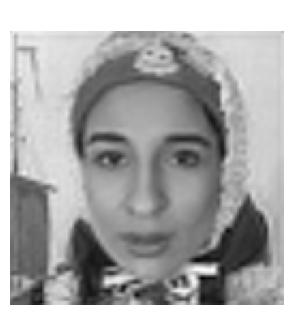

In [364]:
dispimage(train)